In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pyntcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 11.8 MB/s eta 0:00:00


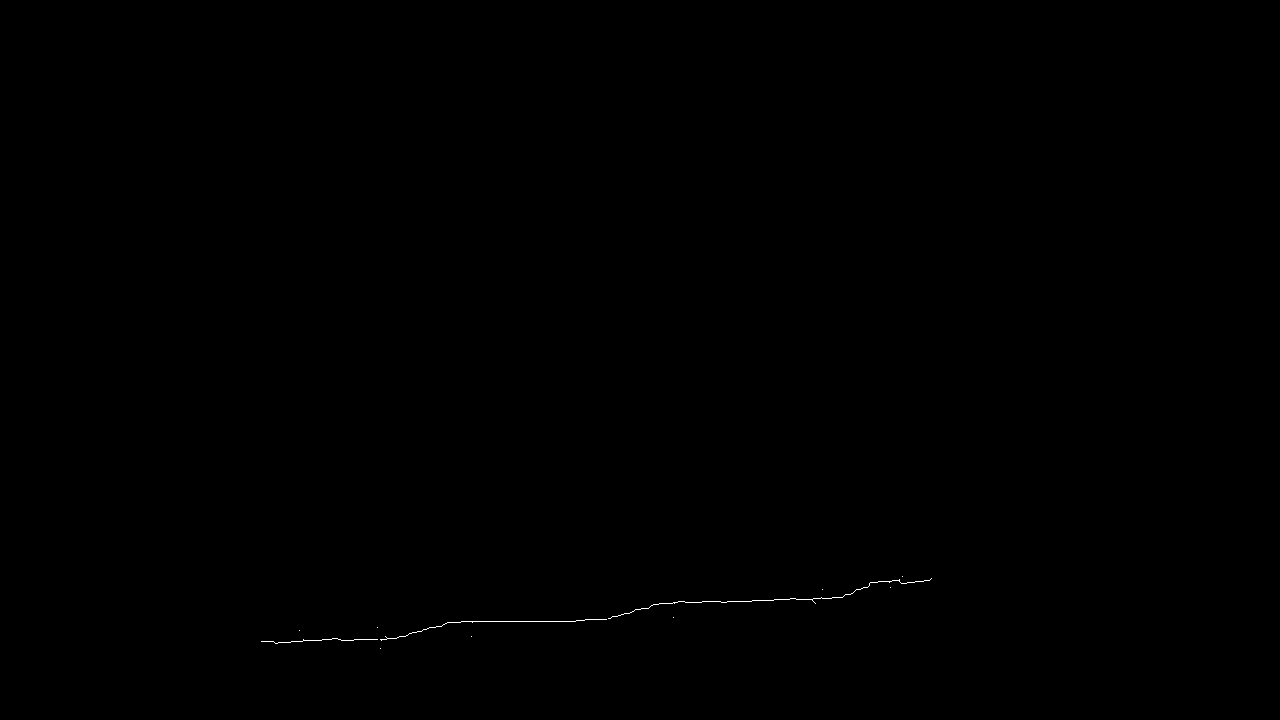

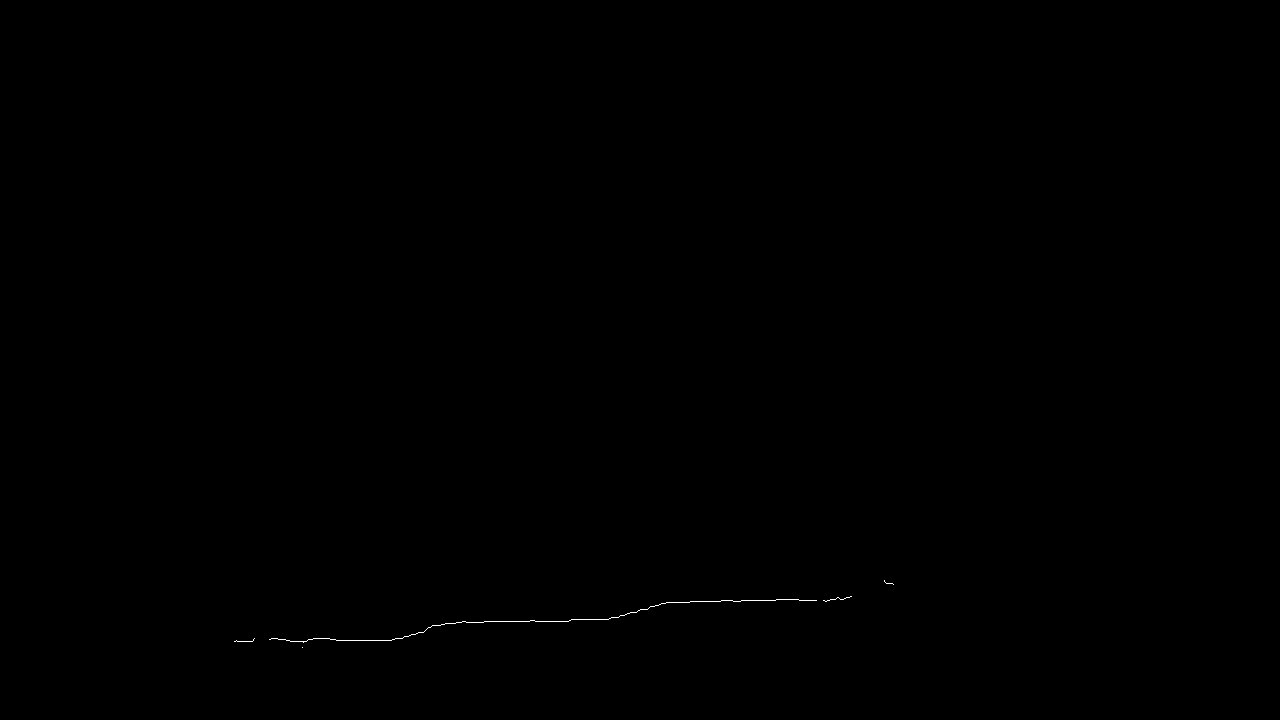

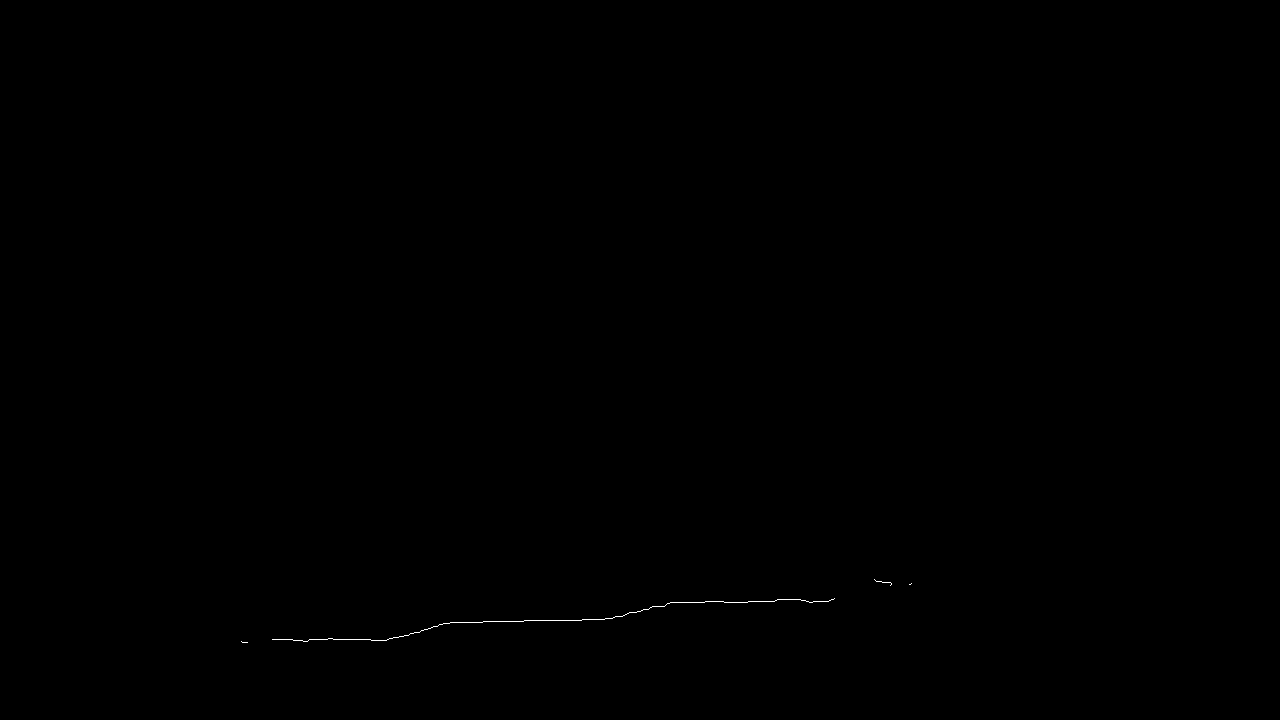

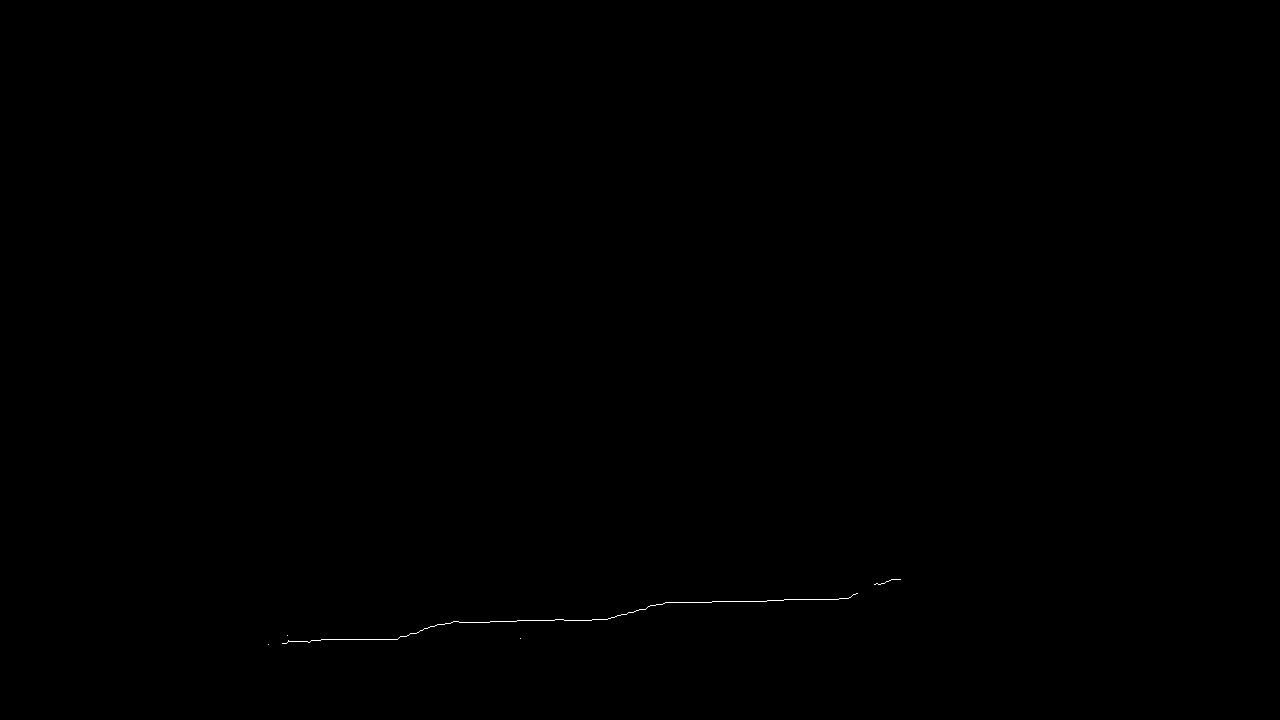

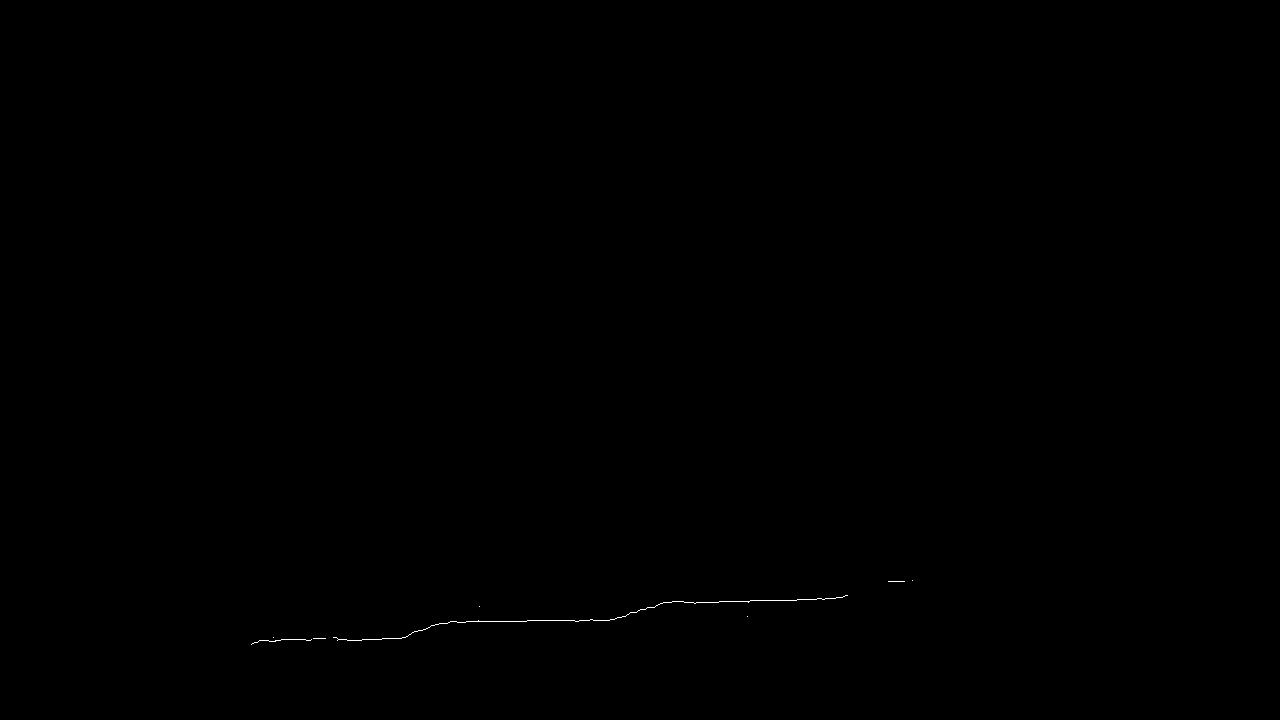

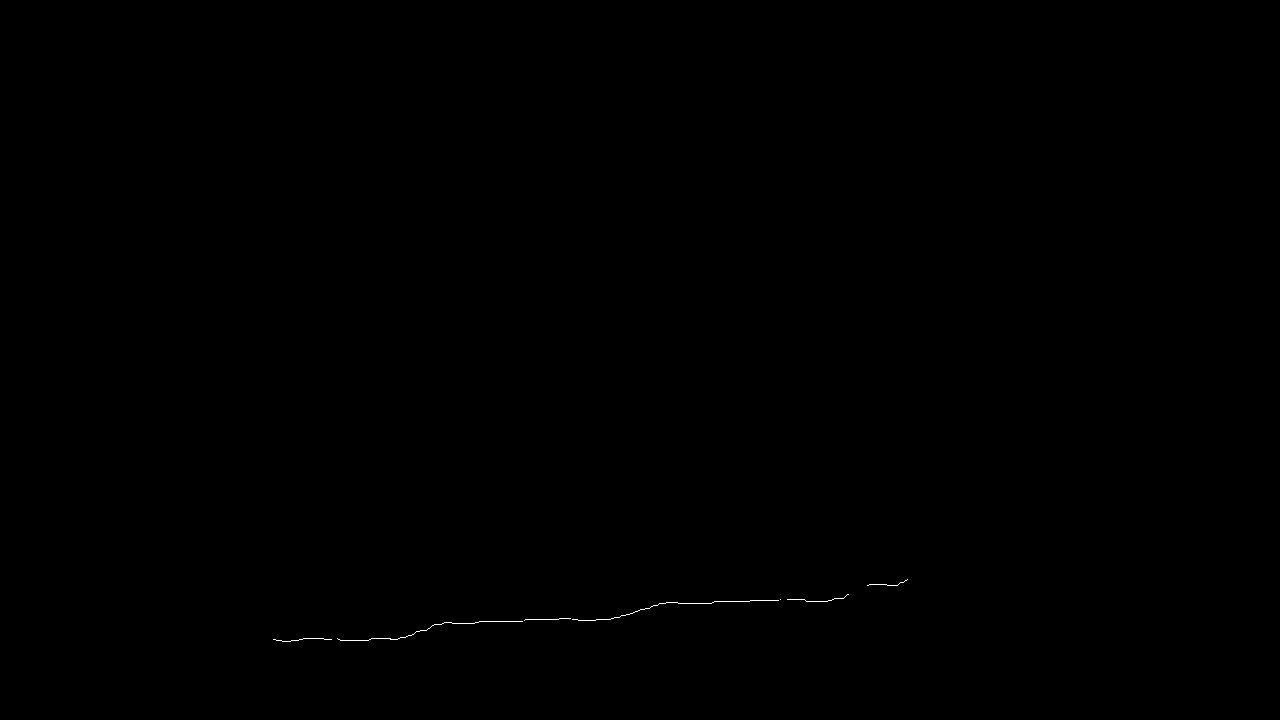

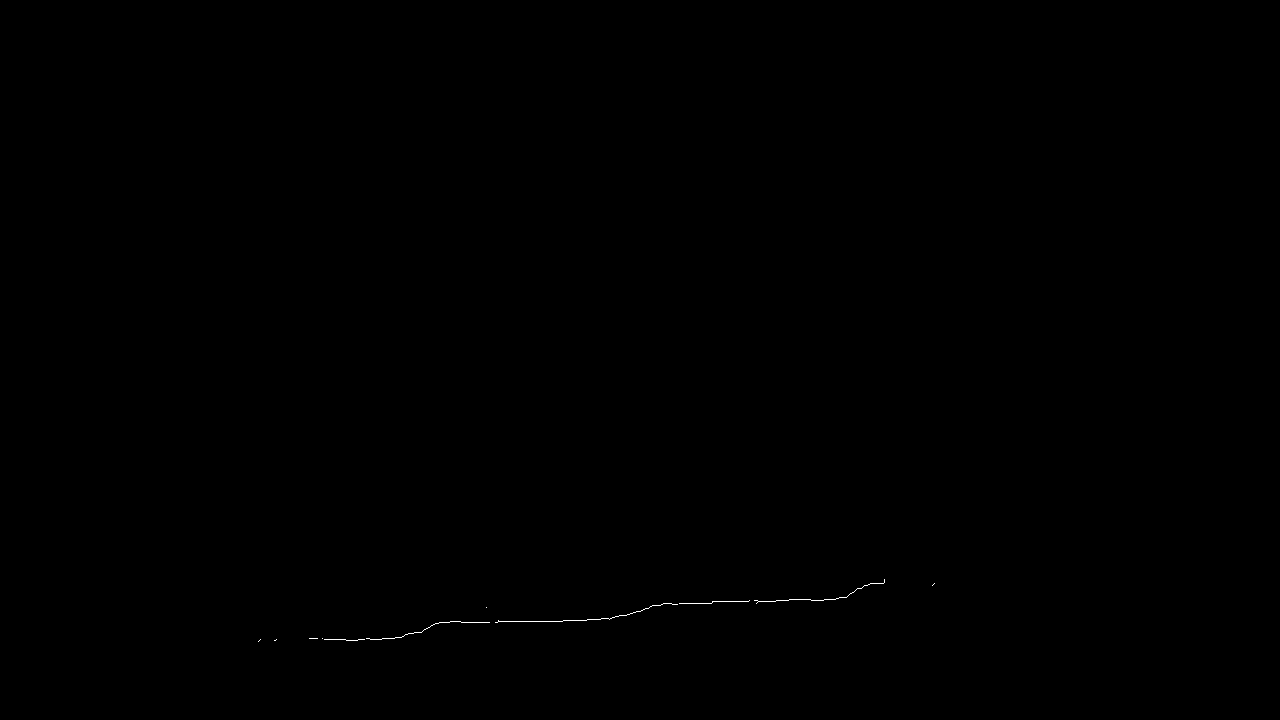

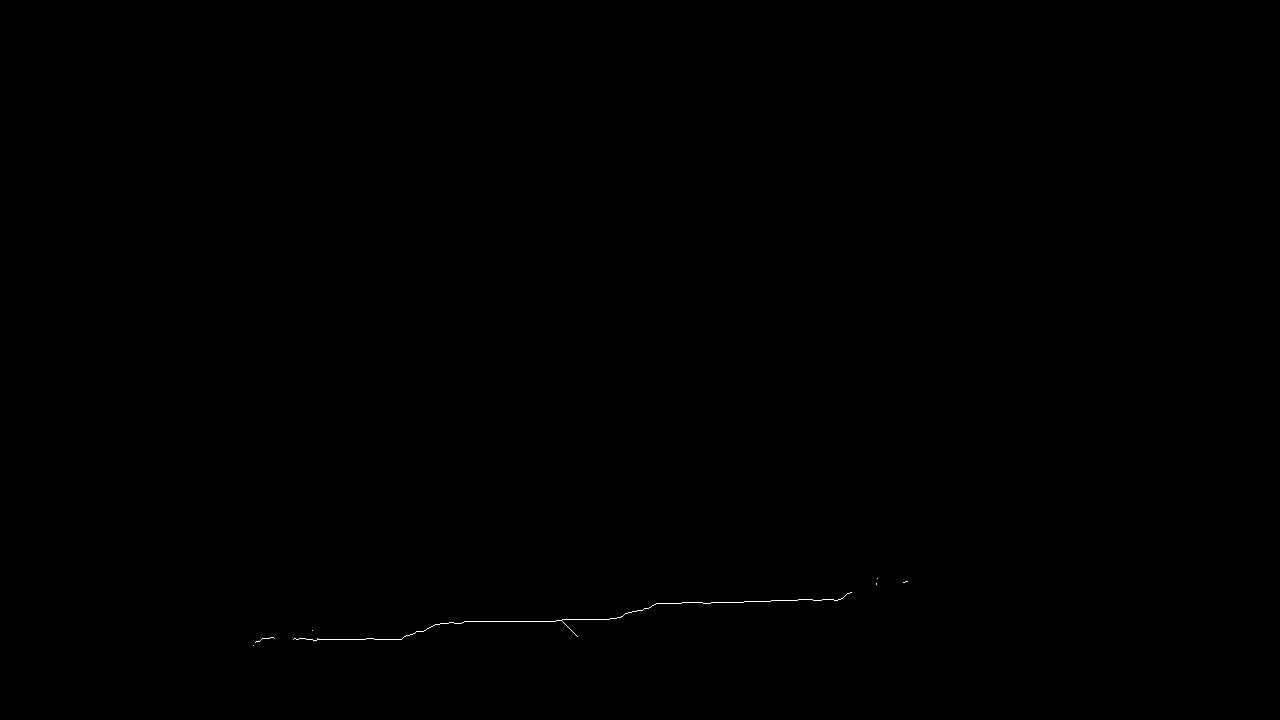

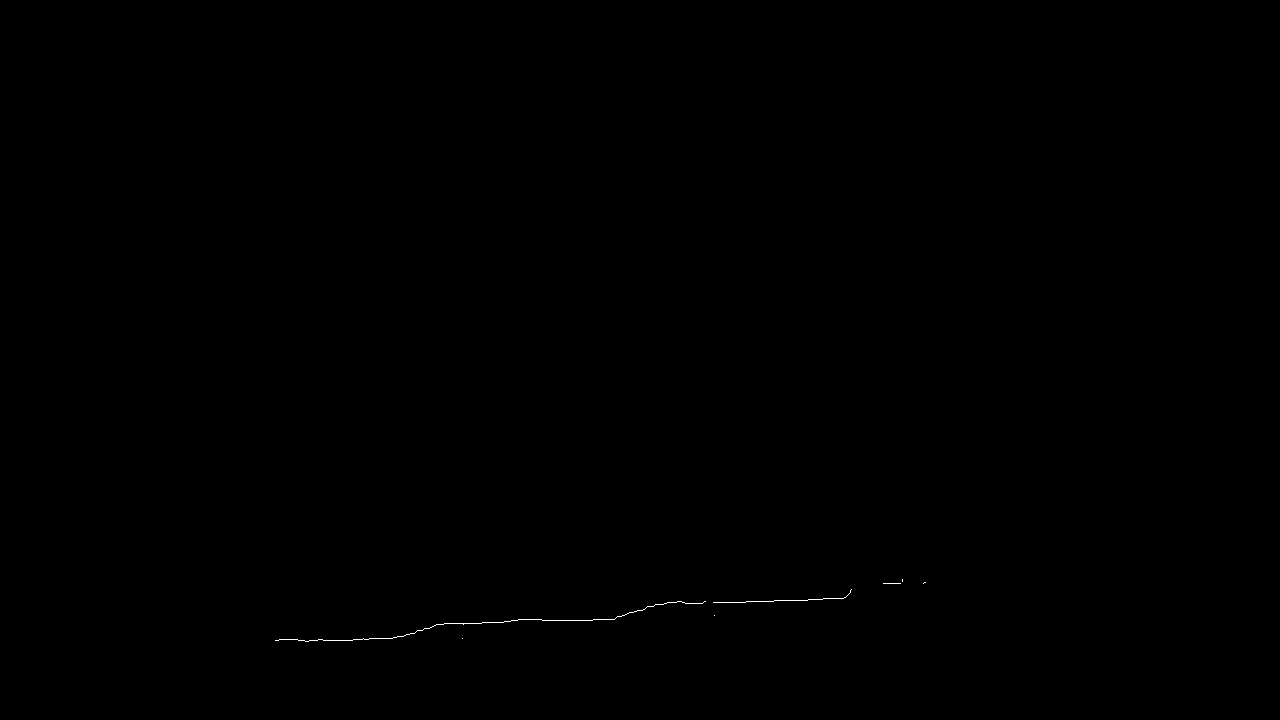

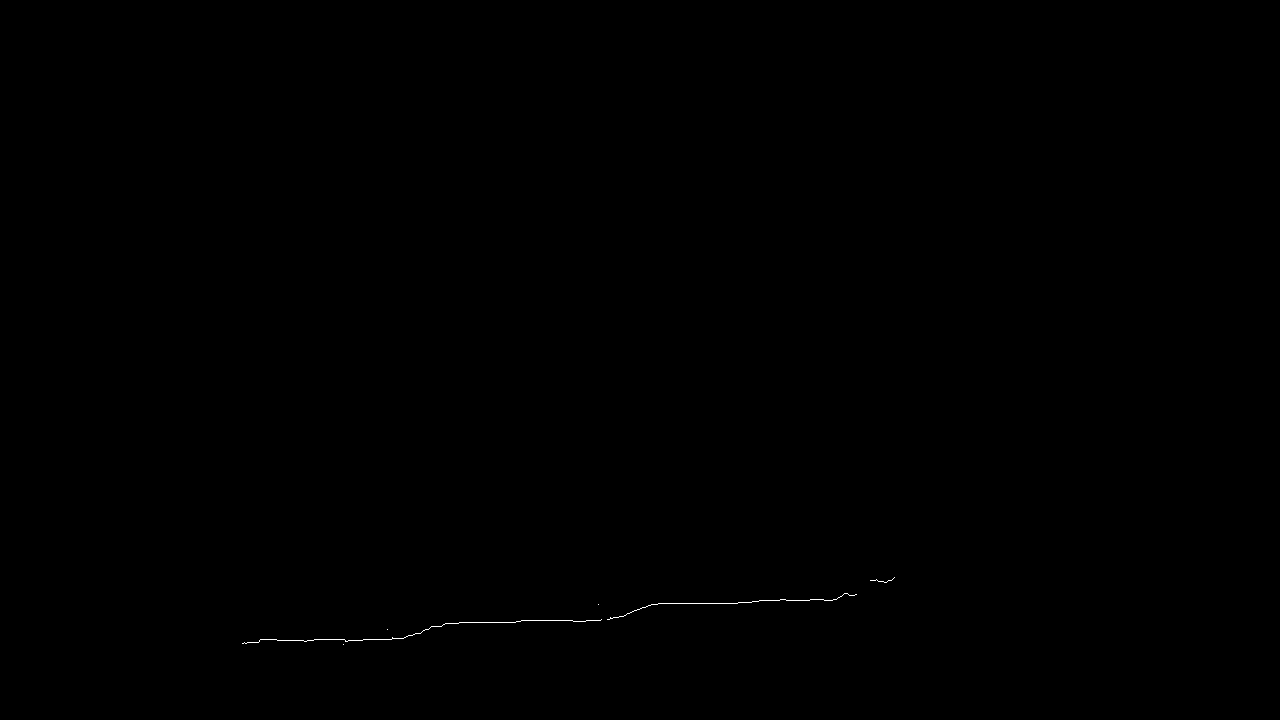

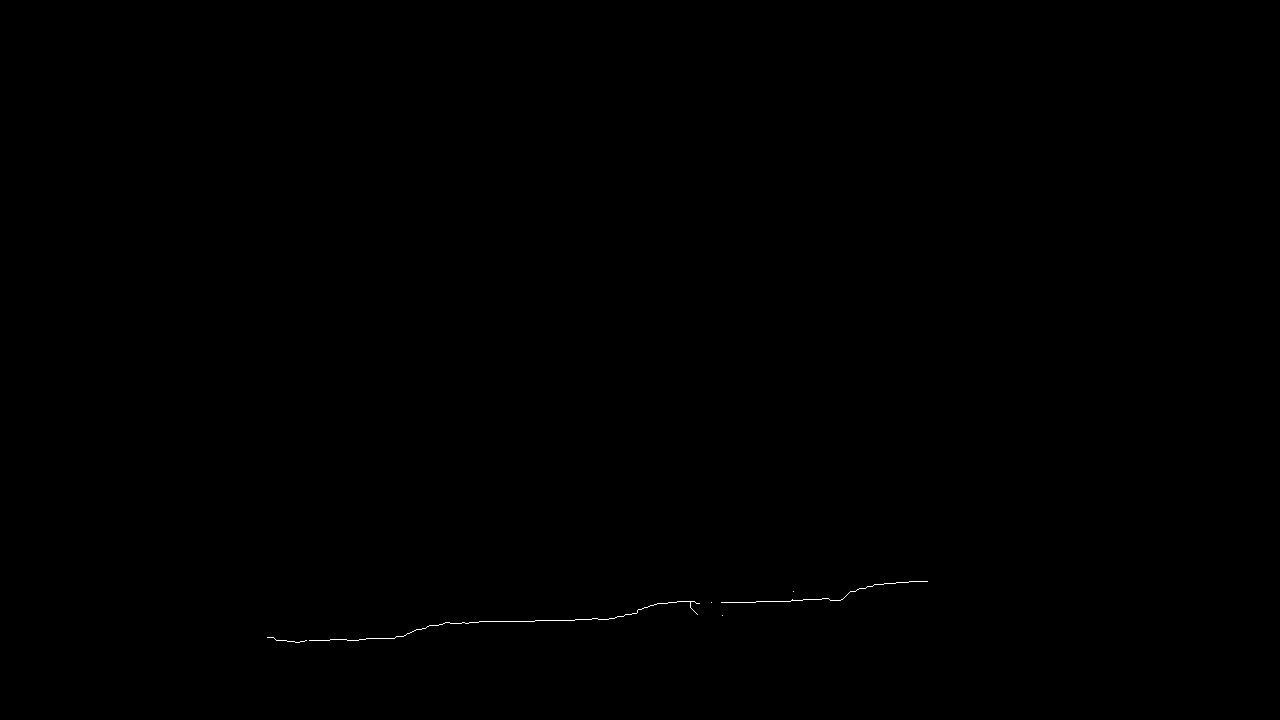

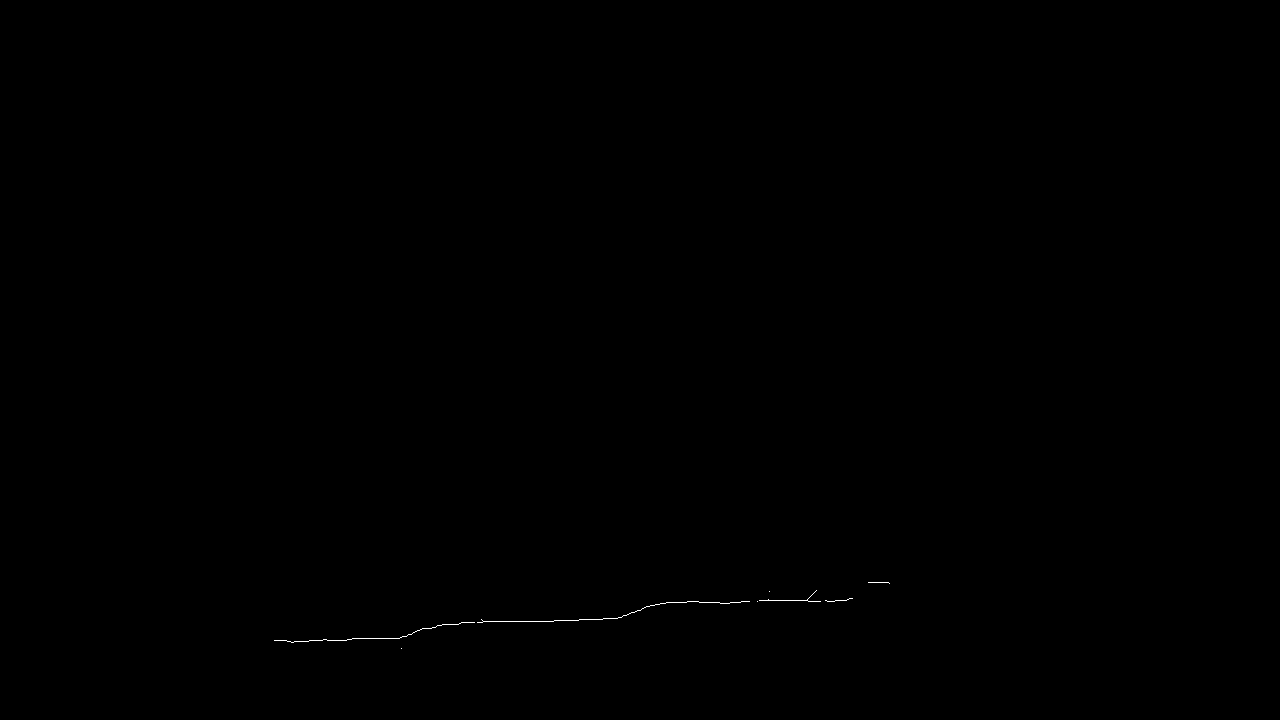

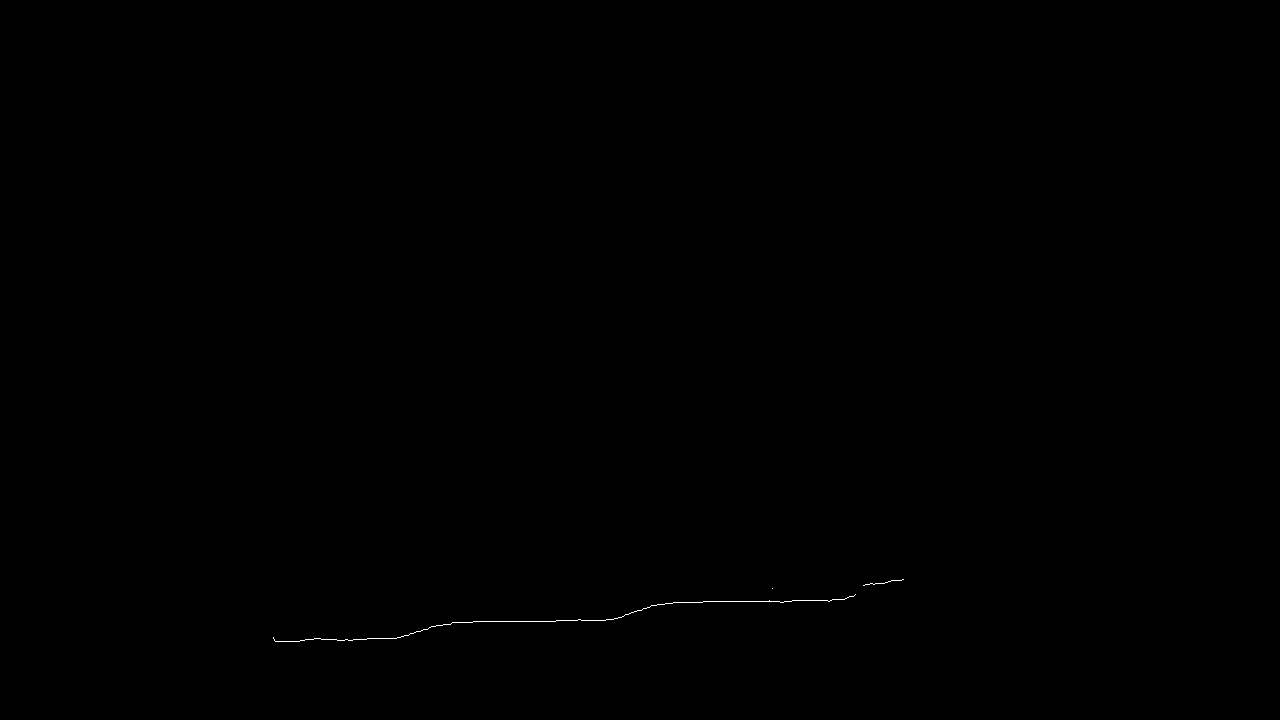

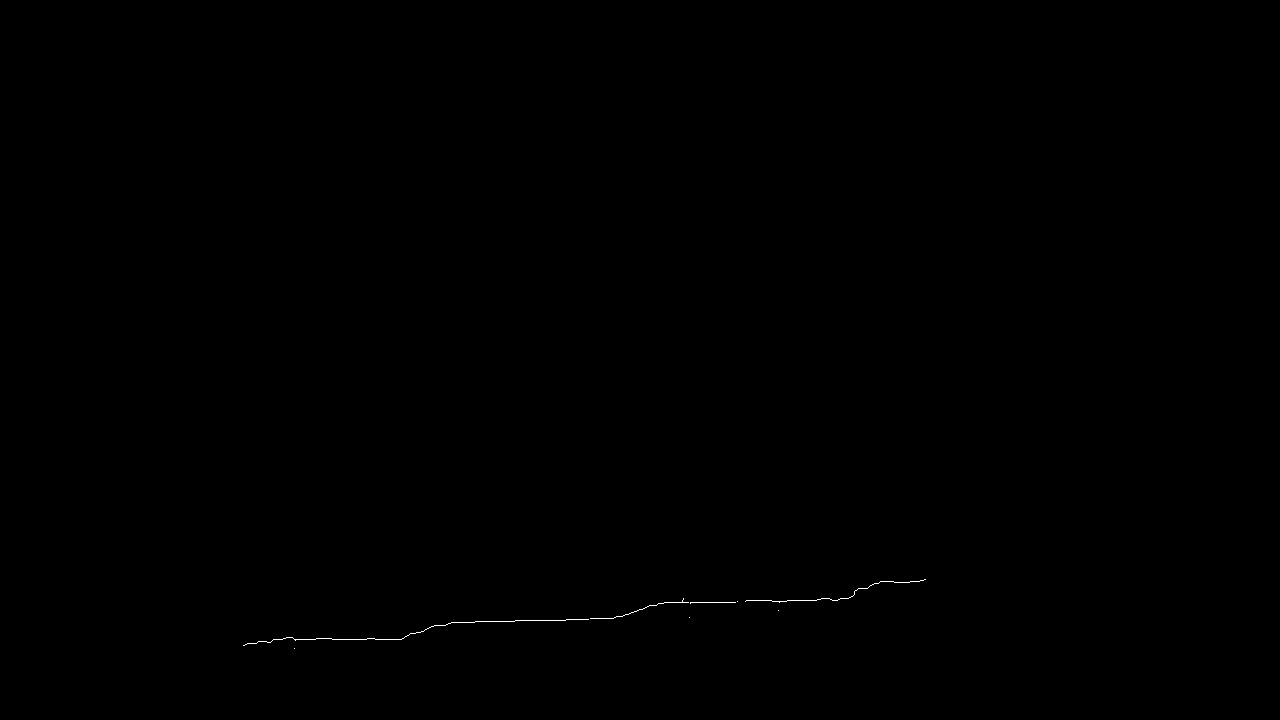

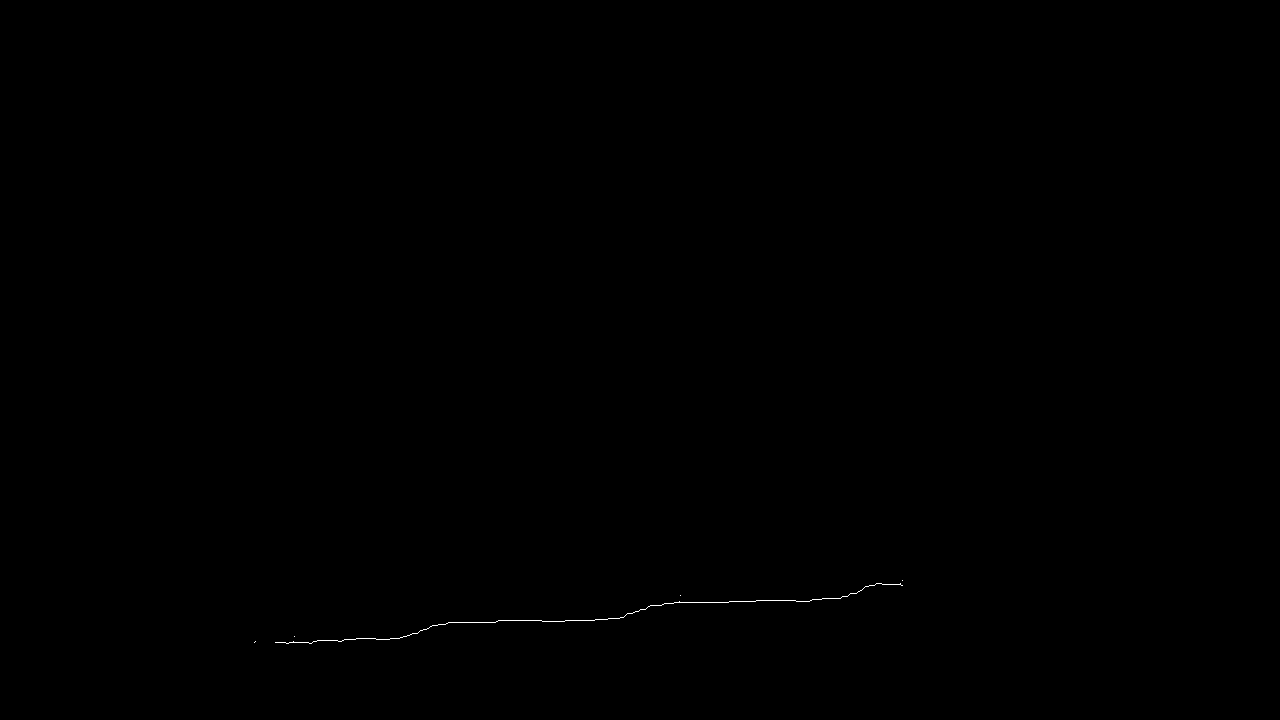

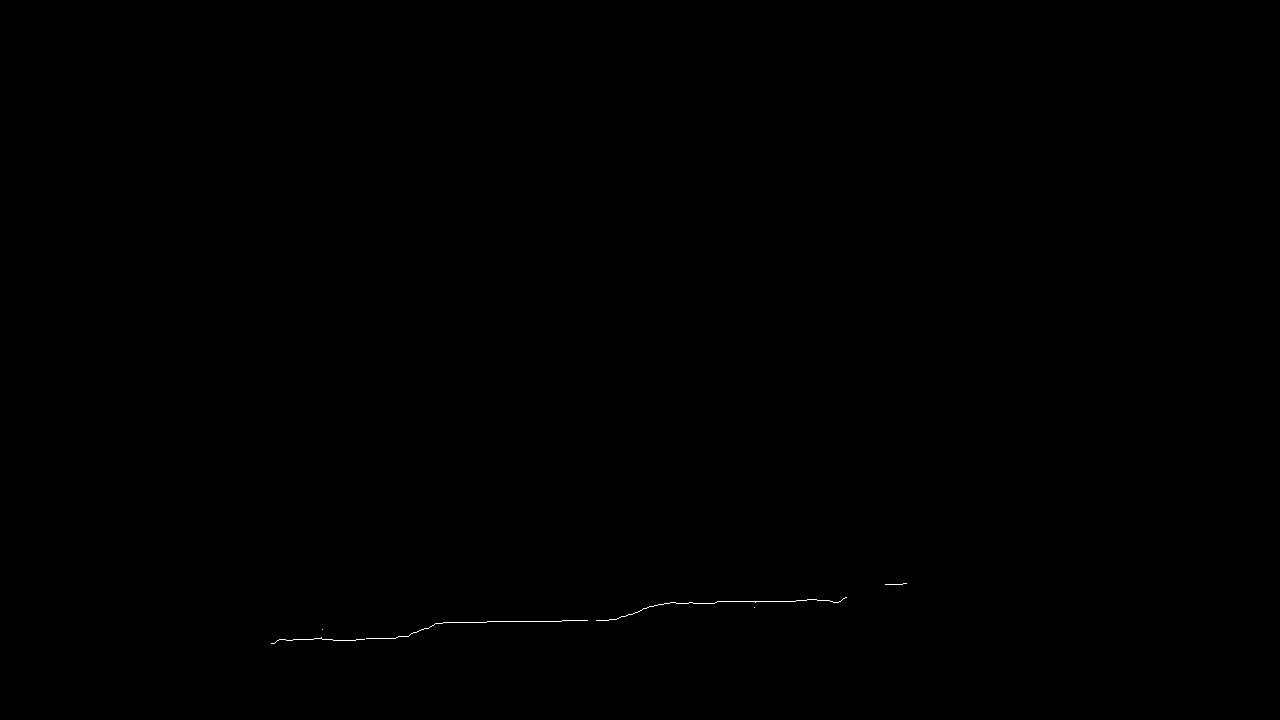

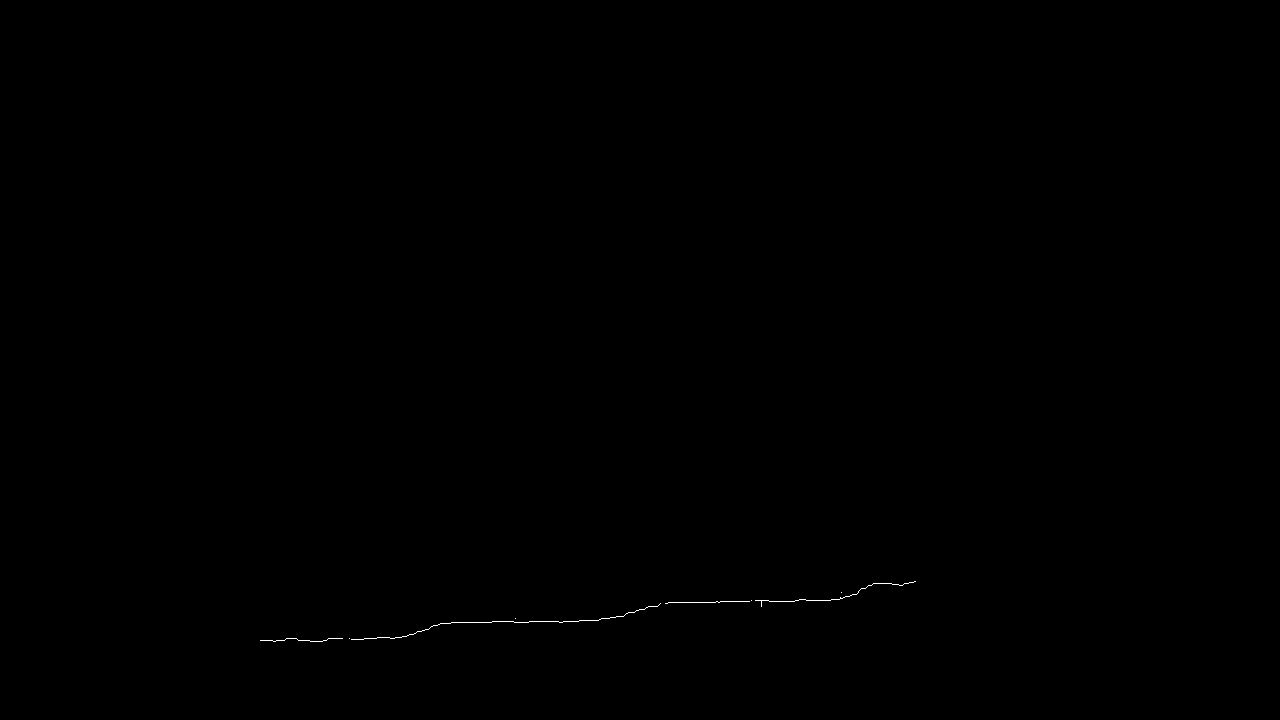

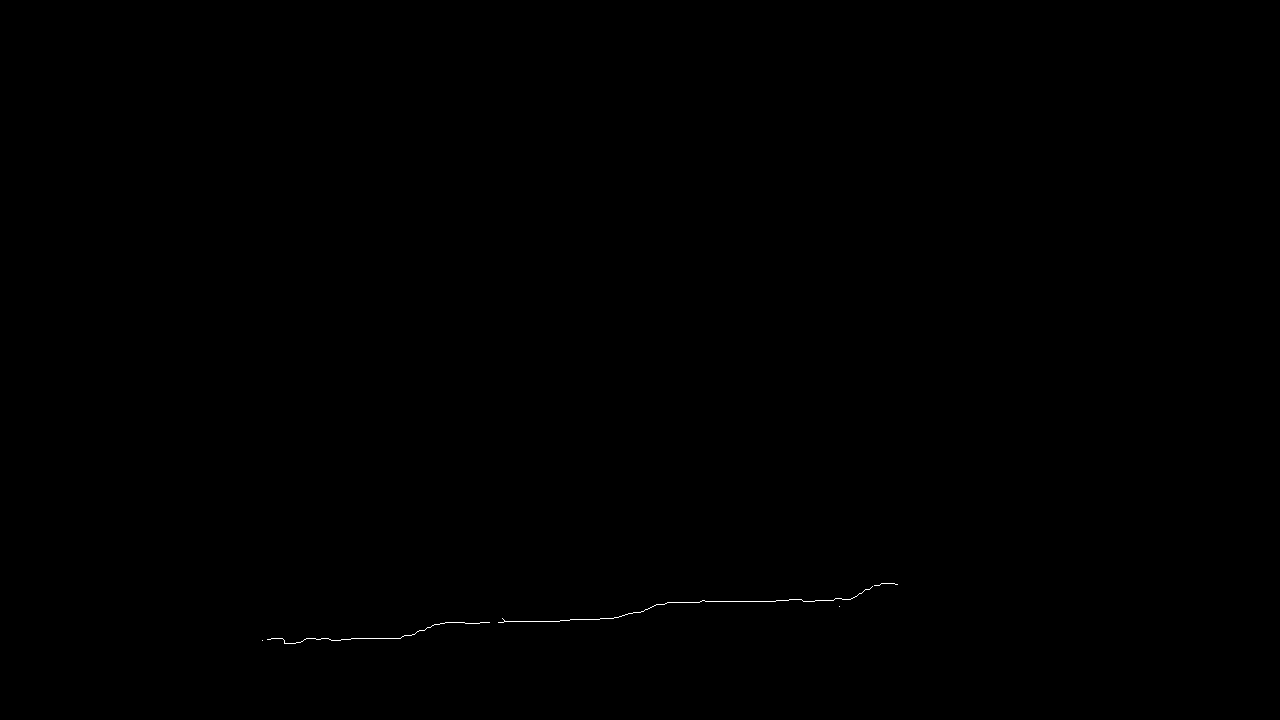

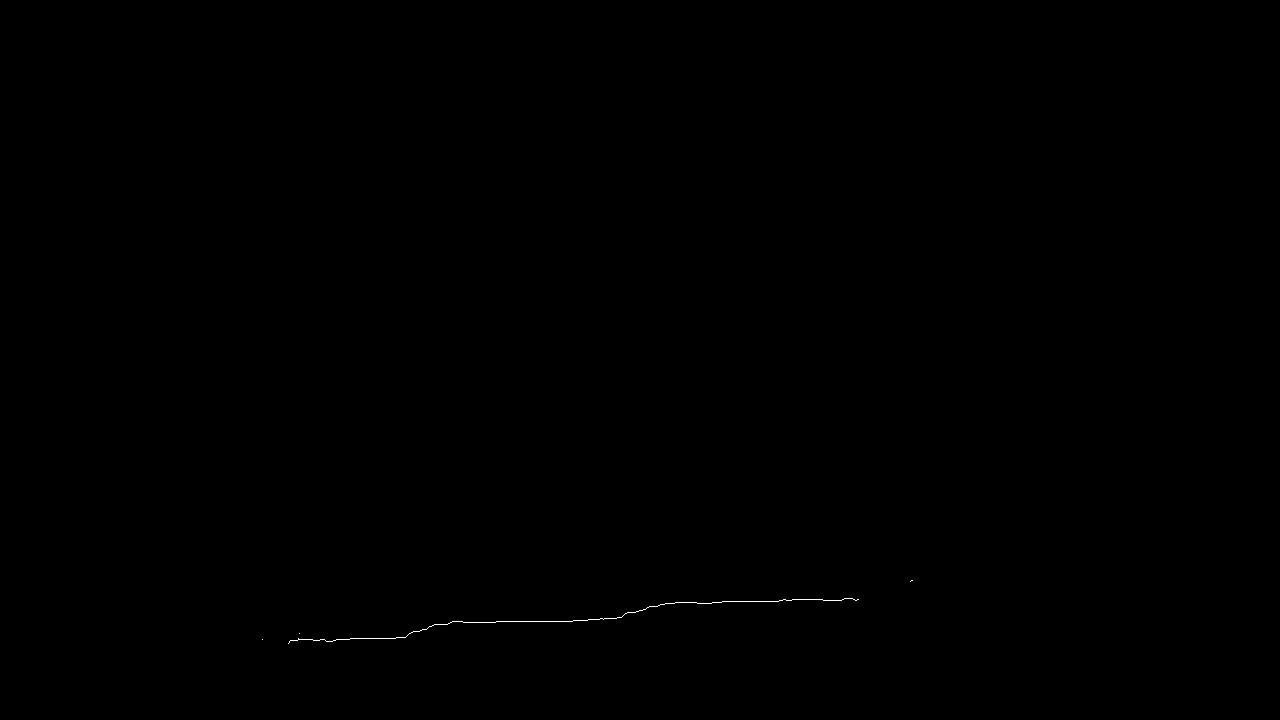

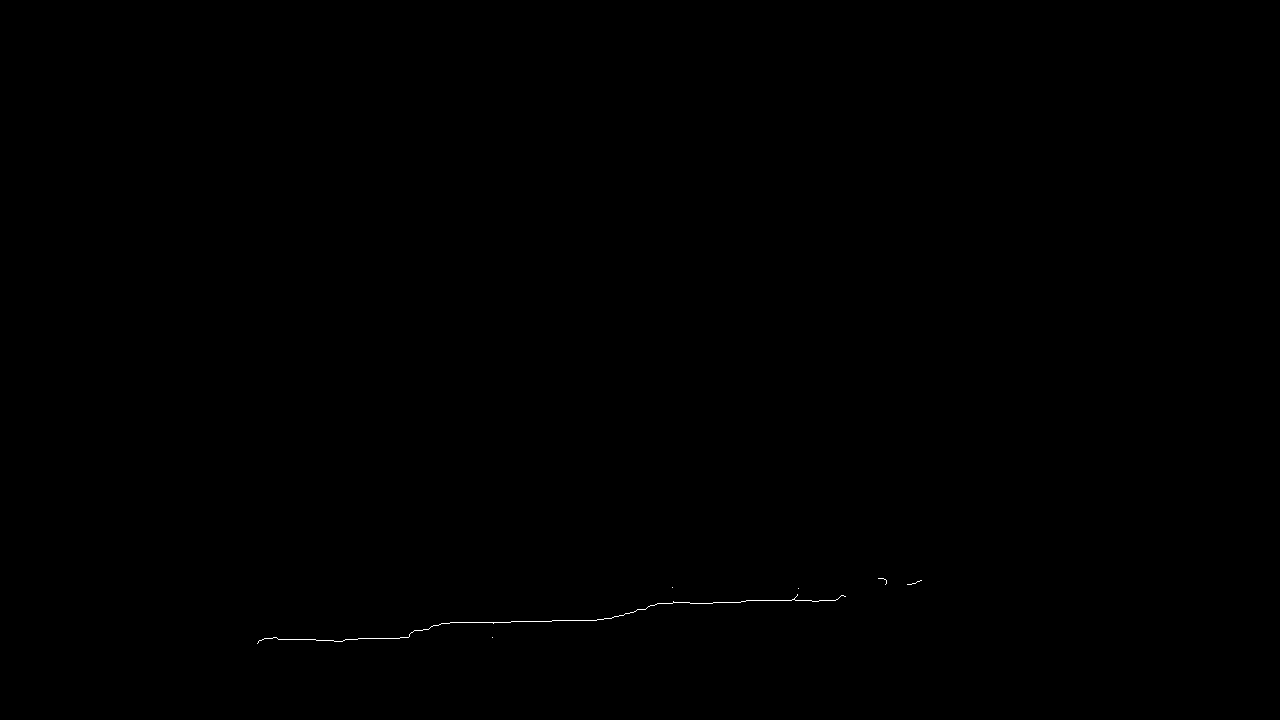

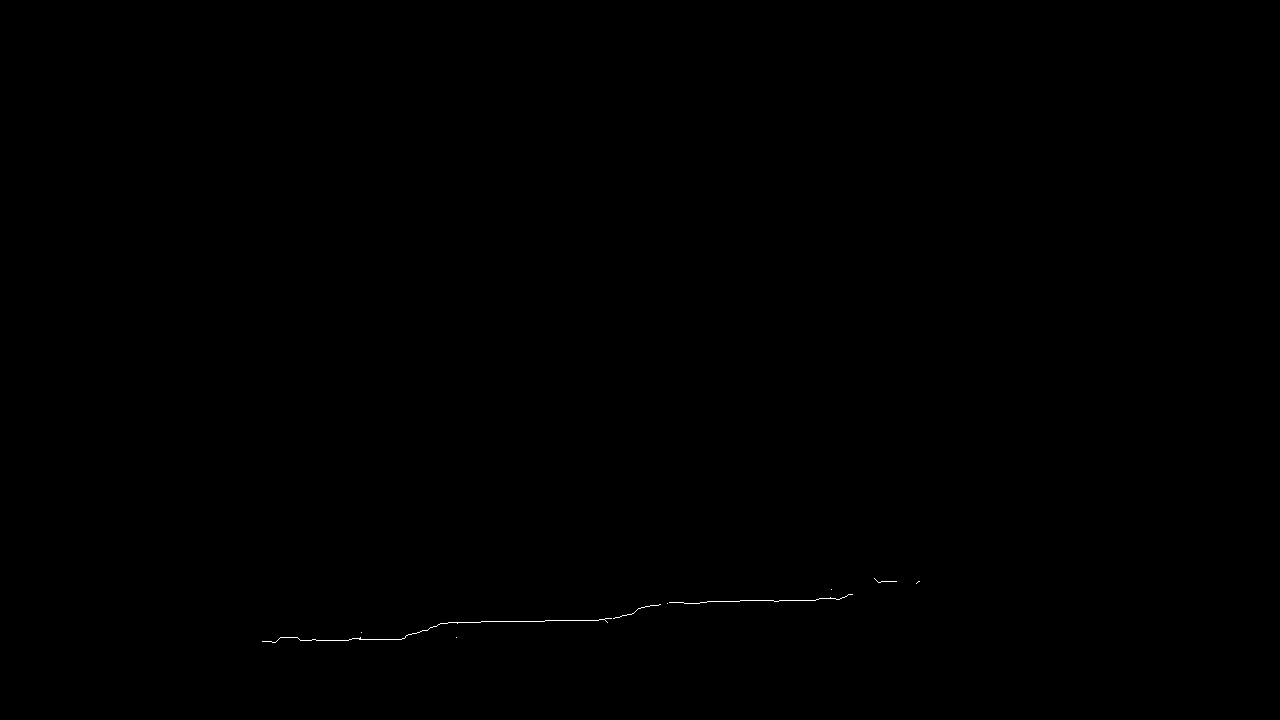

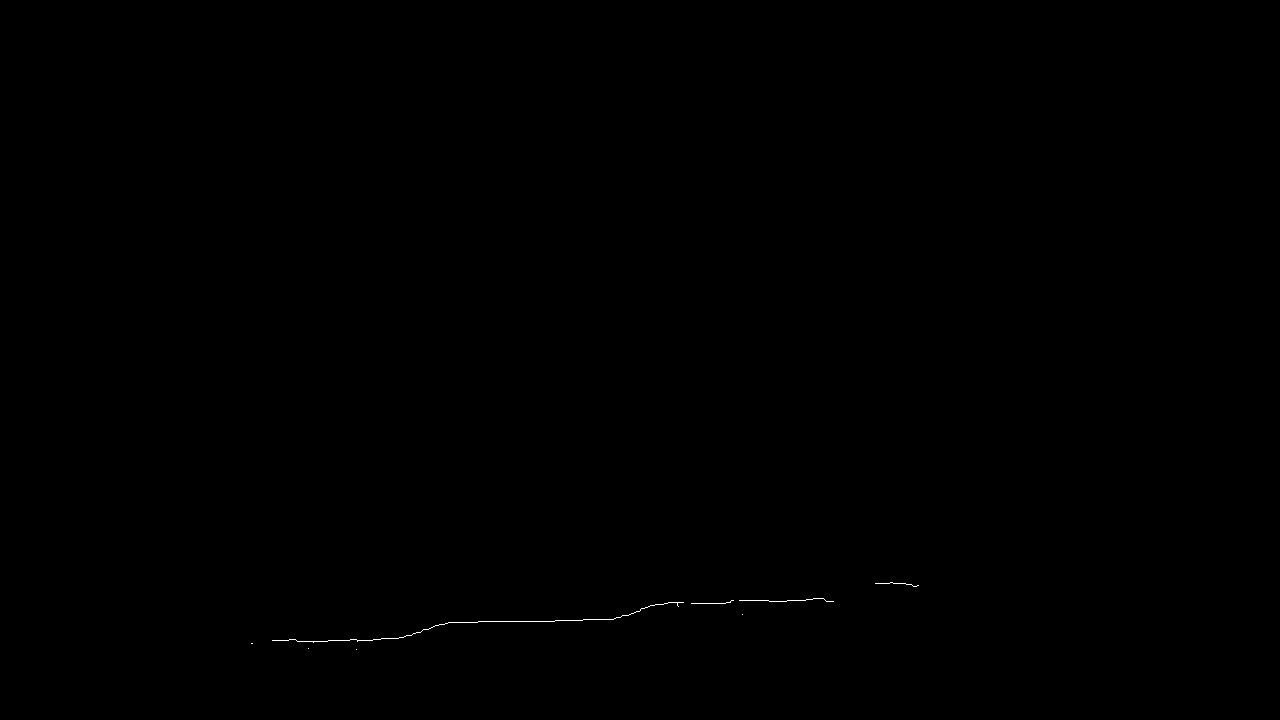

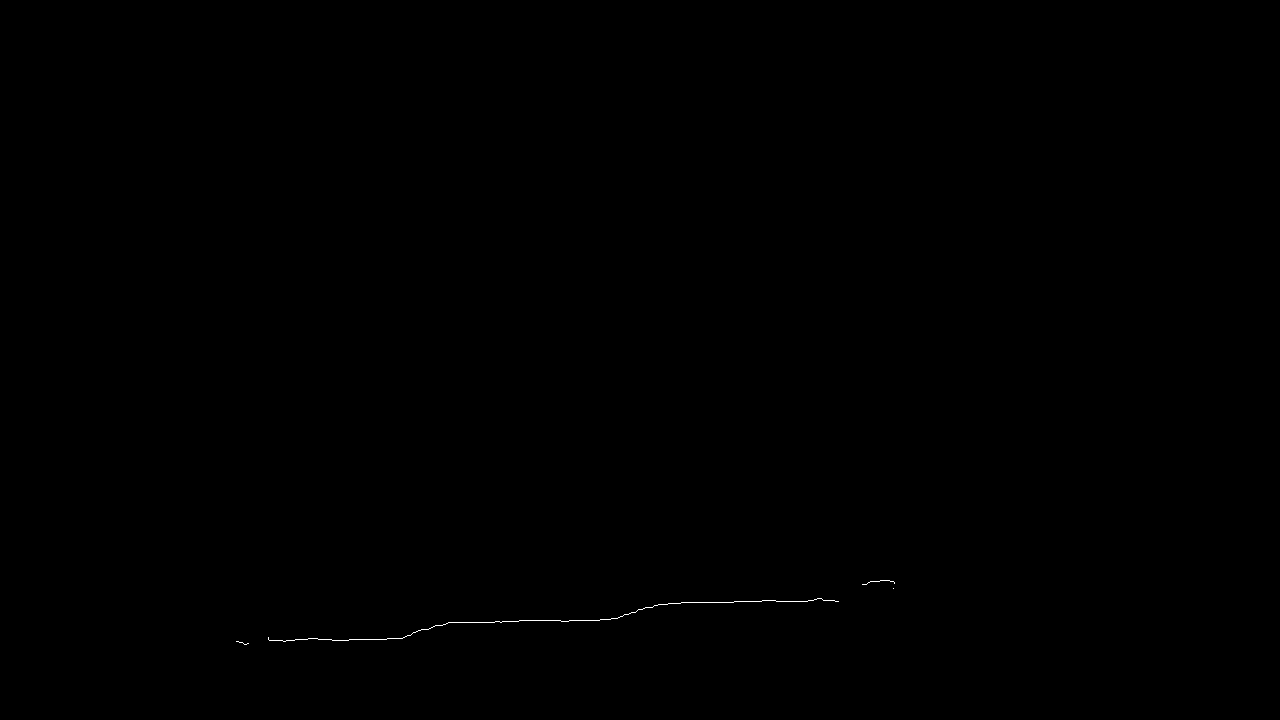

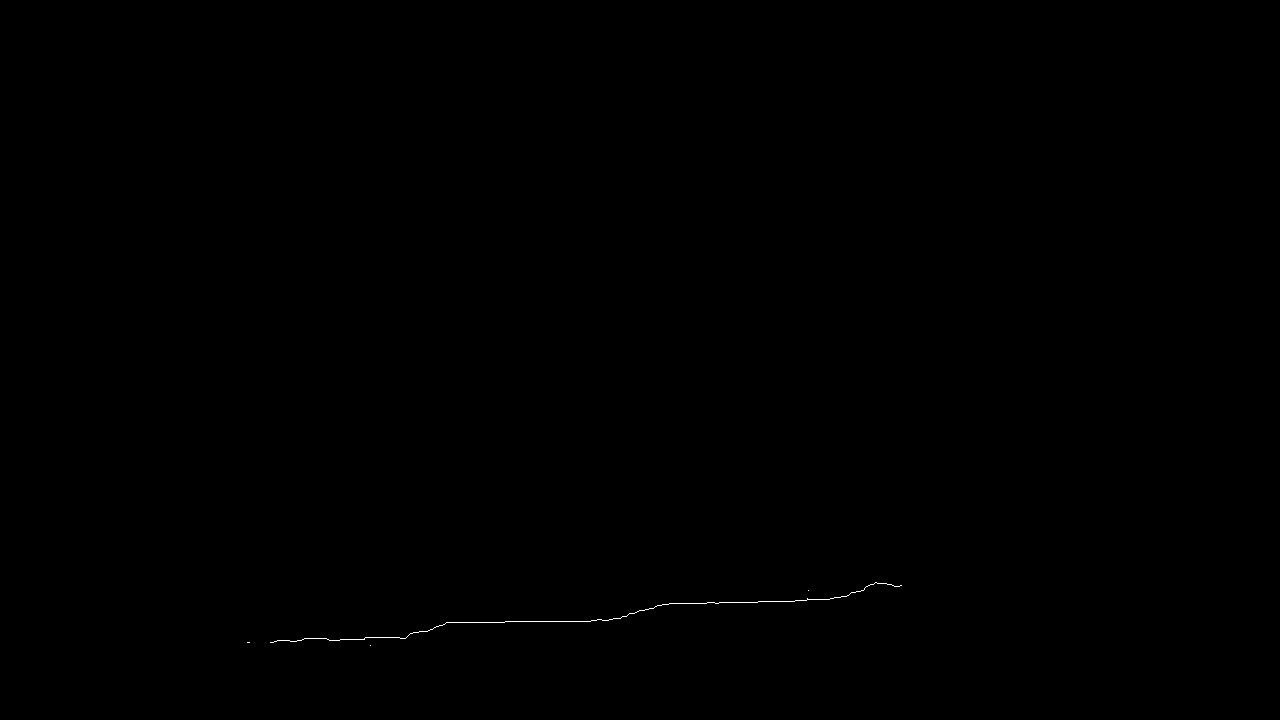

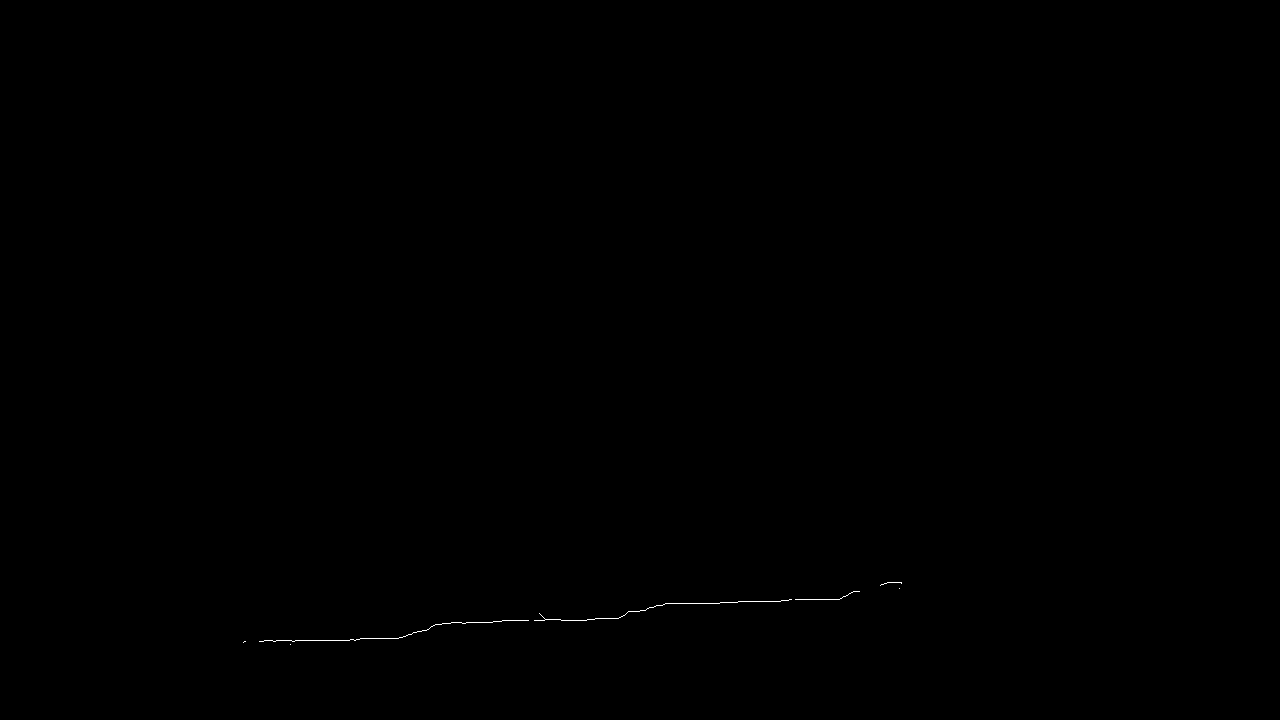

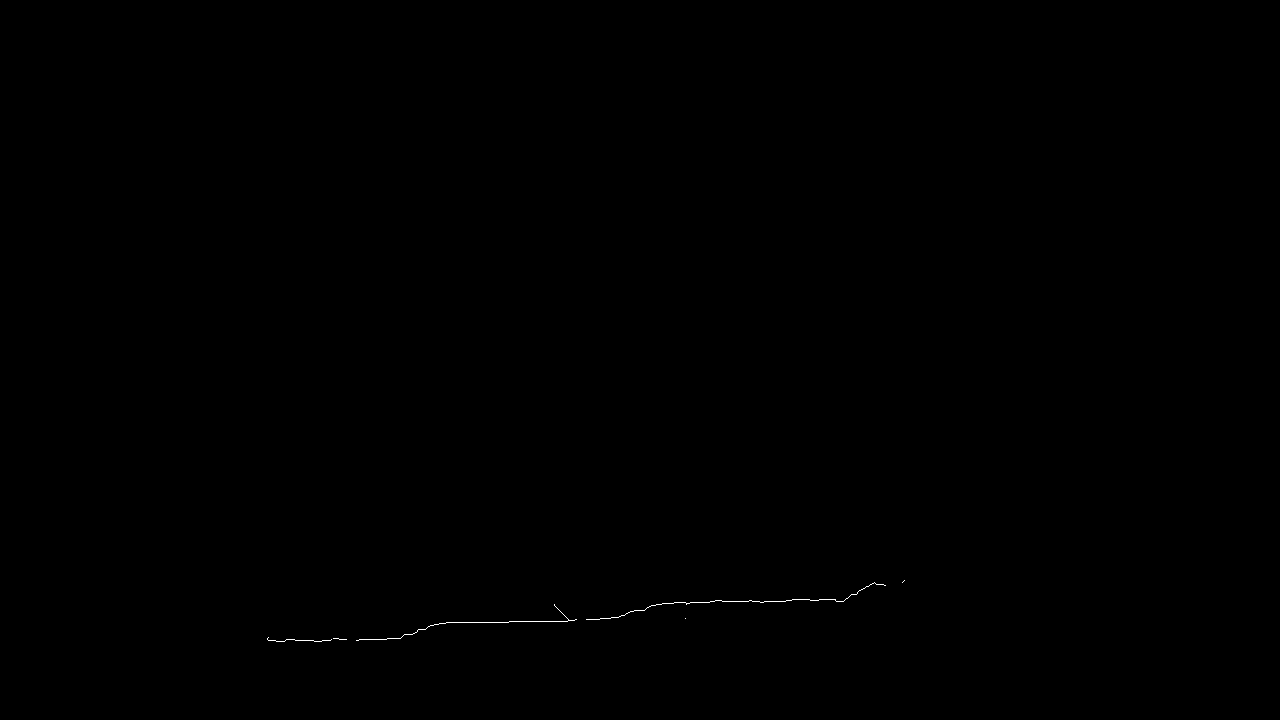

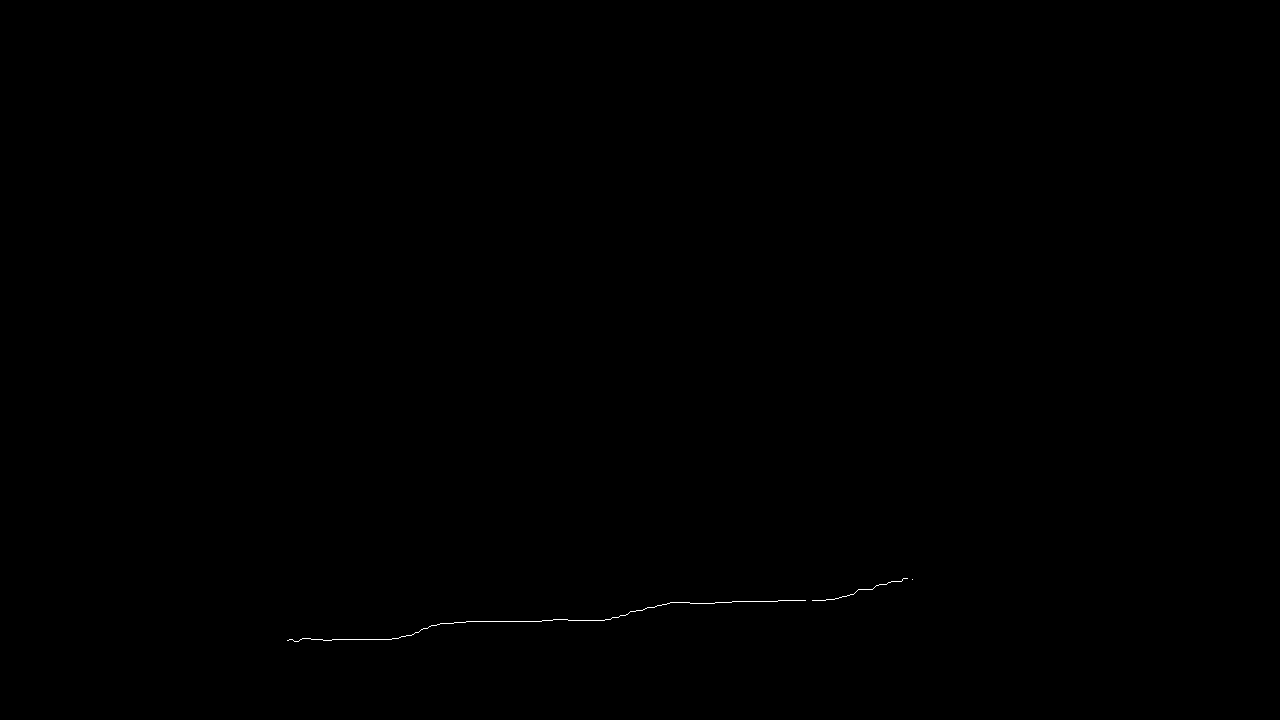

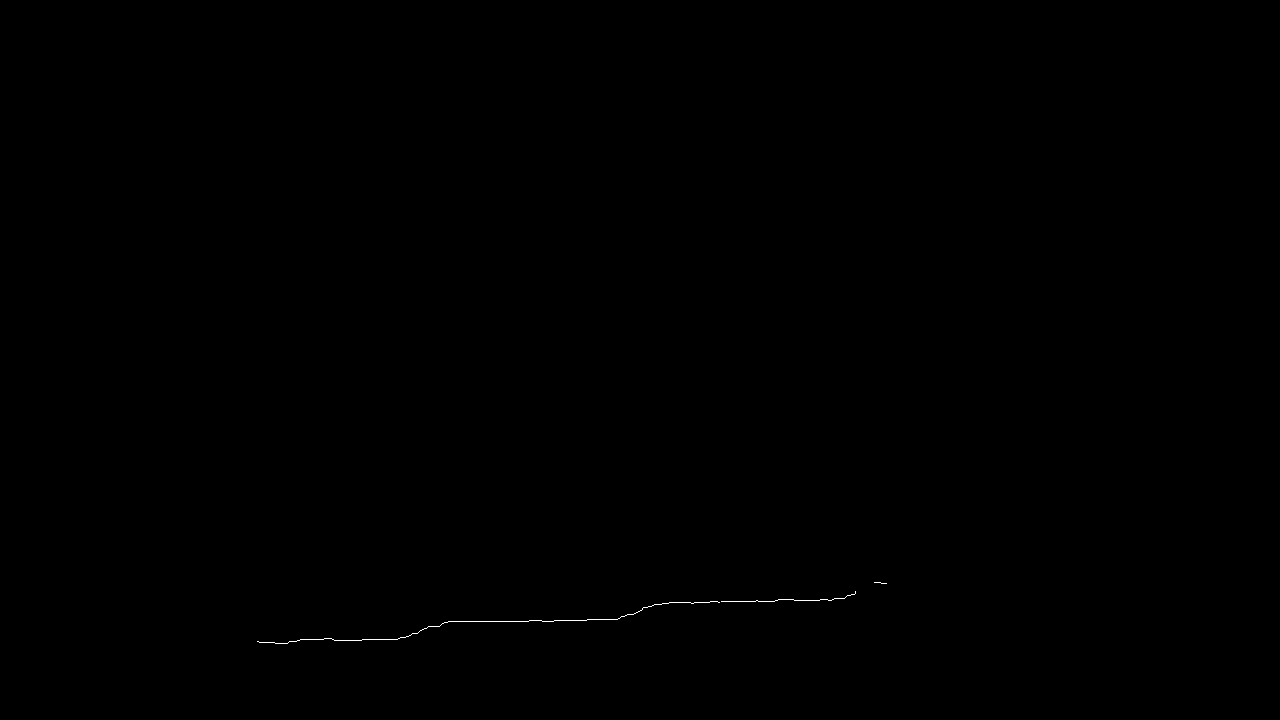

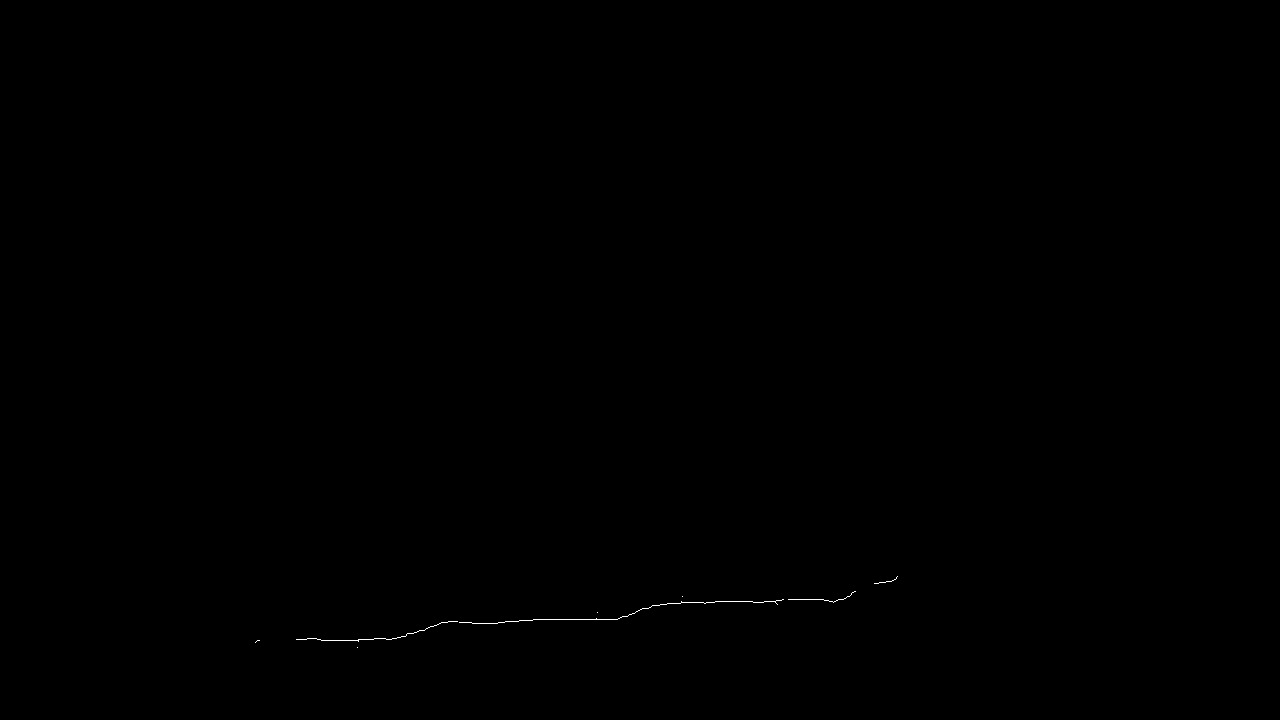

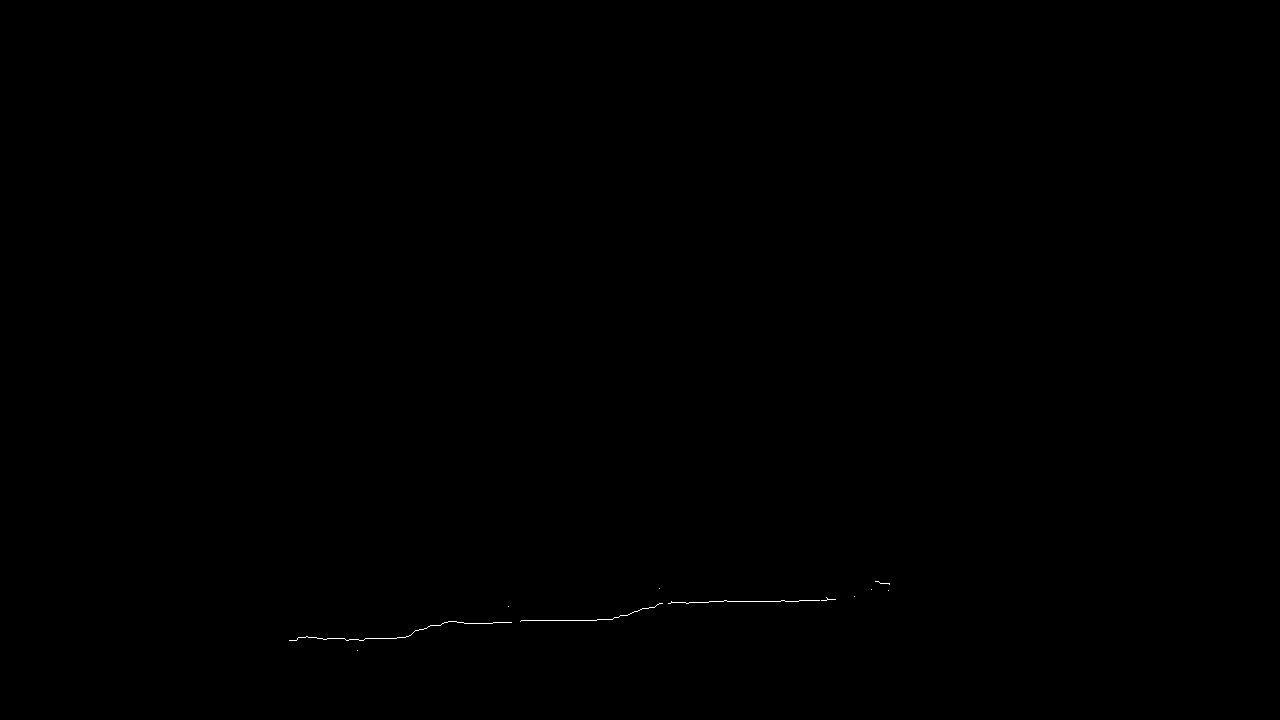

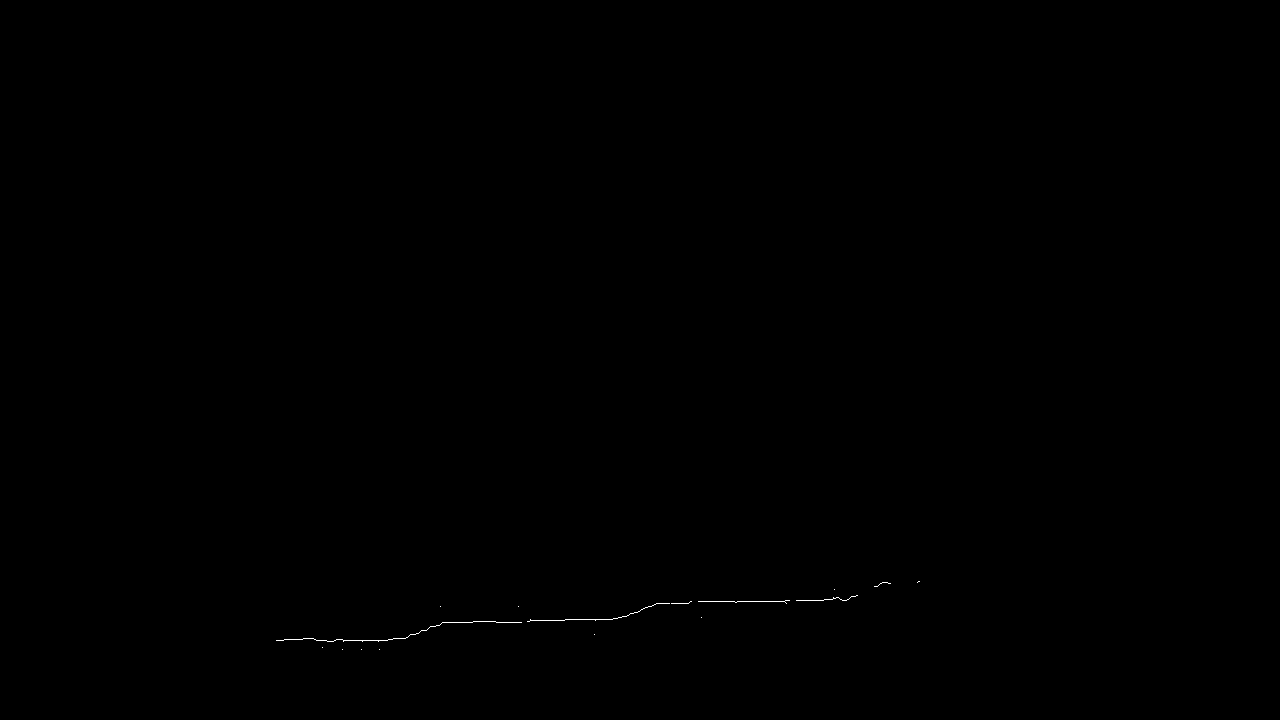

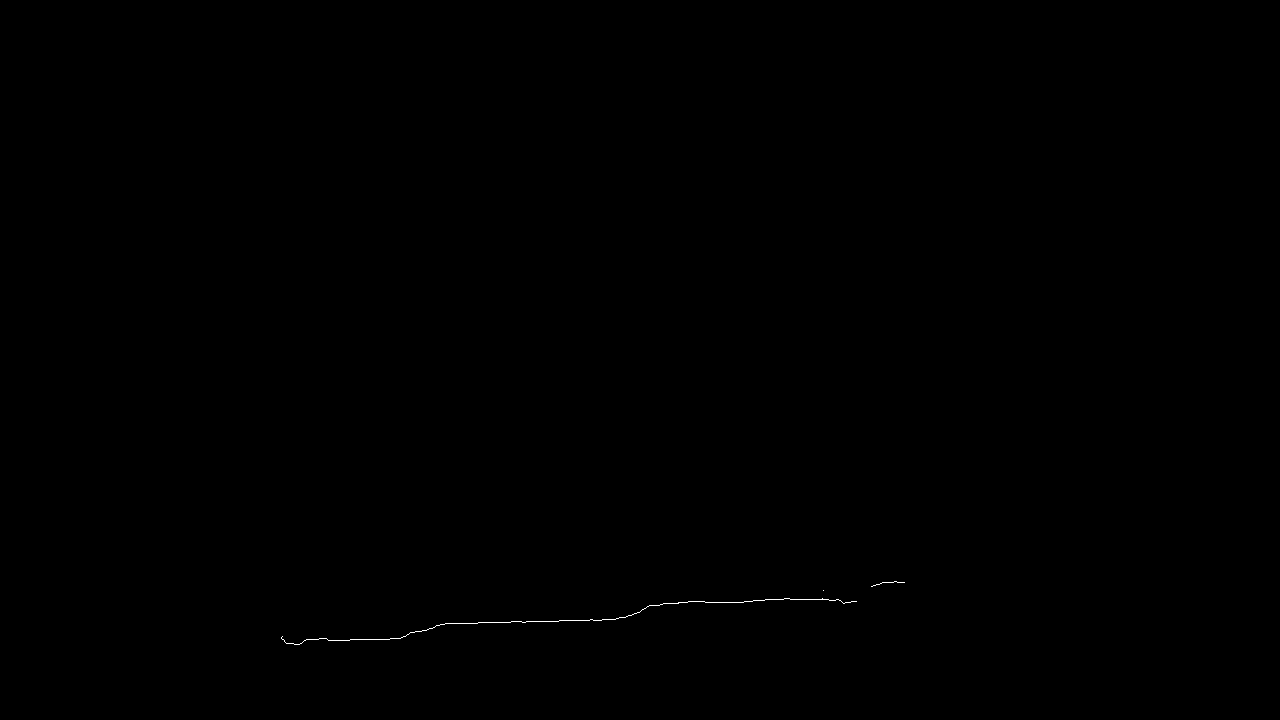

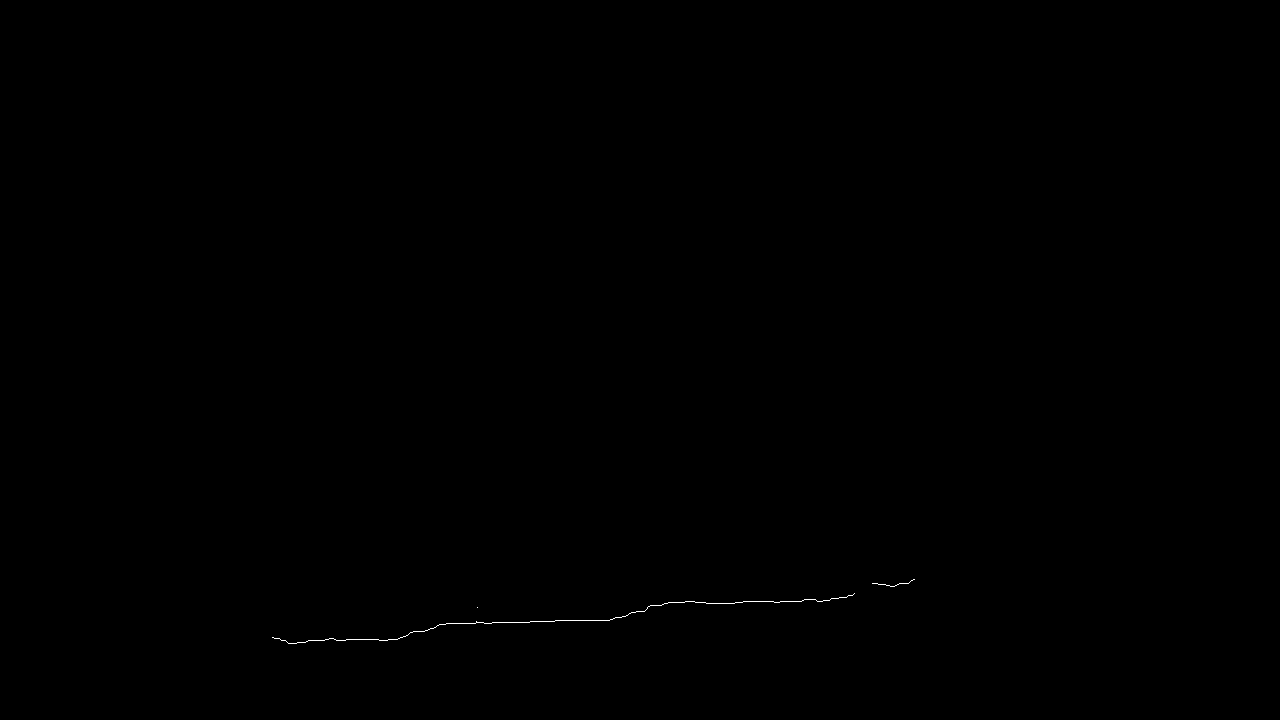

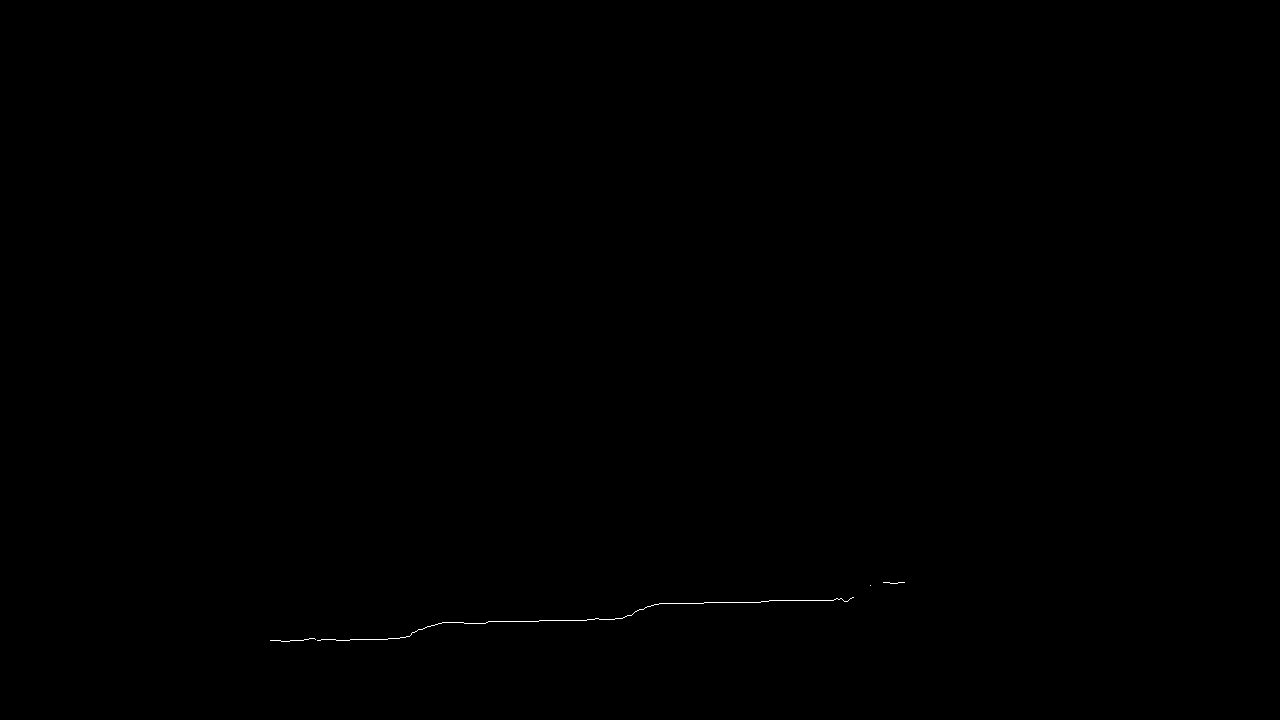

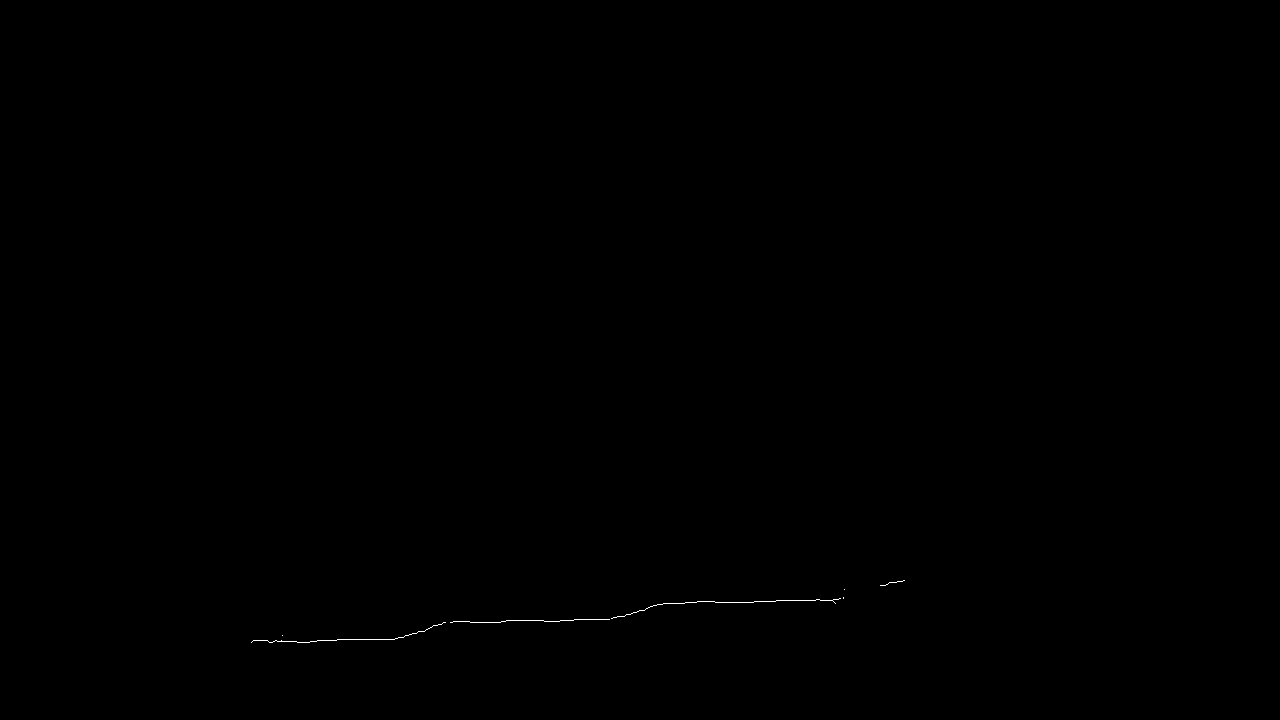

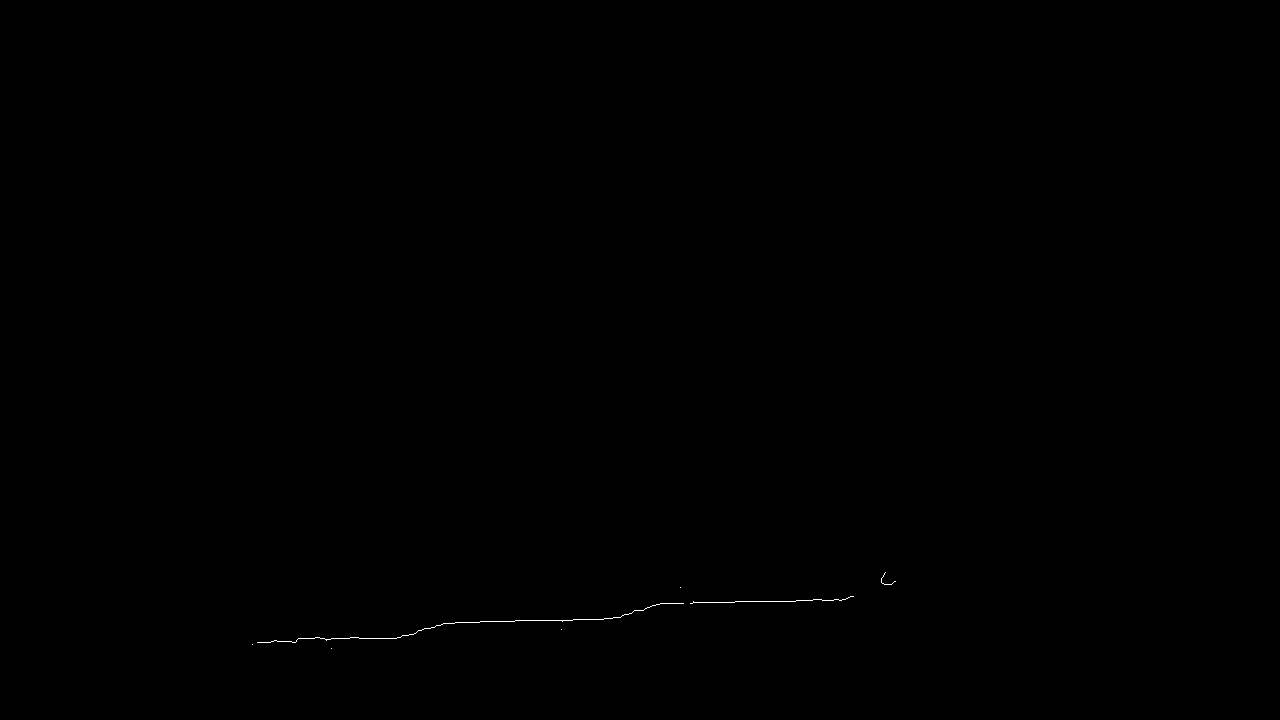

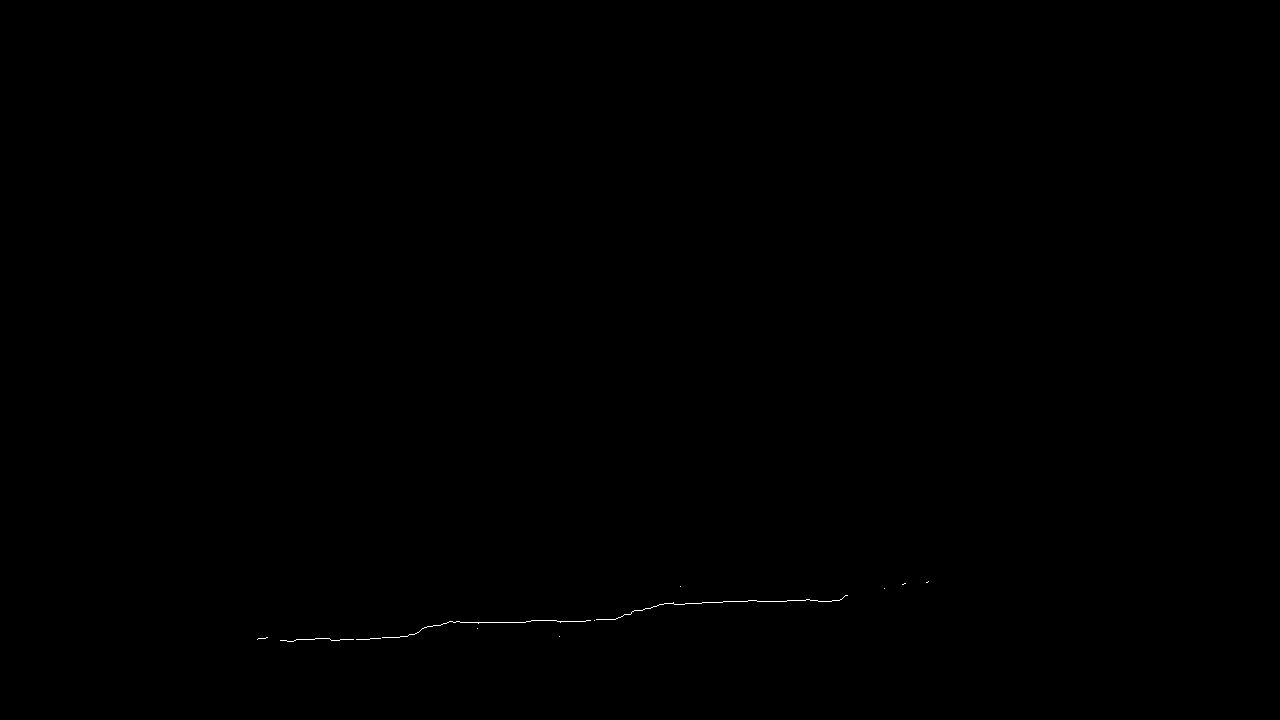

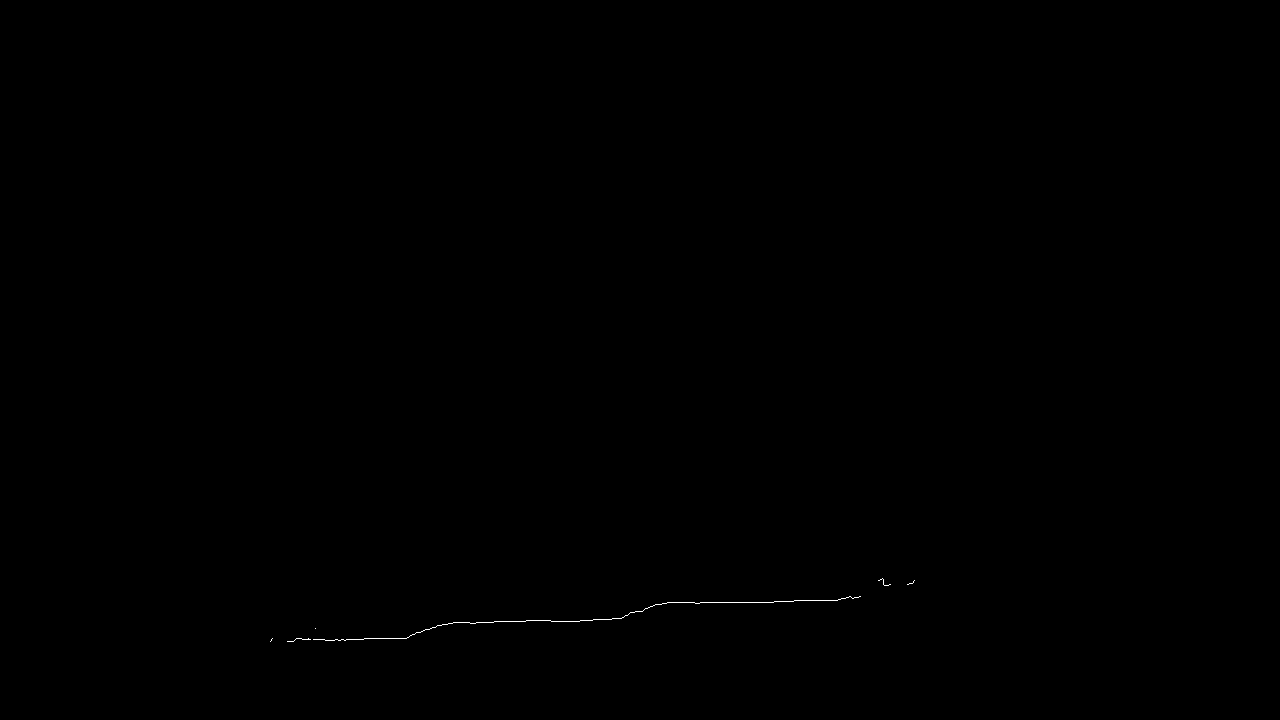

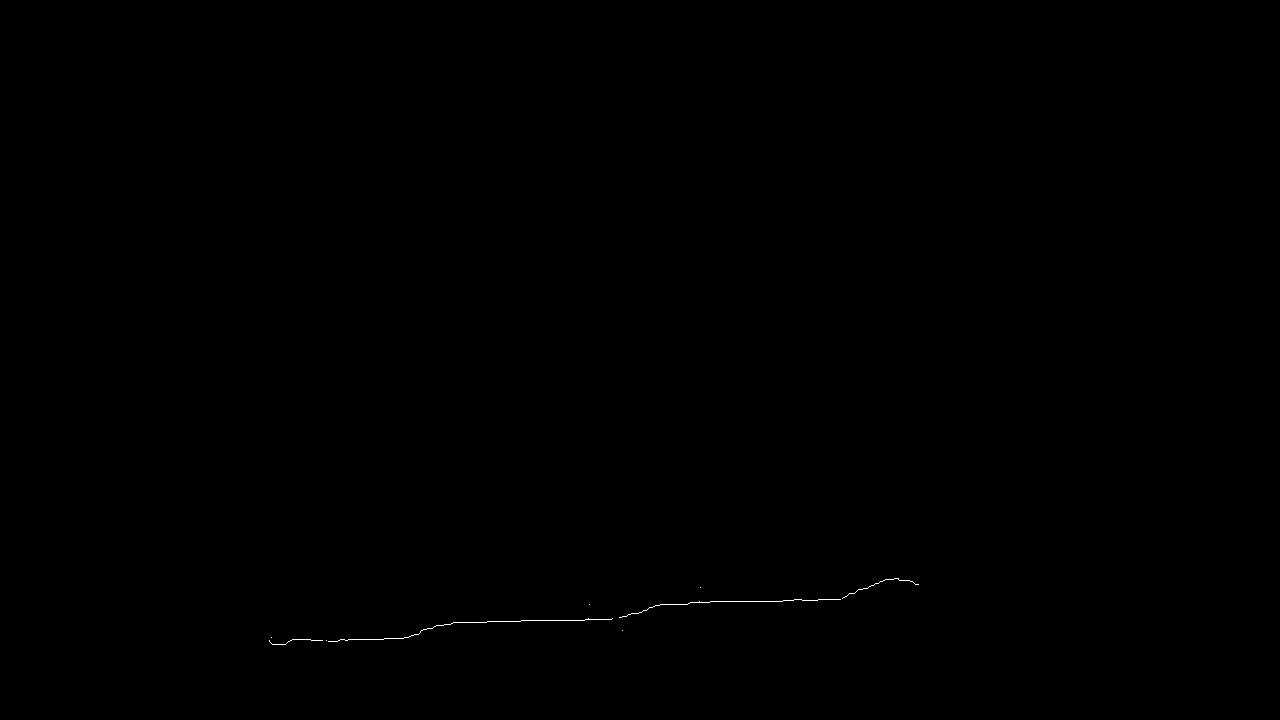

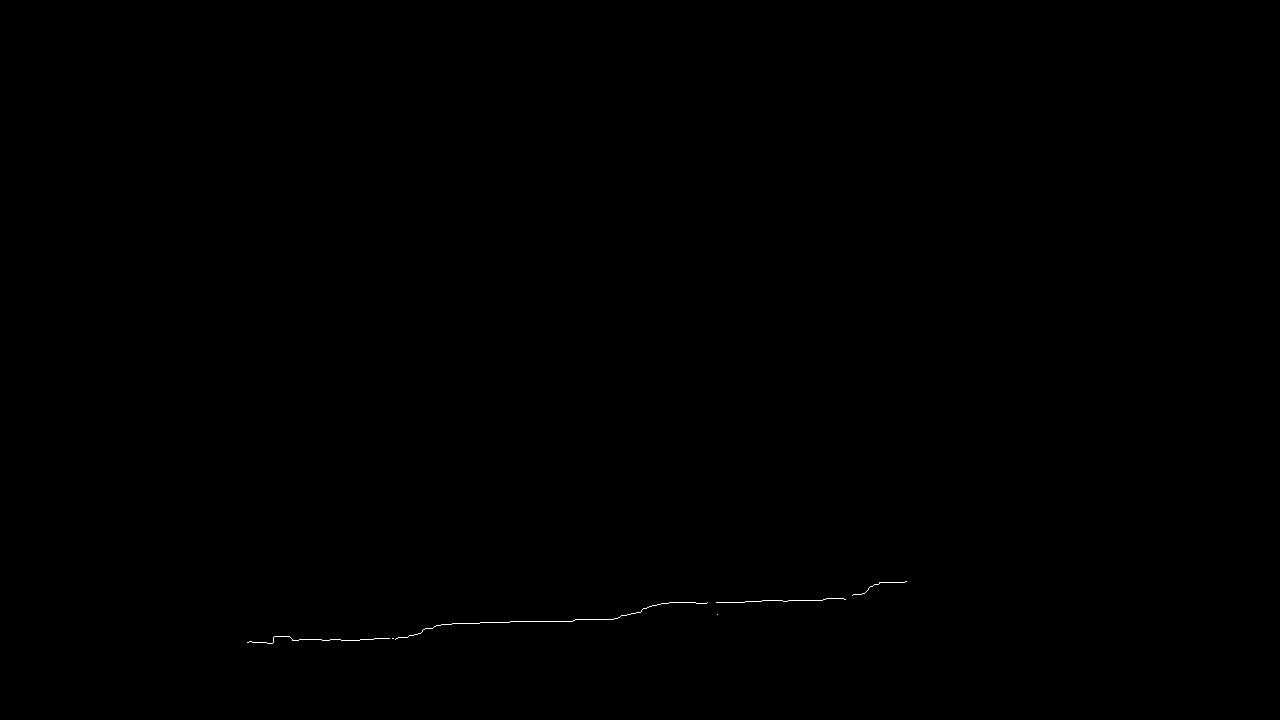

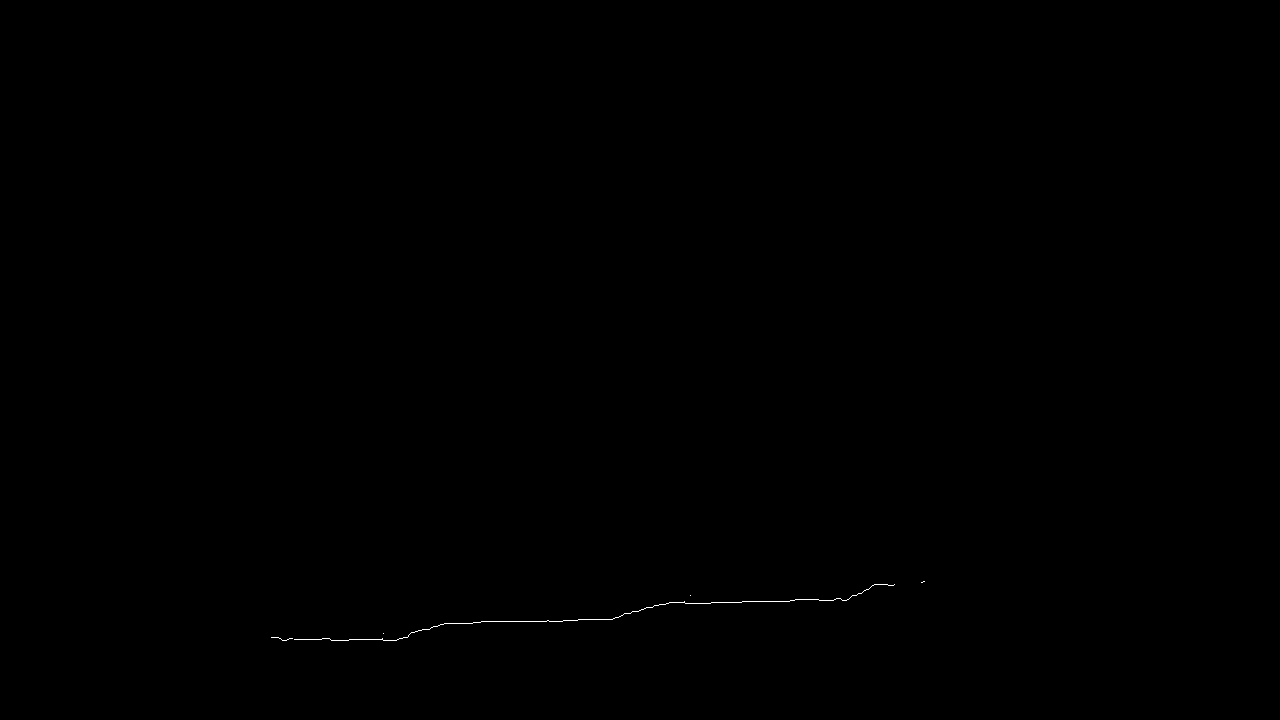

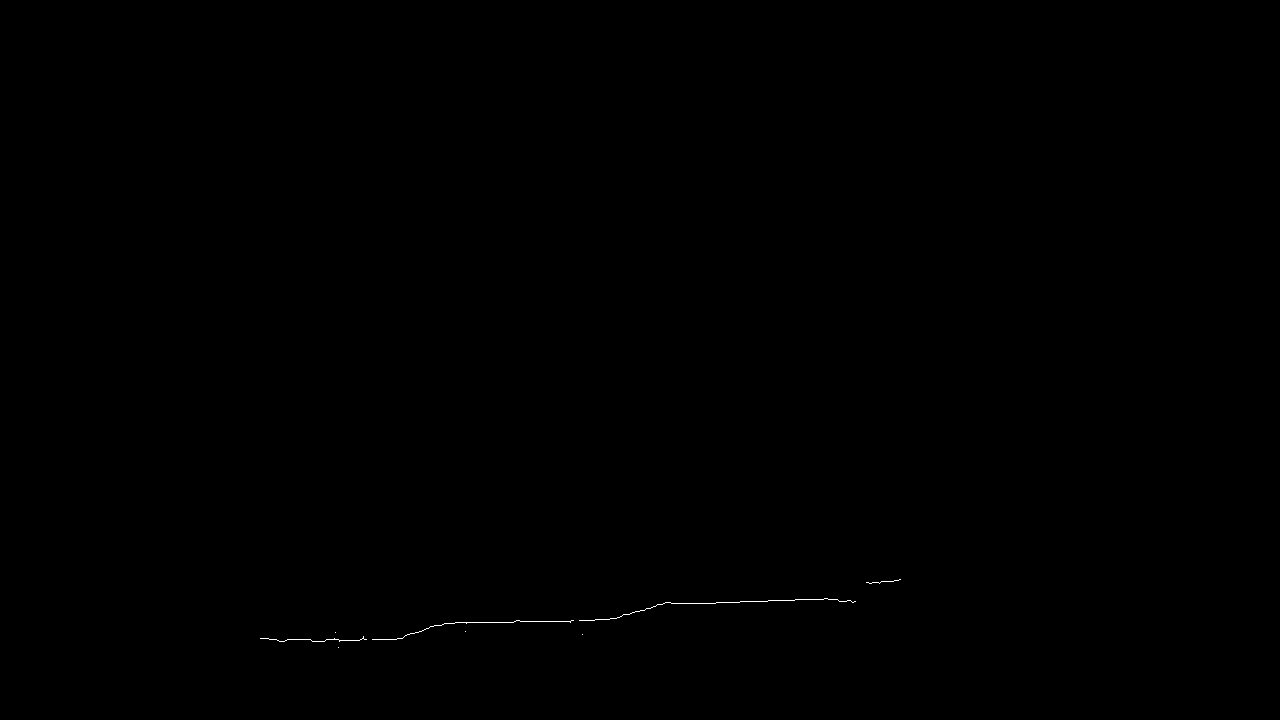

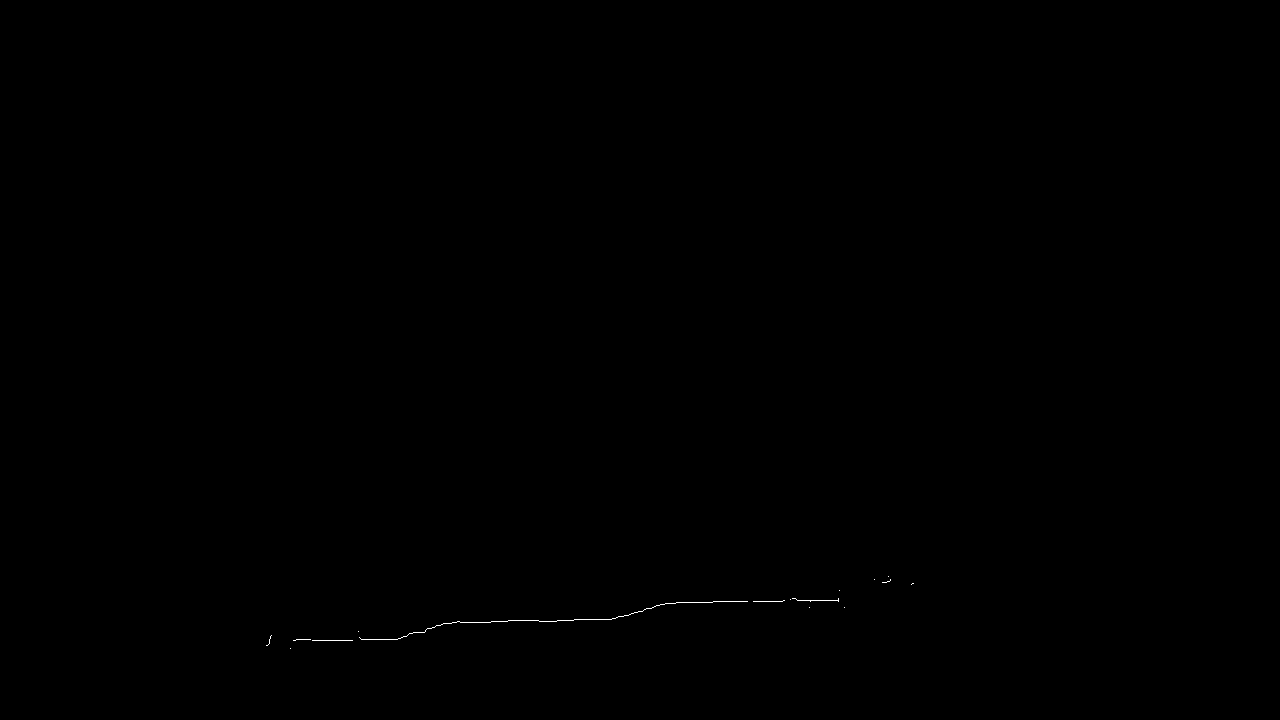

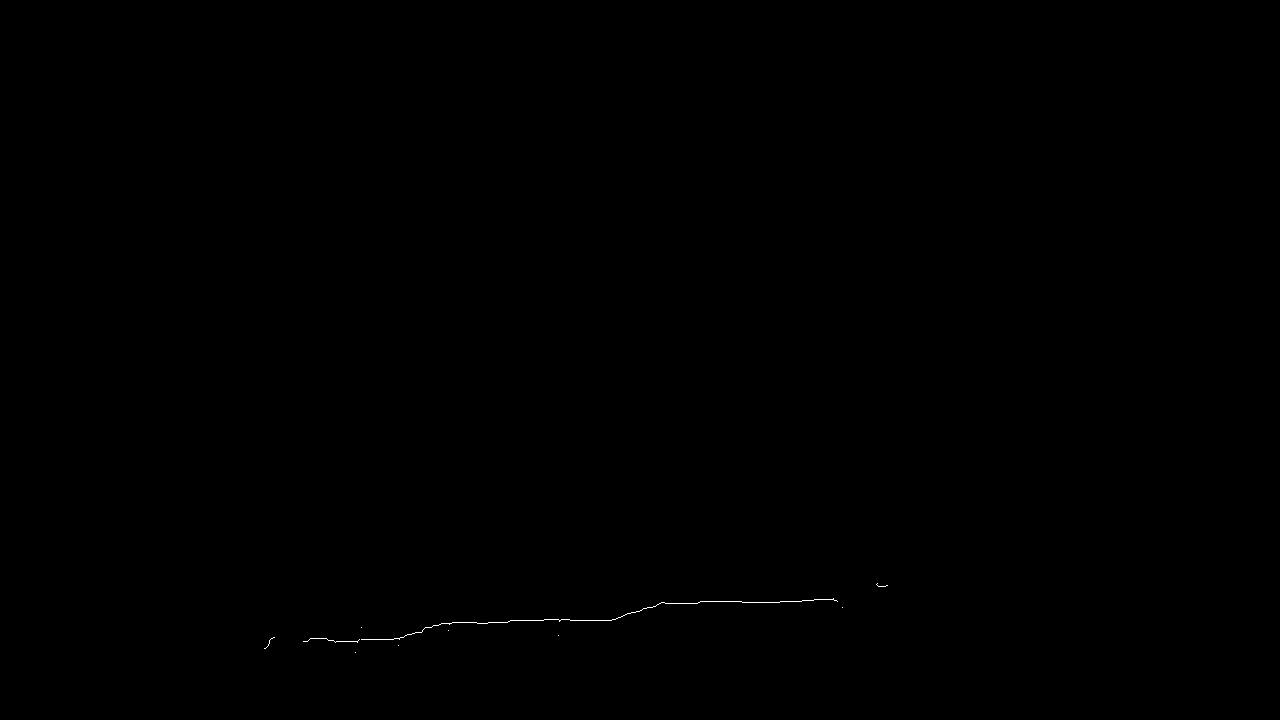

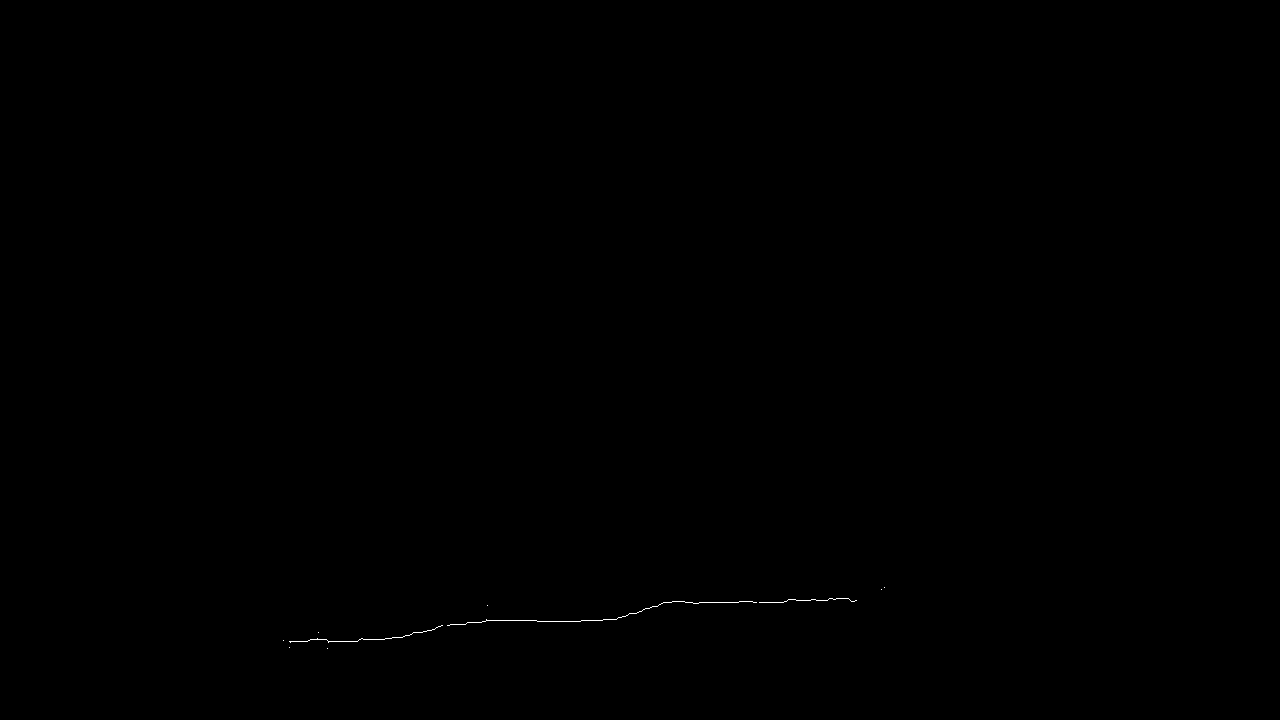

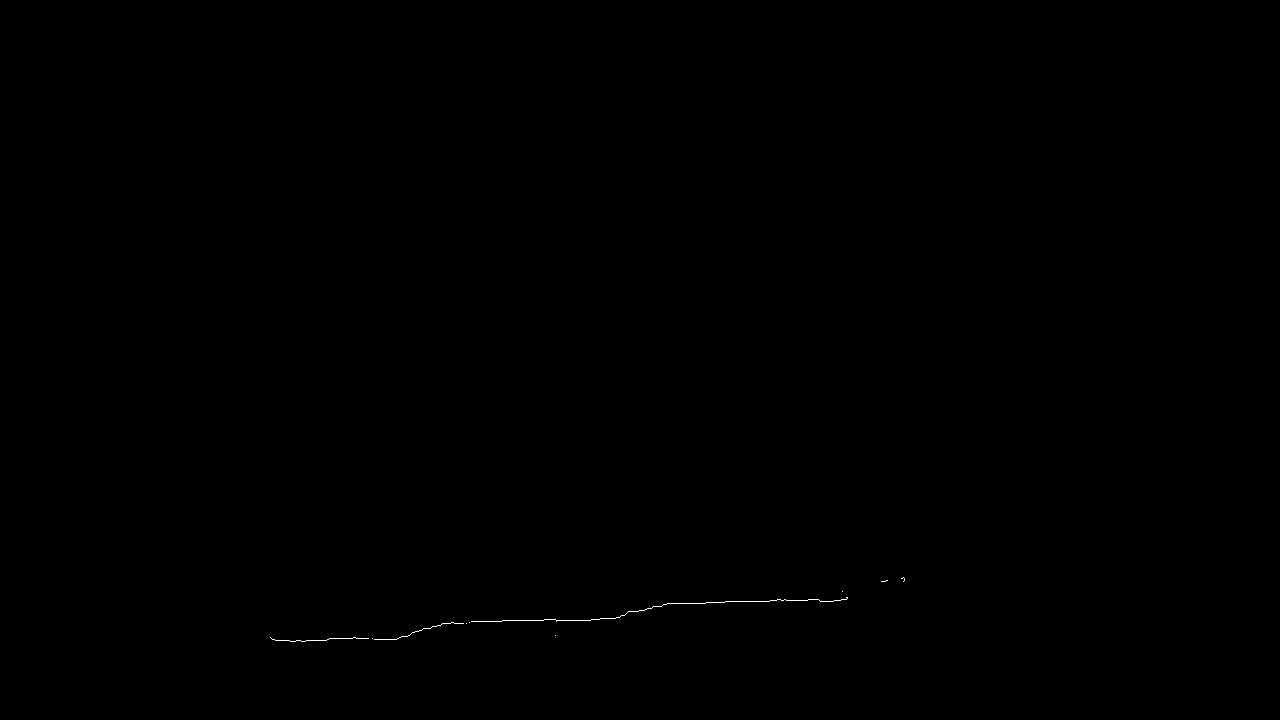

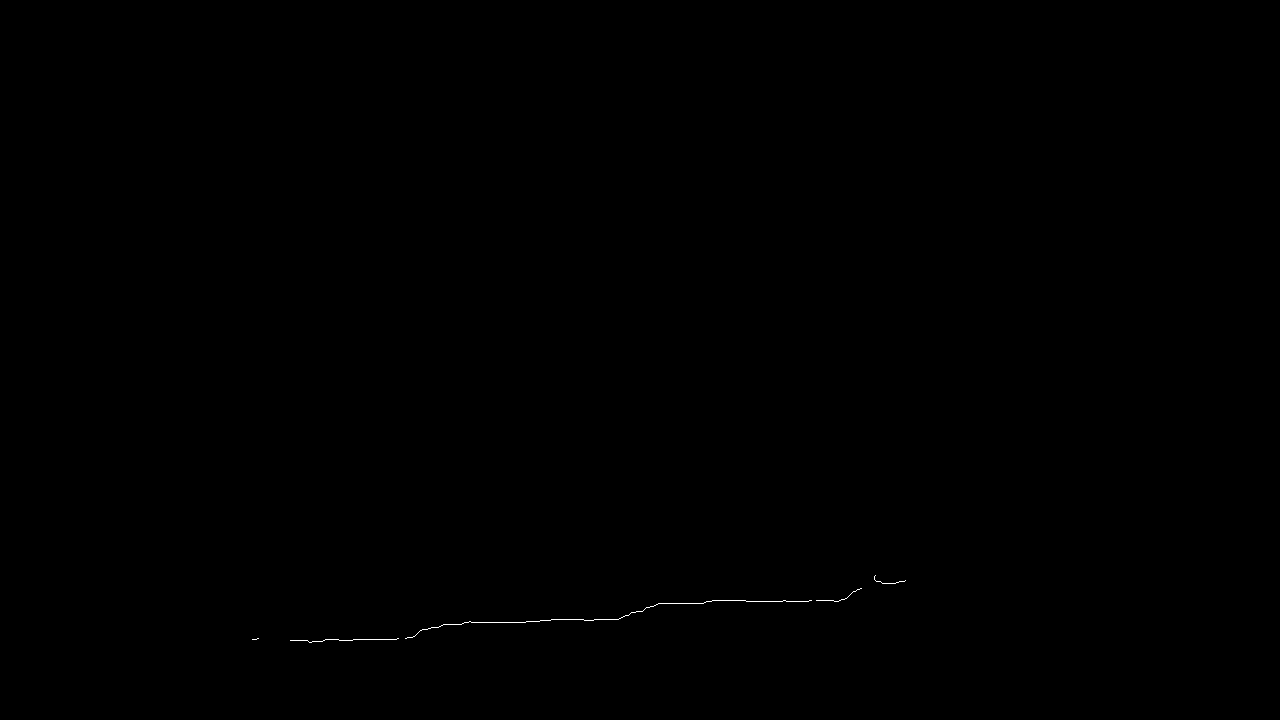

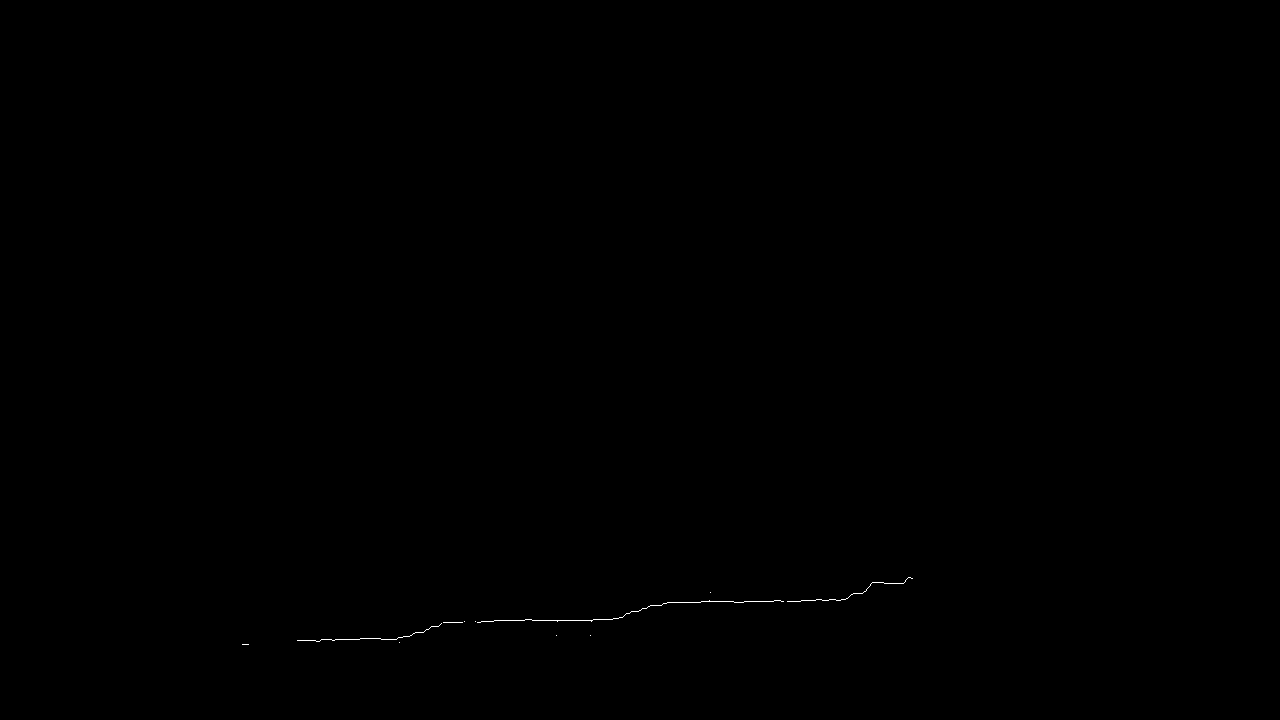

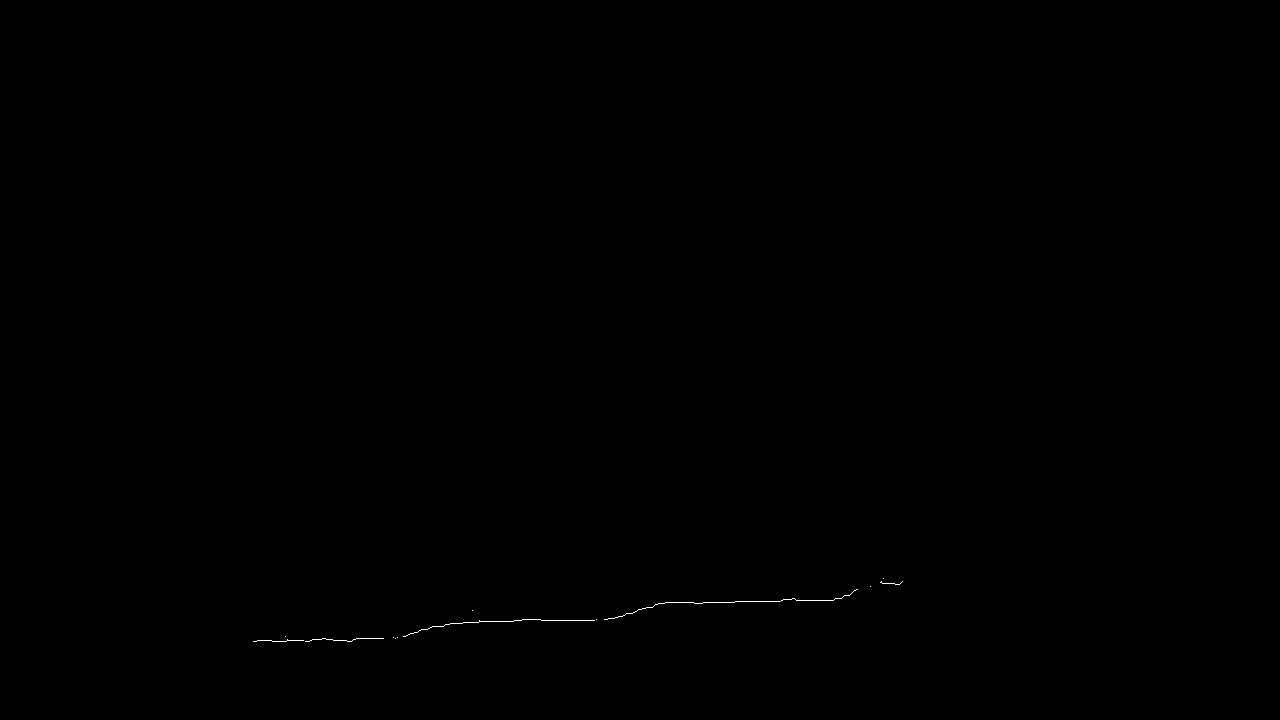

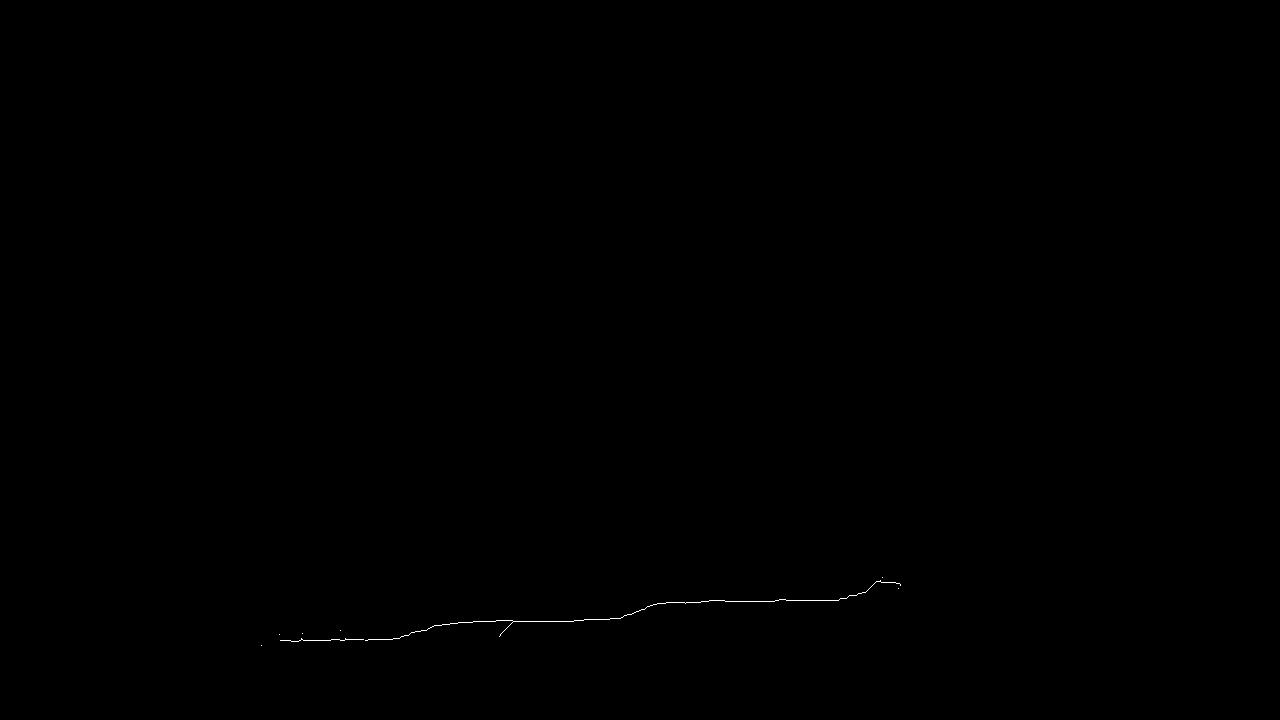

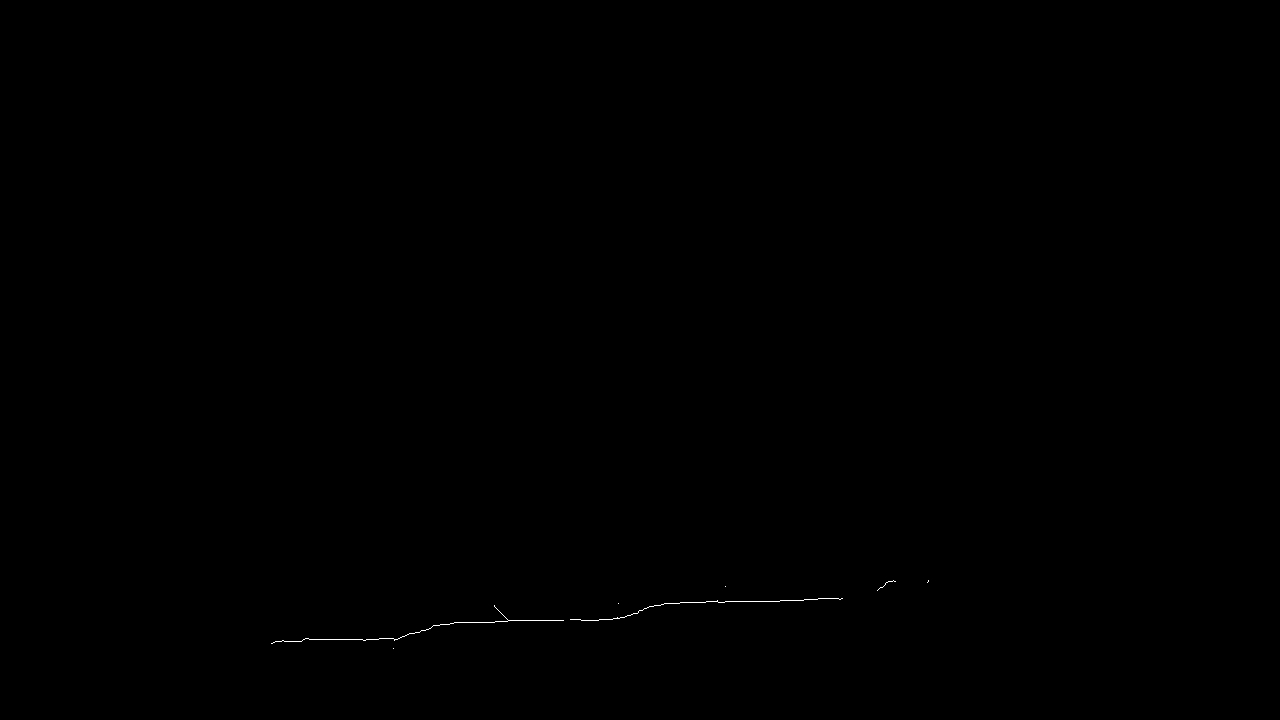

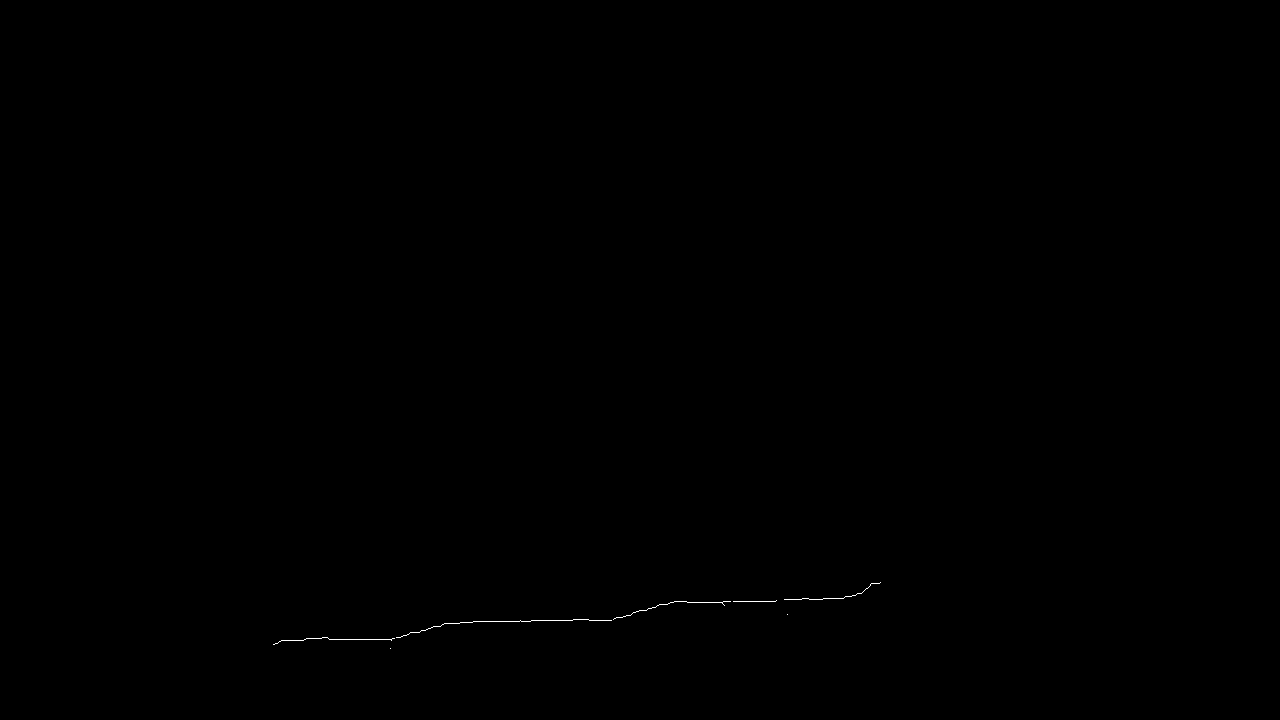

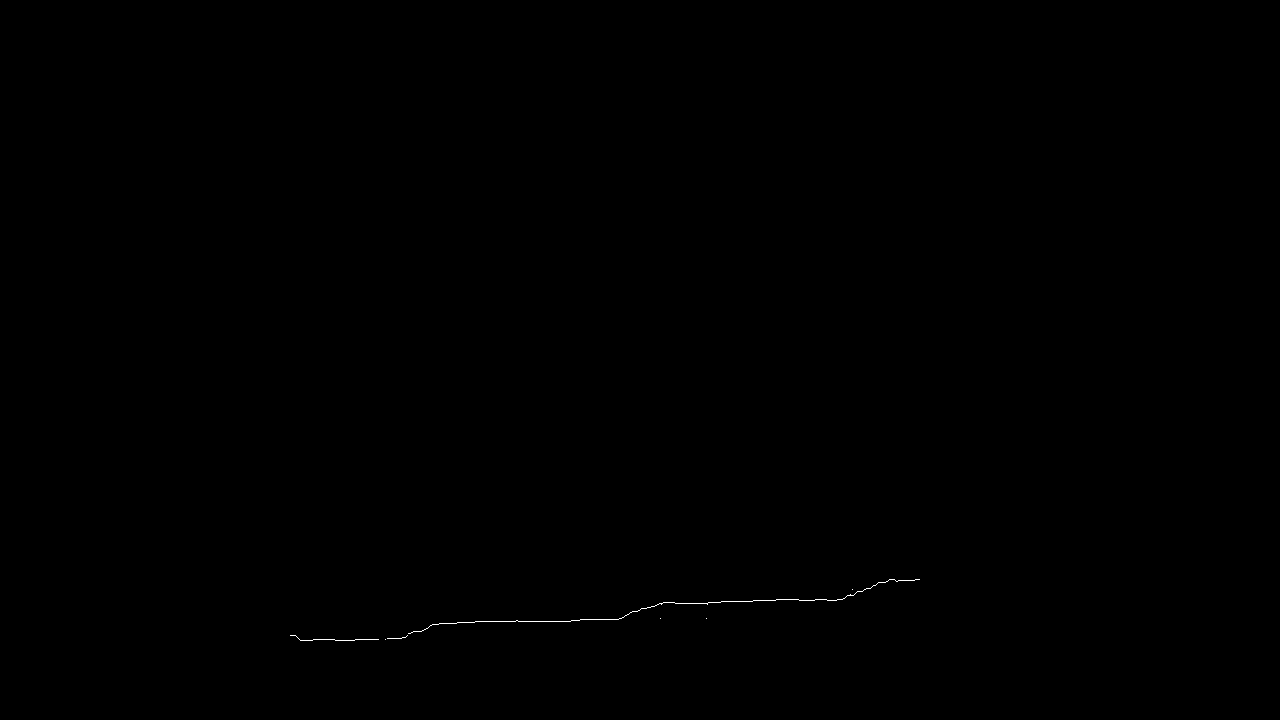

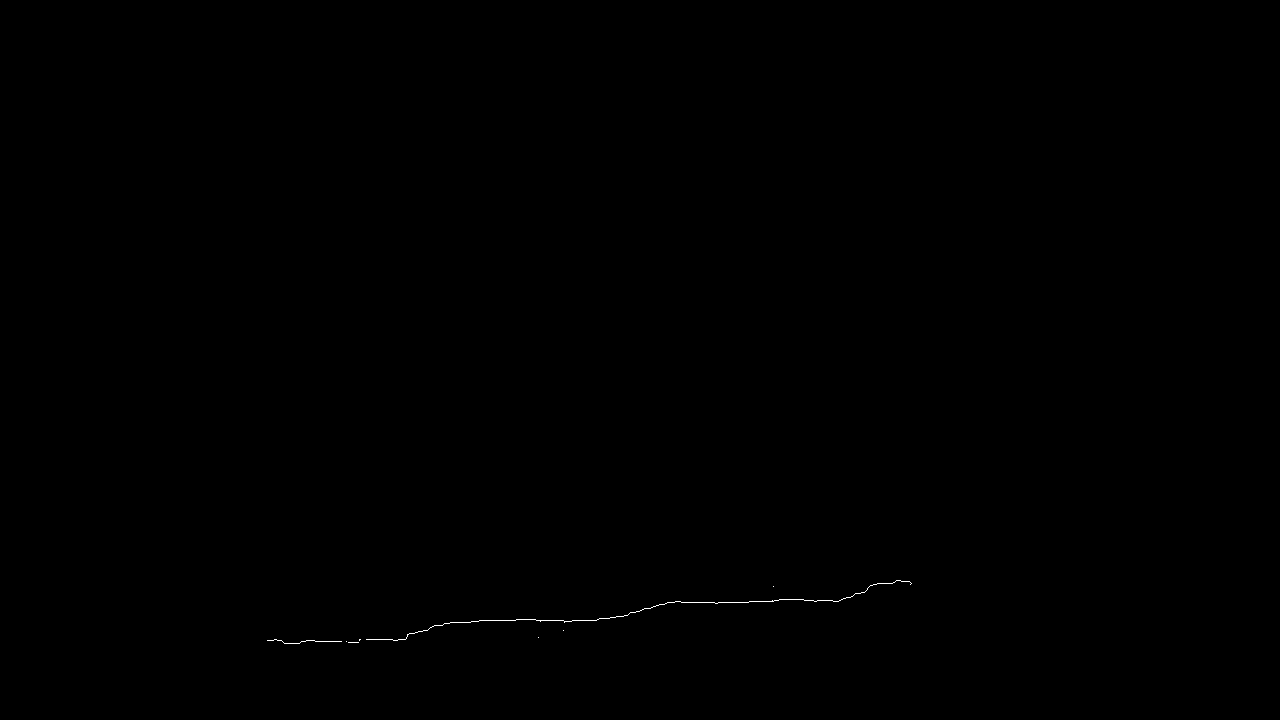

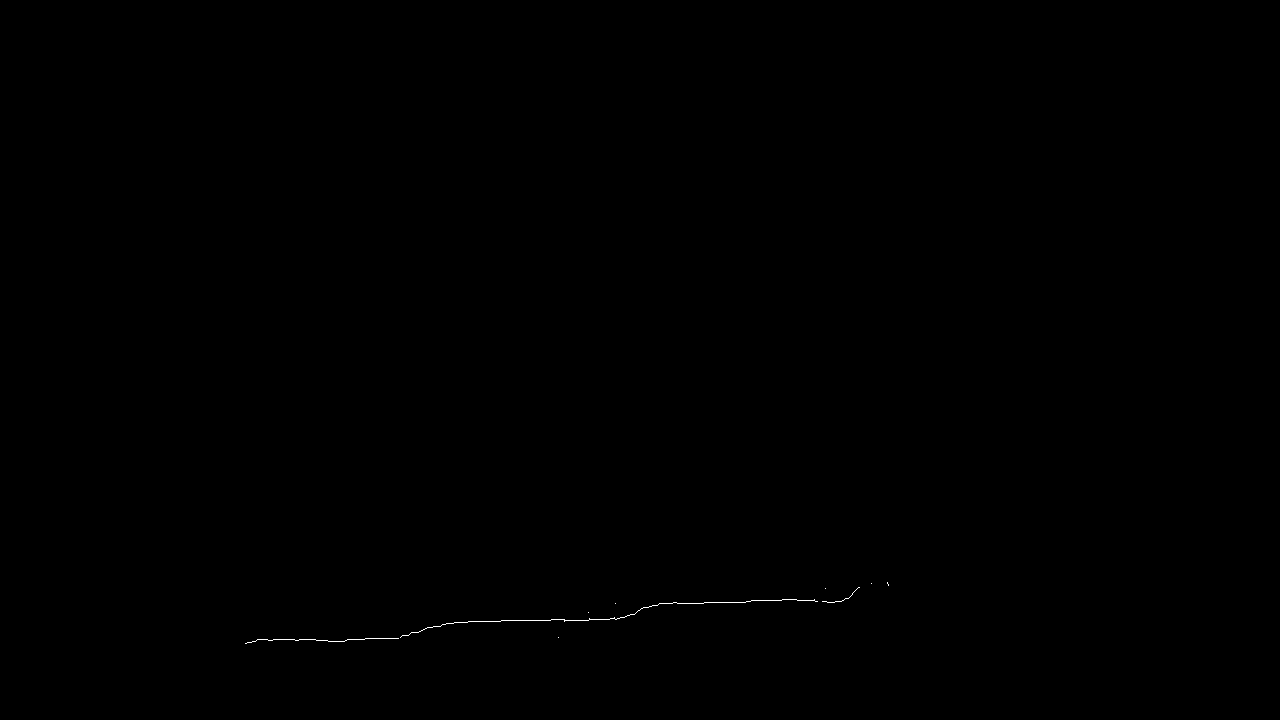

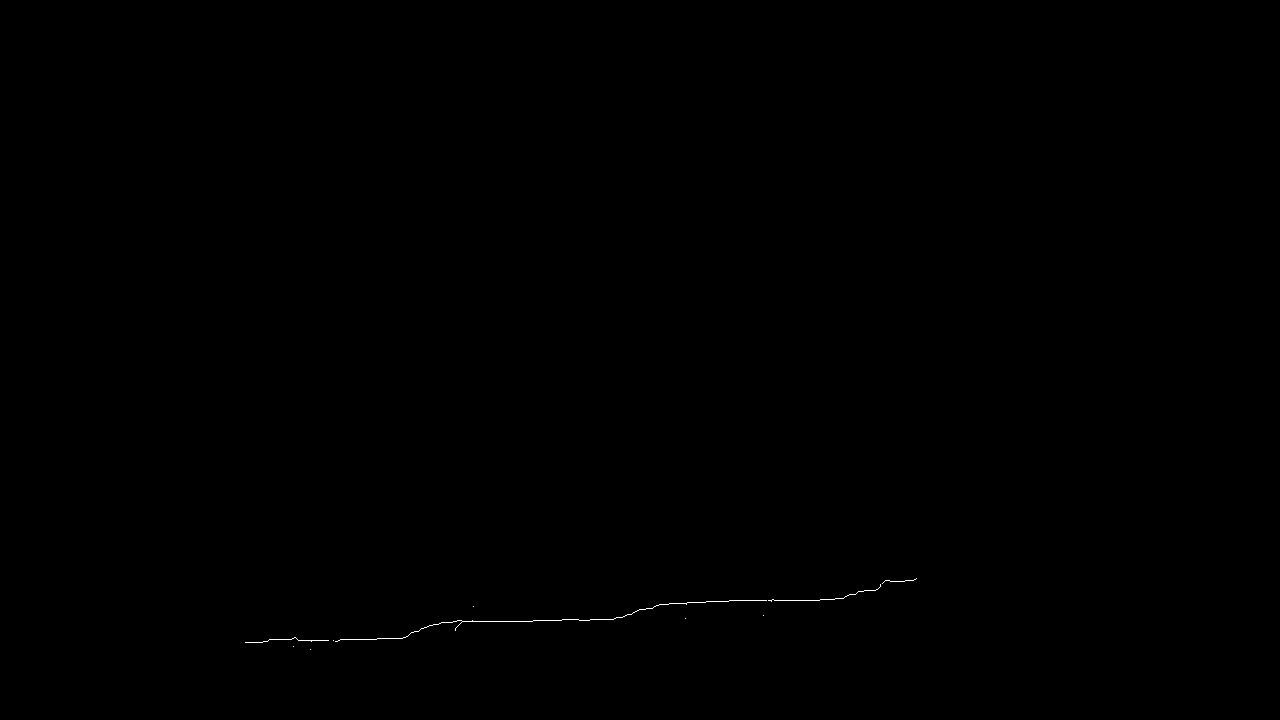

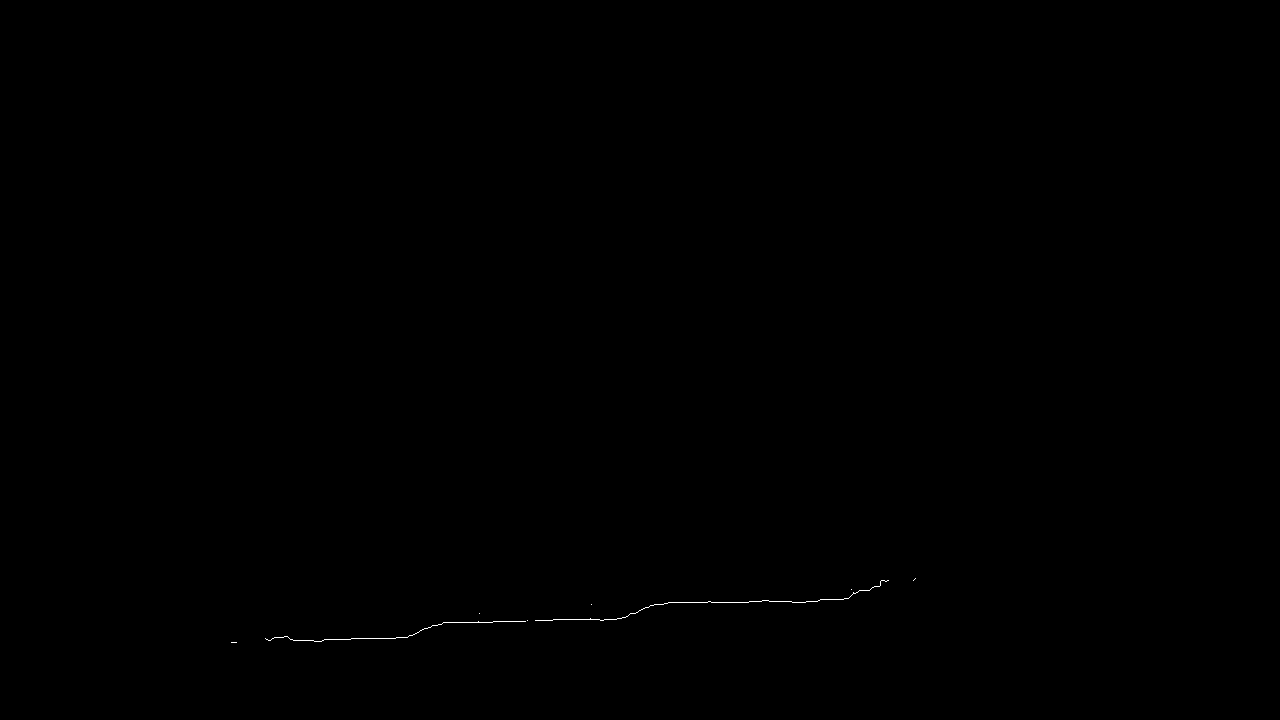

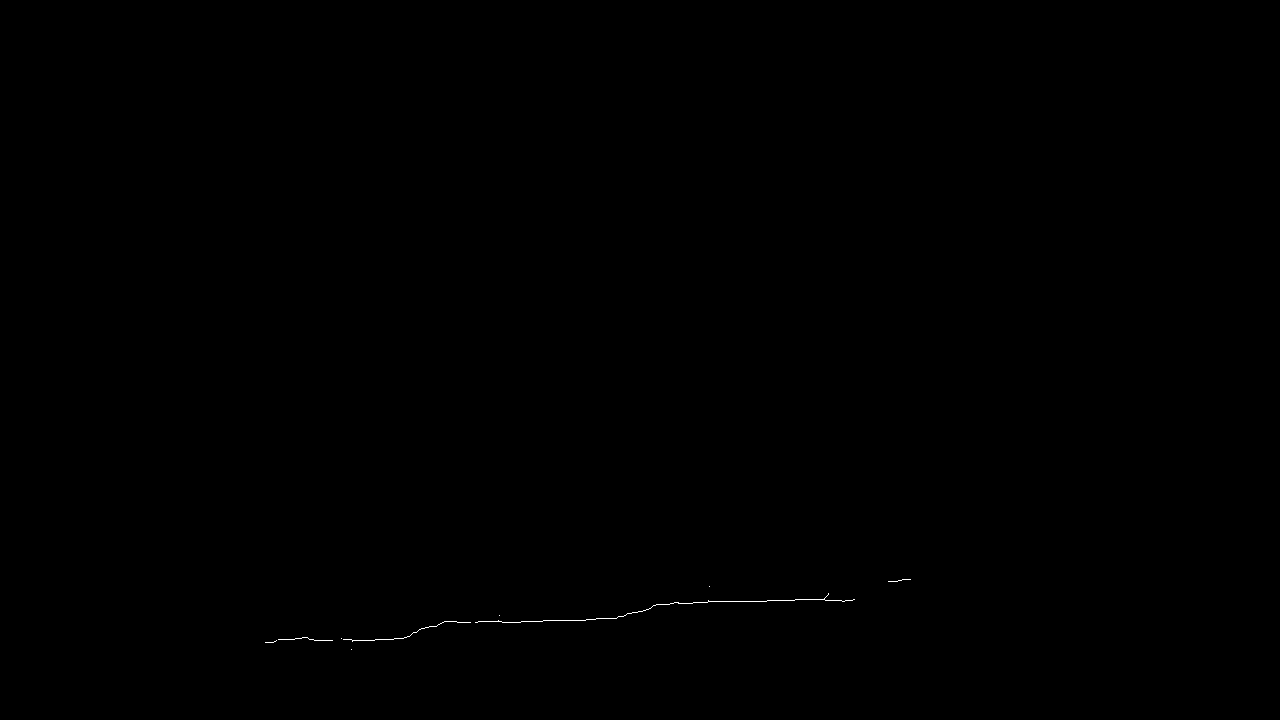

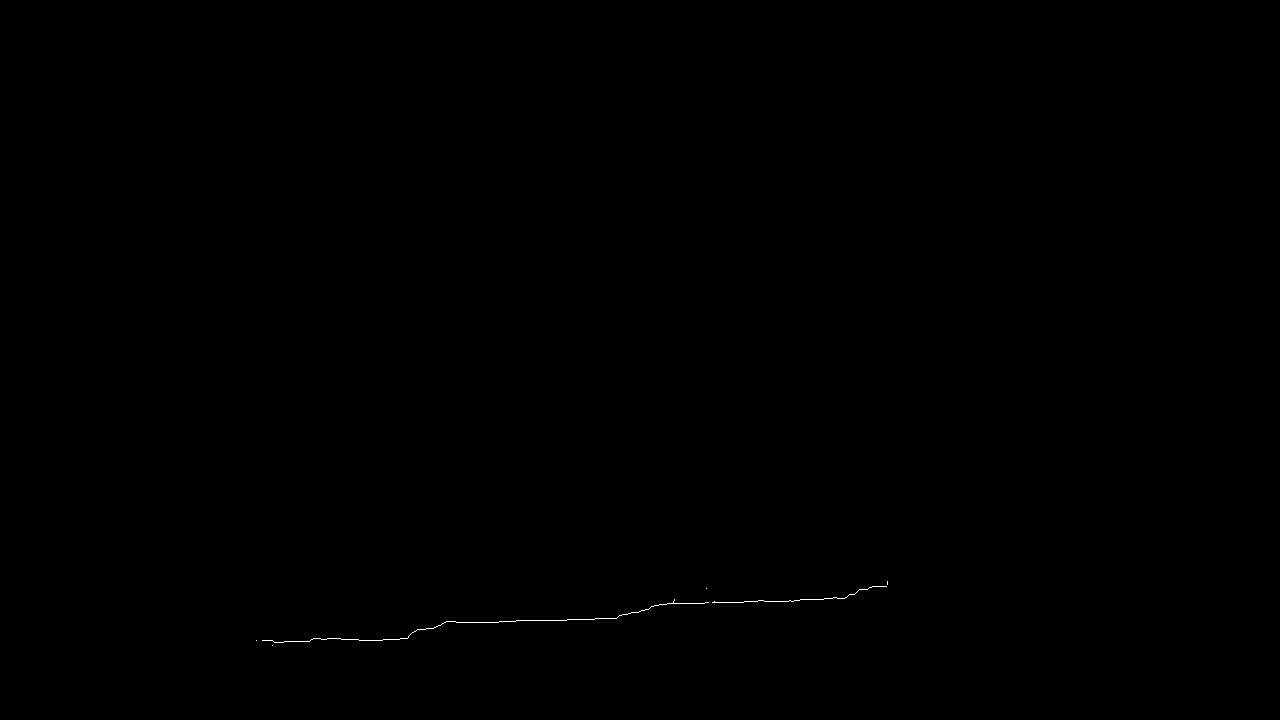

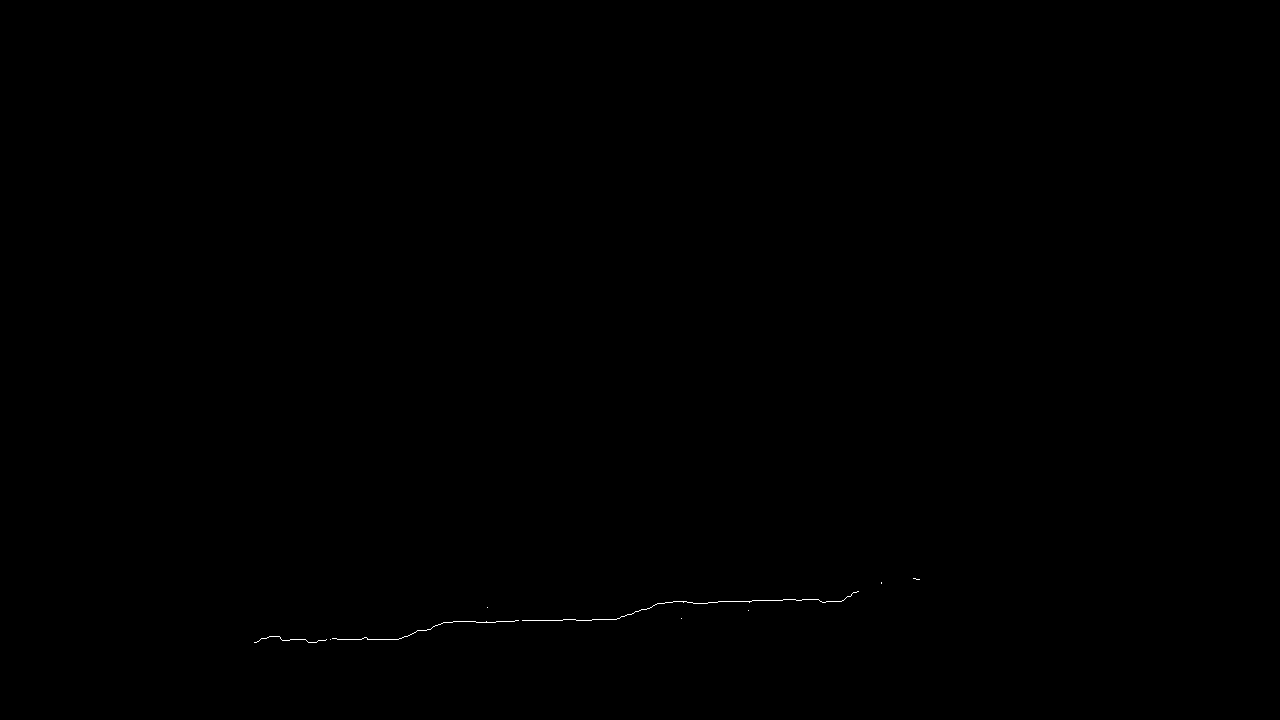

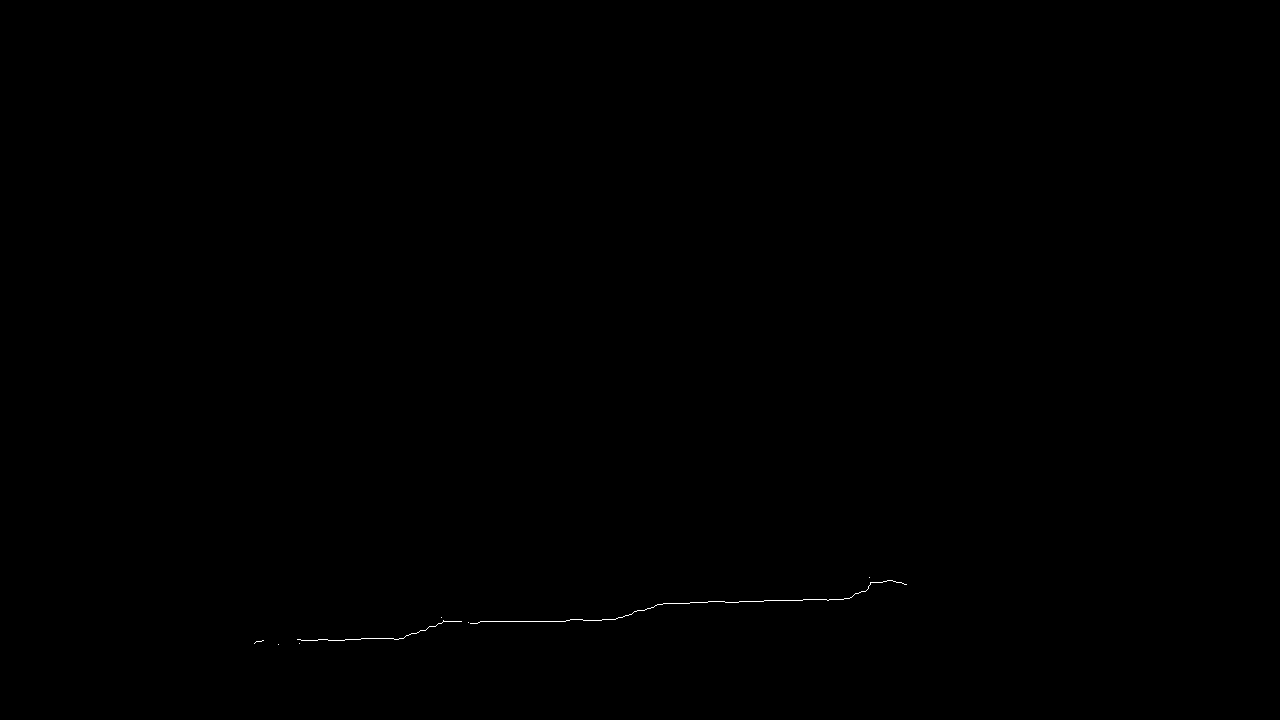

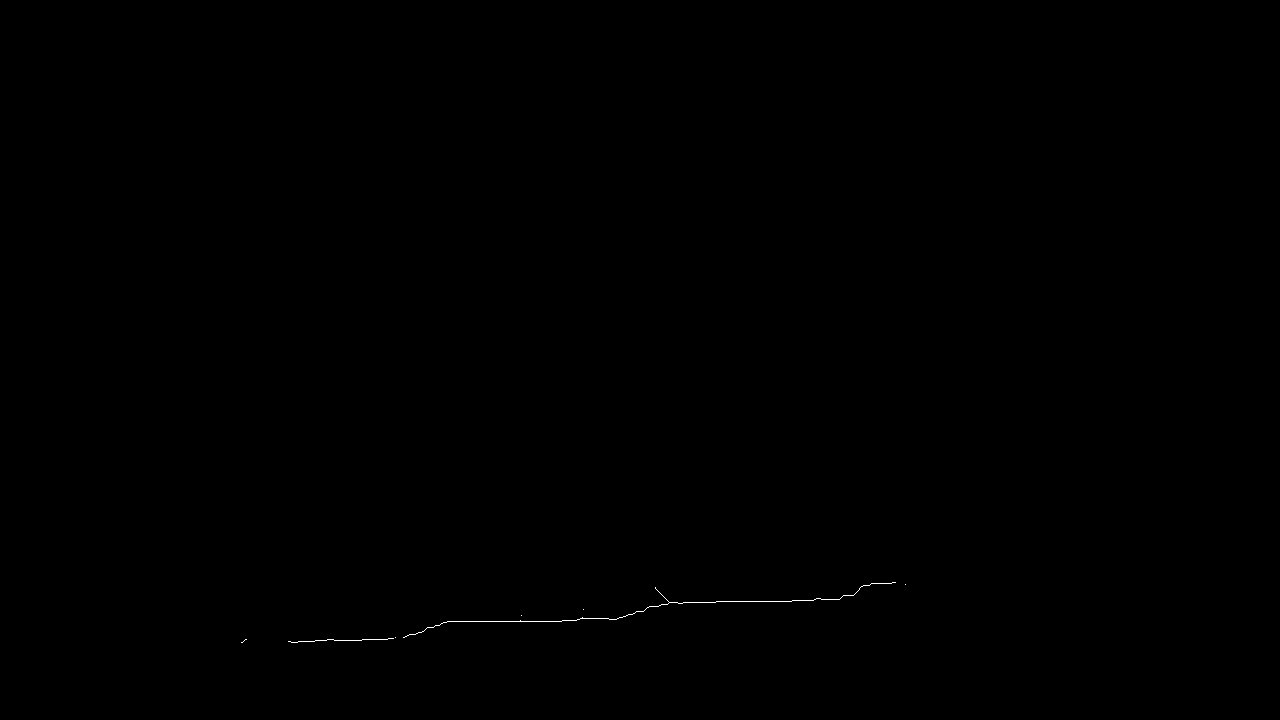

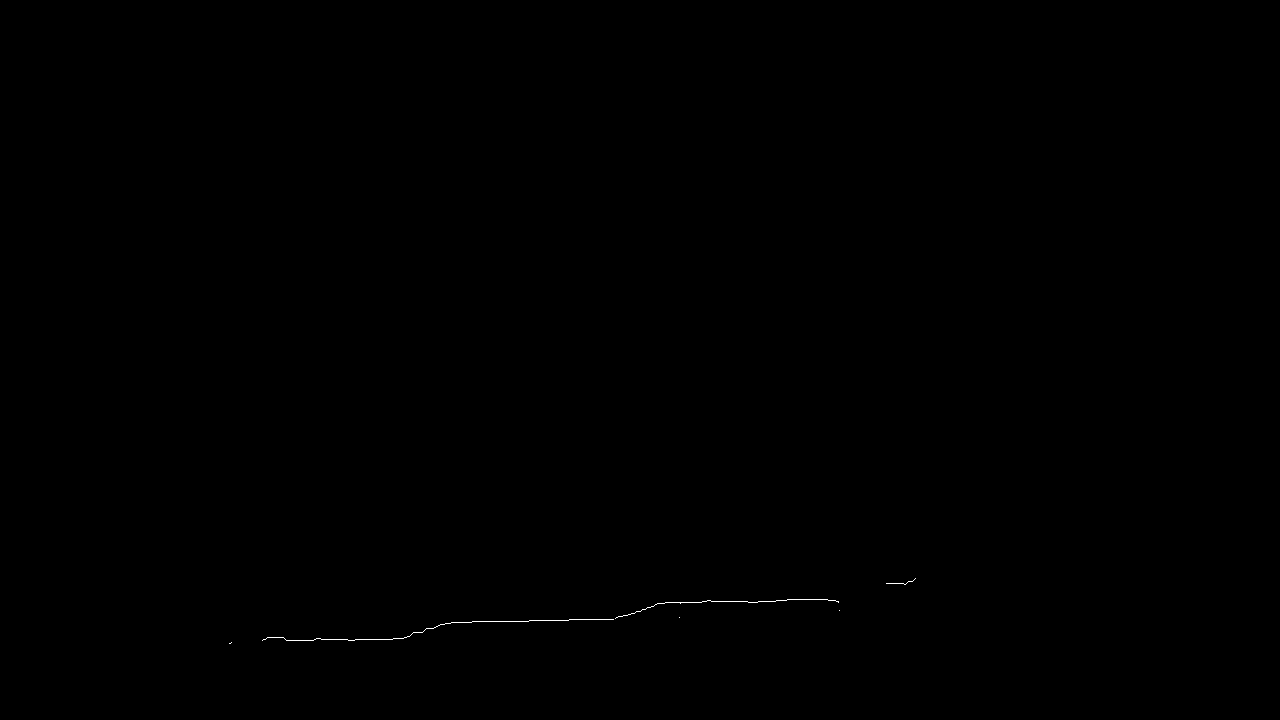

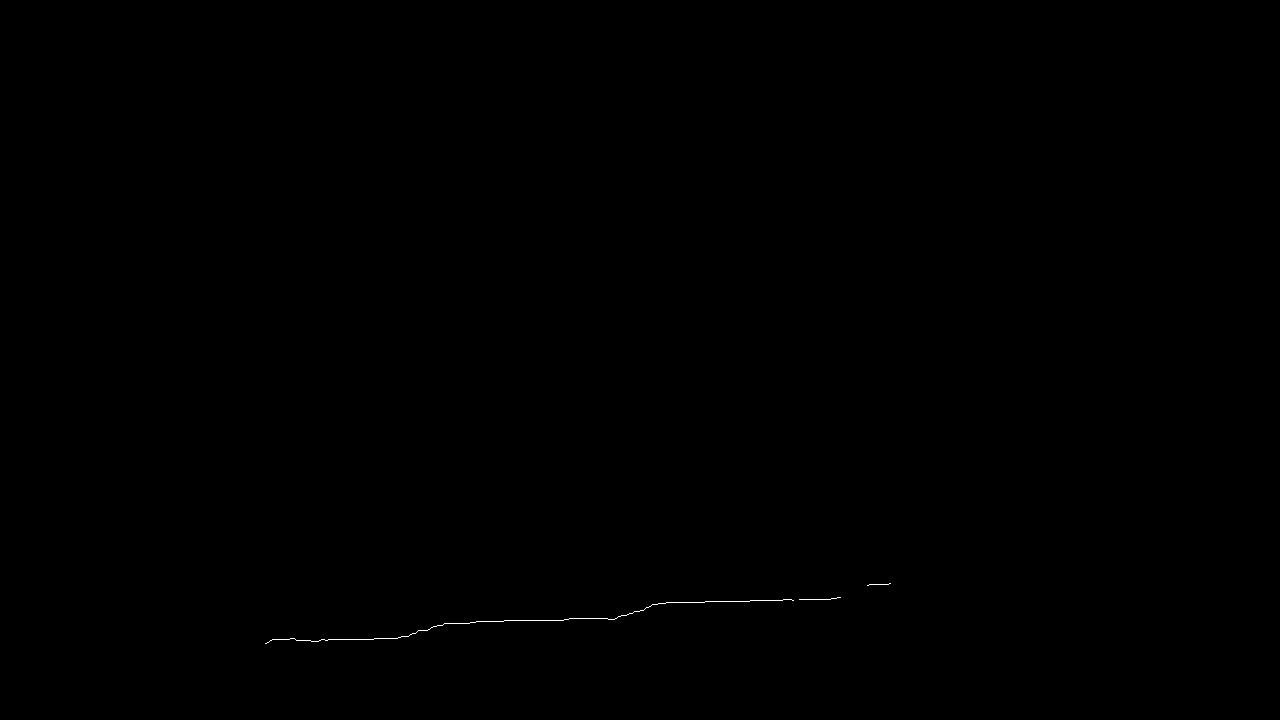

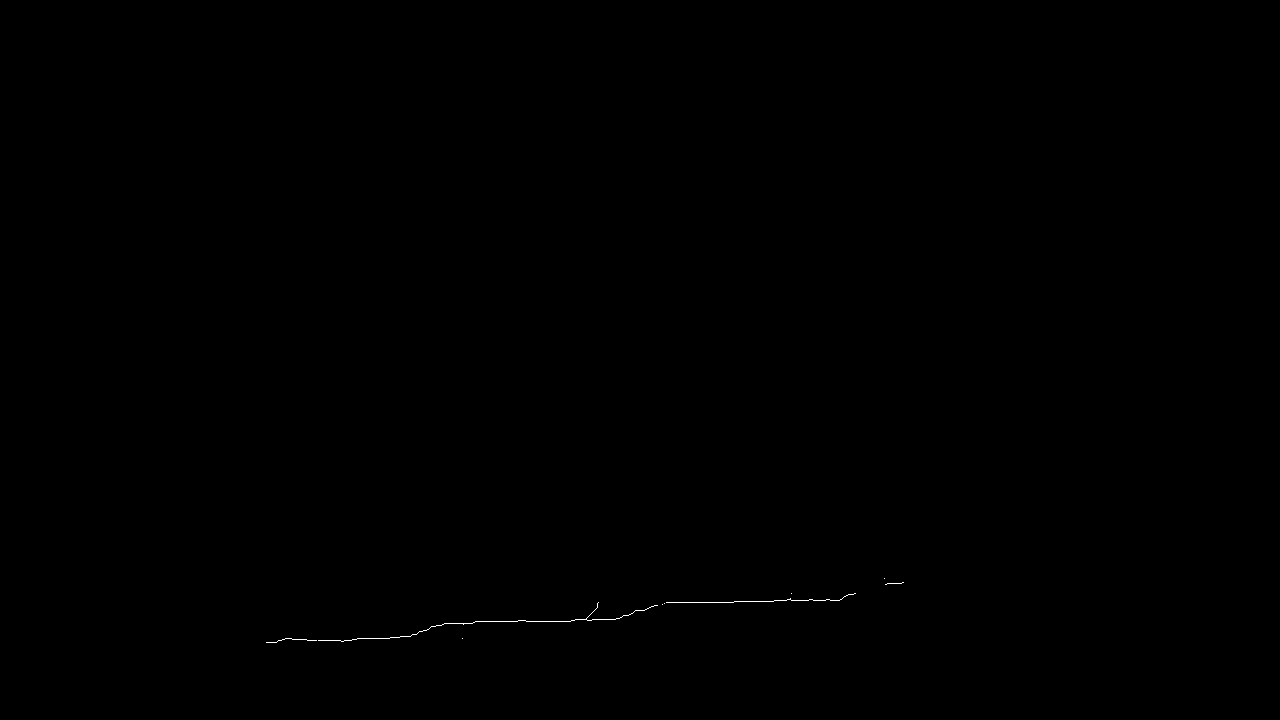

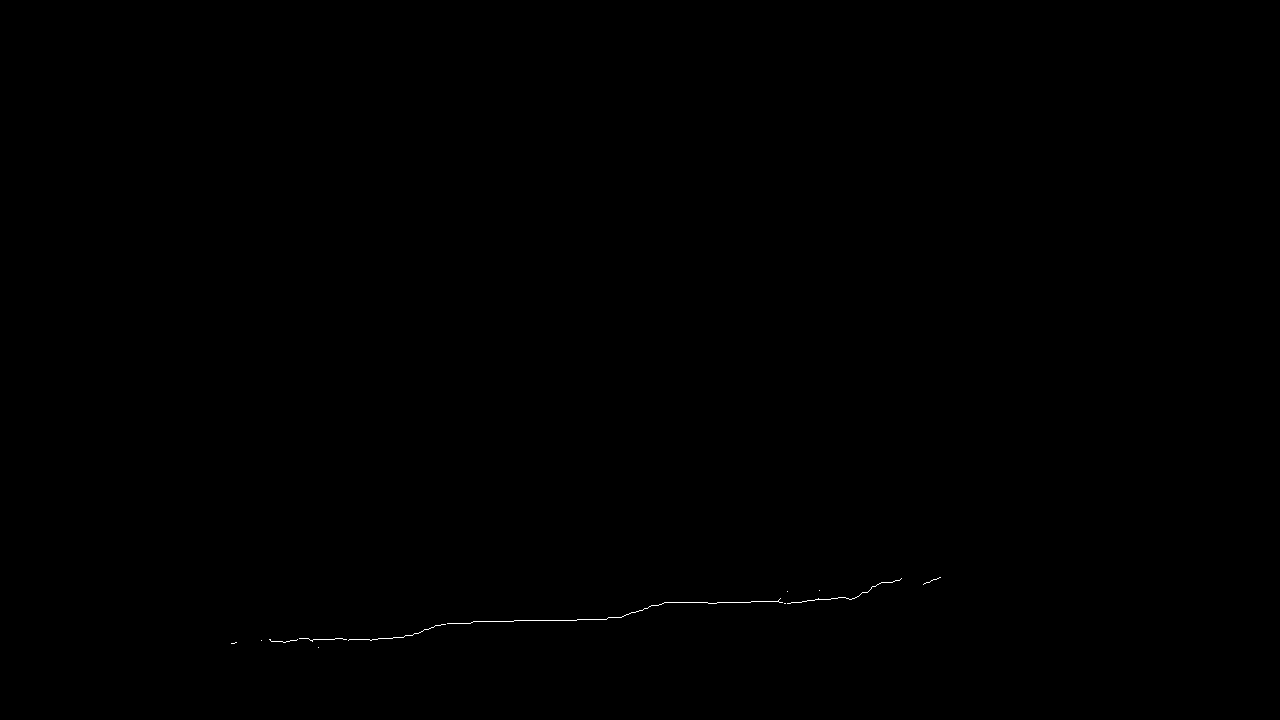

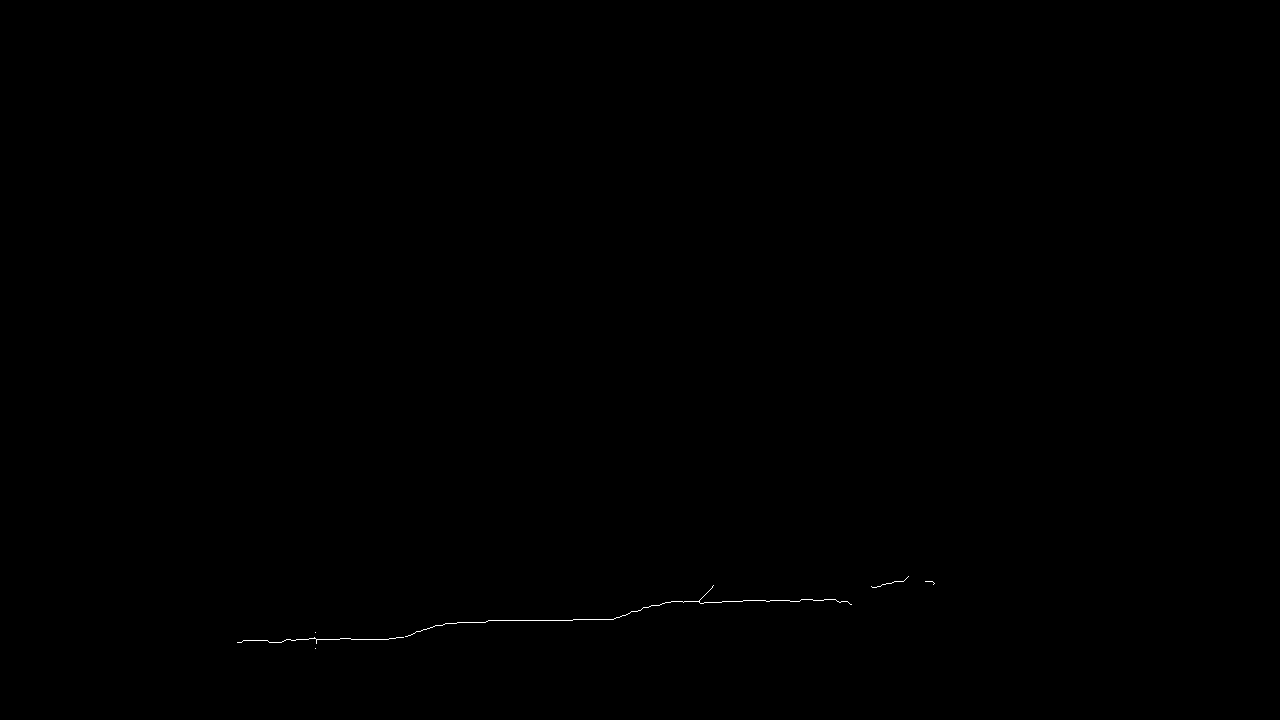

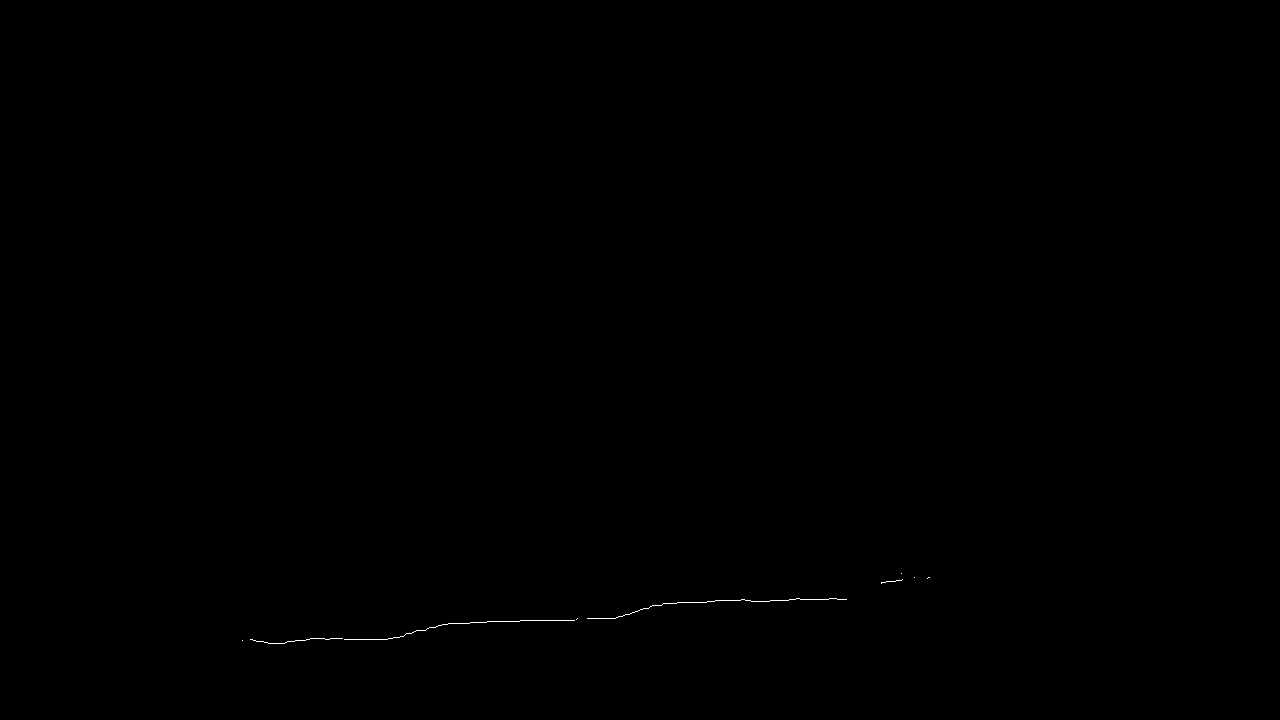

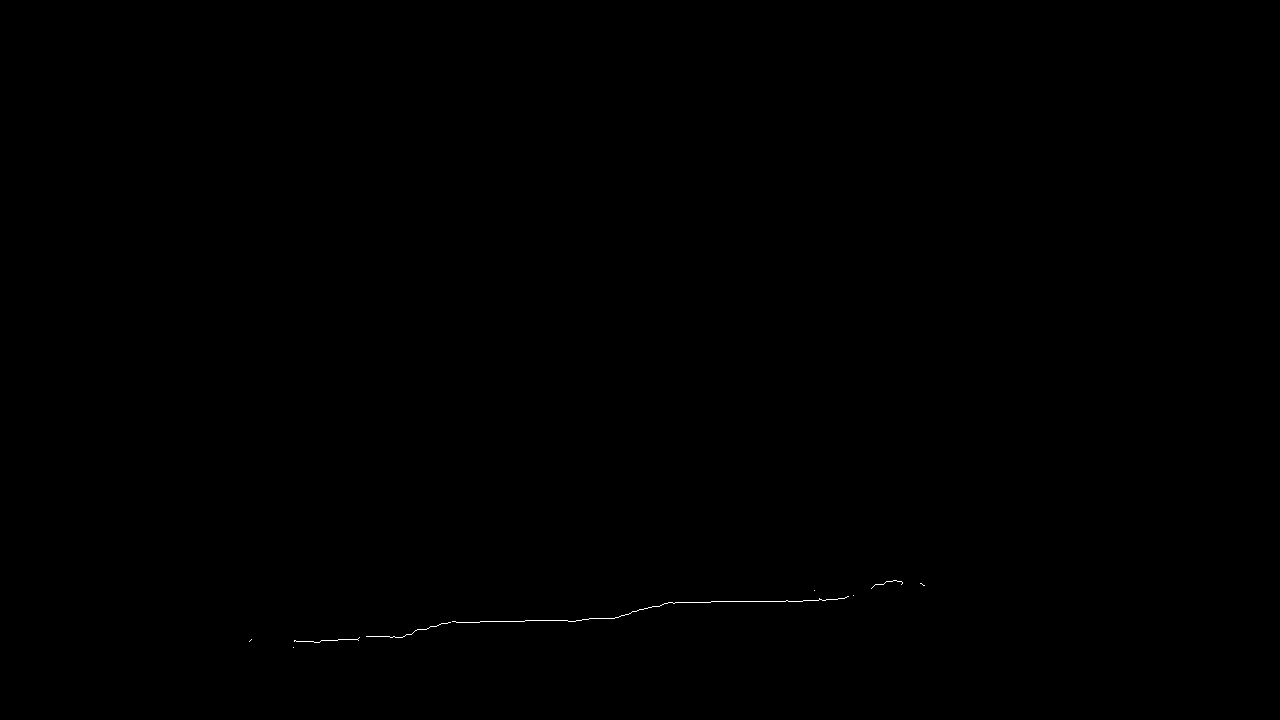

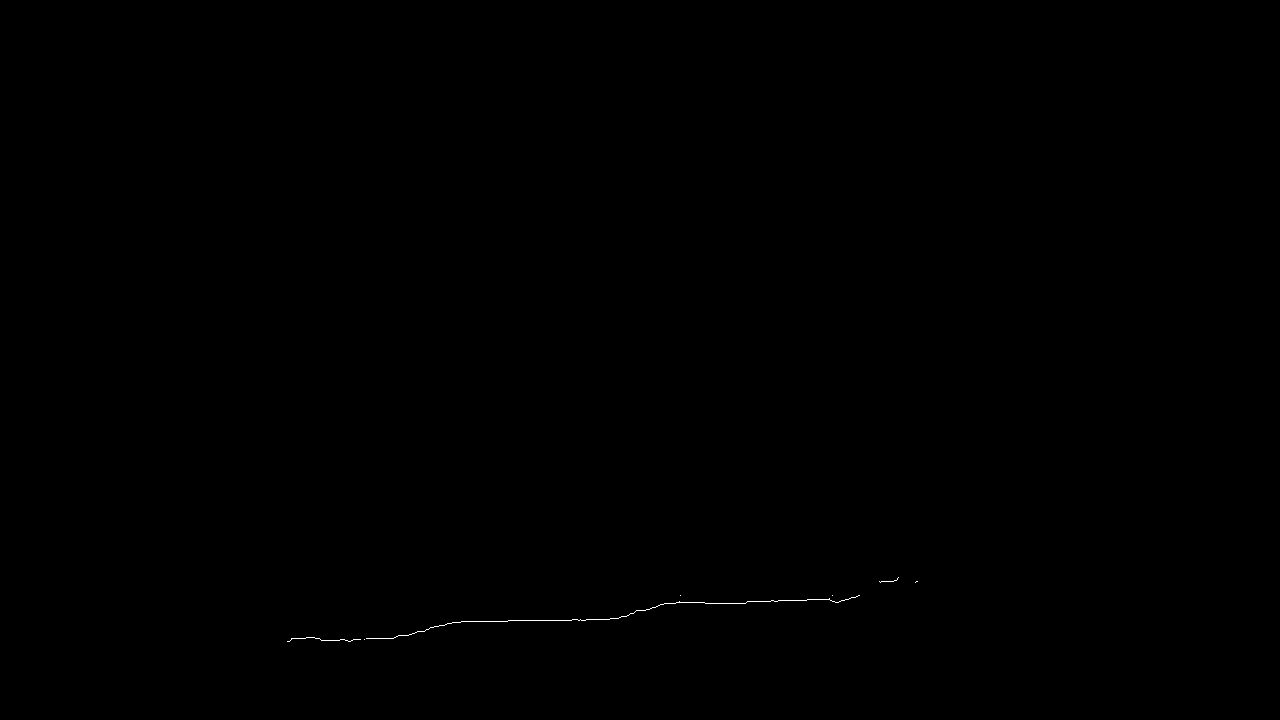

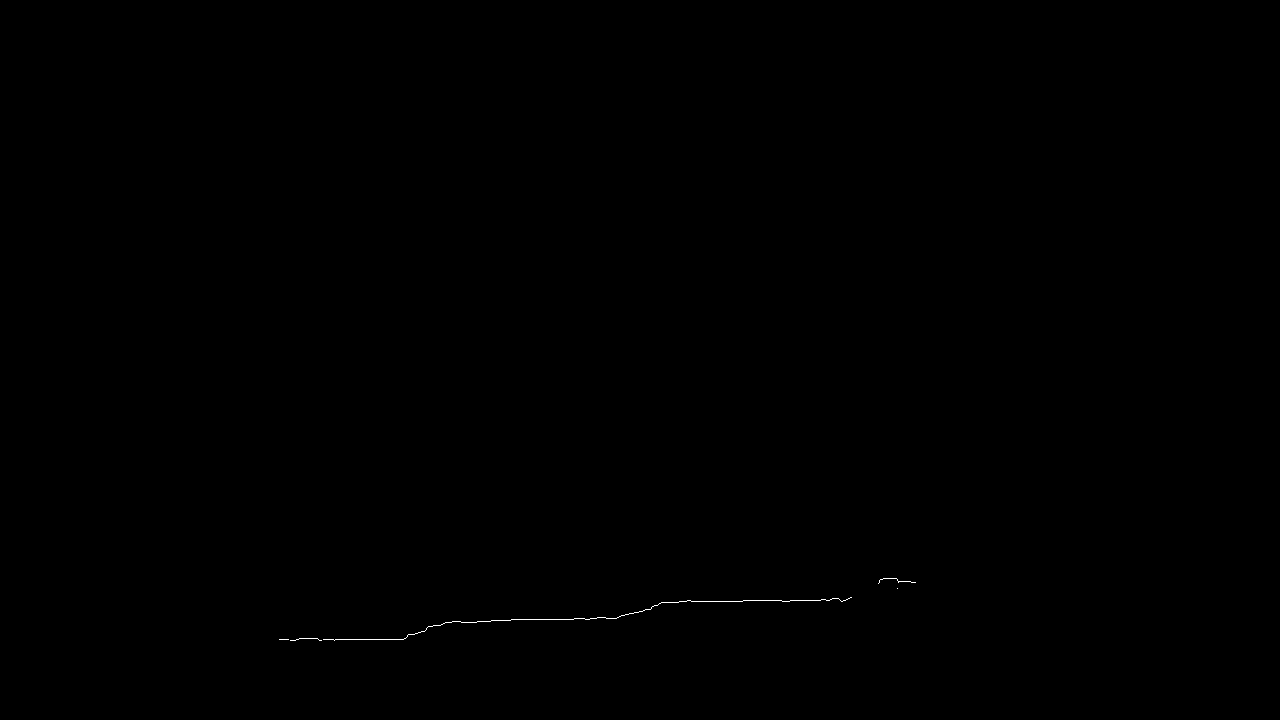

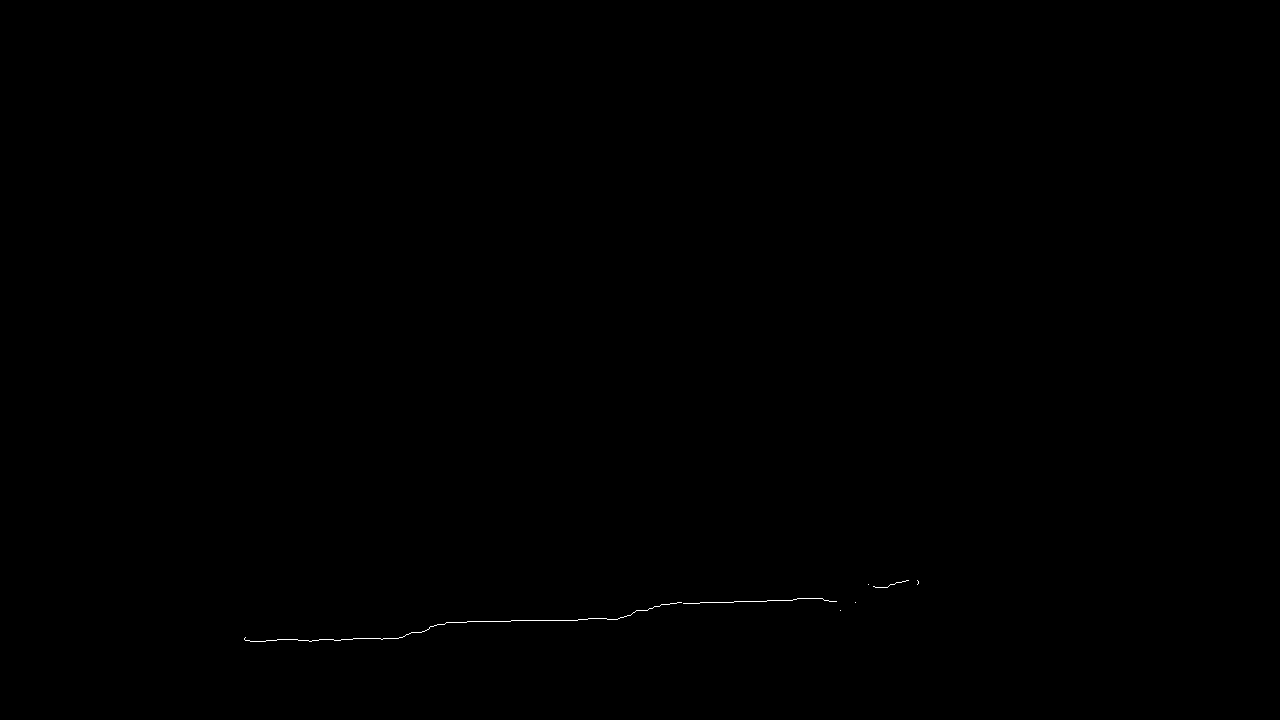

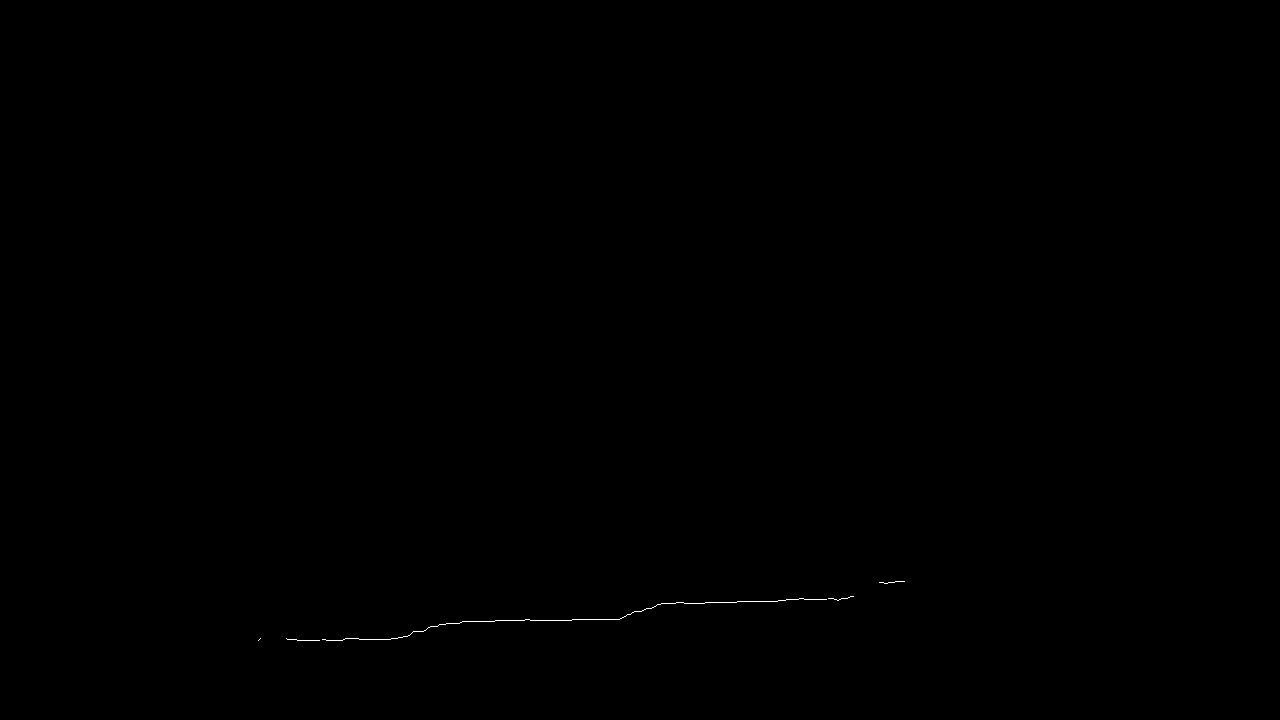

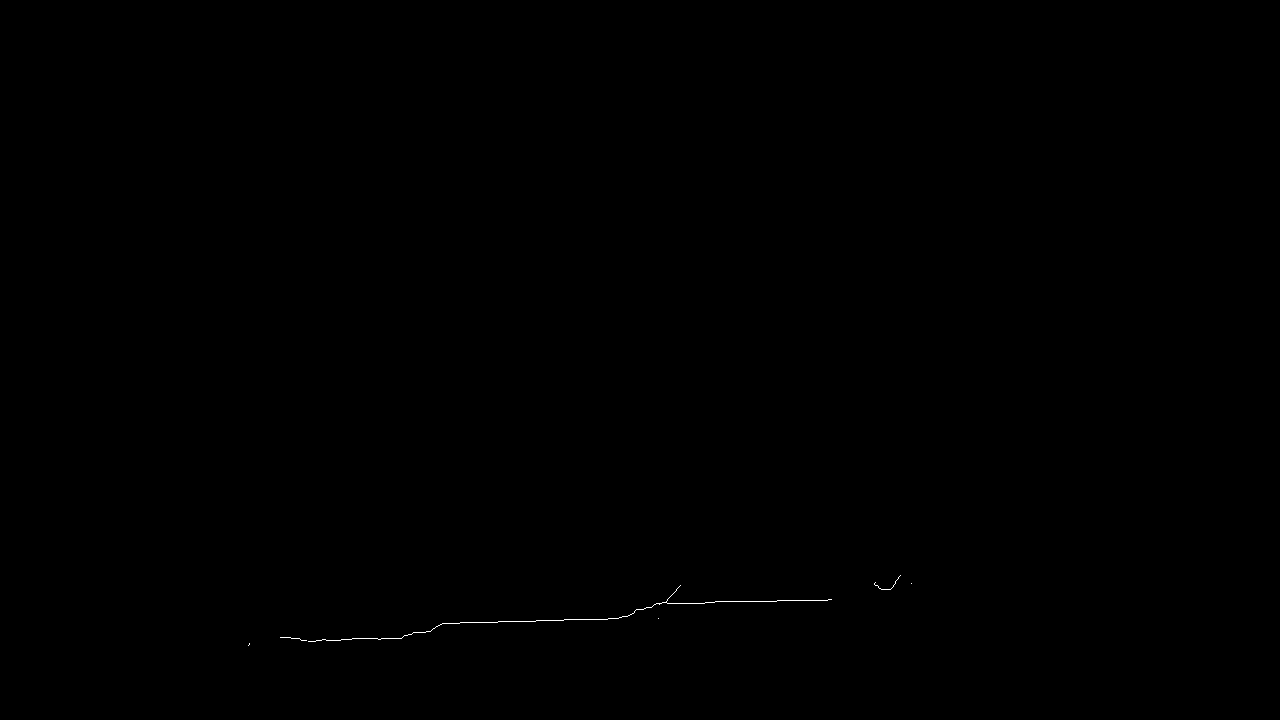

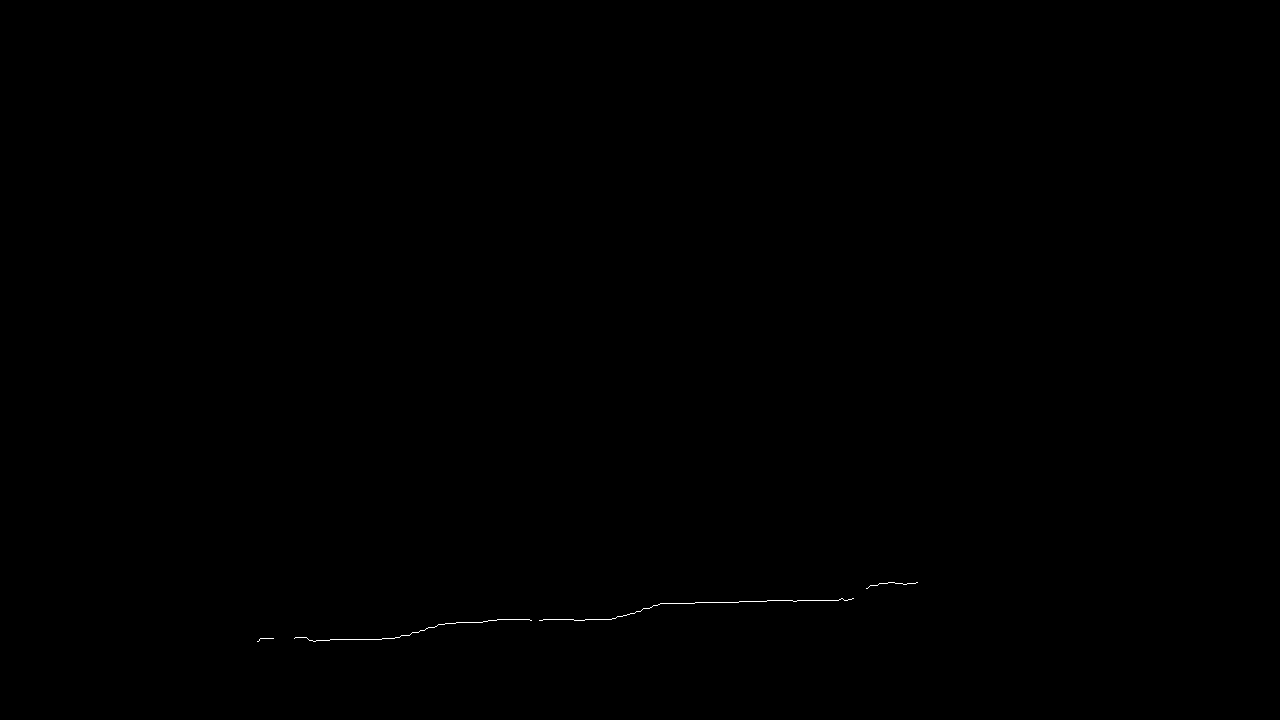

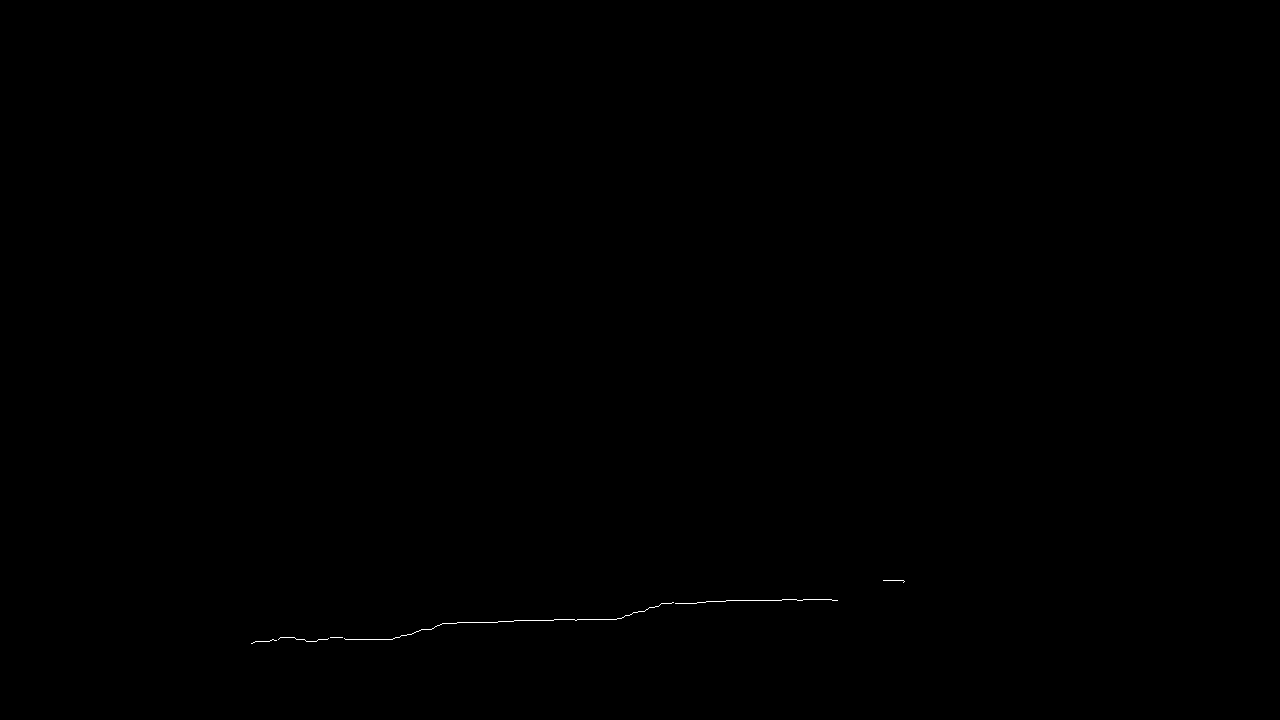

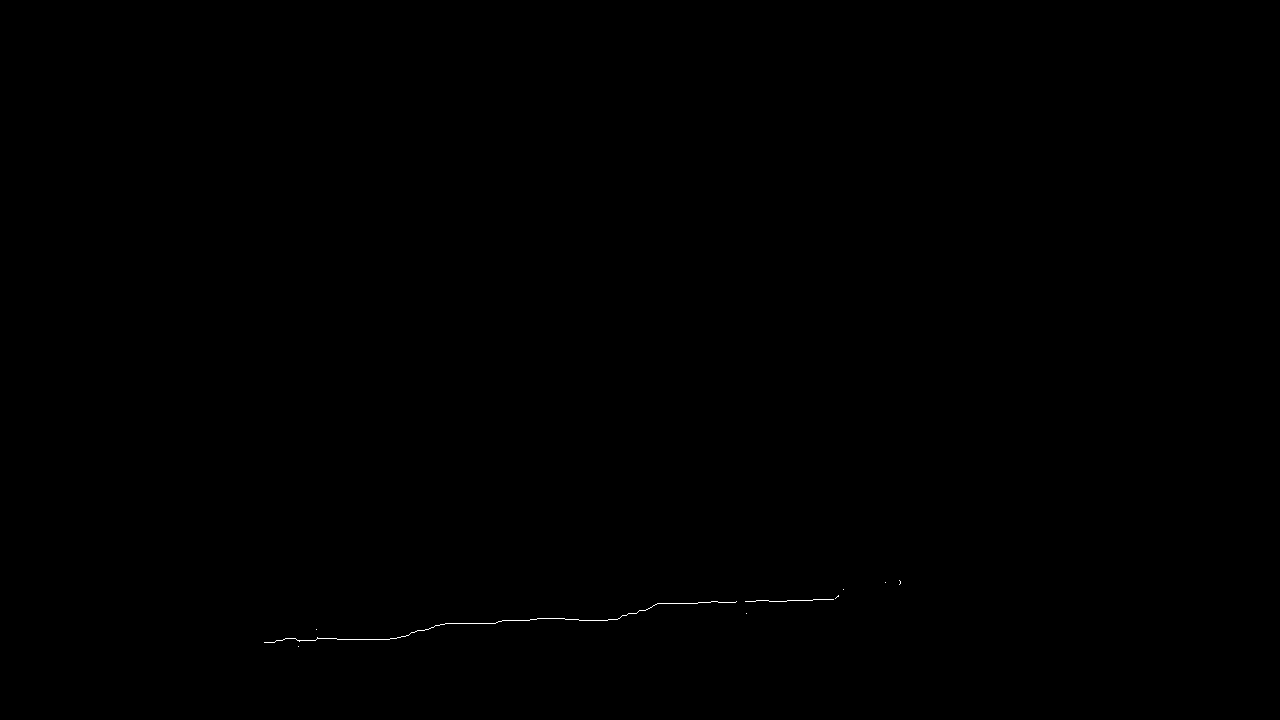

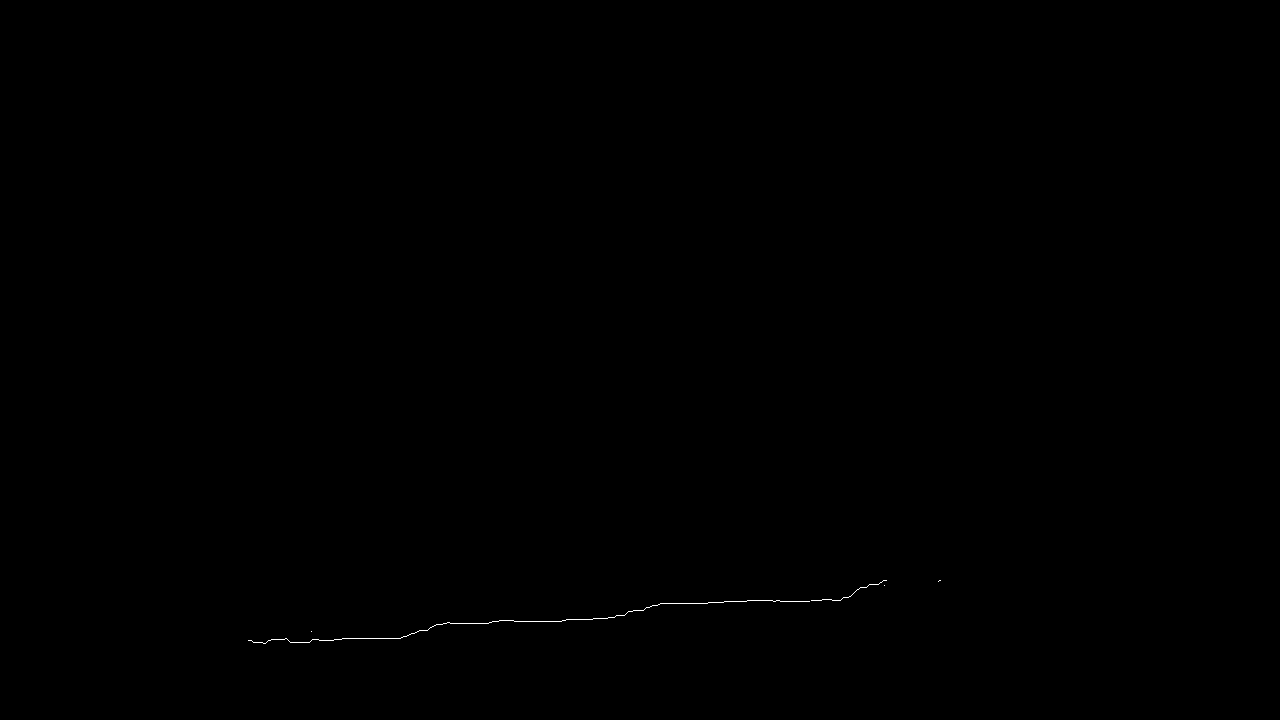

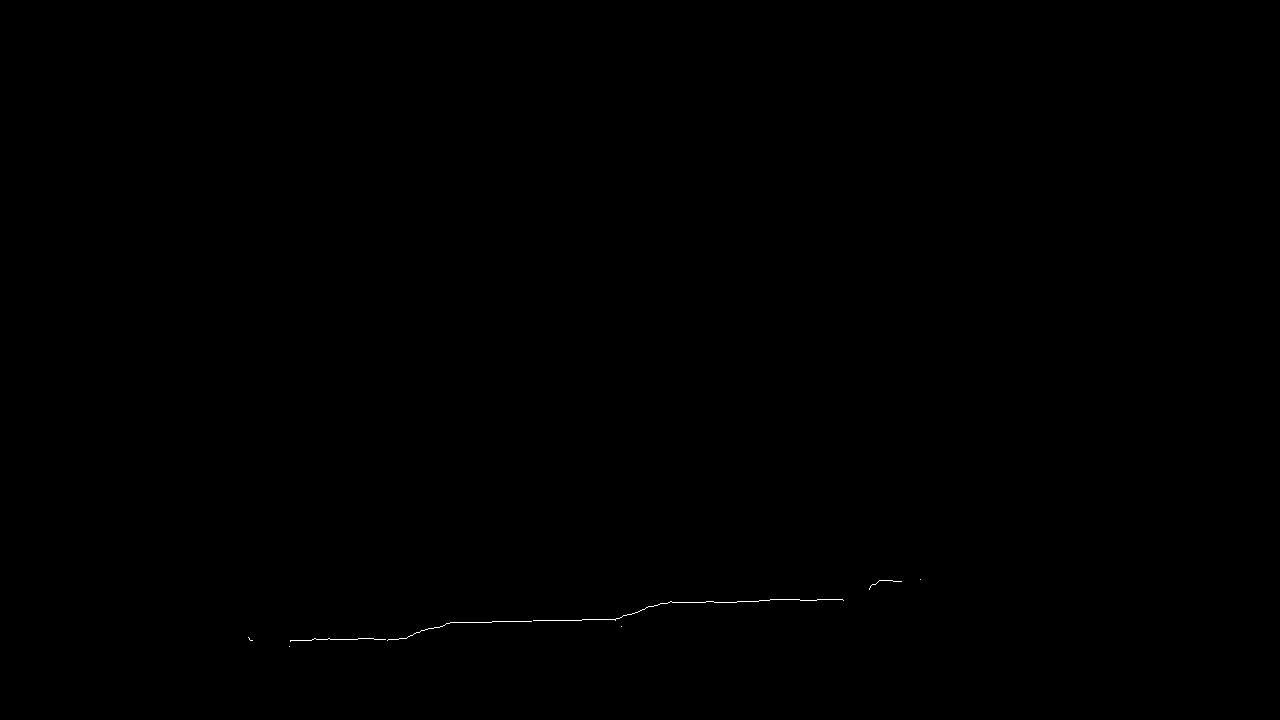

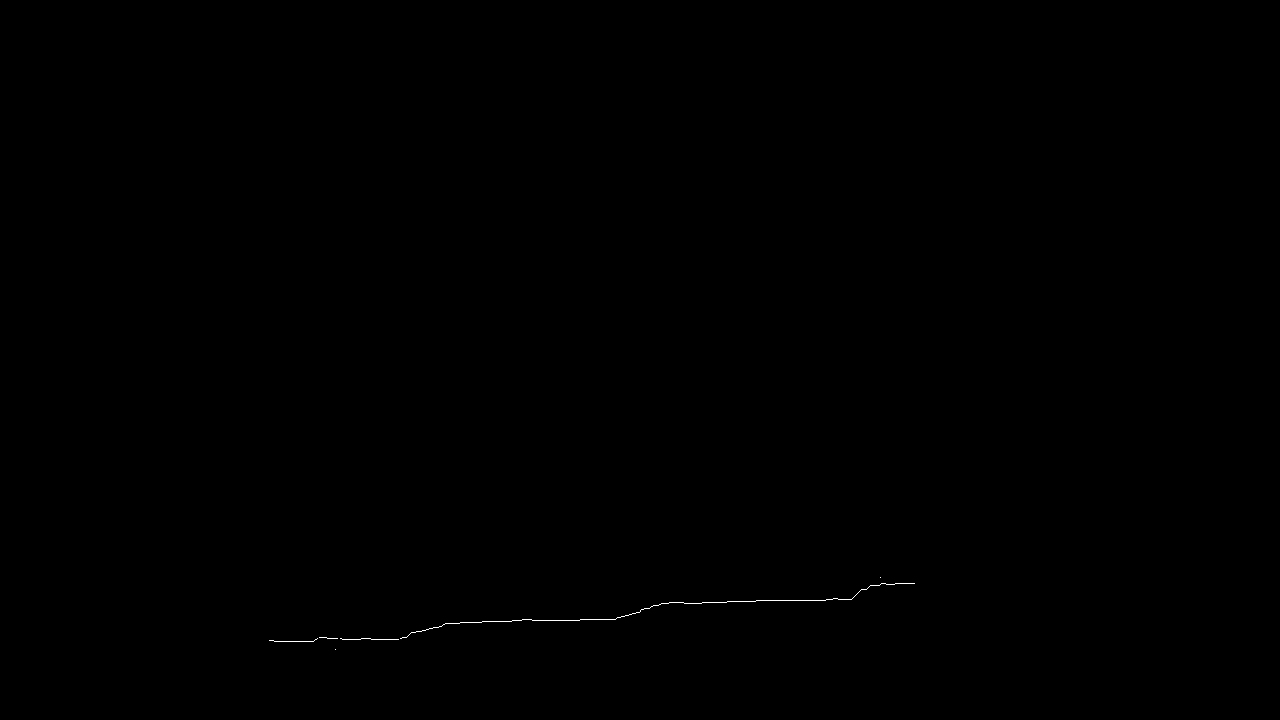

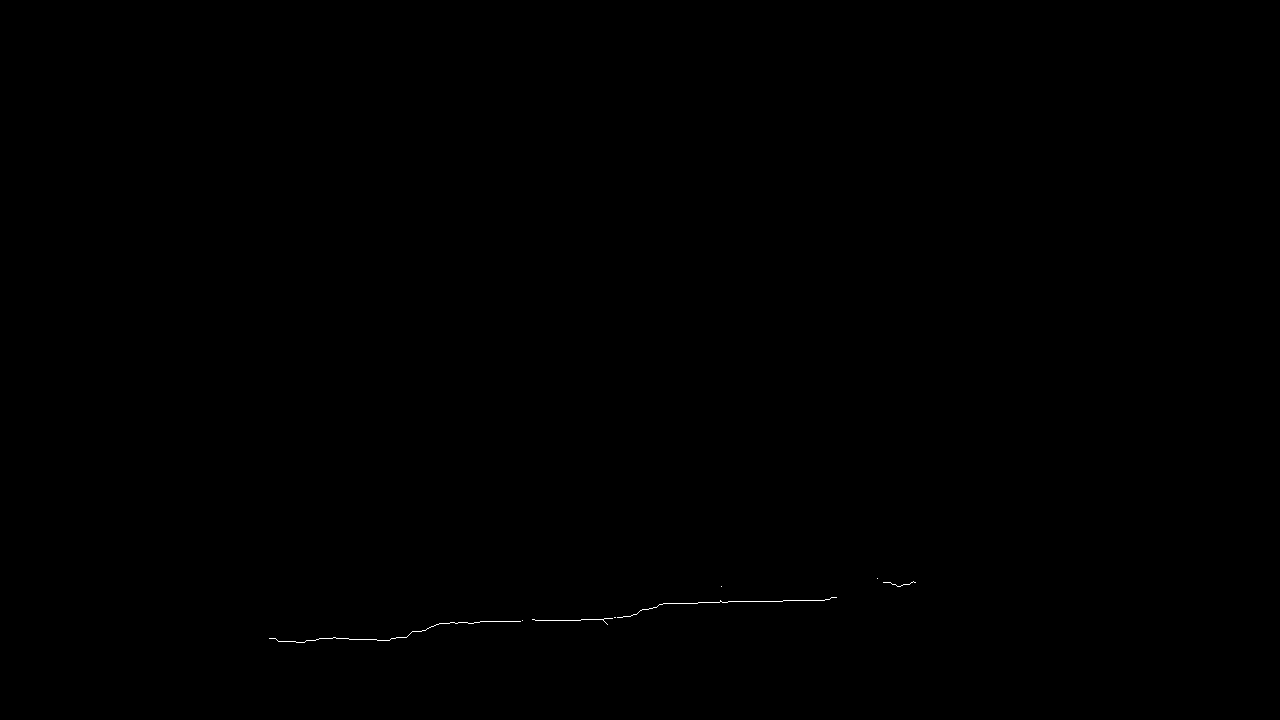

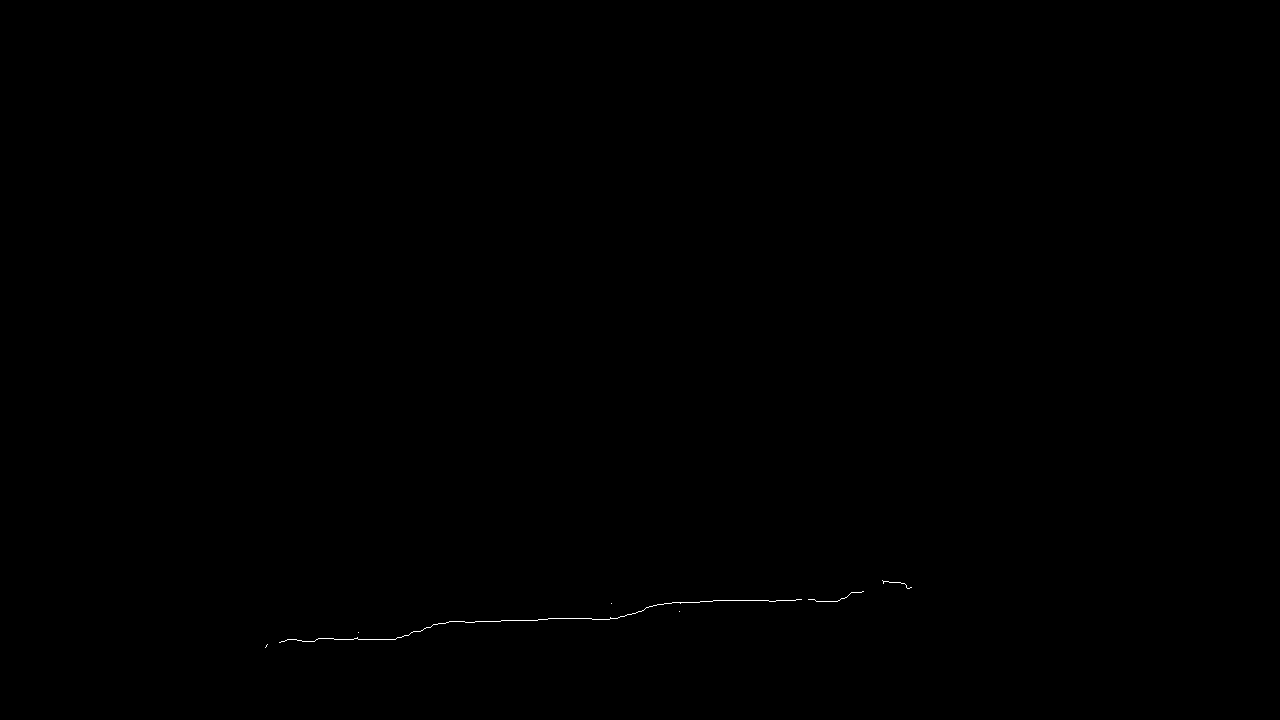

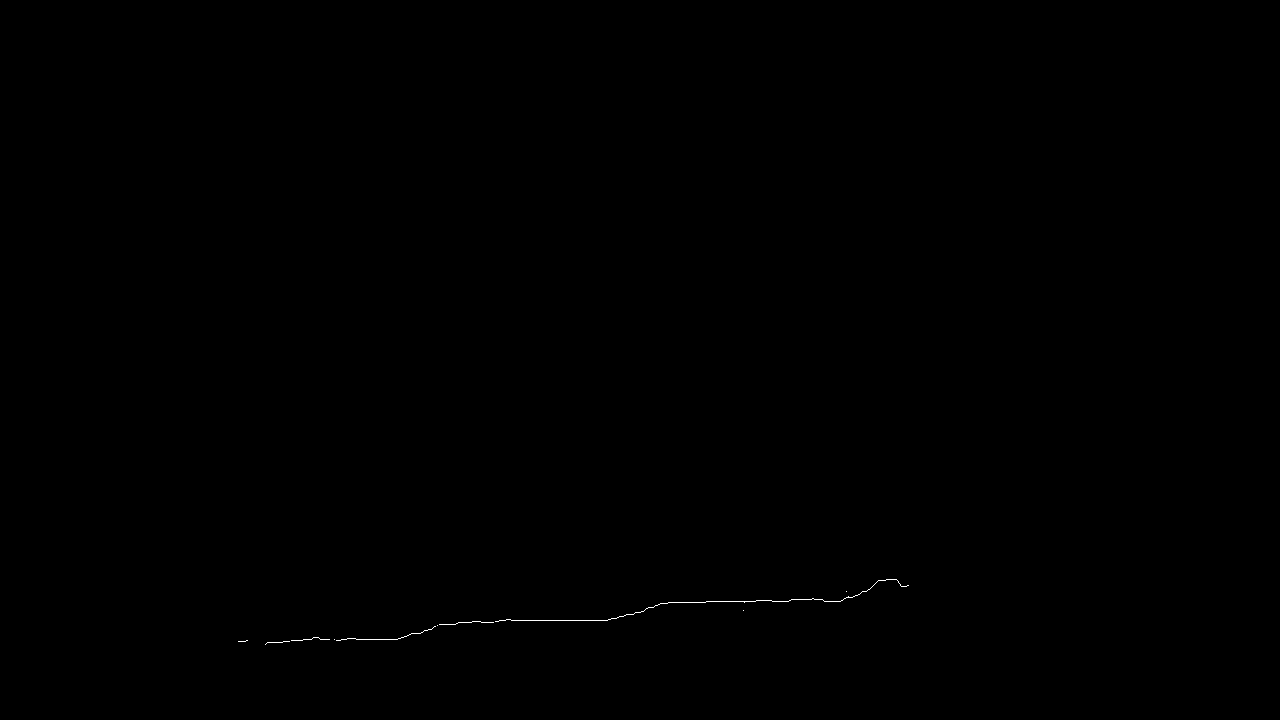

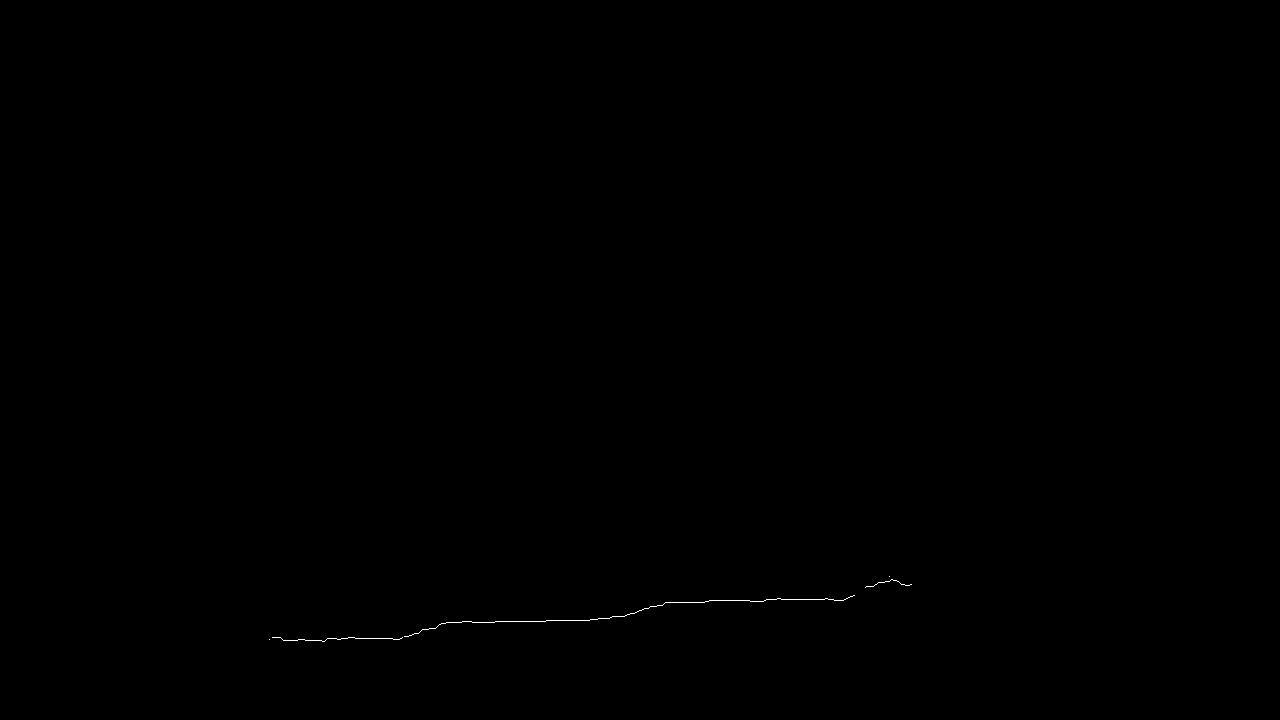

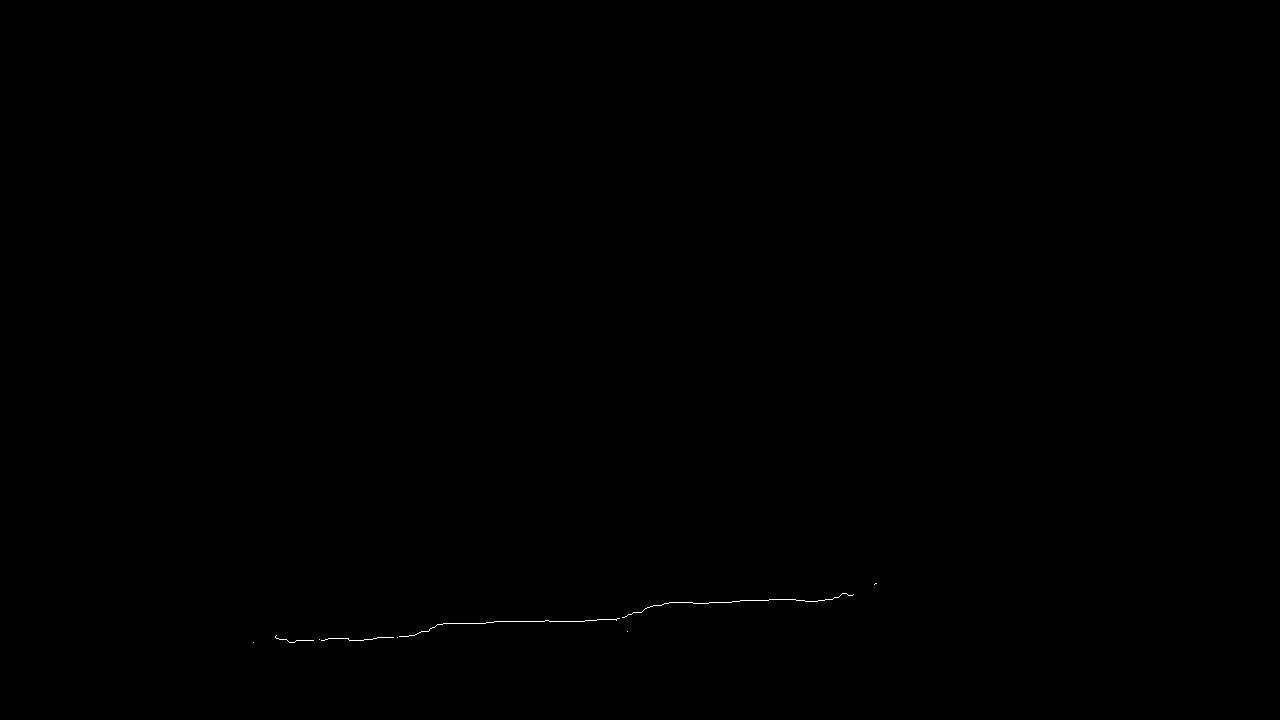

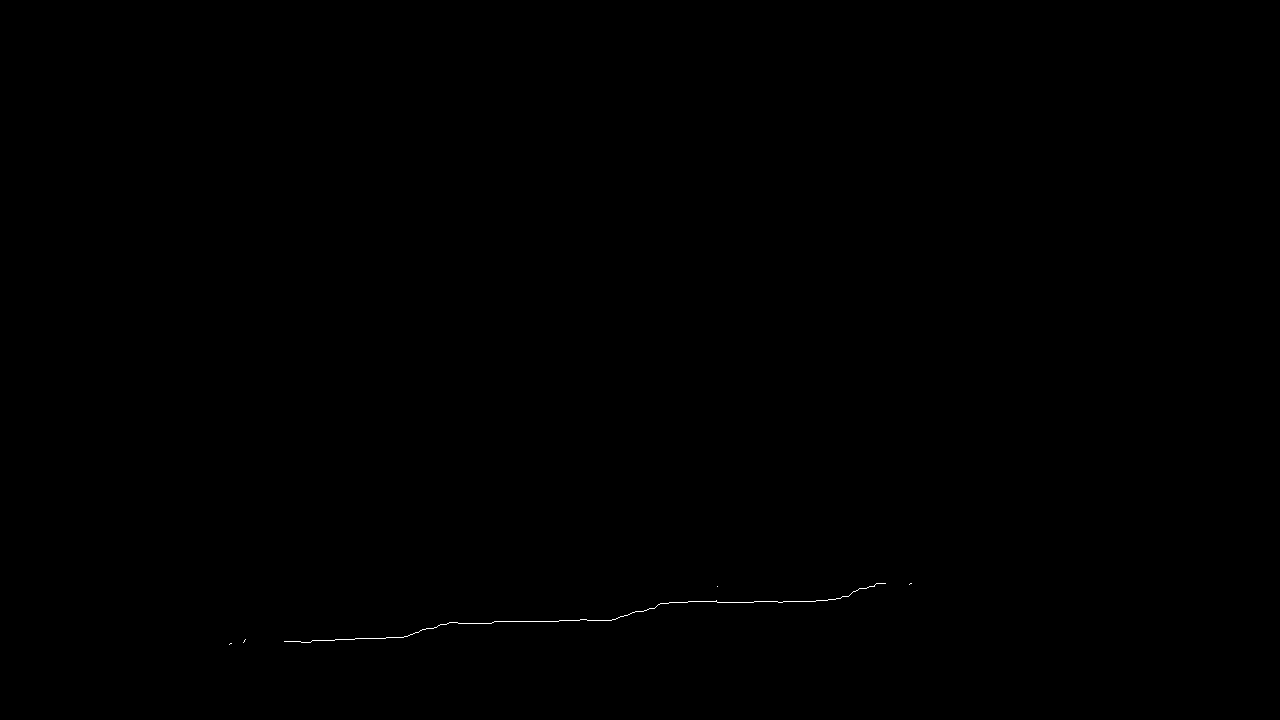

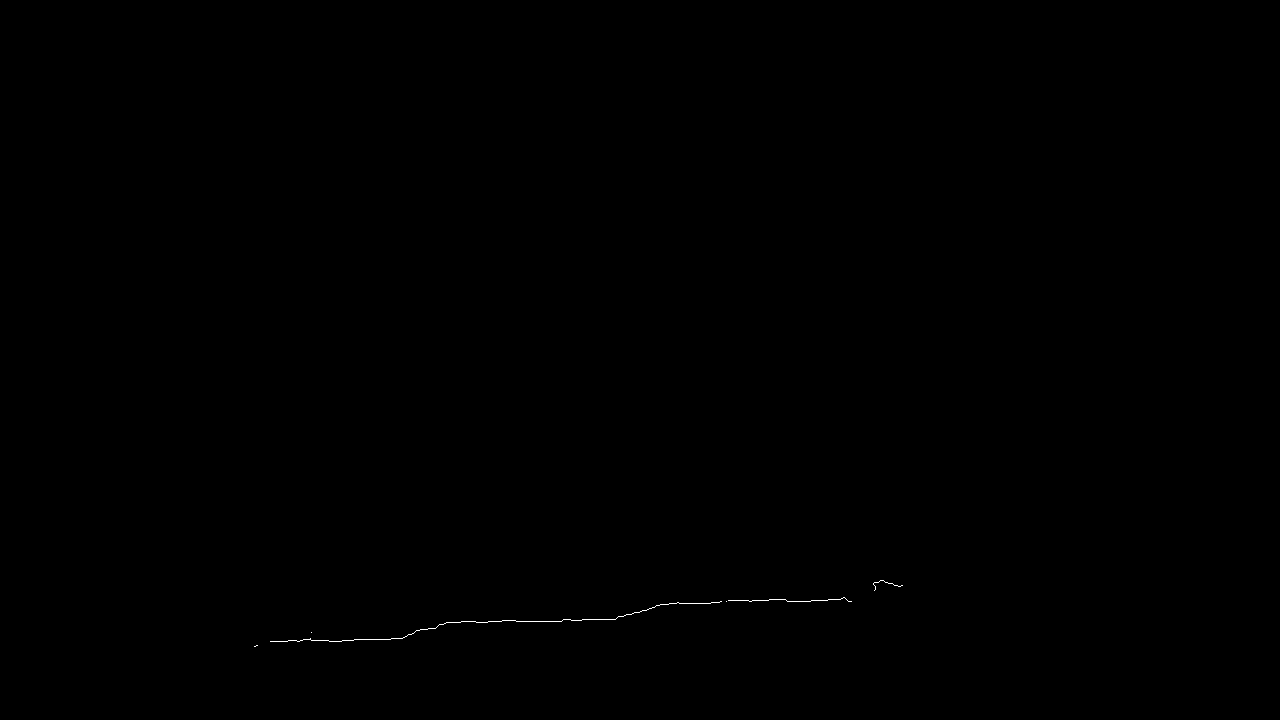

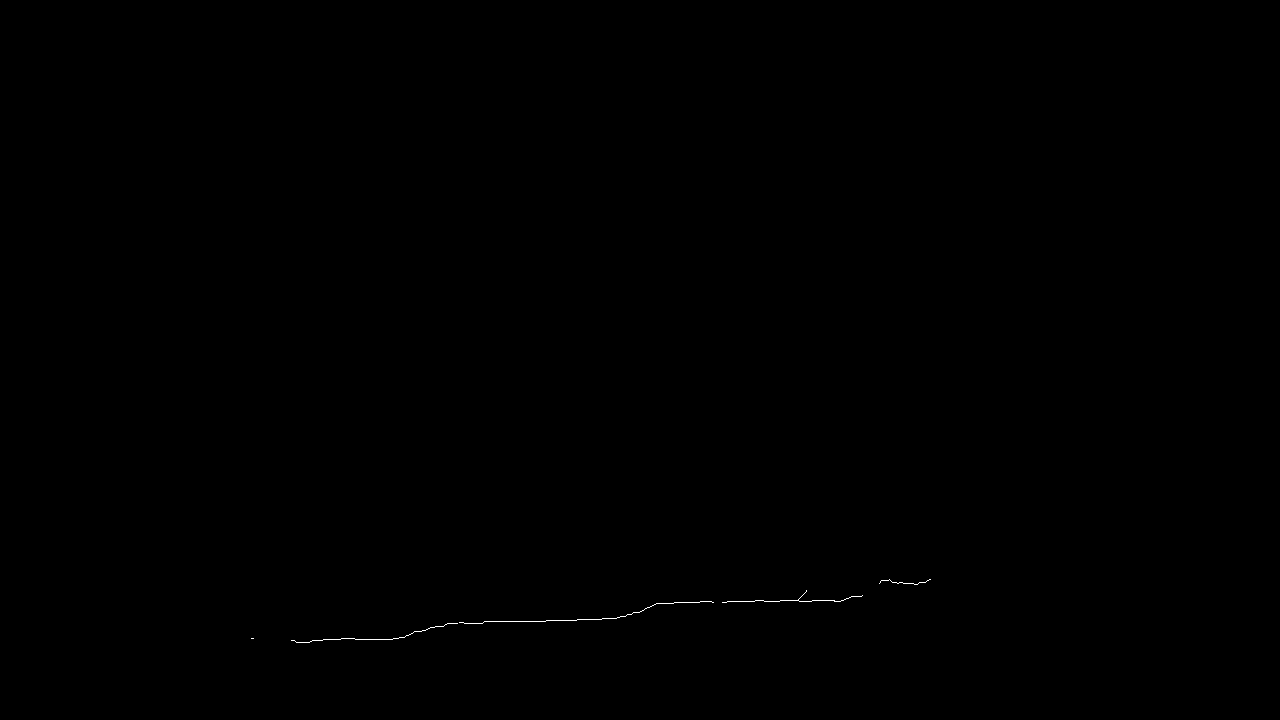

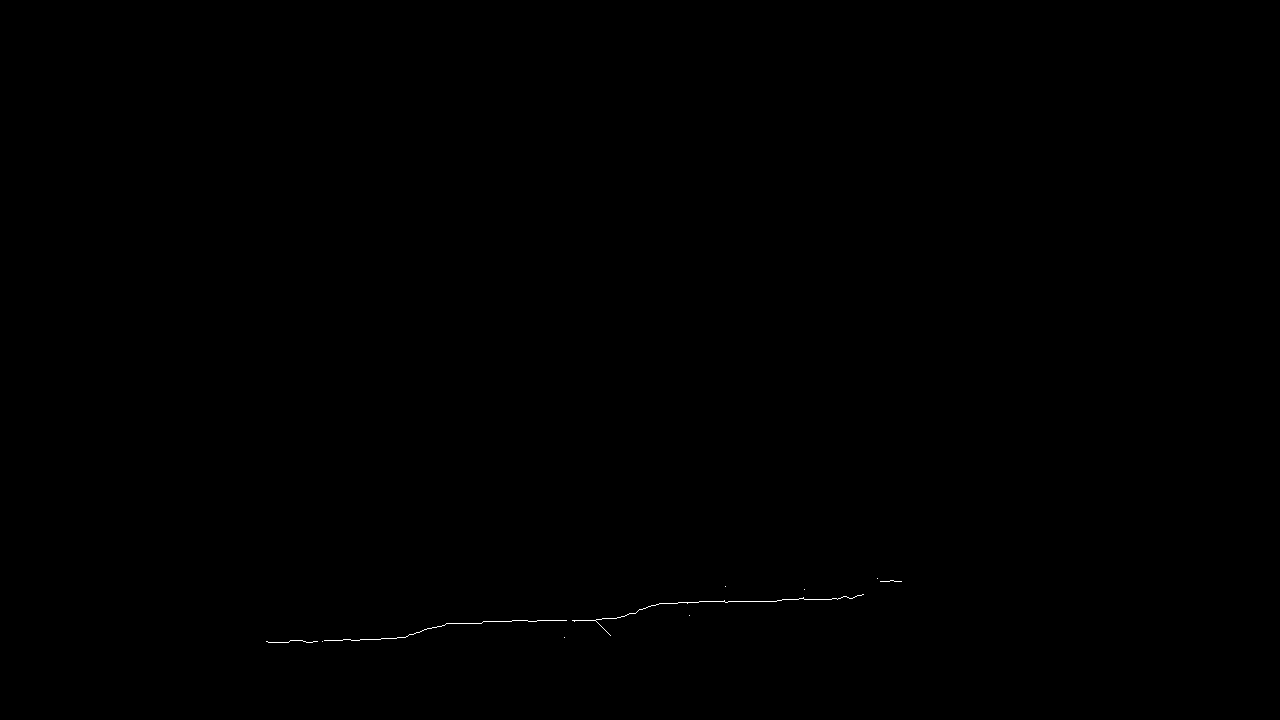

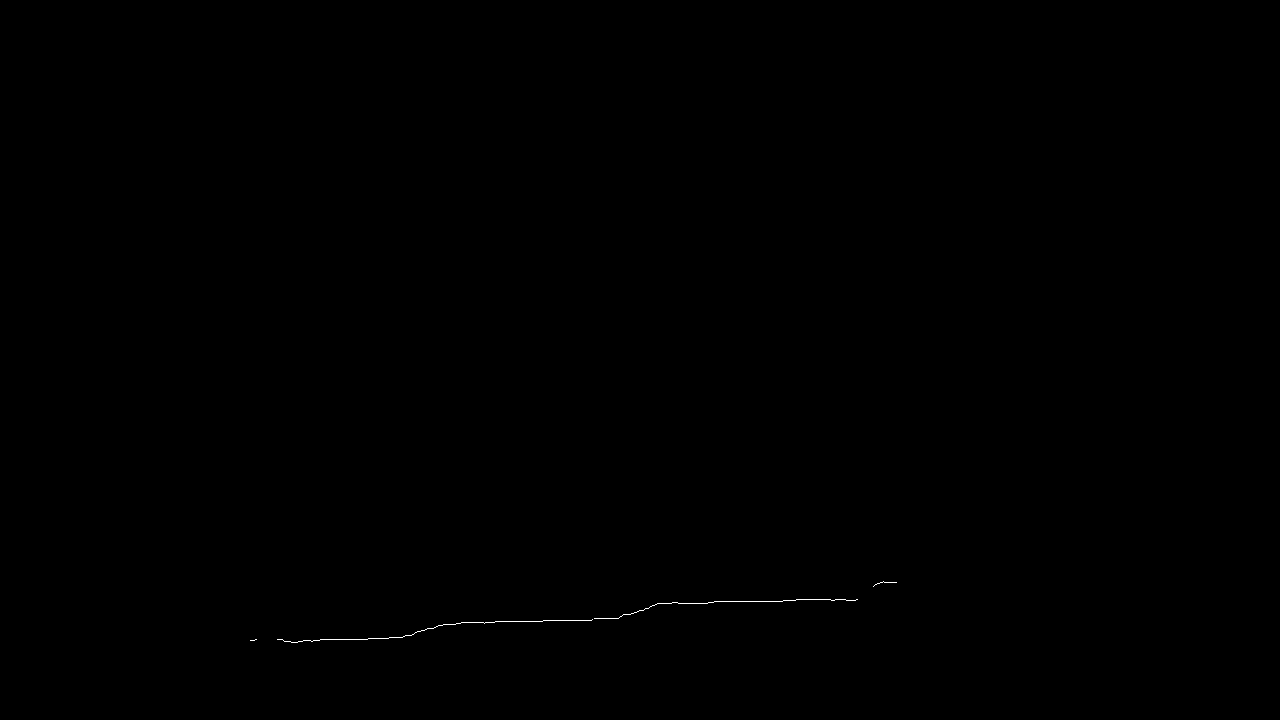

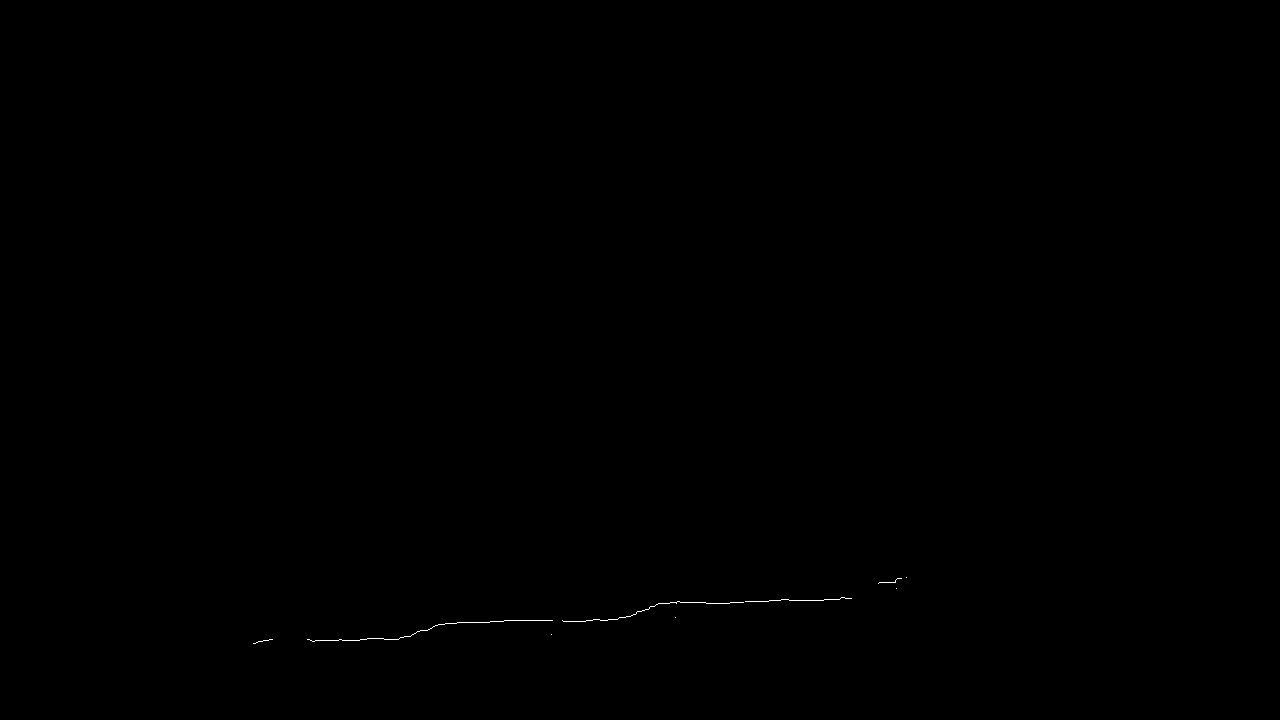

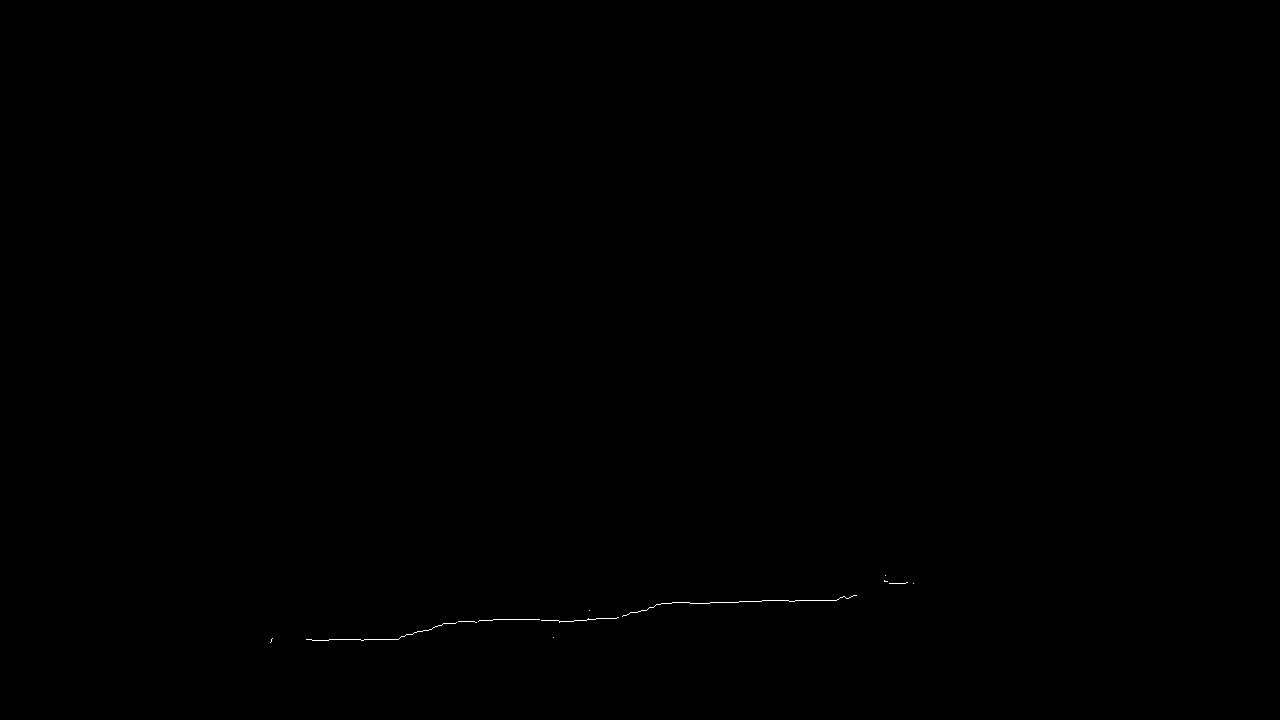

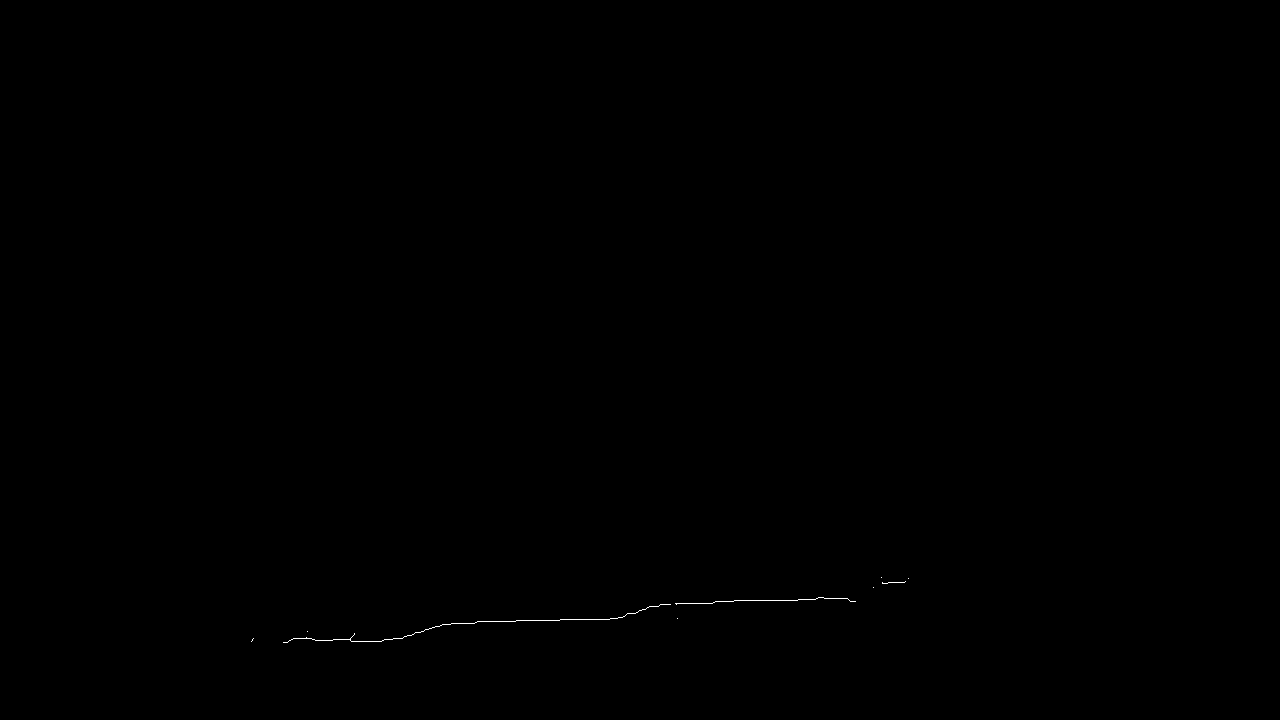

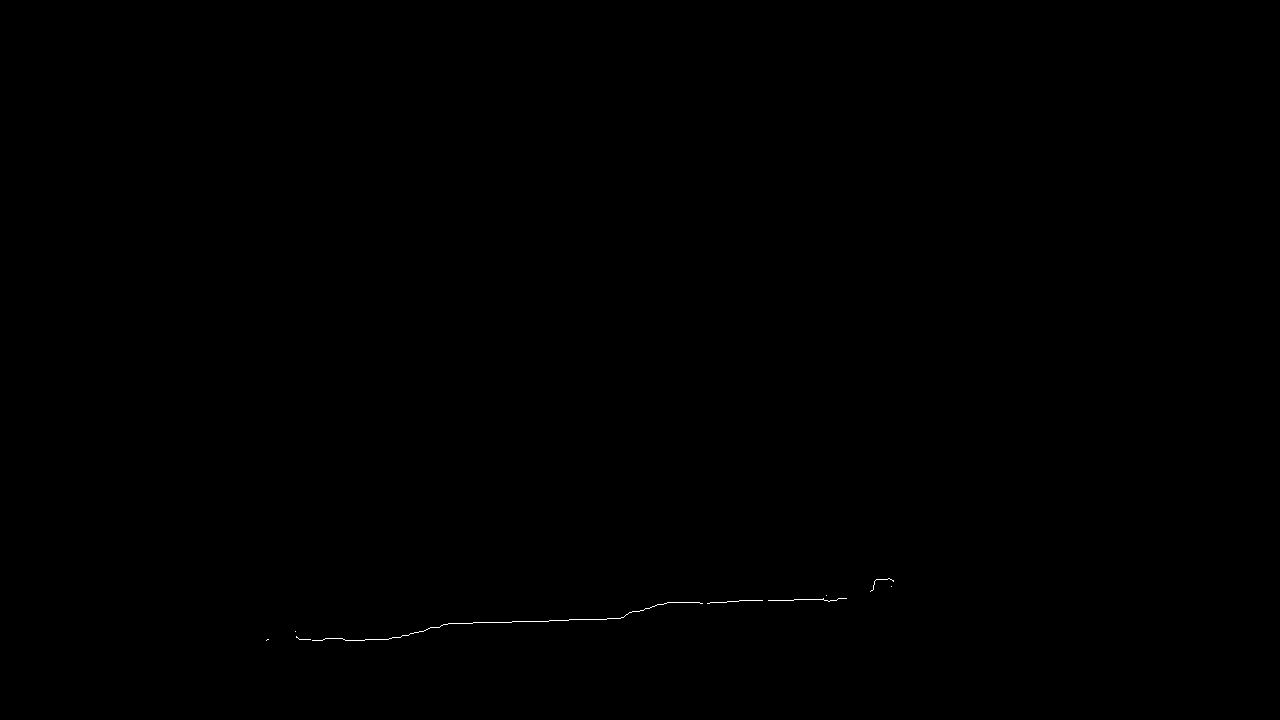

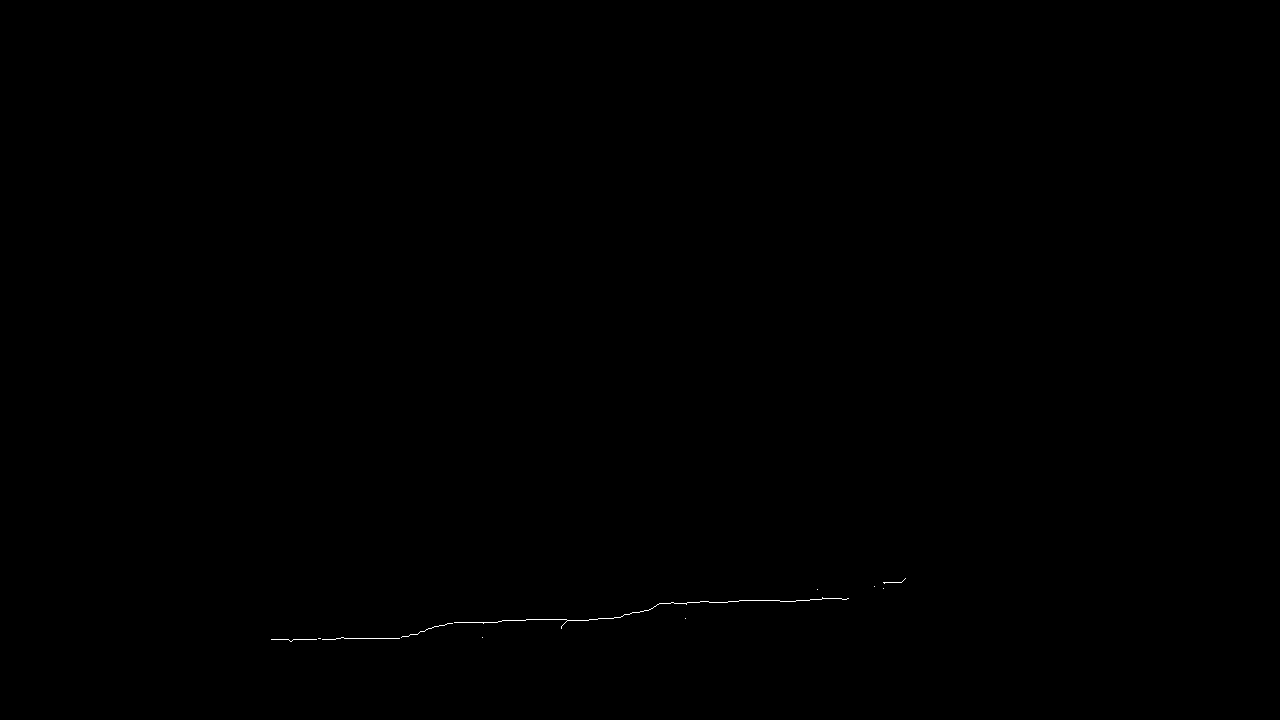

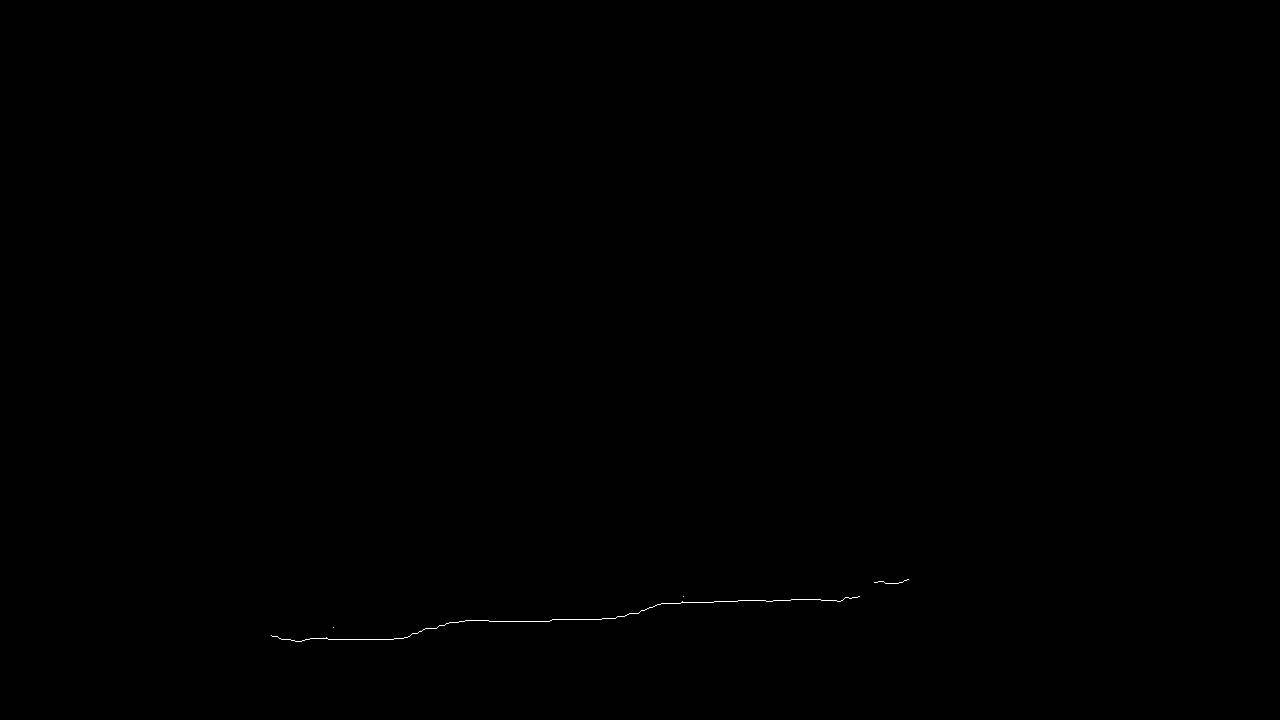

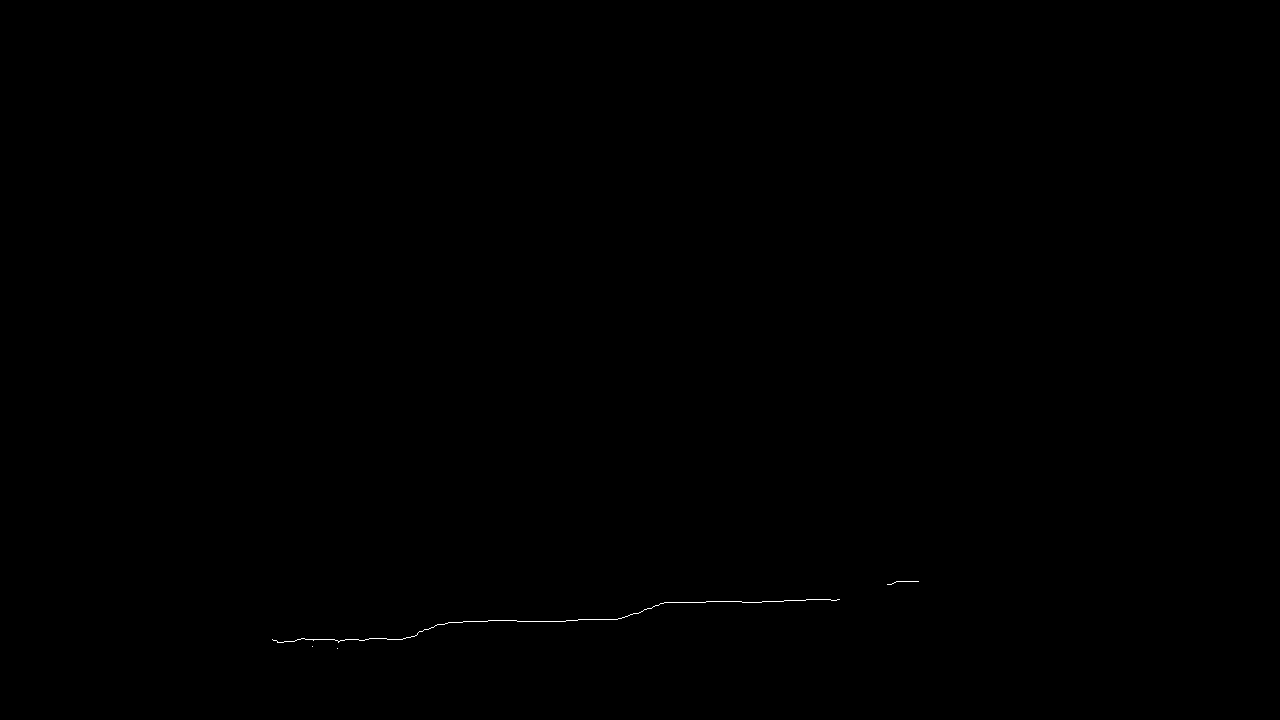

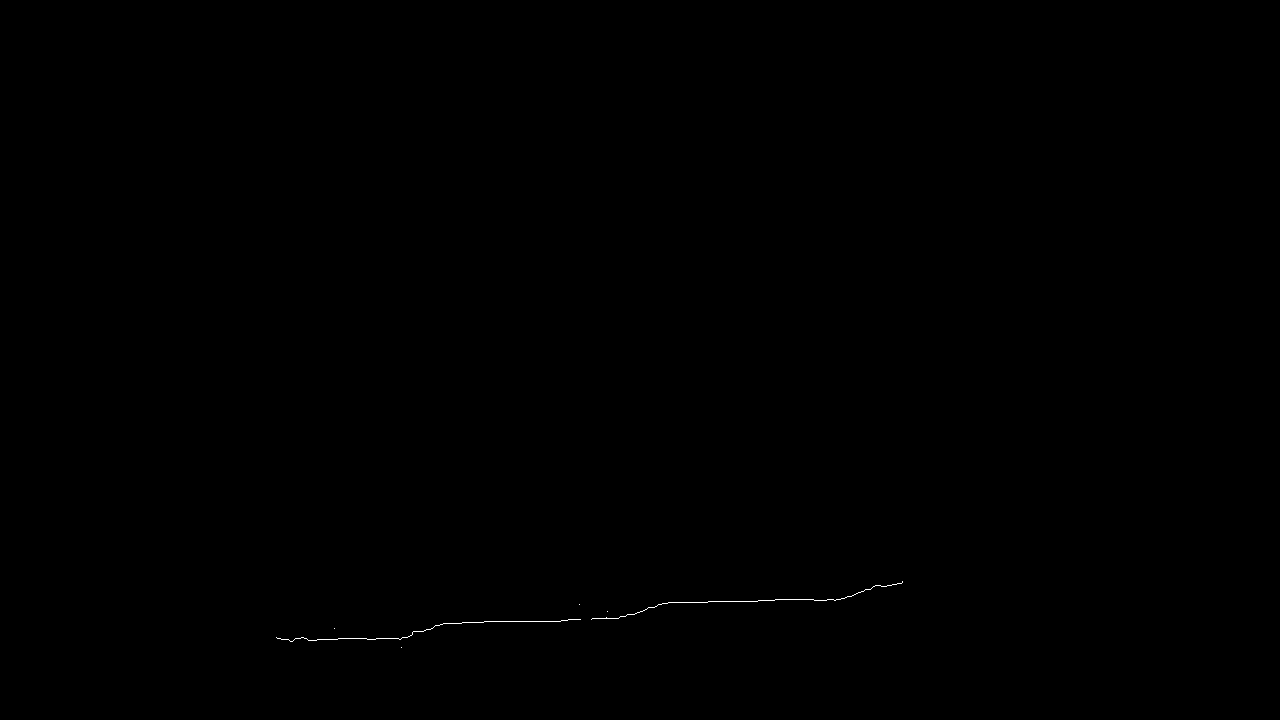

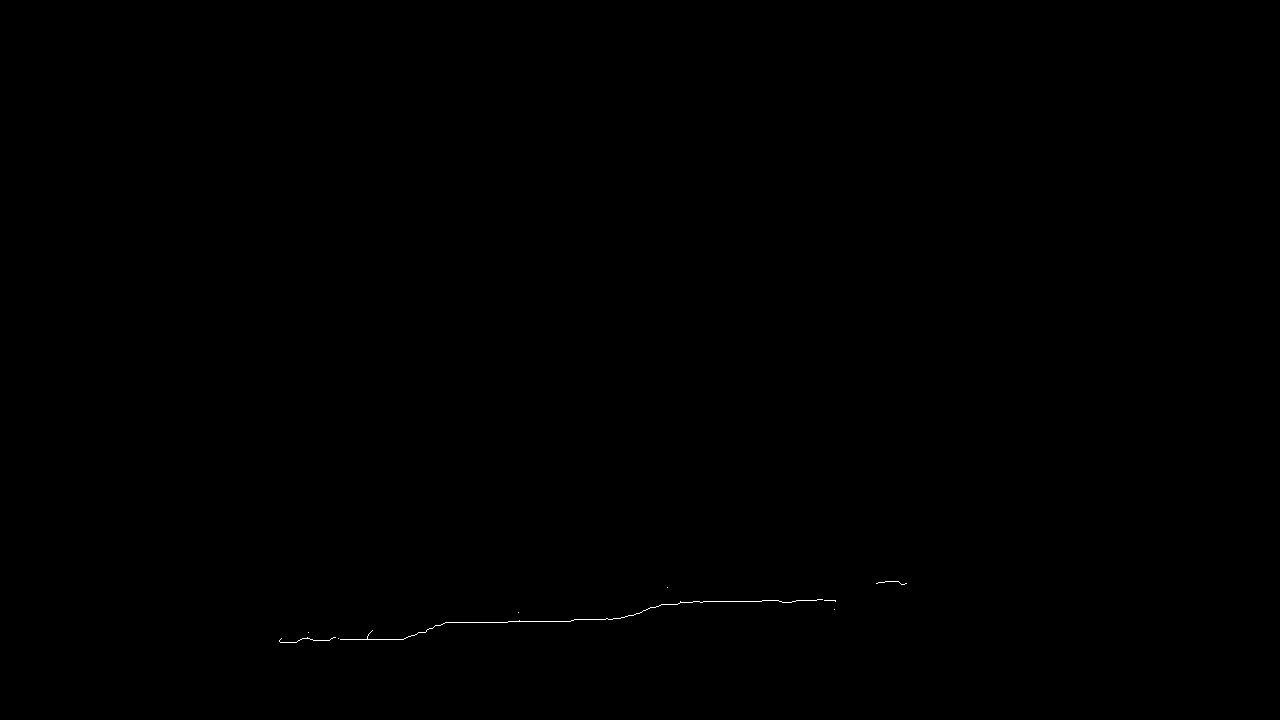

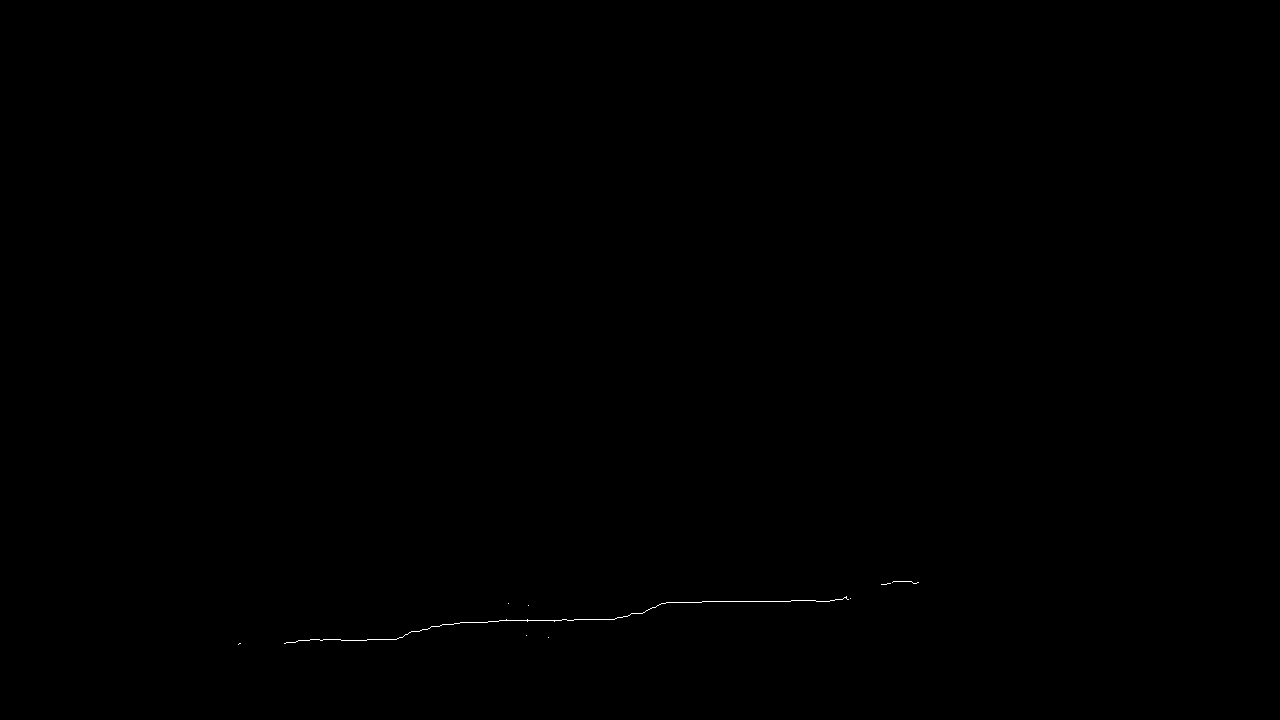

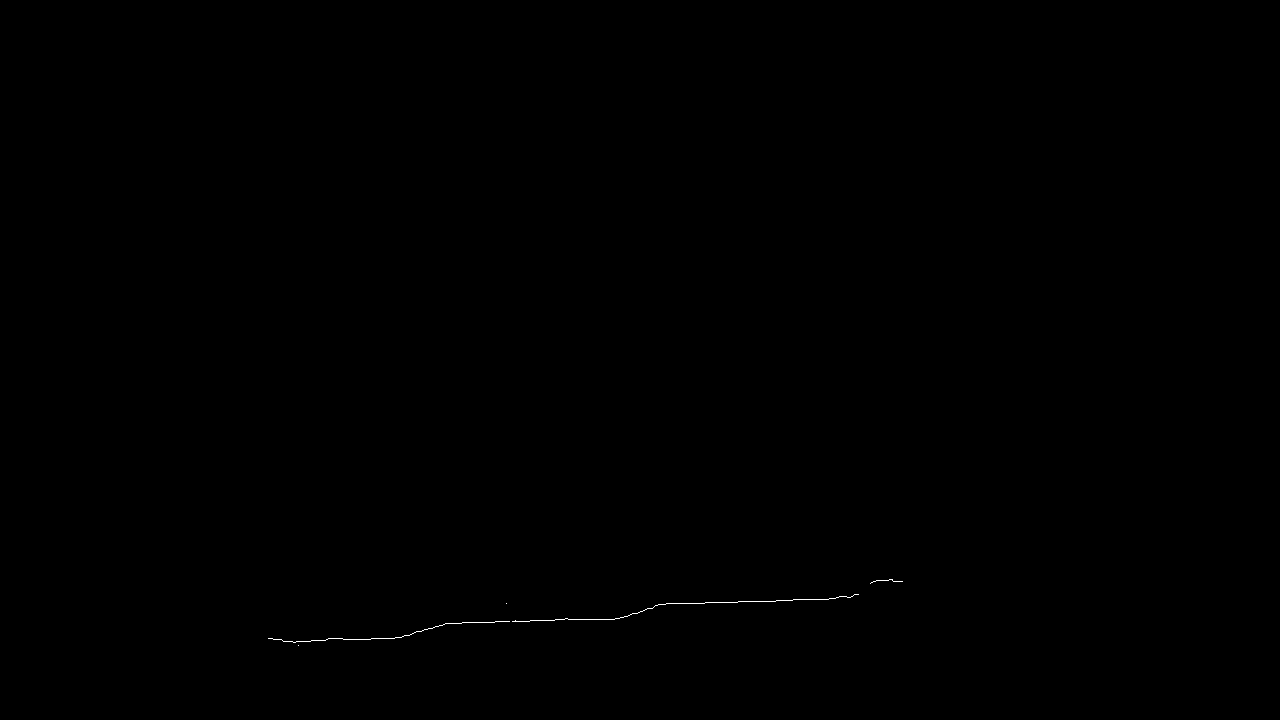

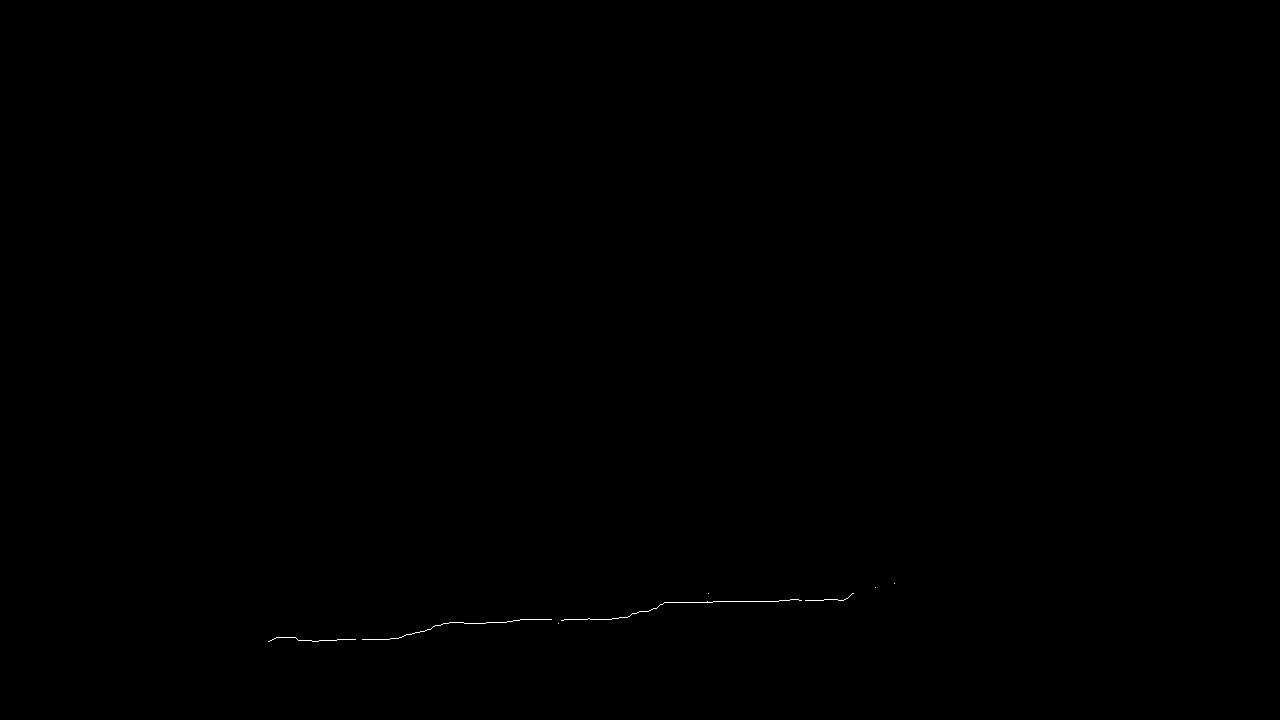

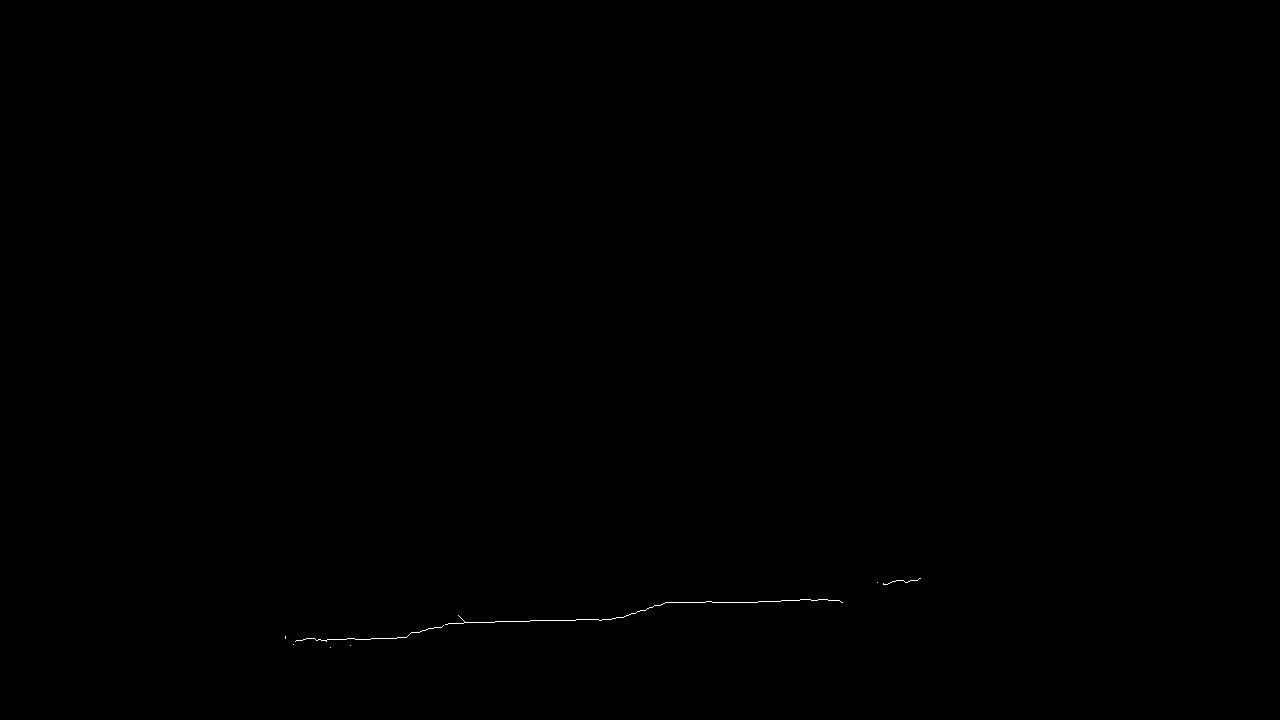

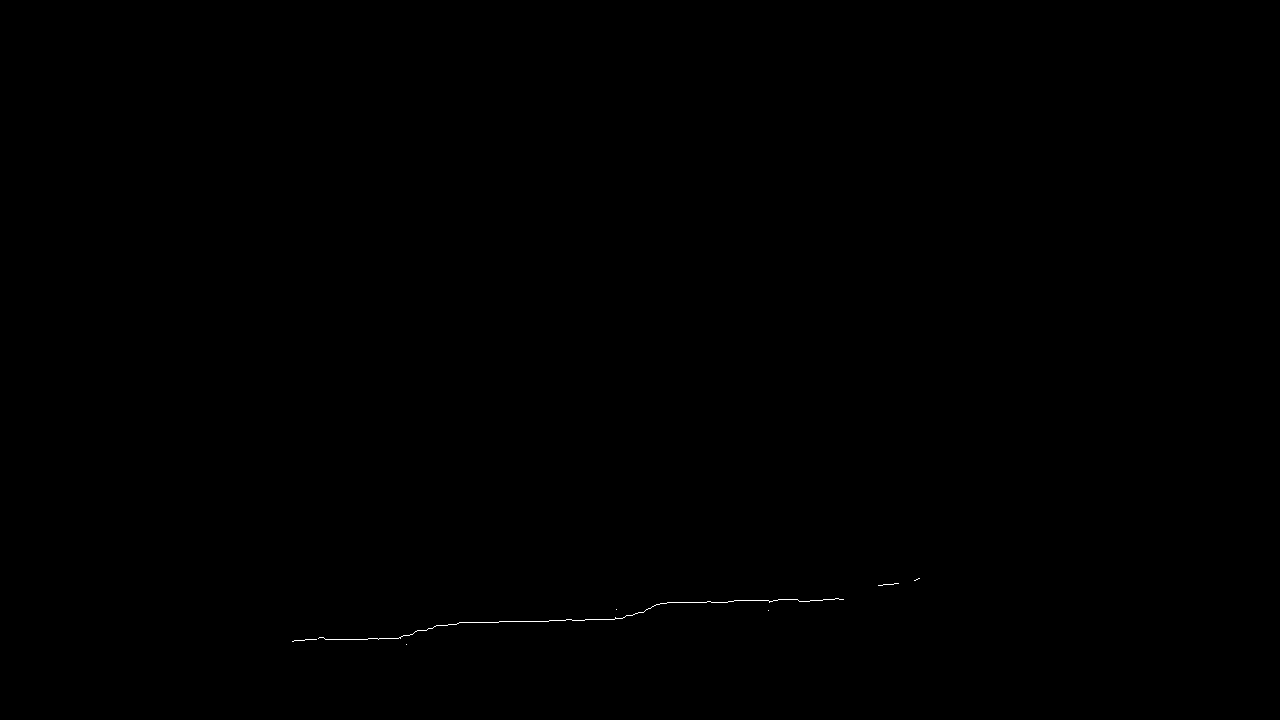

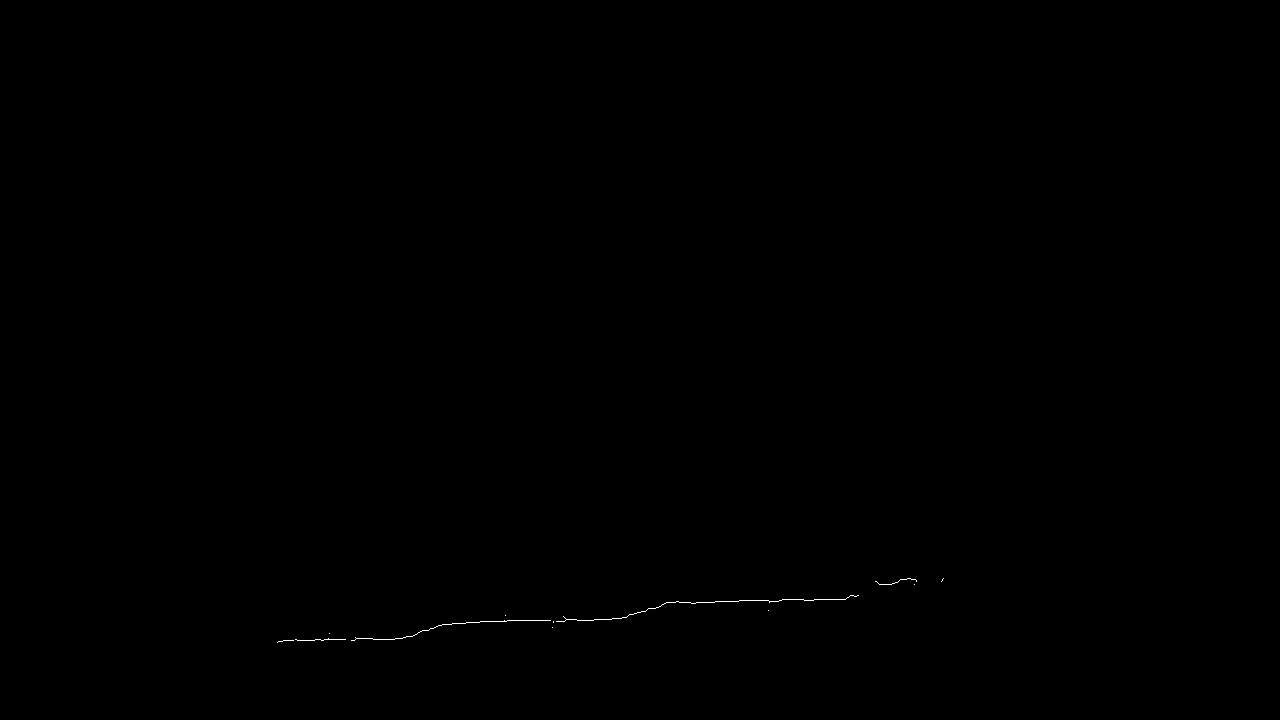

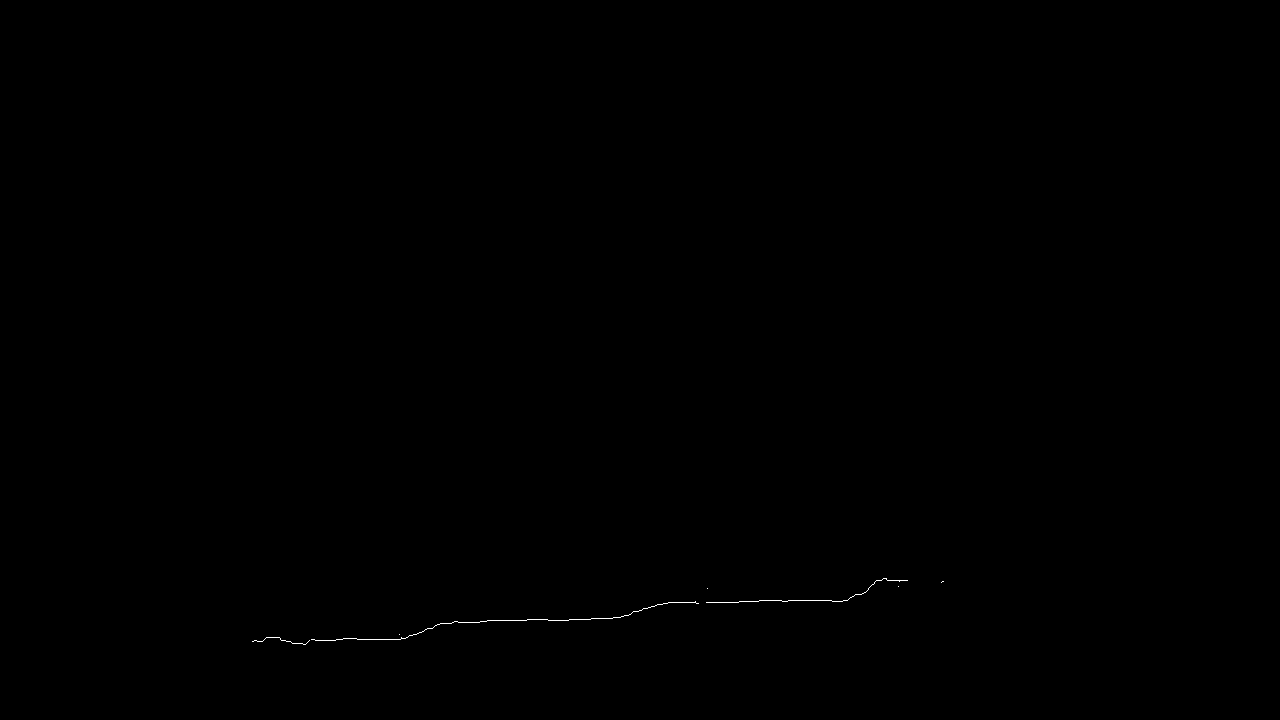

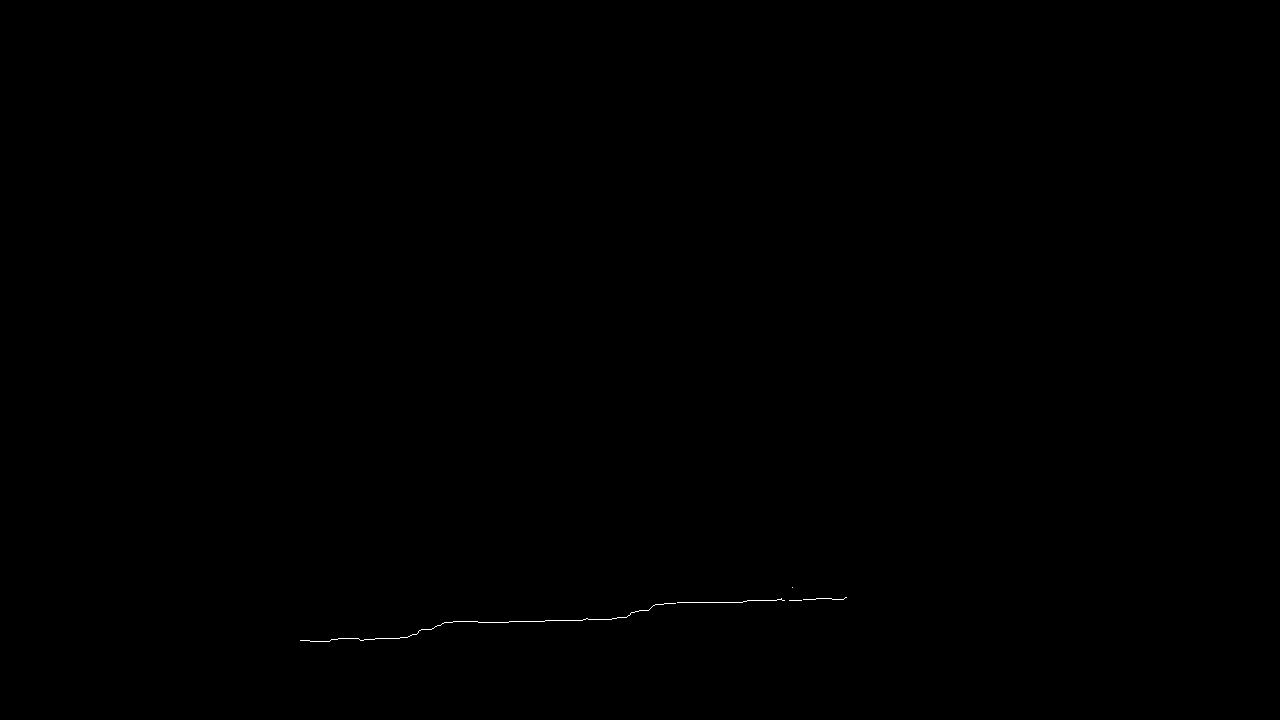

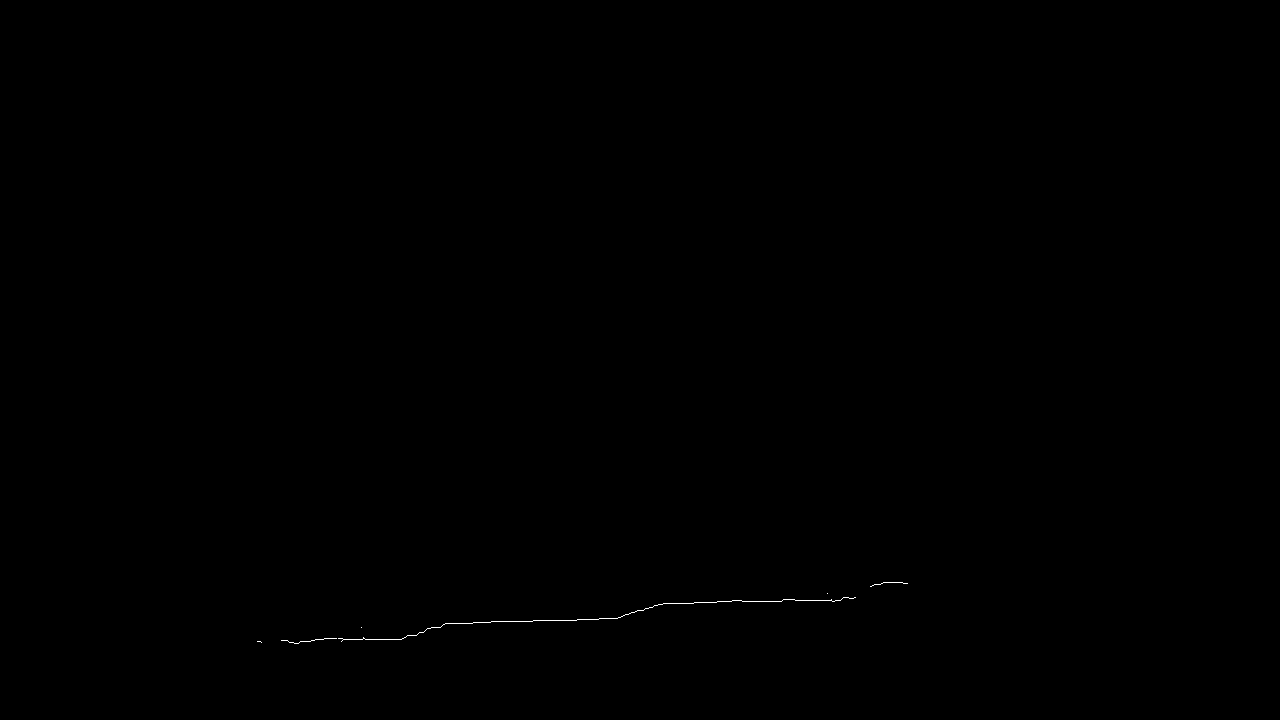

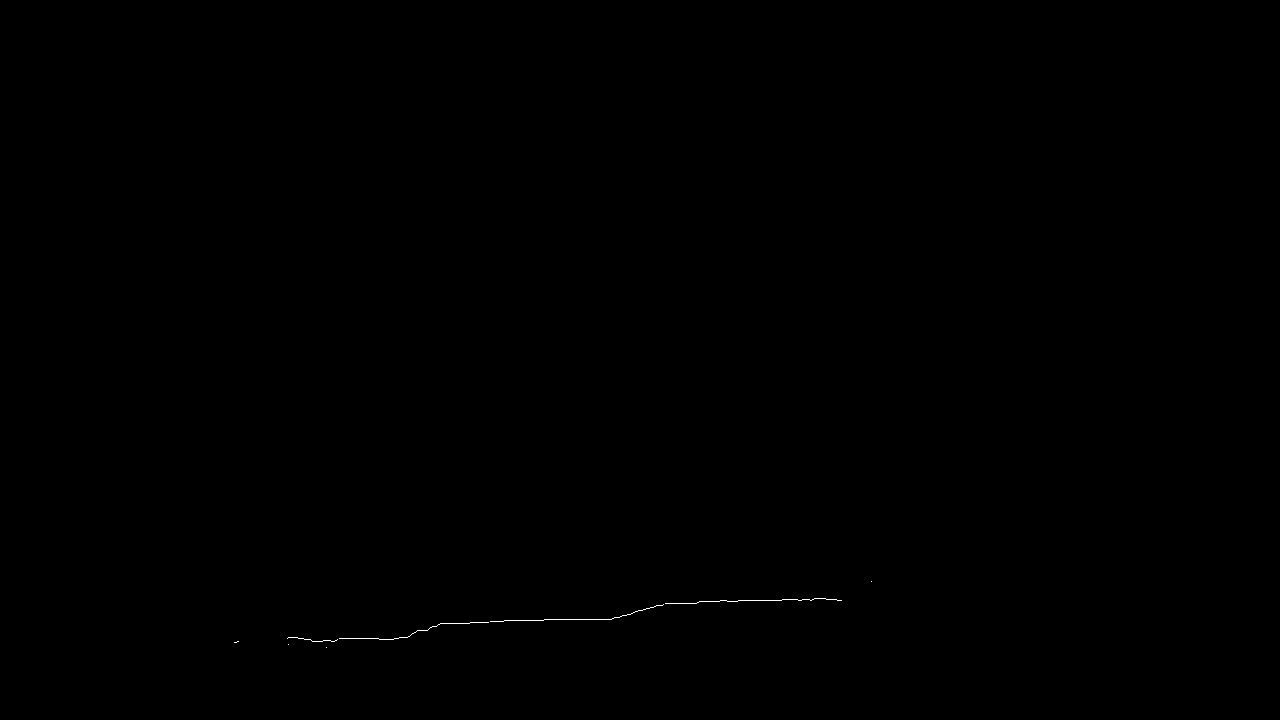

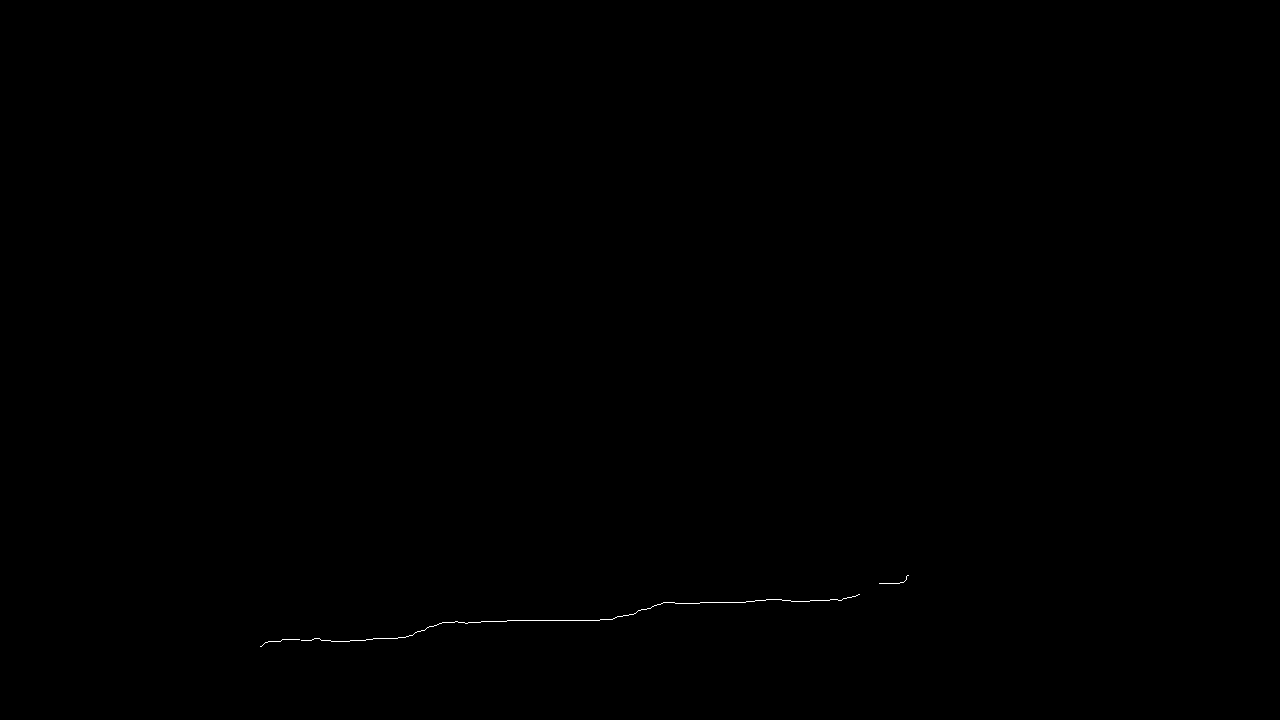

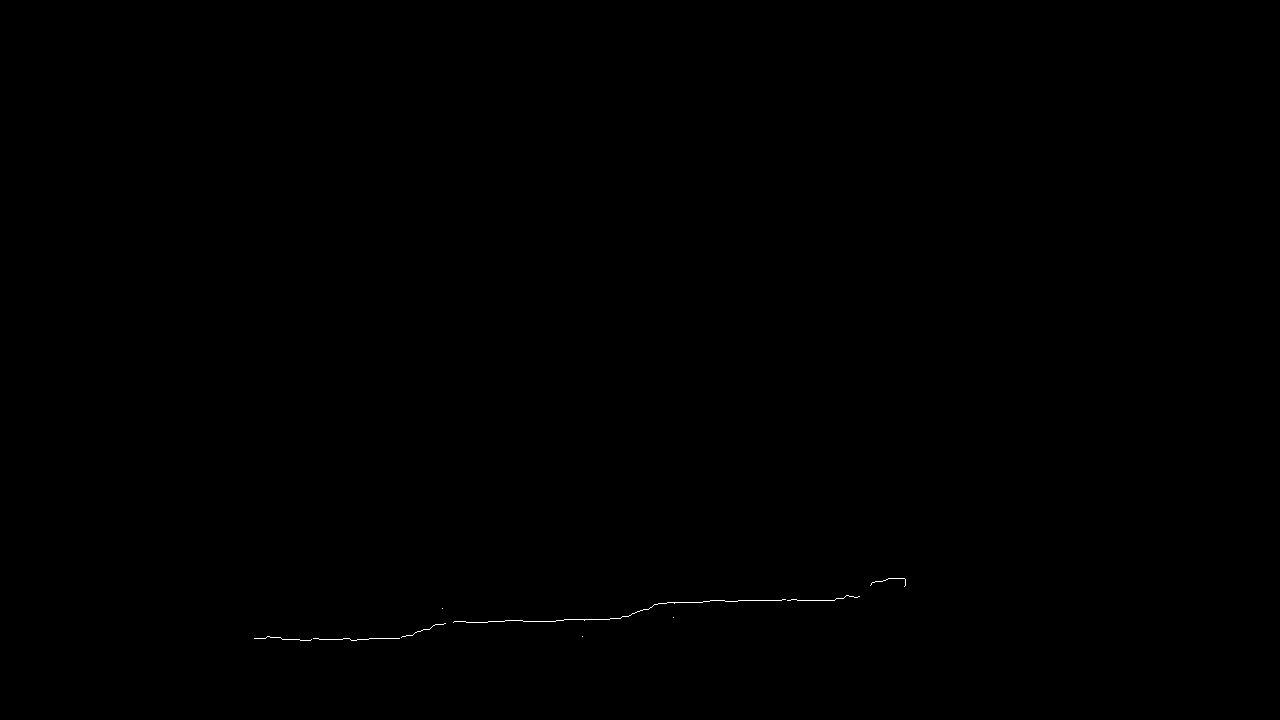

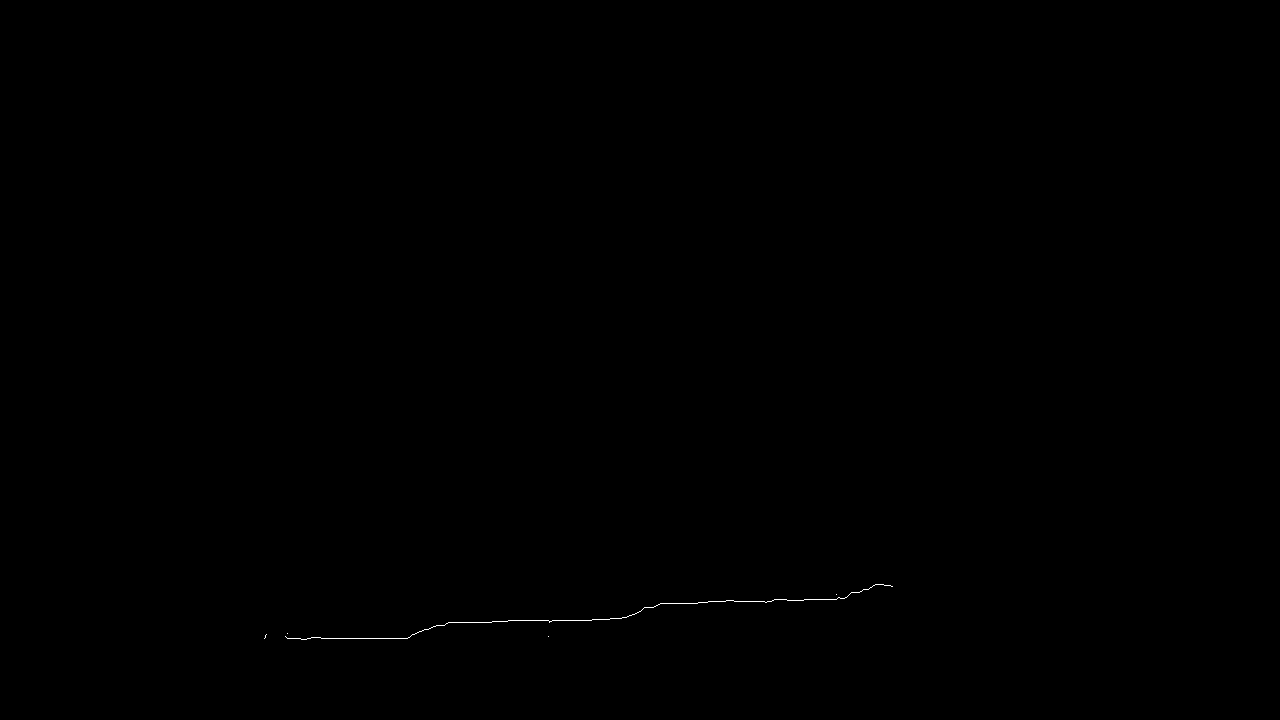

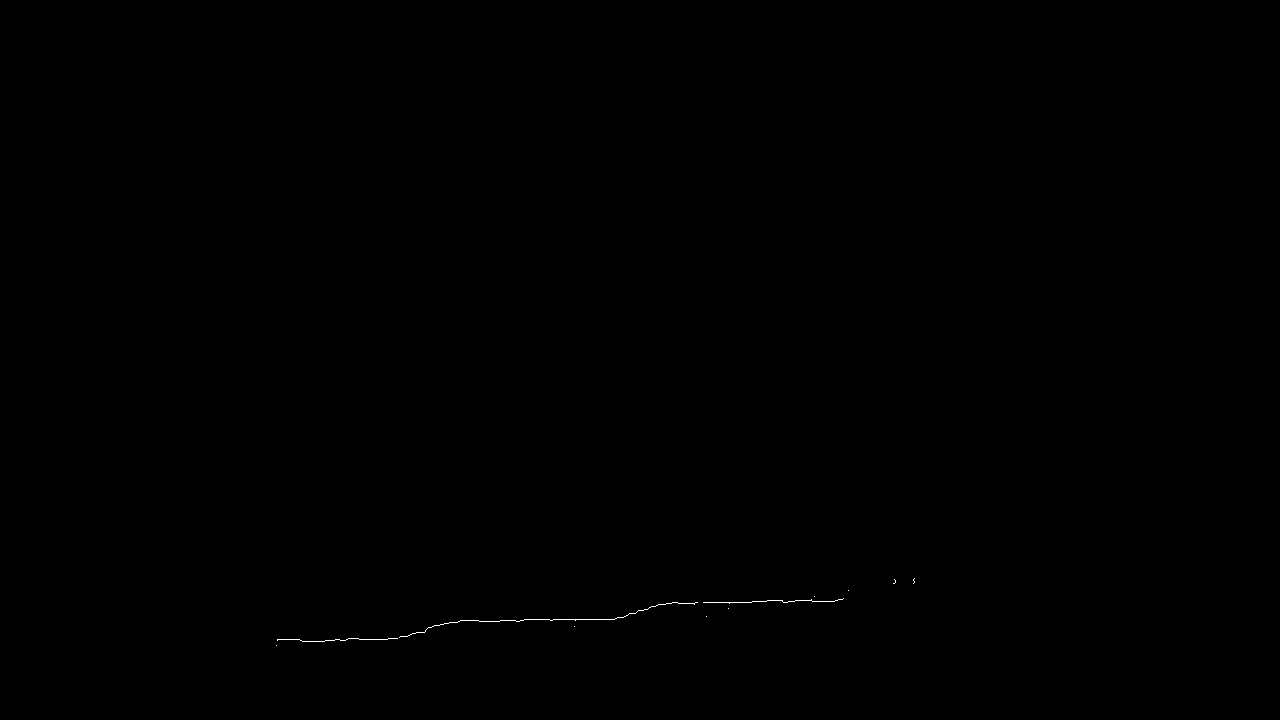

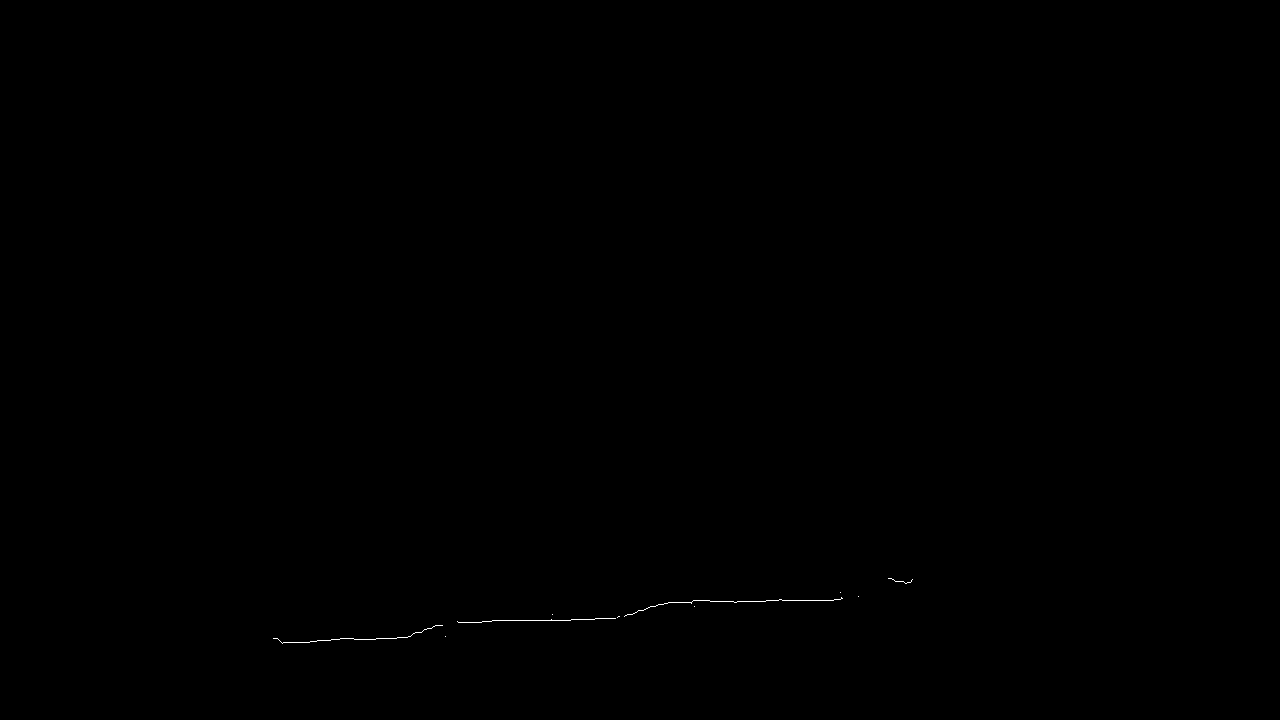

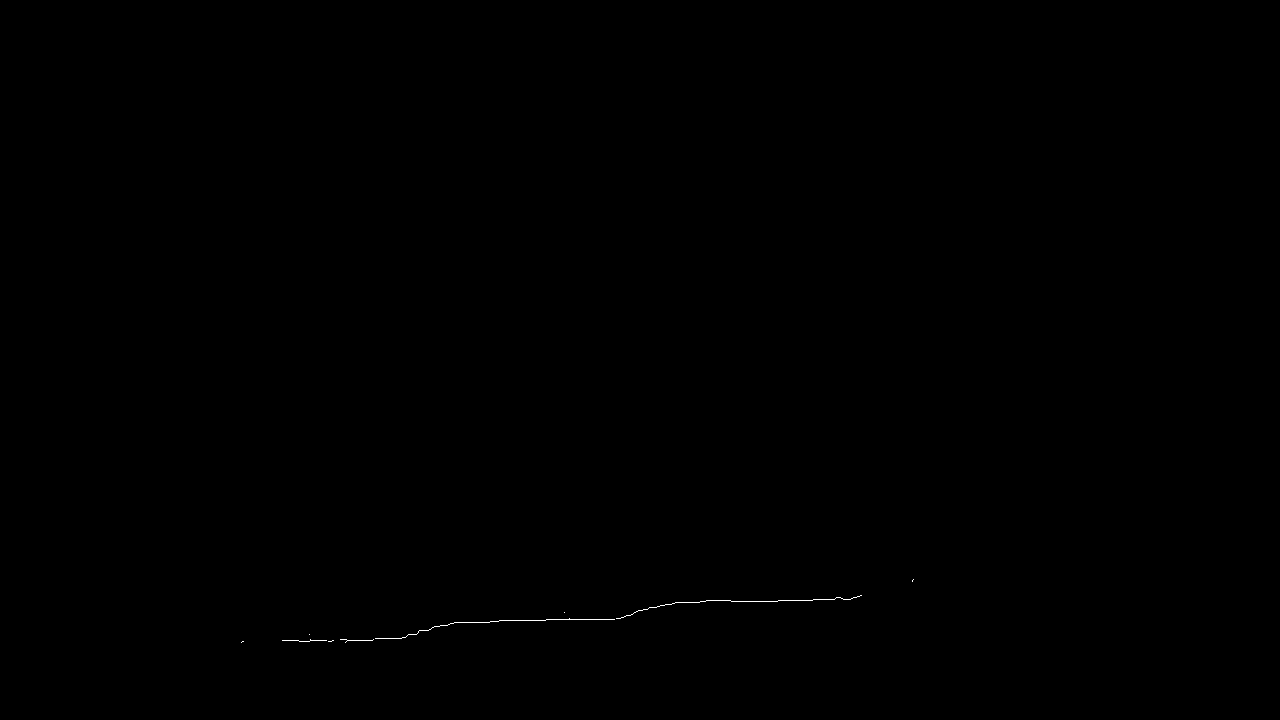

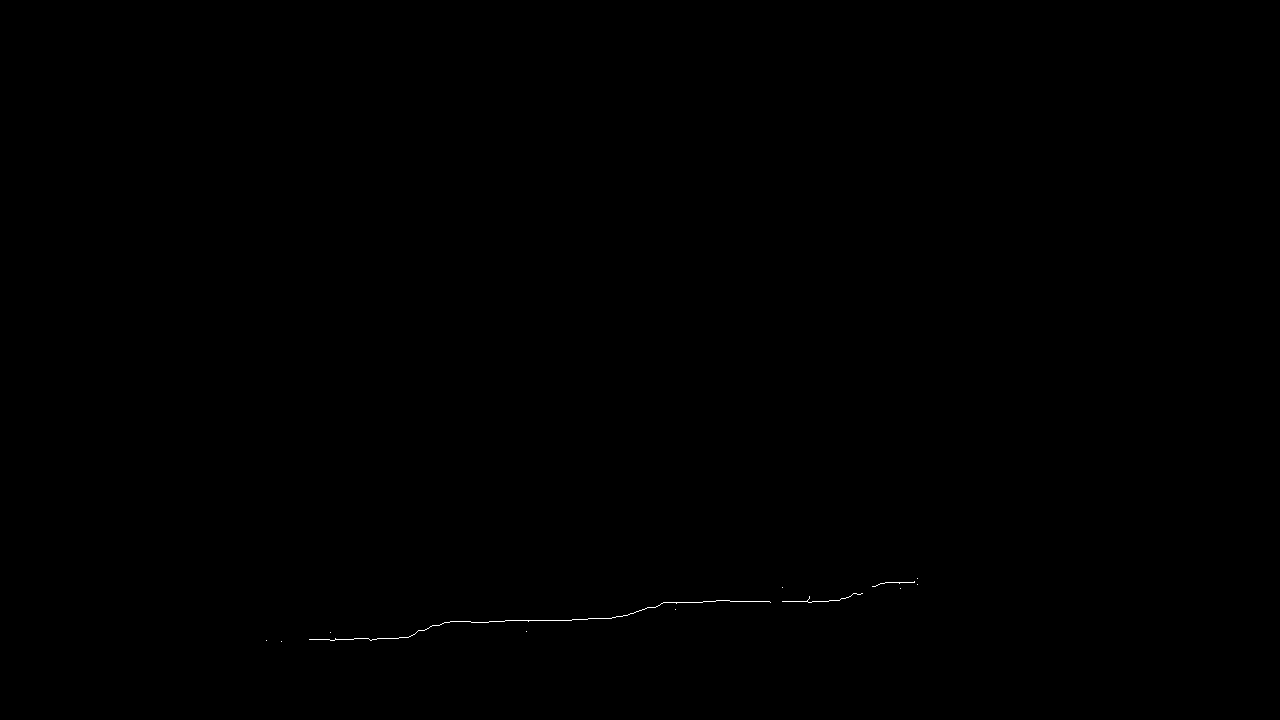

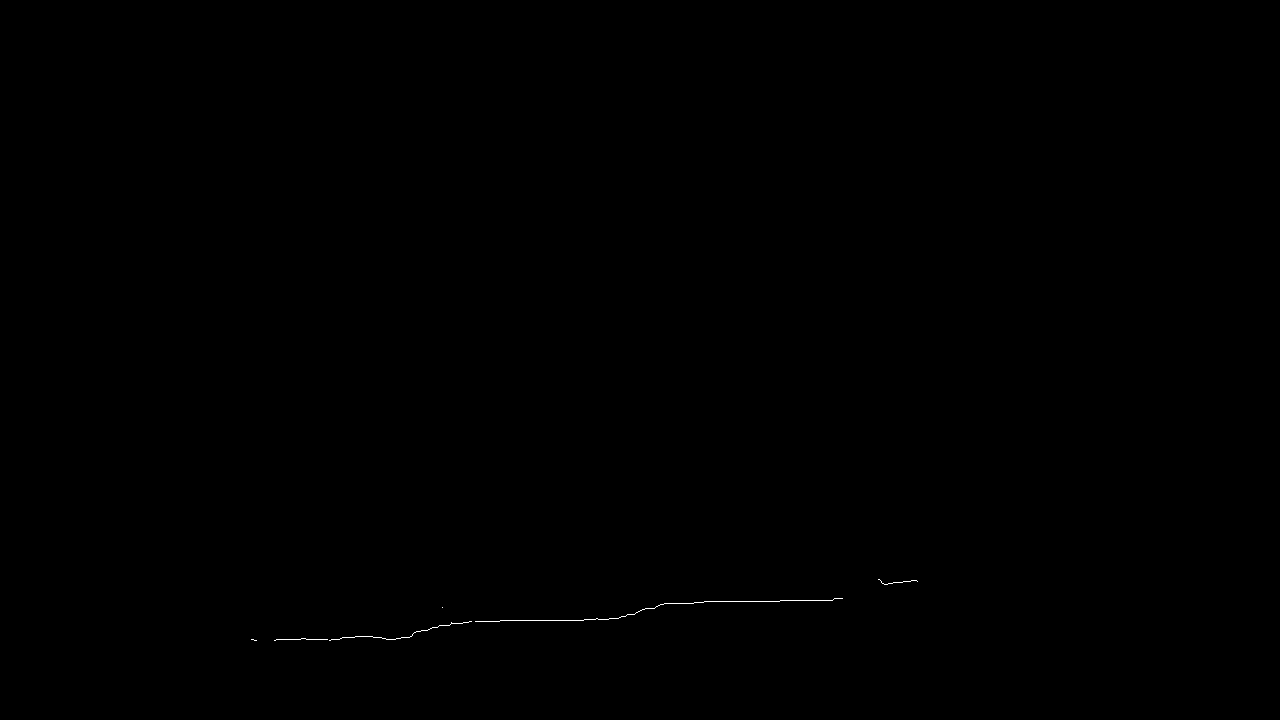

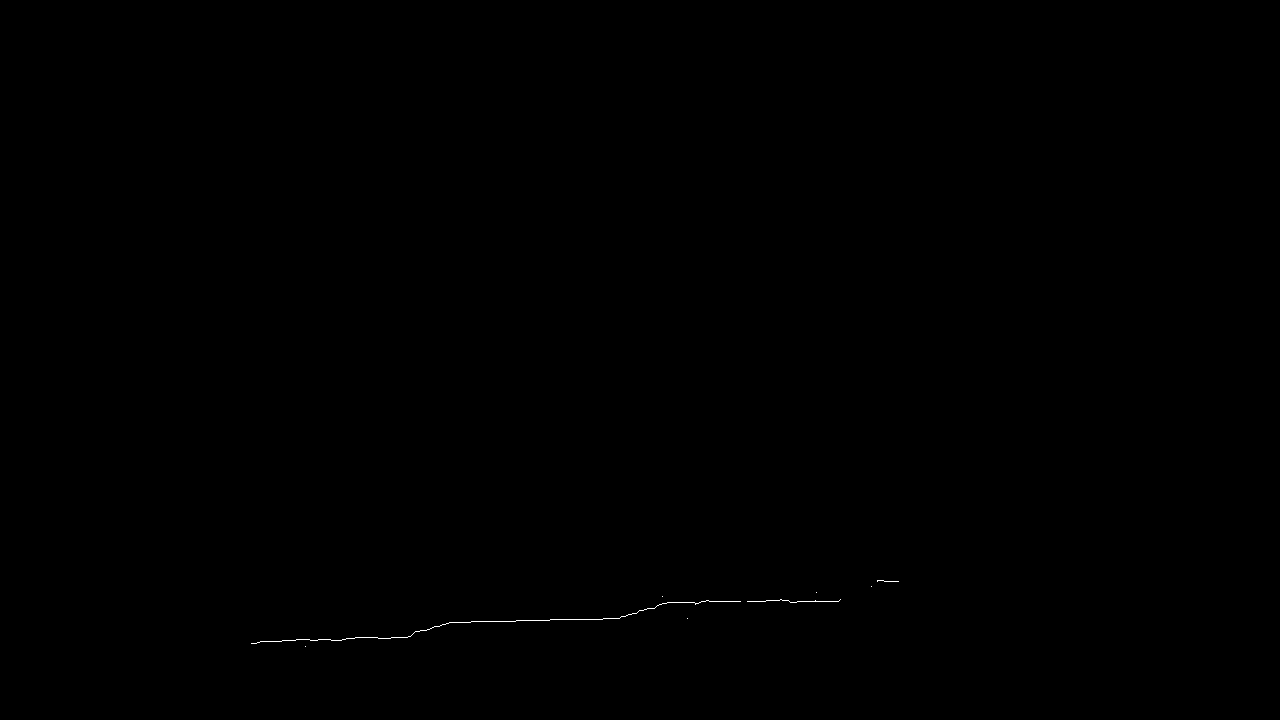

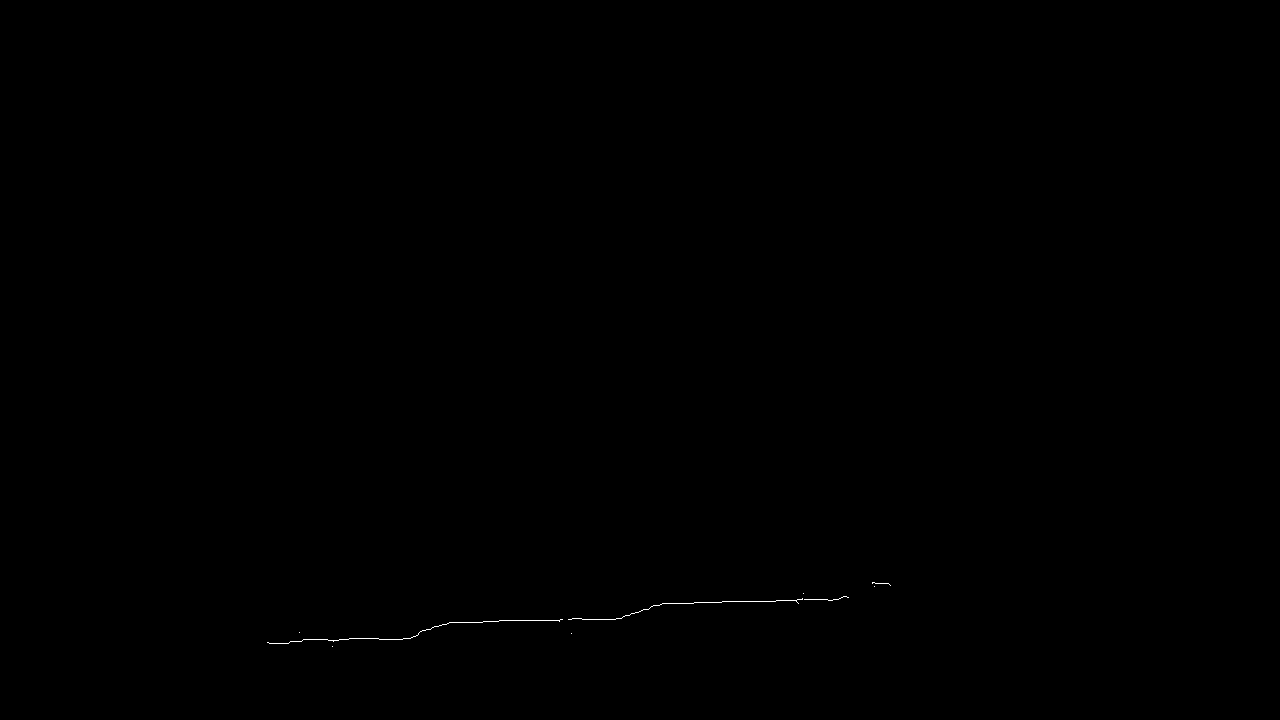

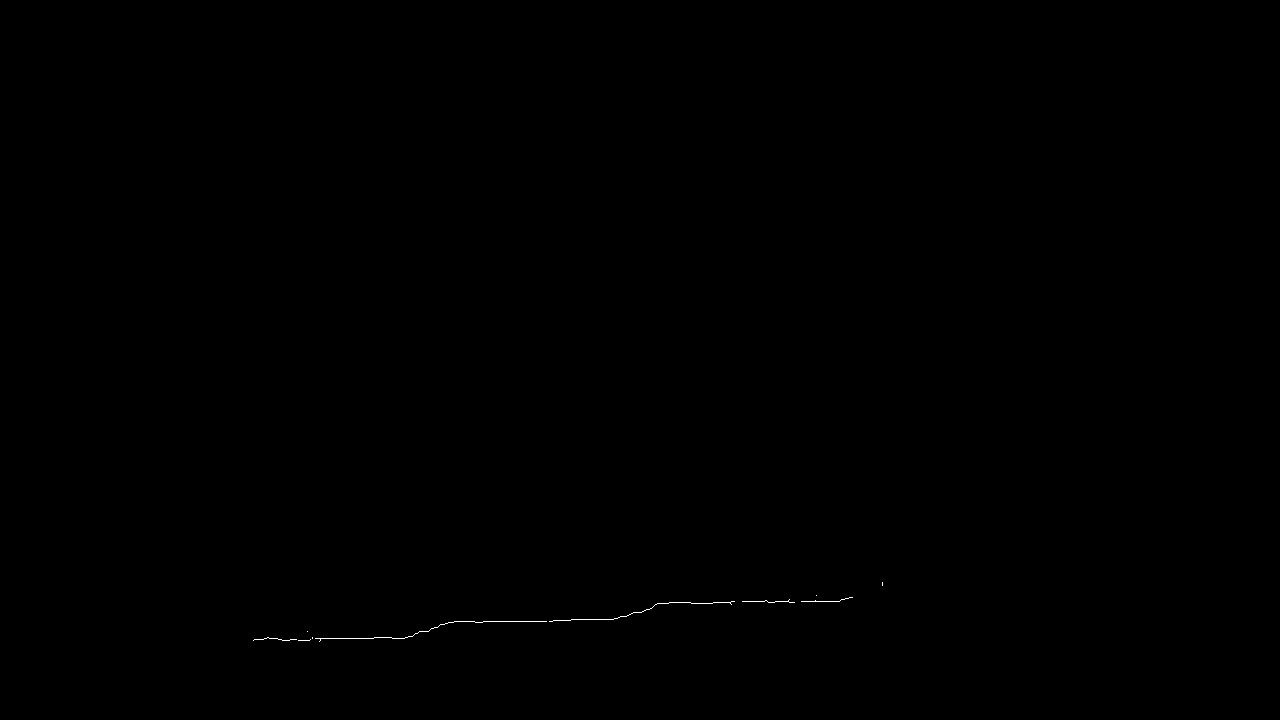

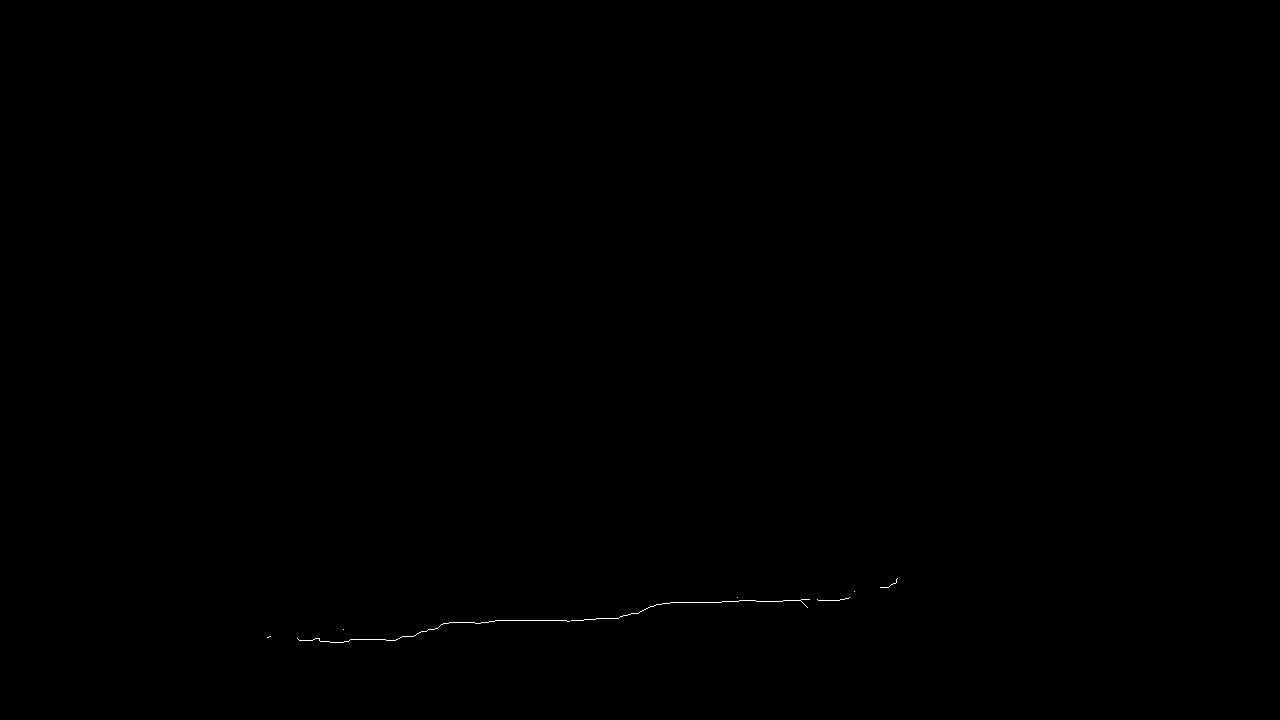

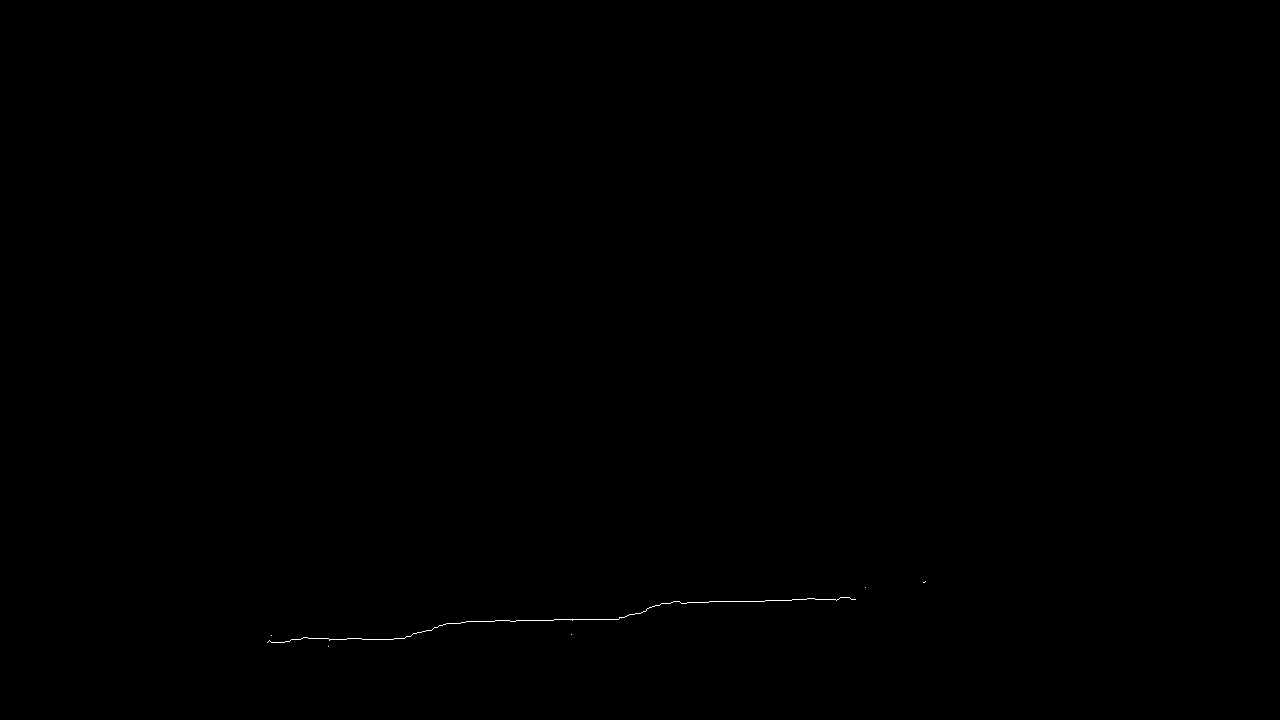

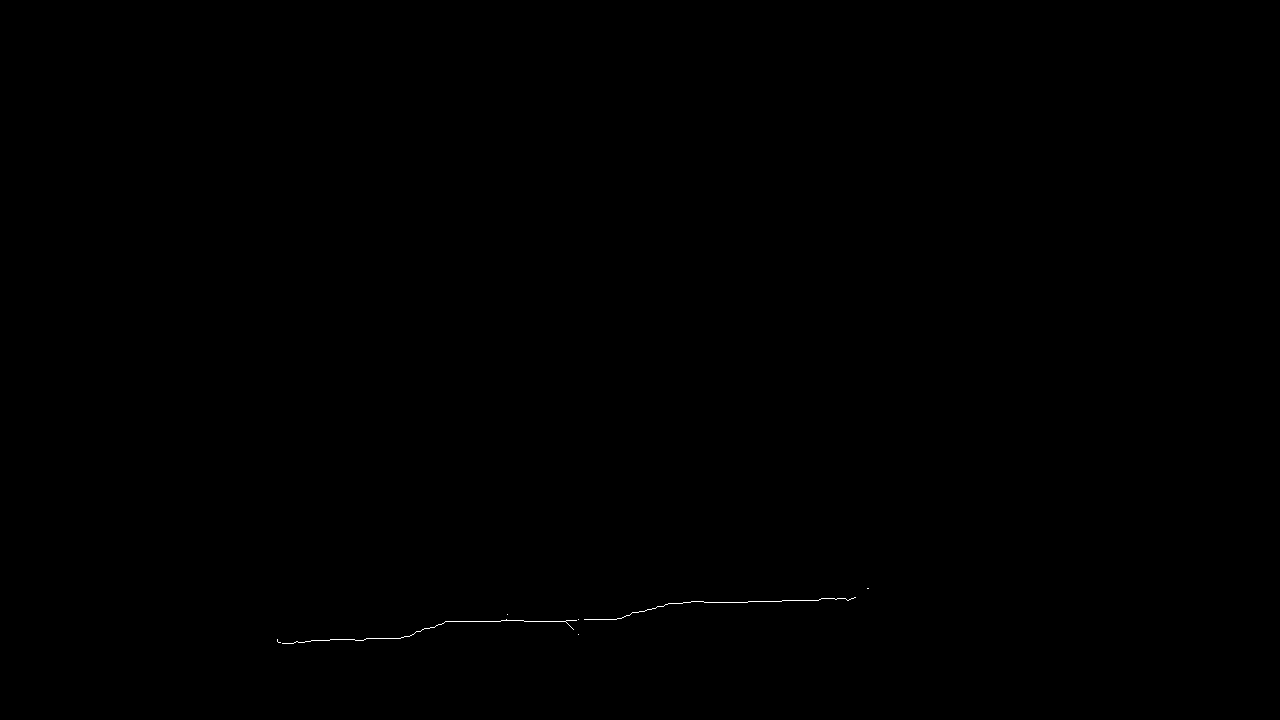

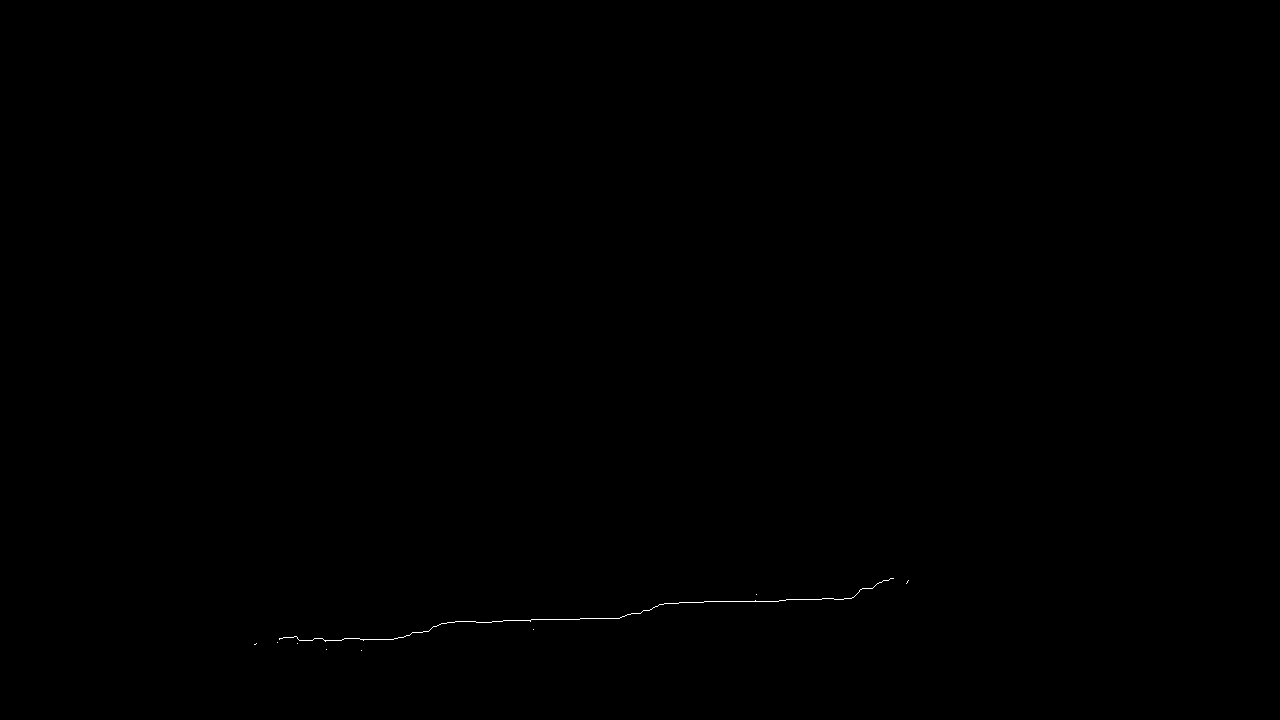

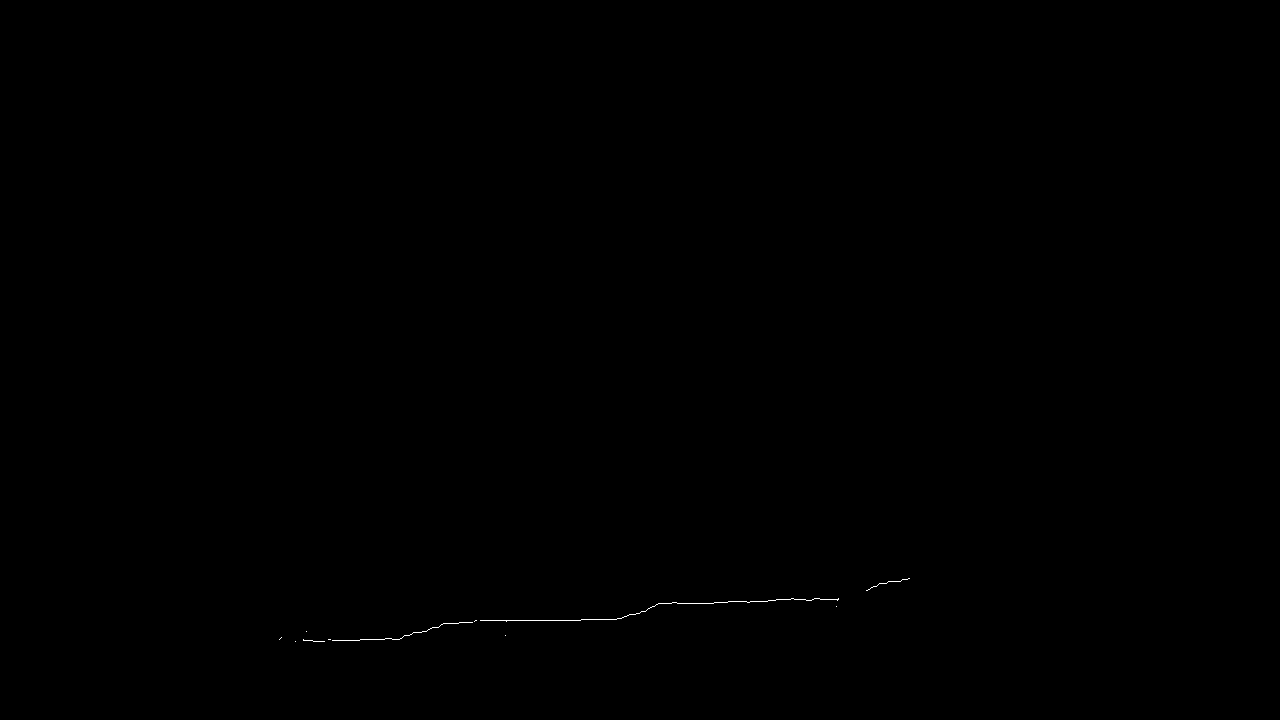

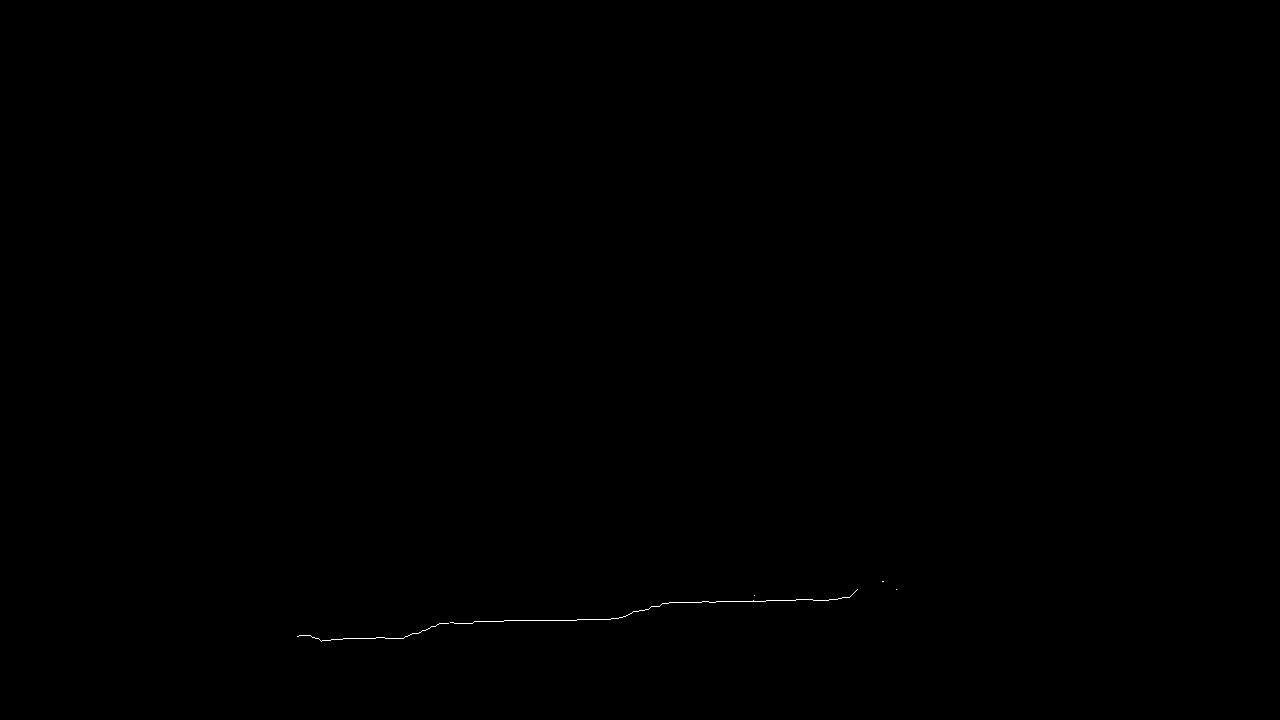

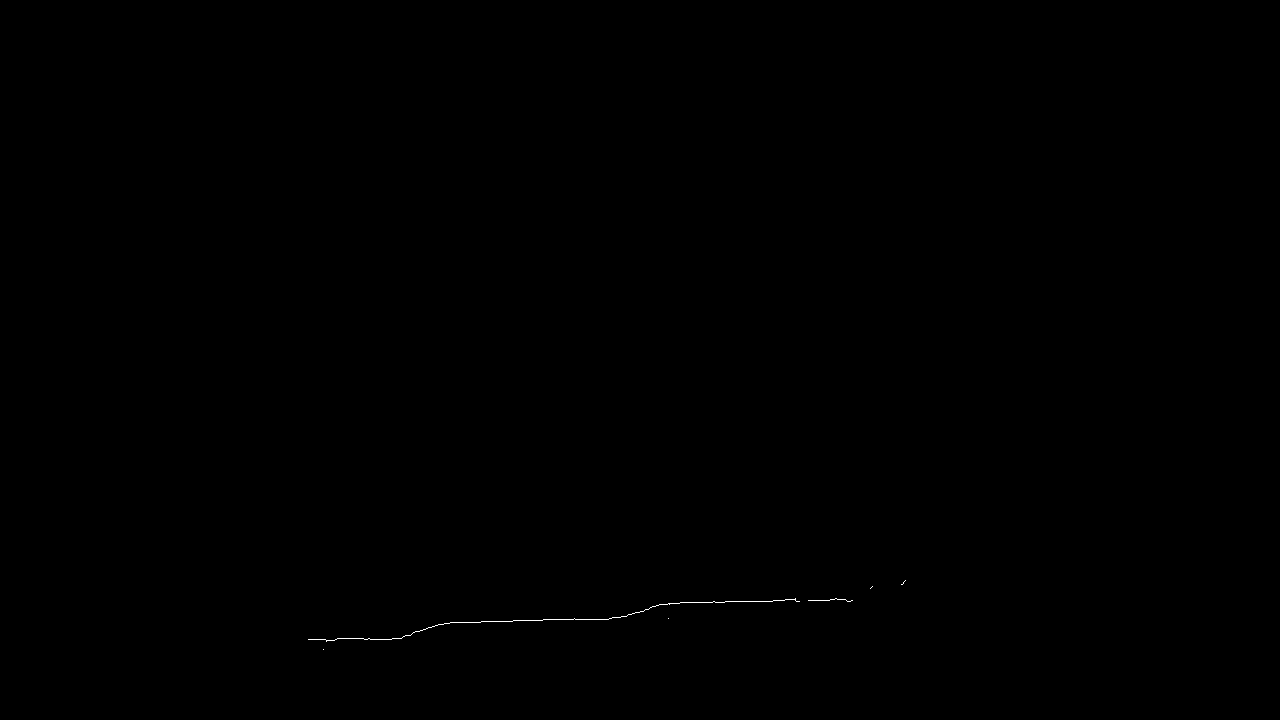

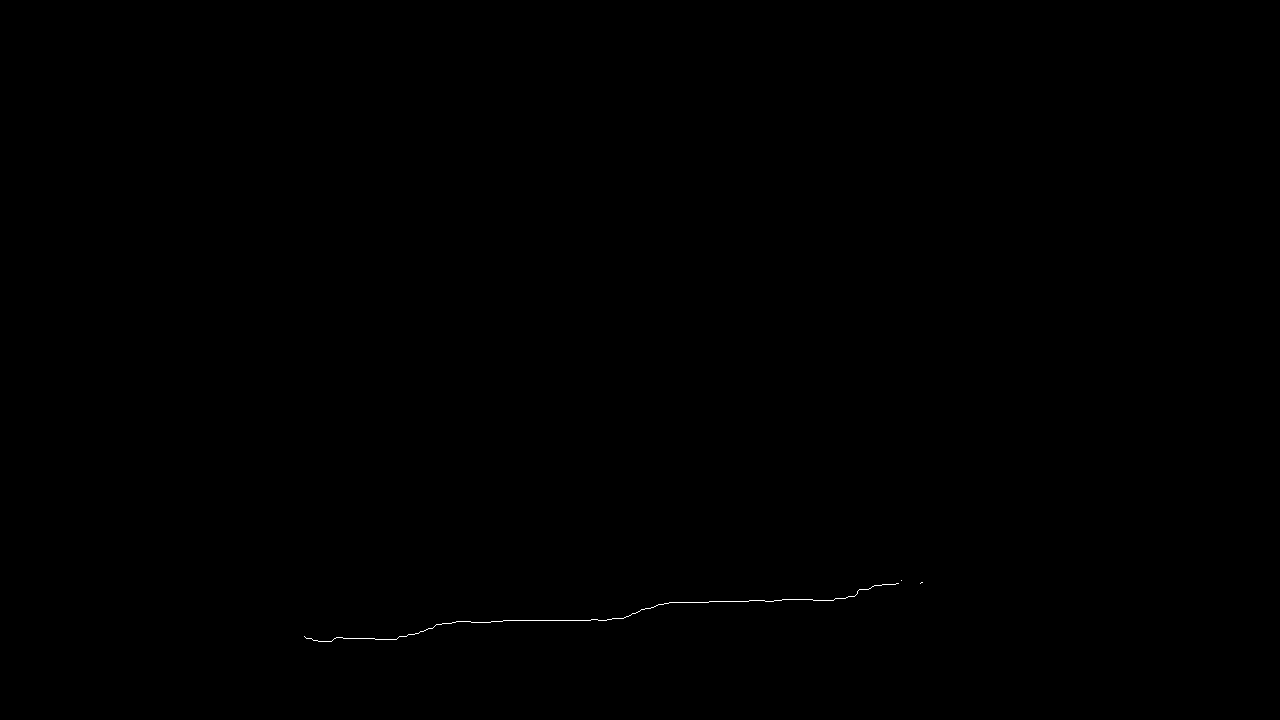

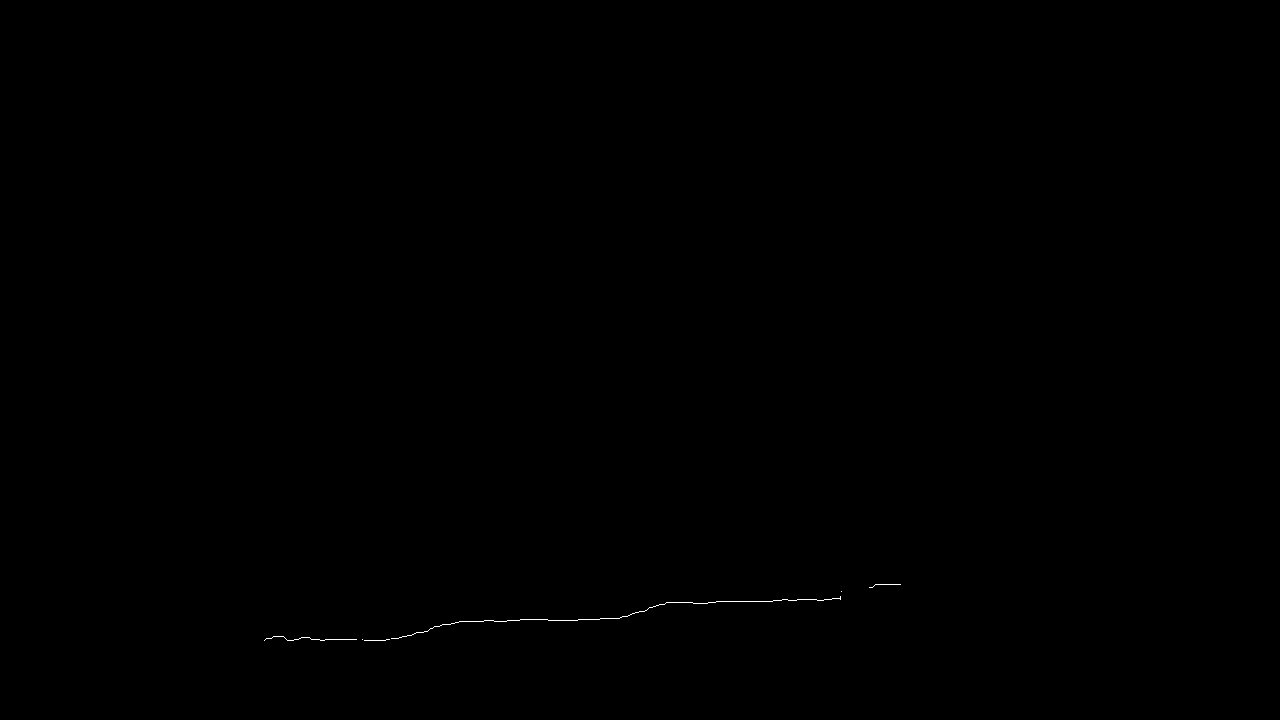

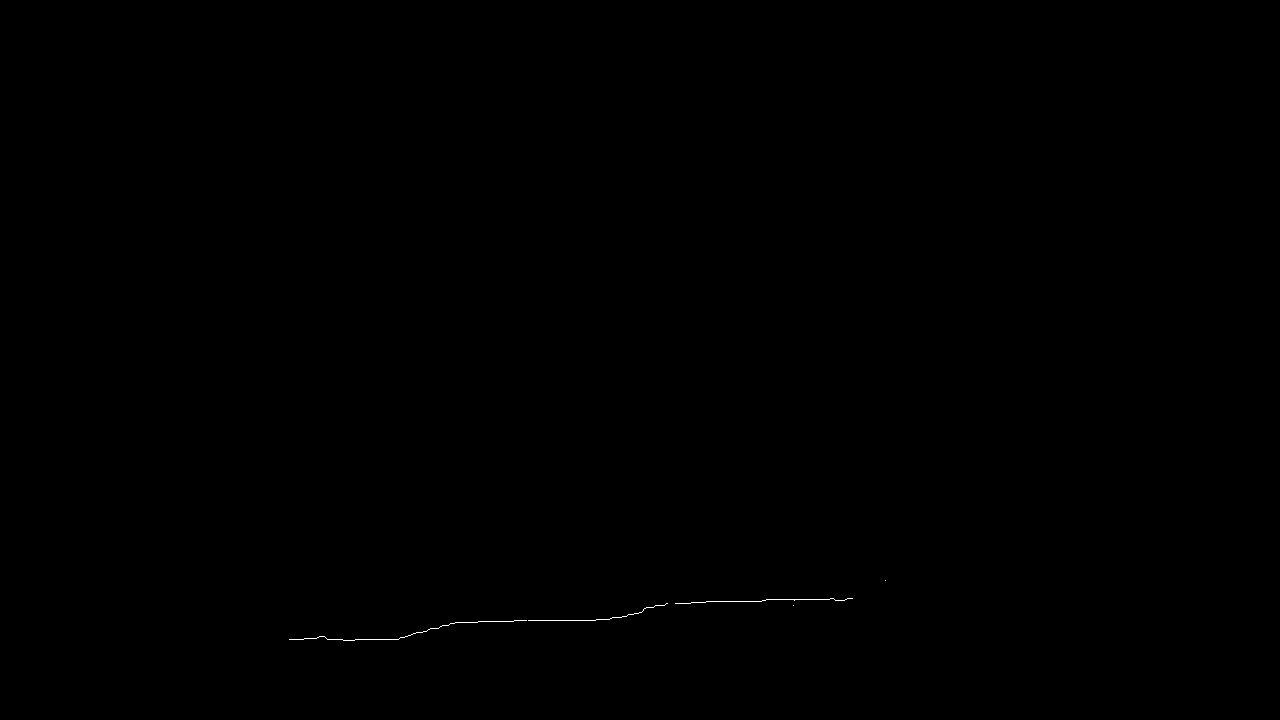

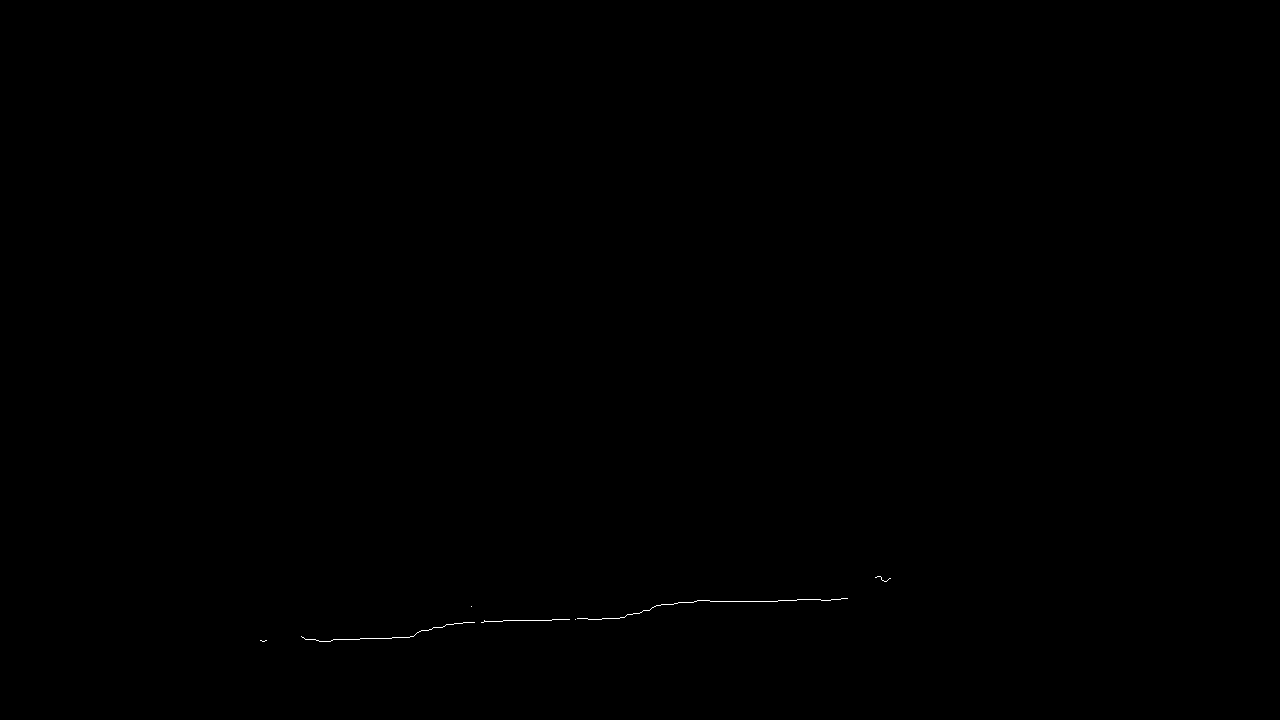

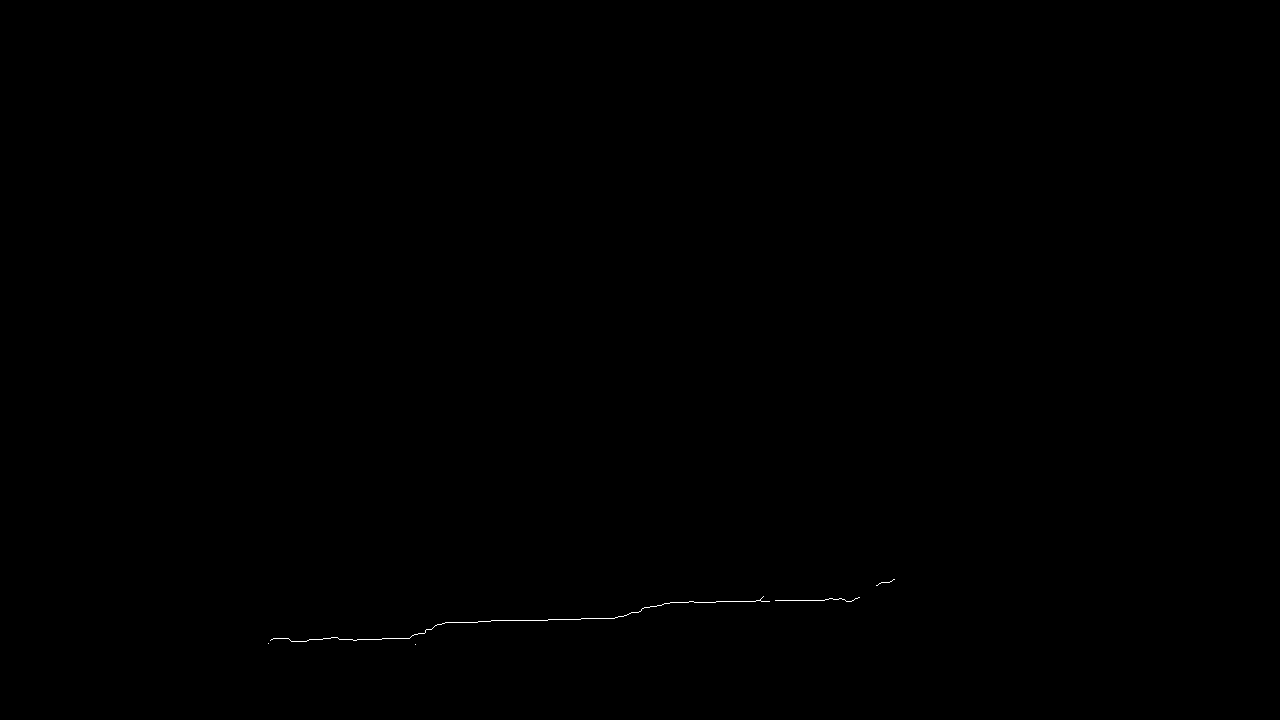

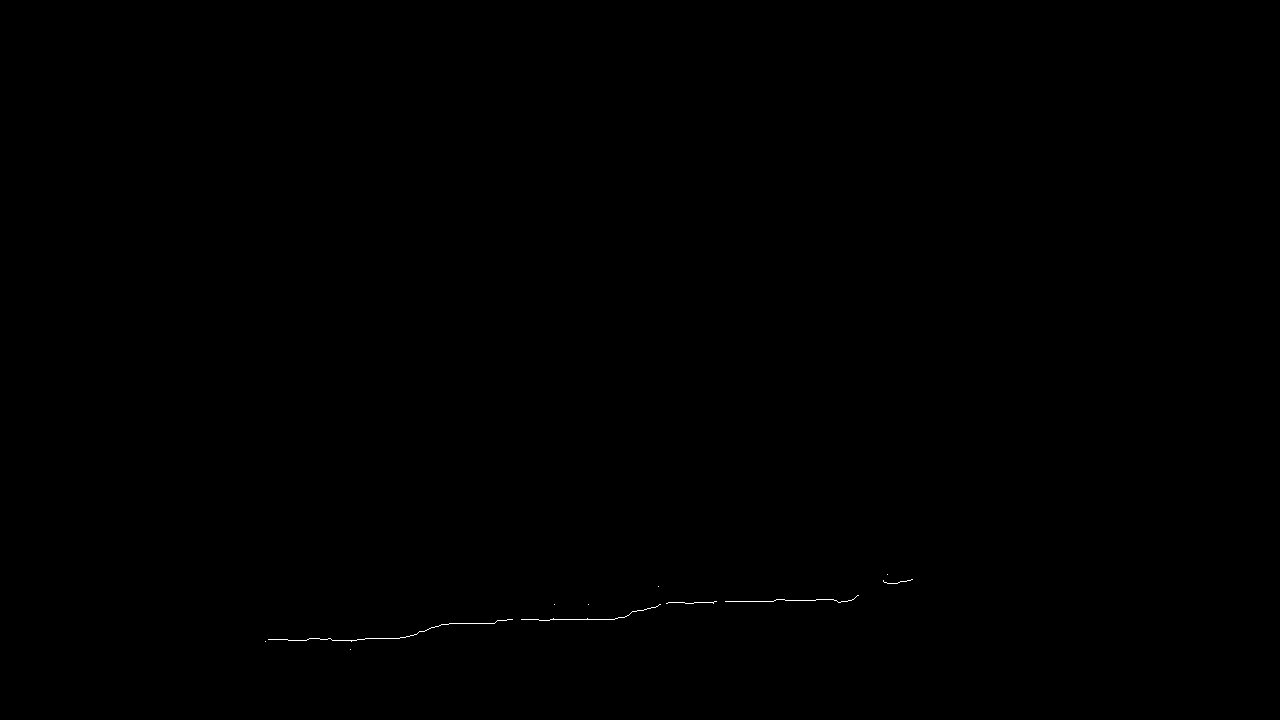

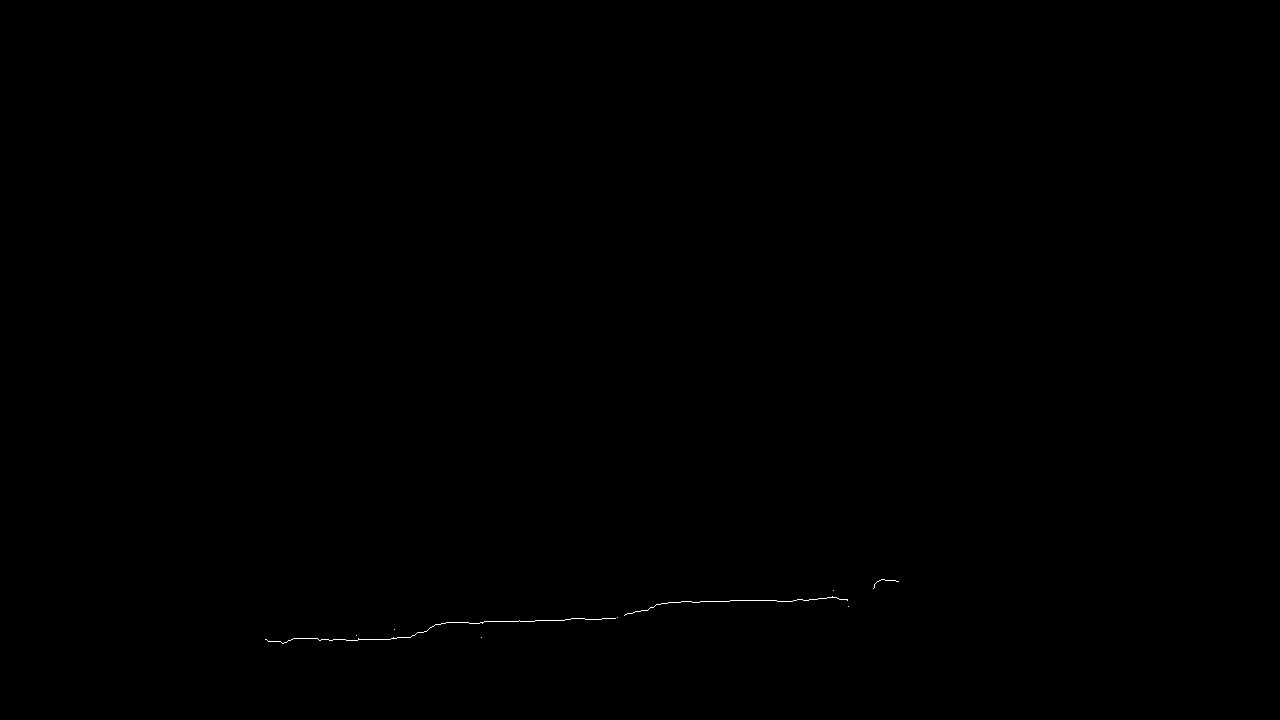

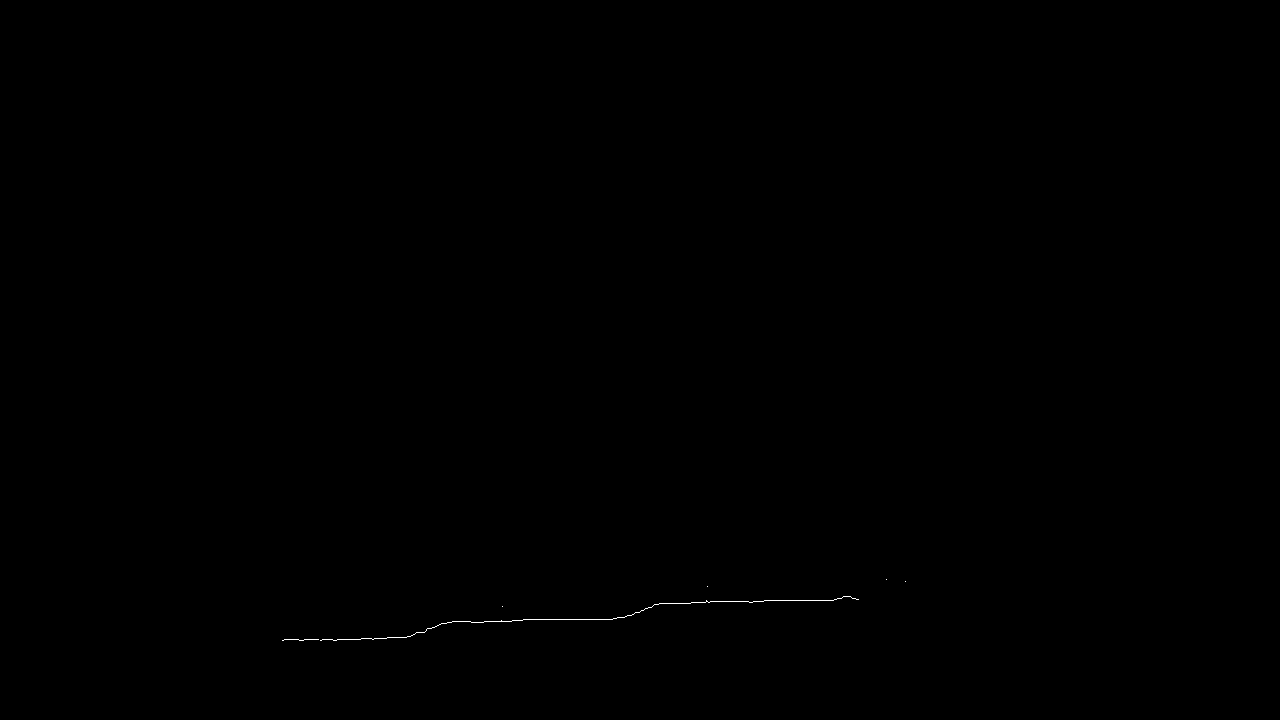

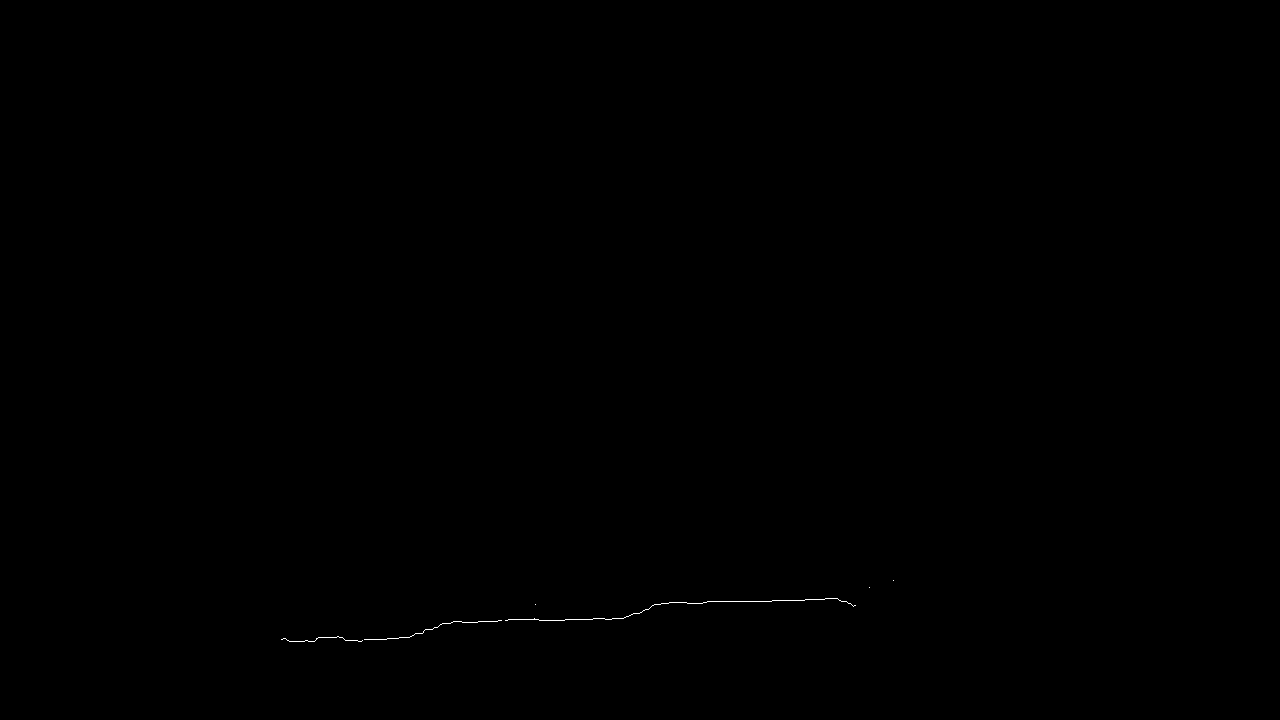

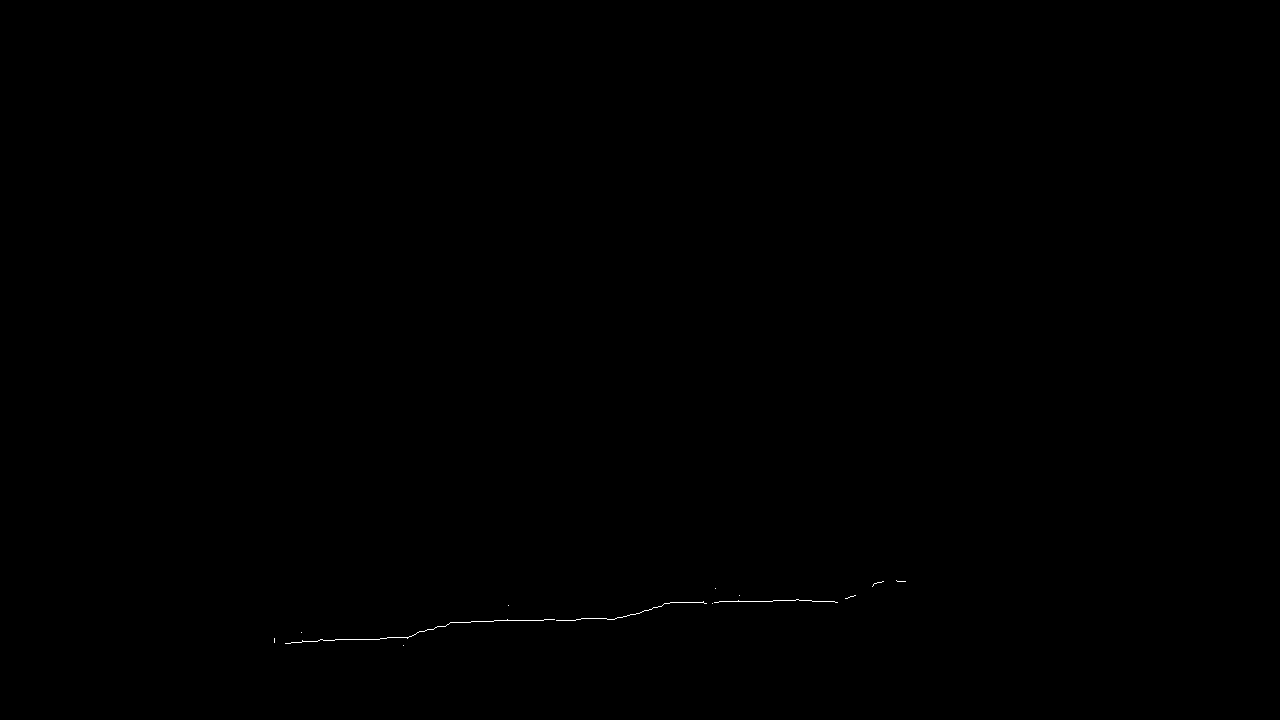

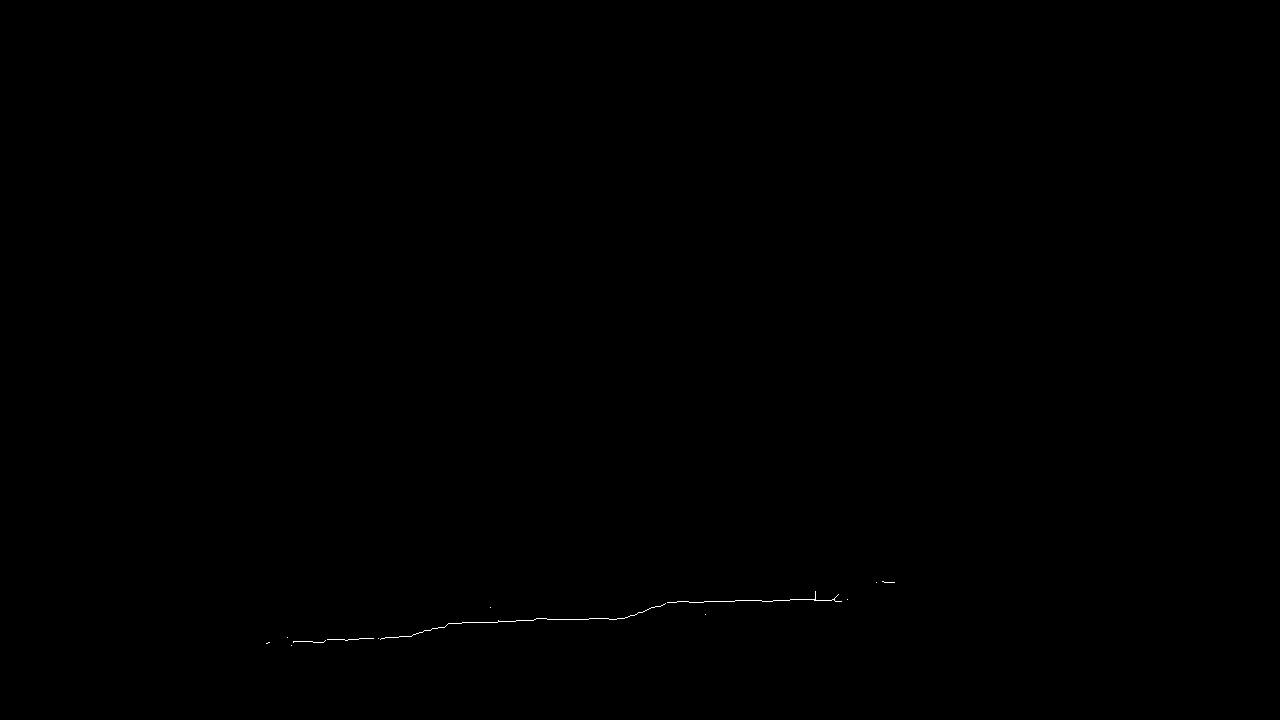

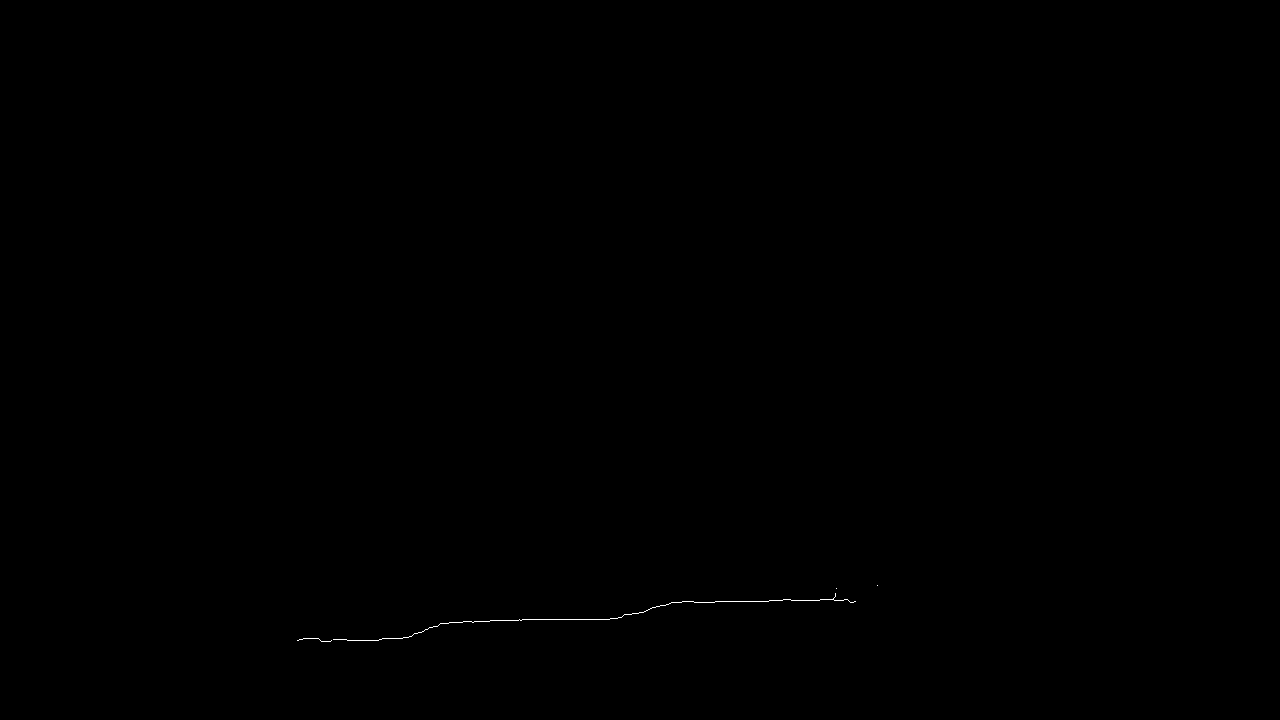

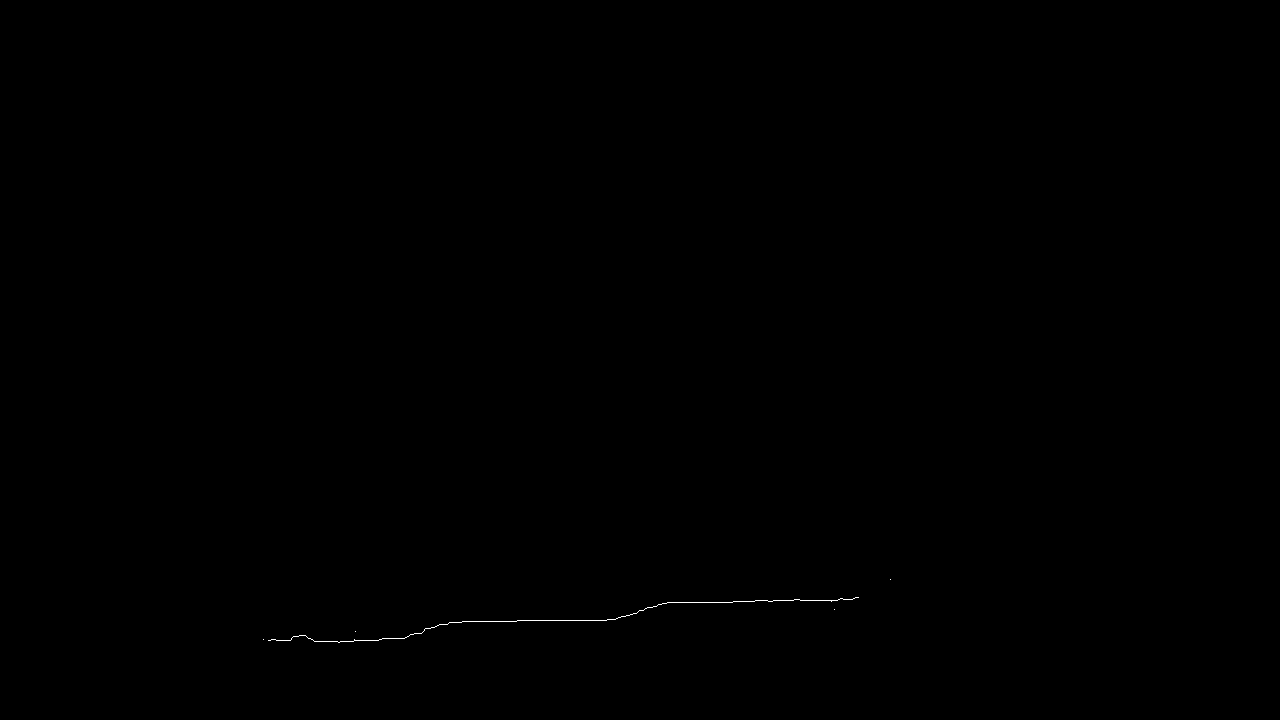

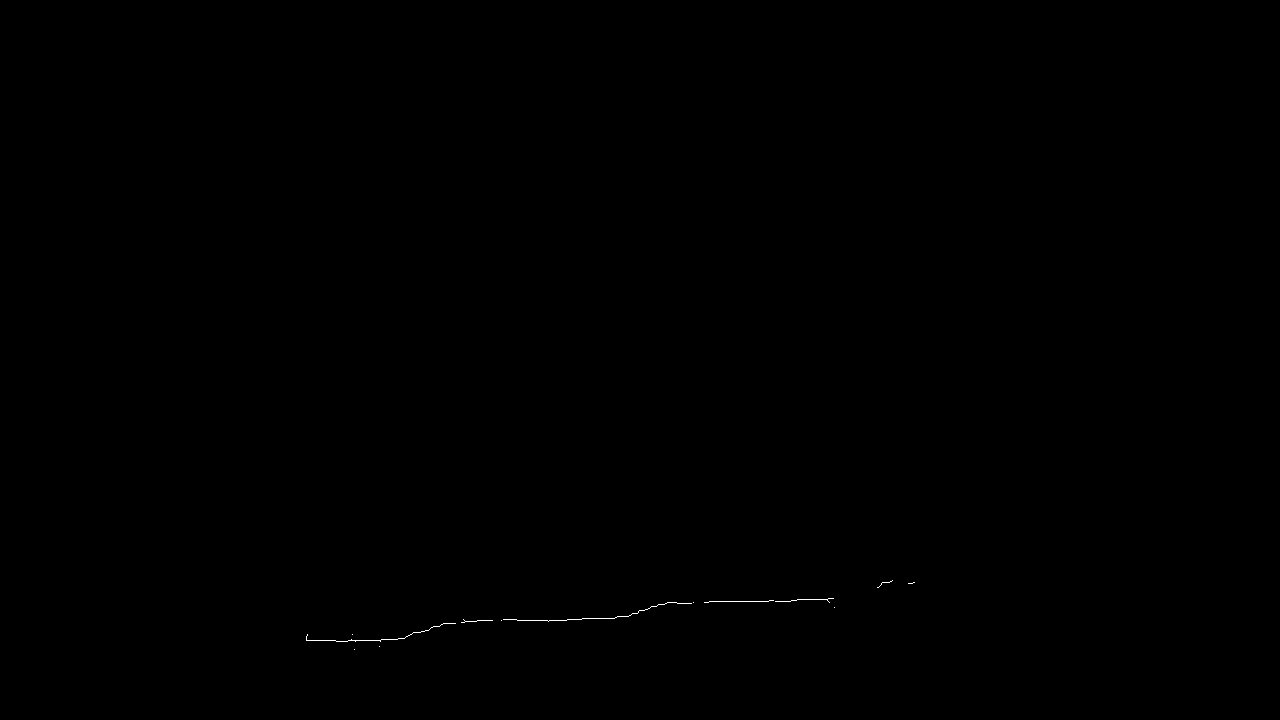

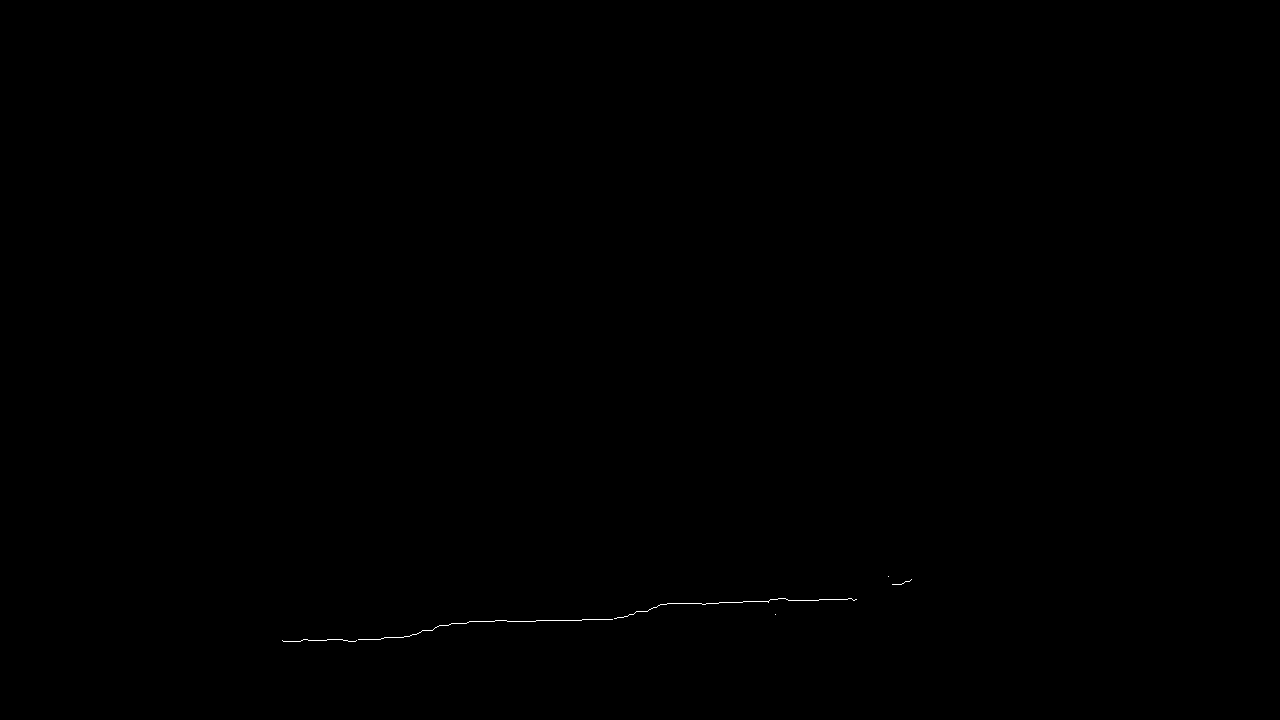

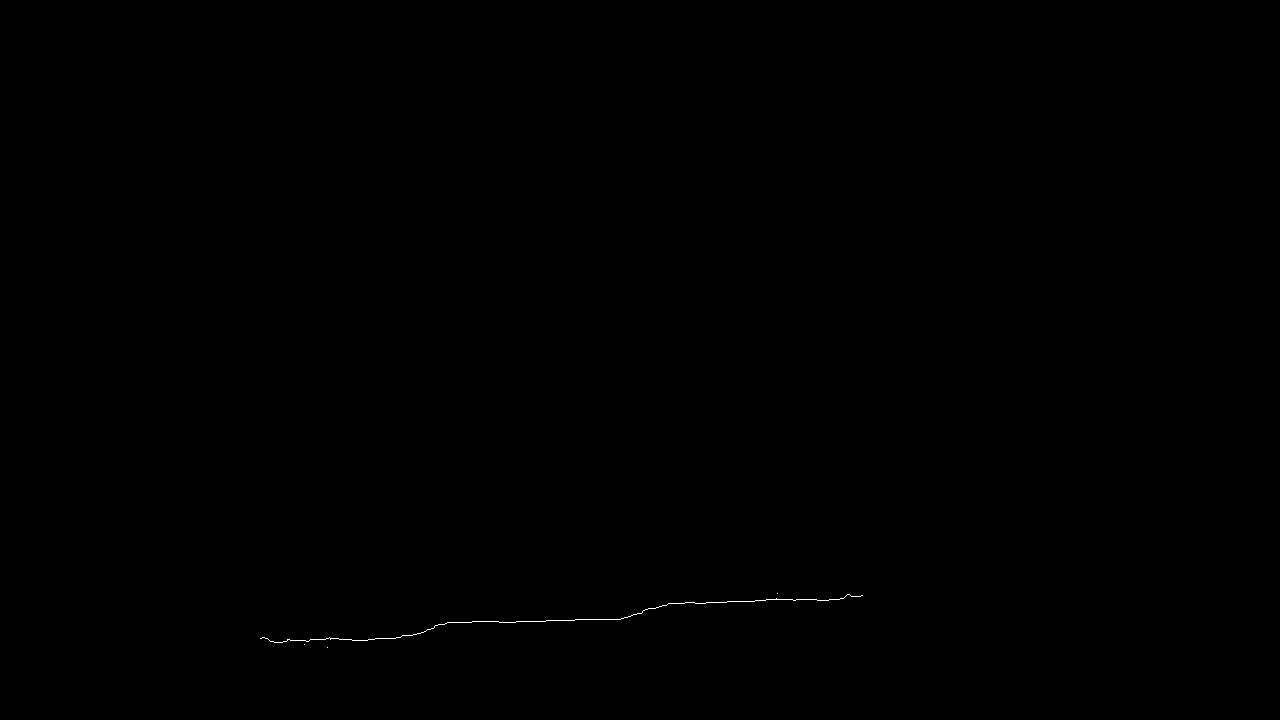

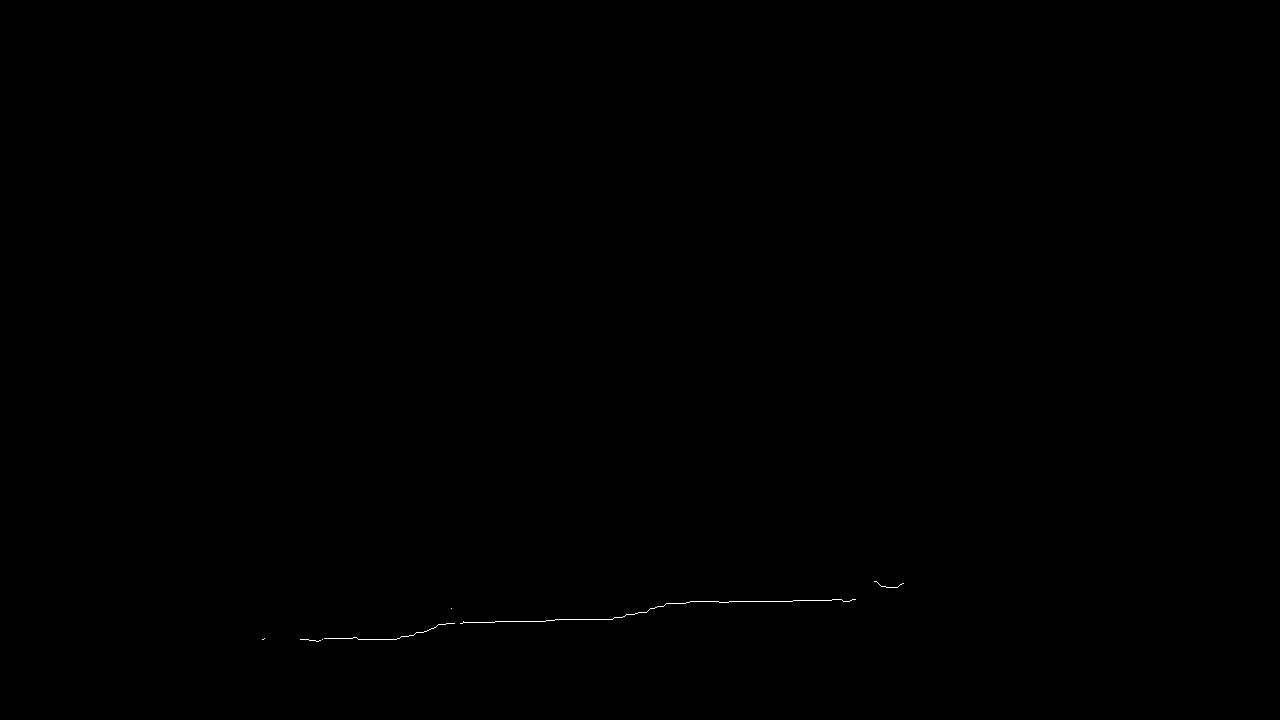

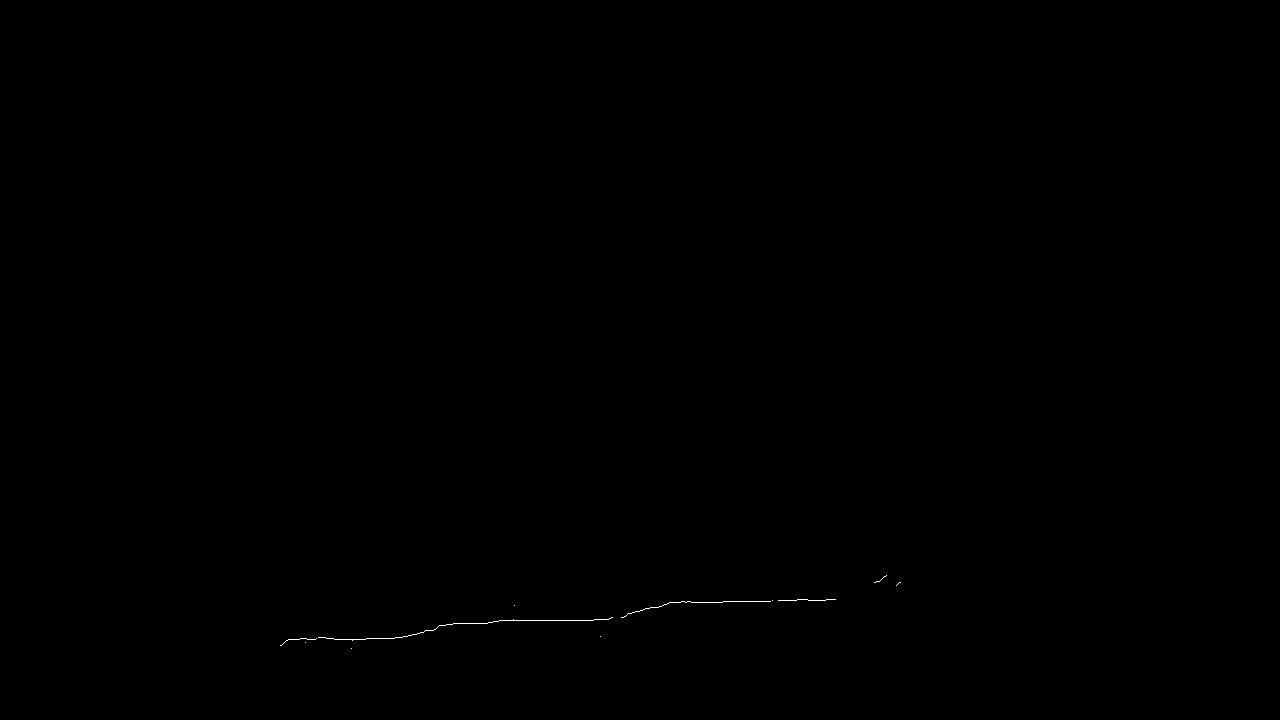

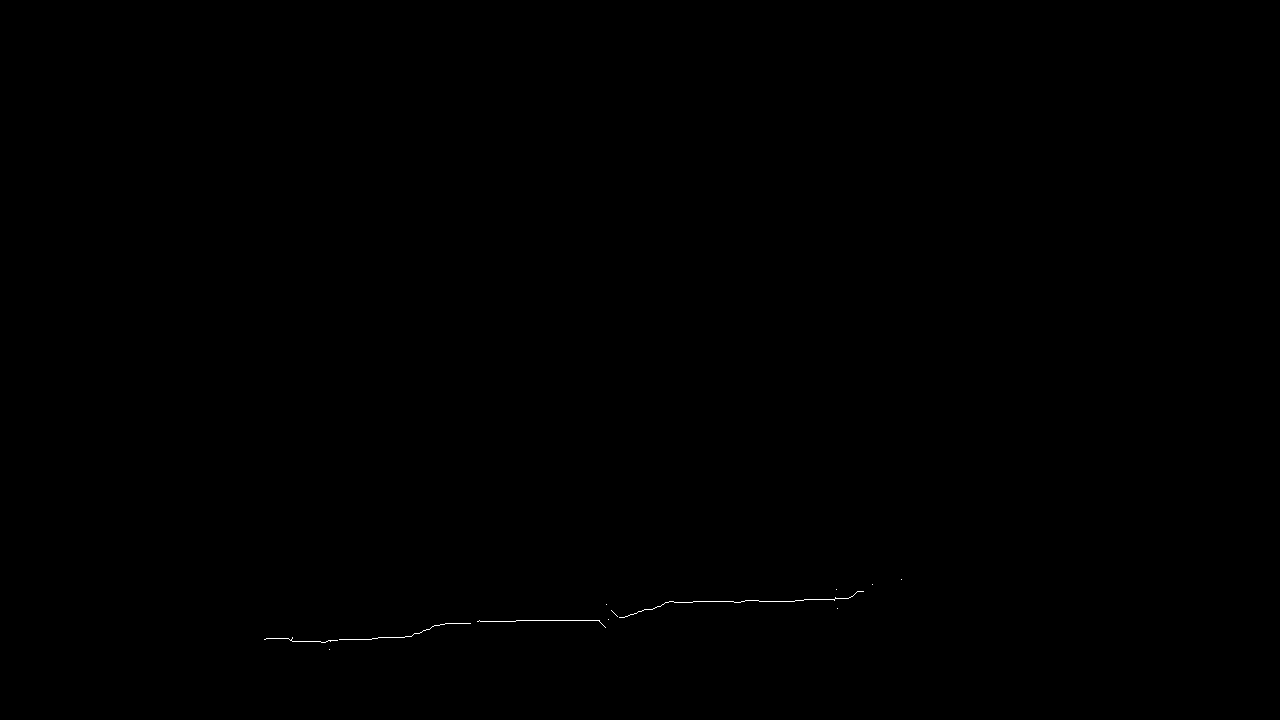

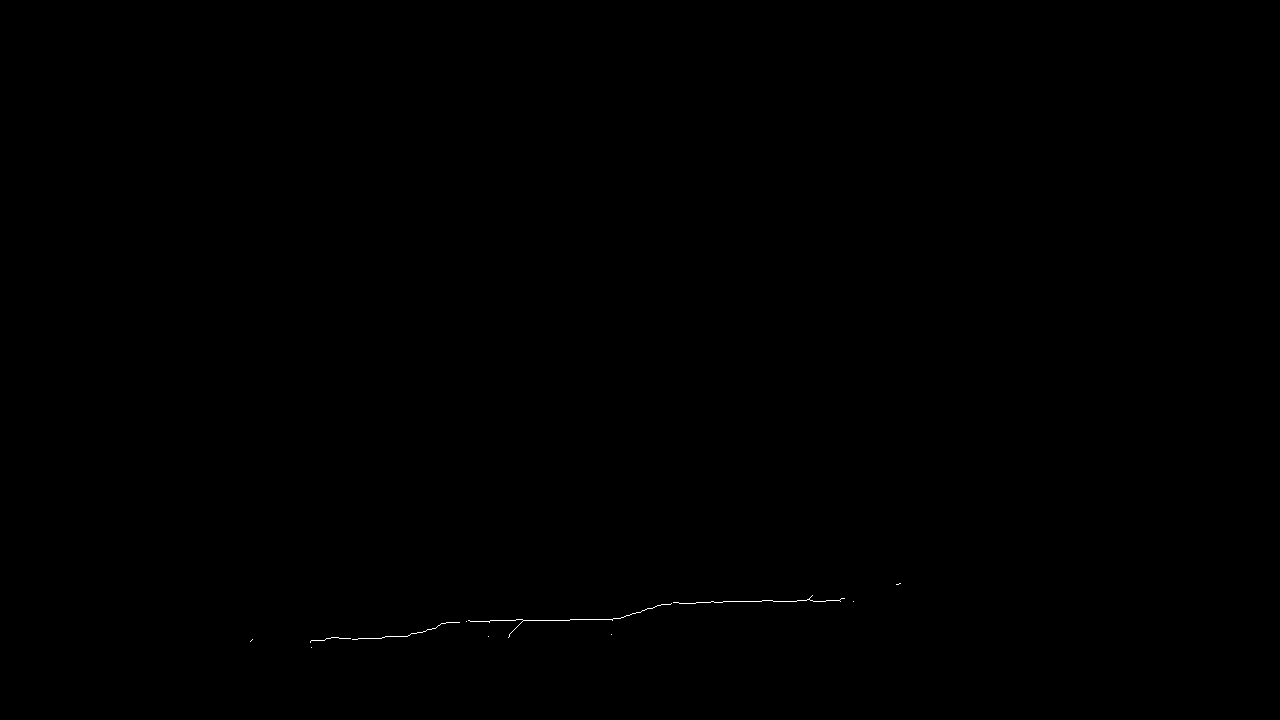

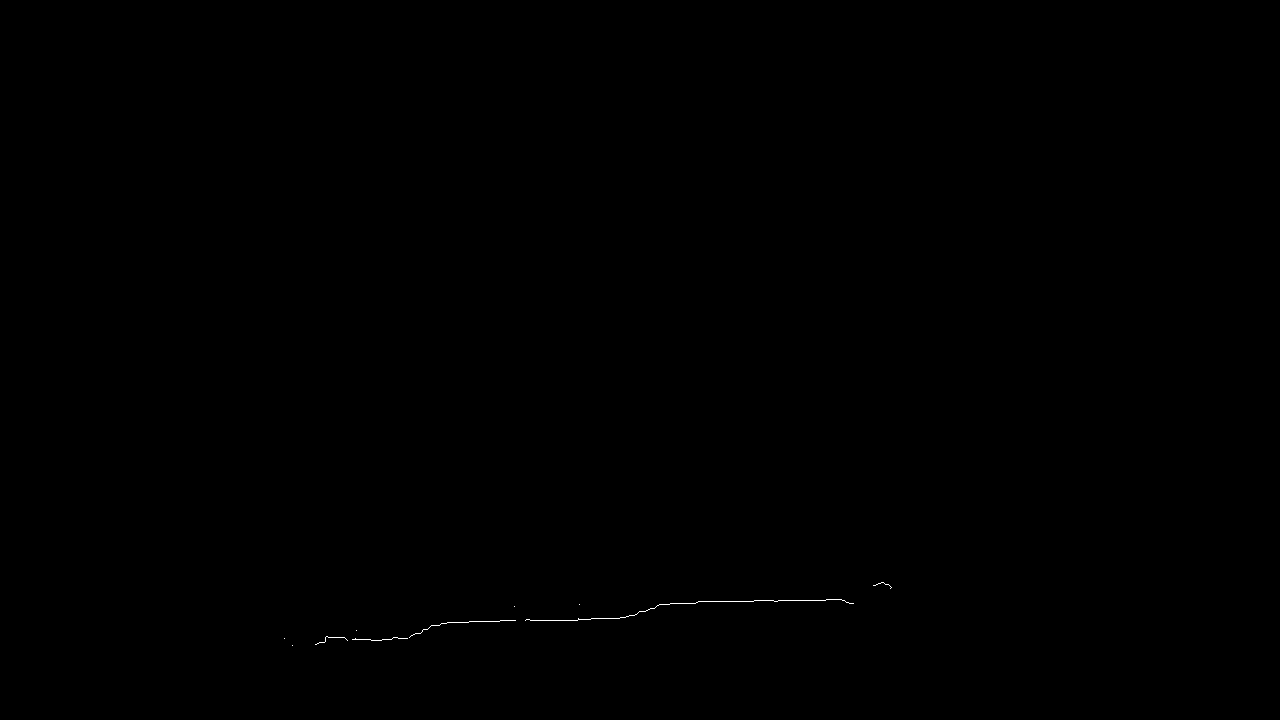

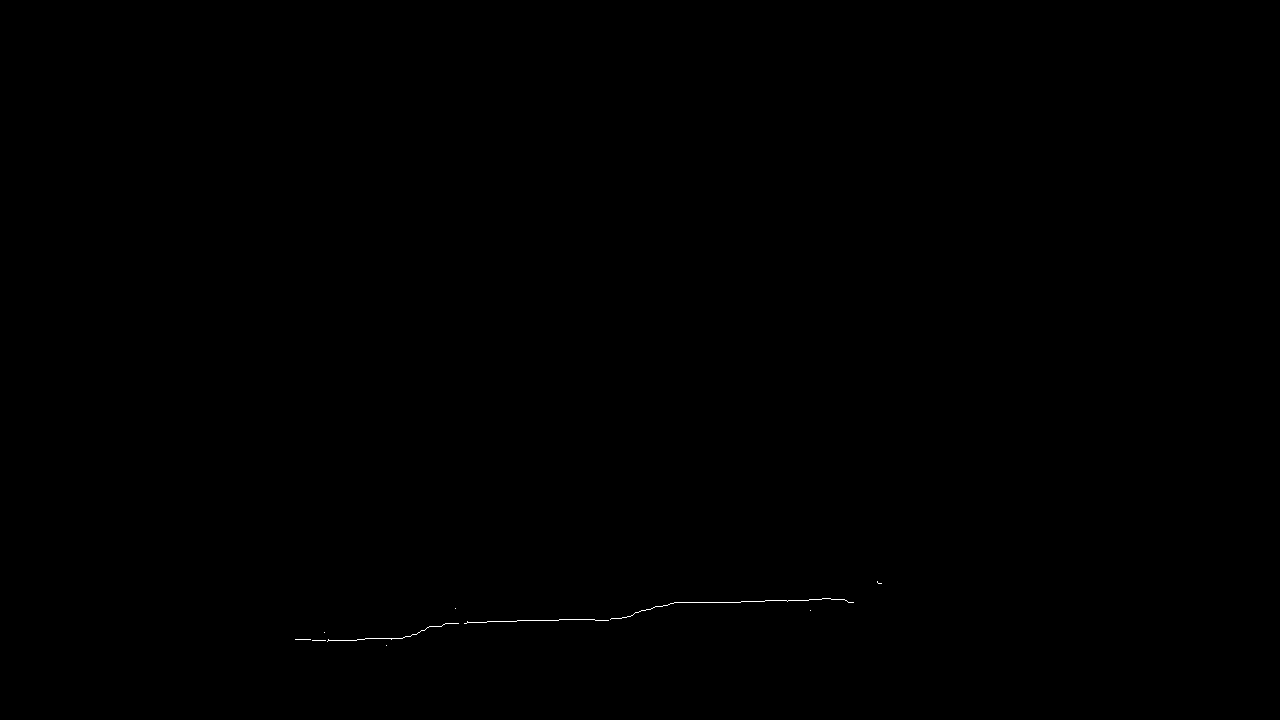

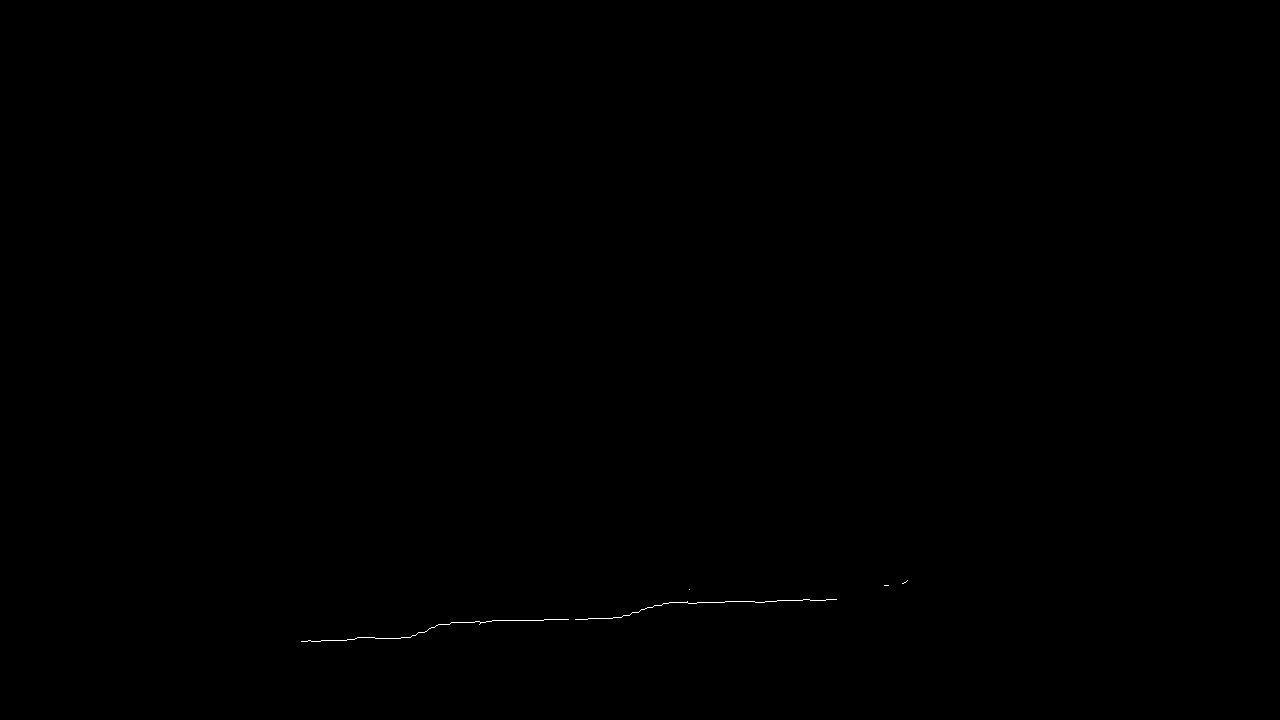

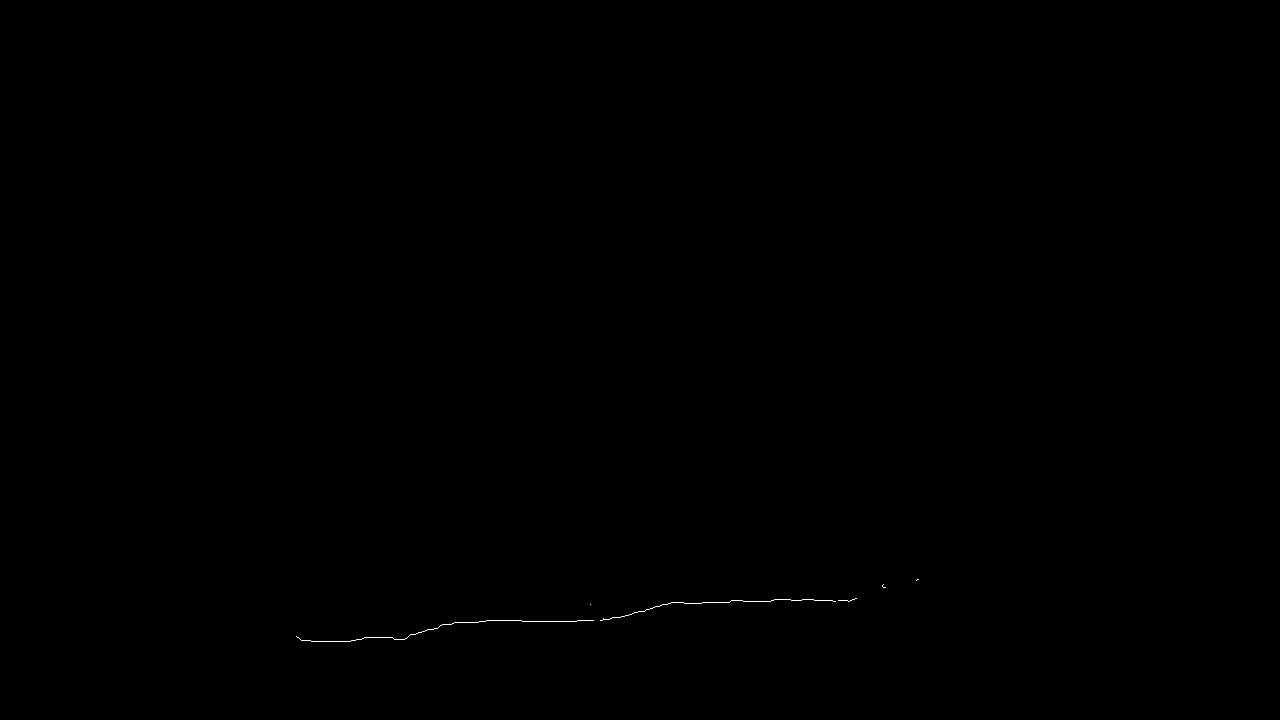

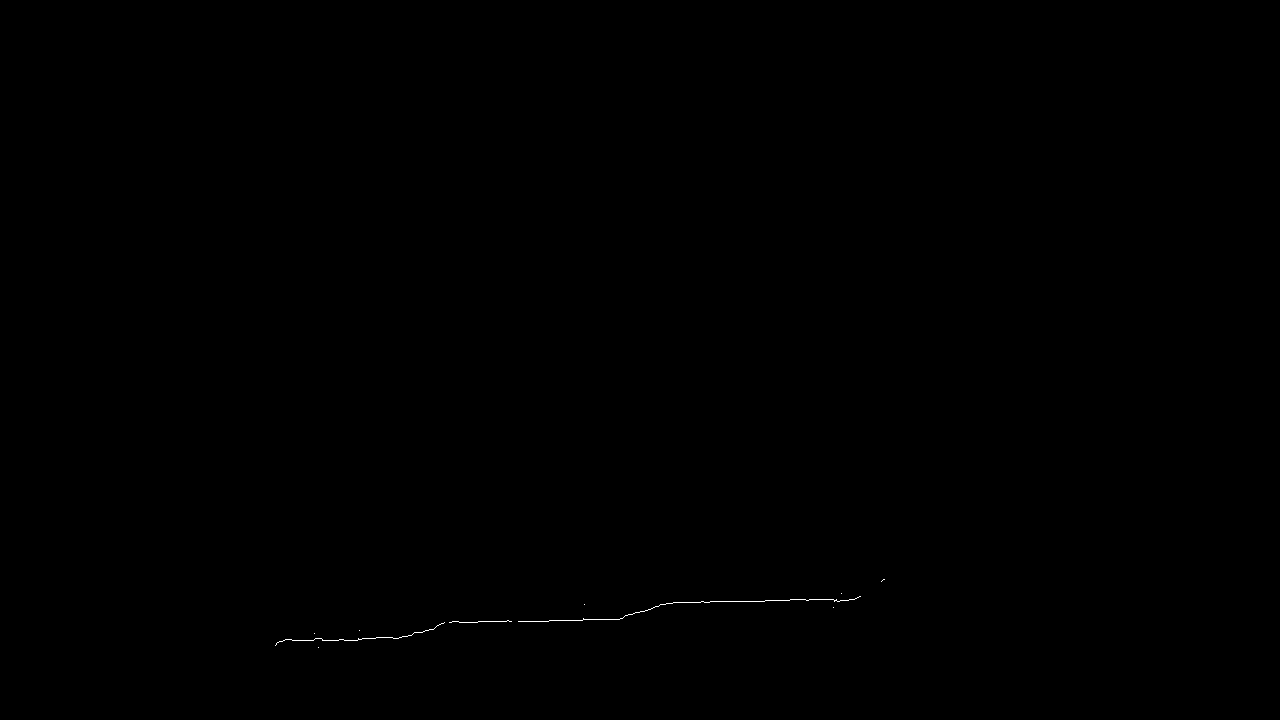

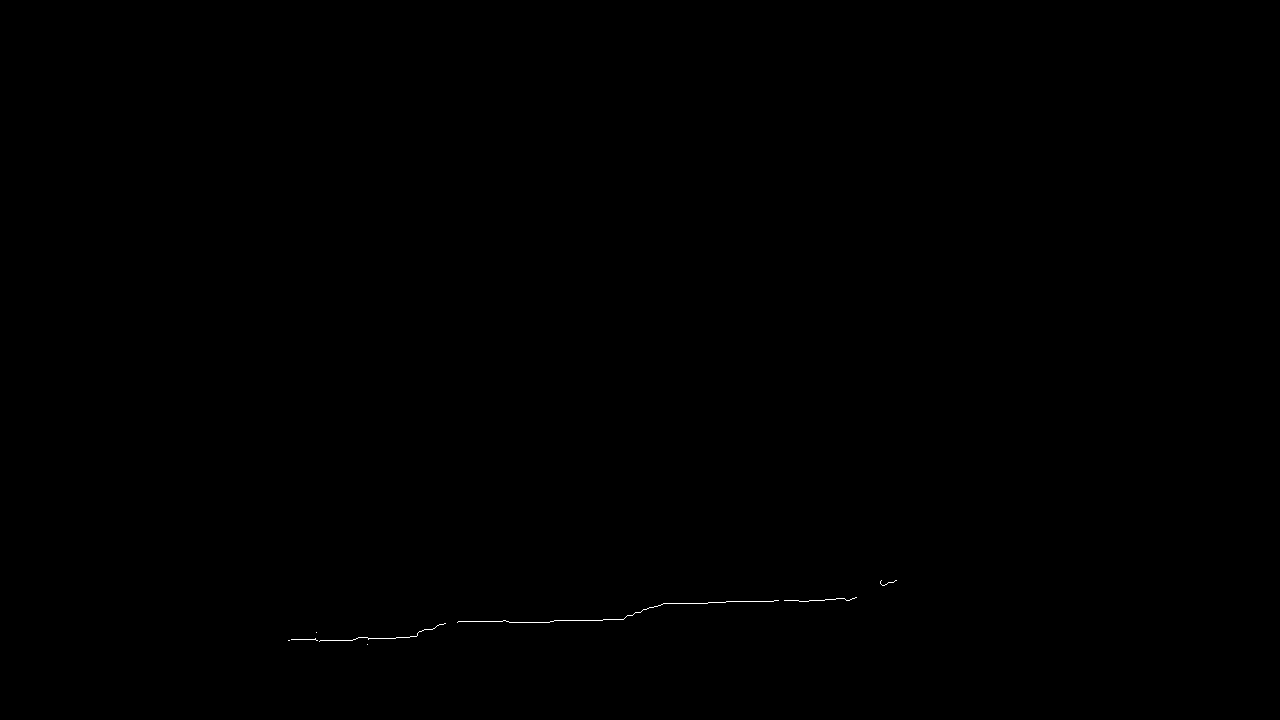

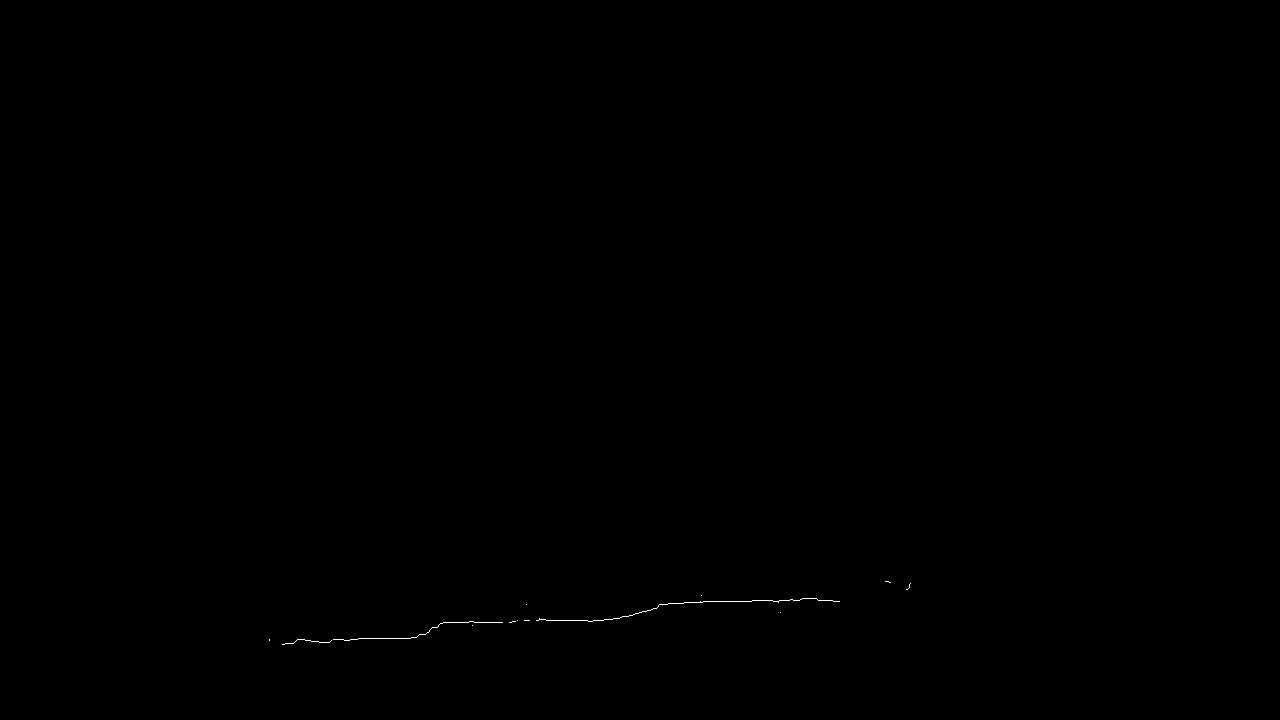

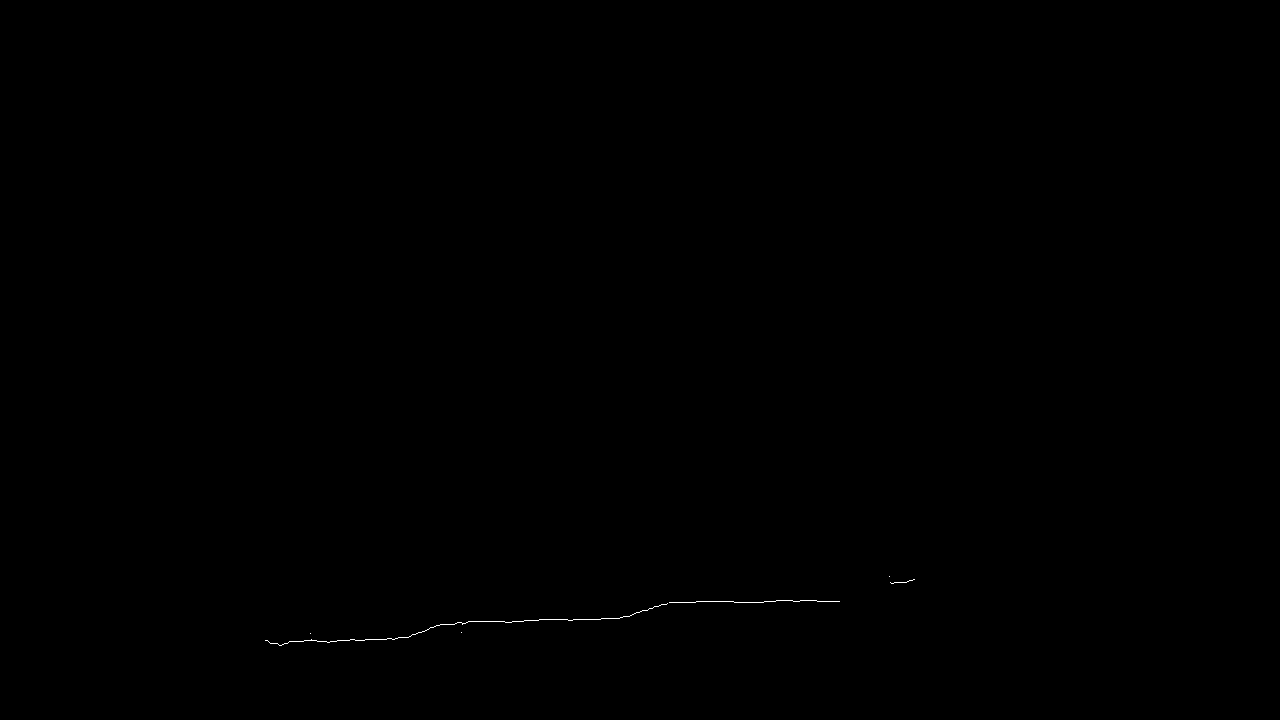

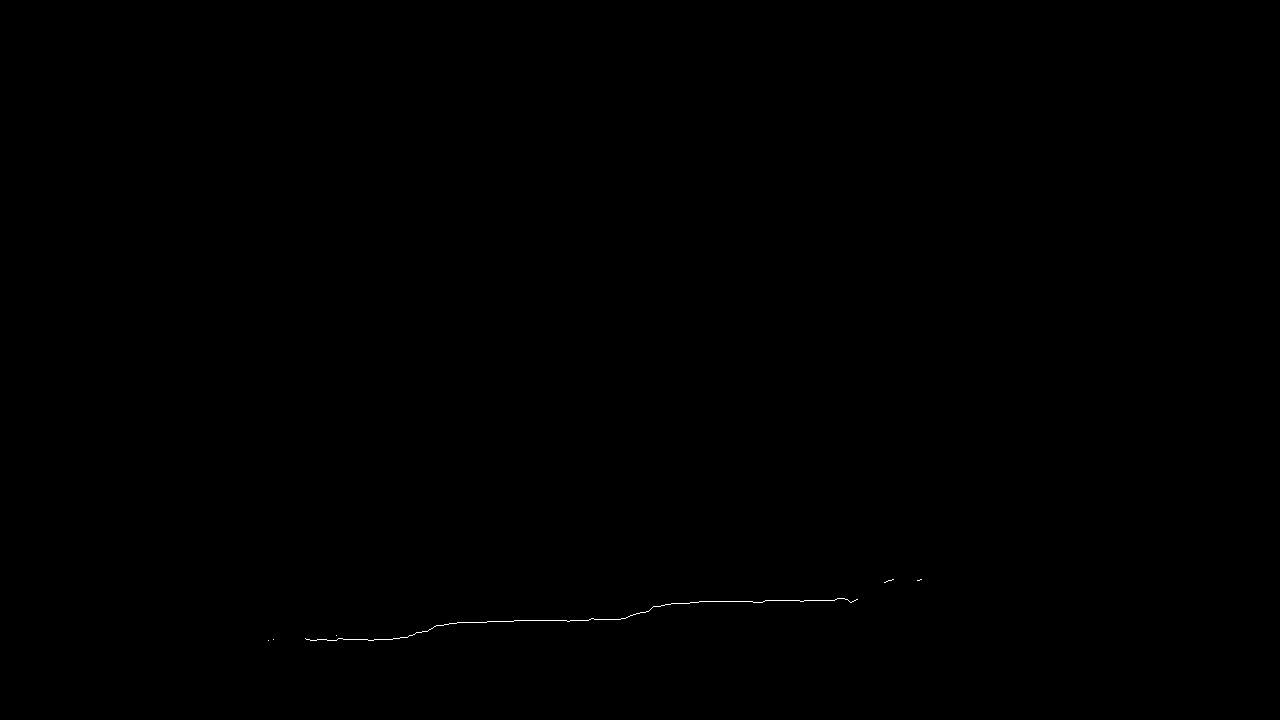

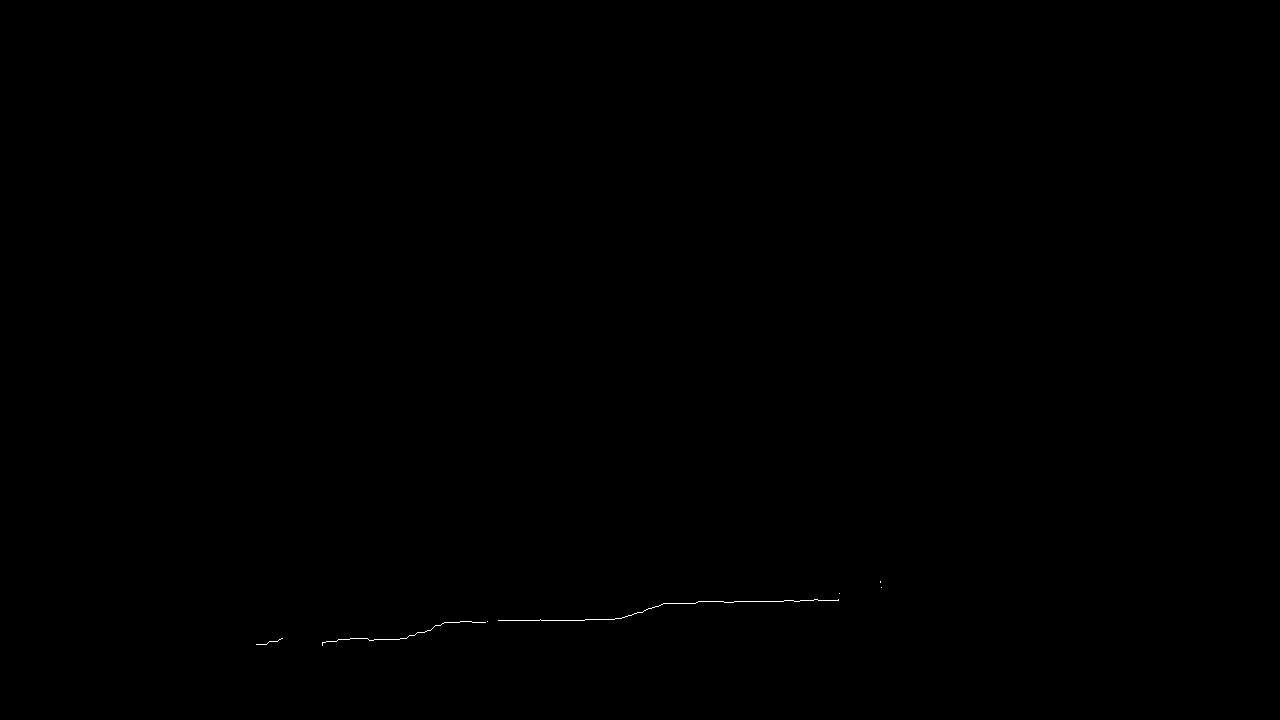

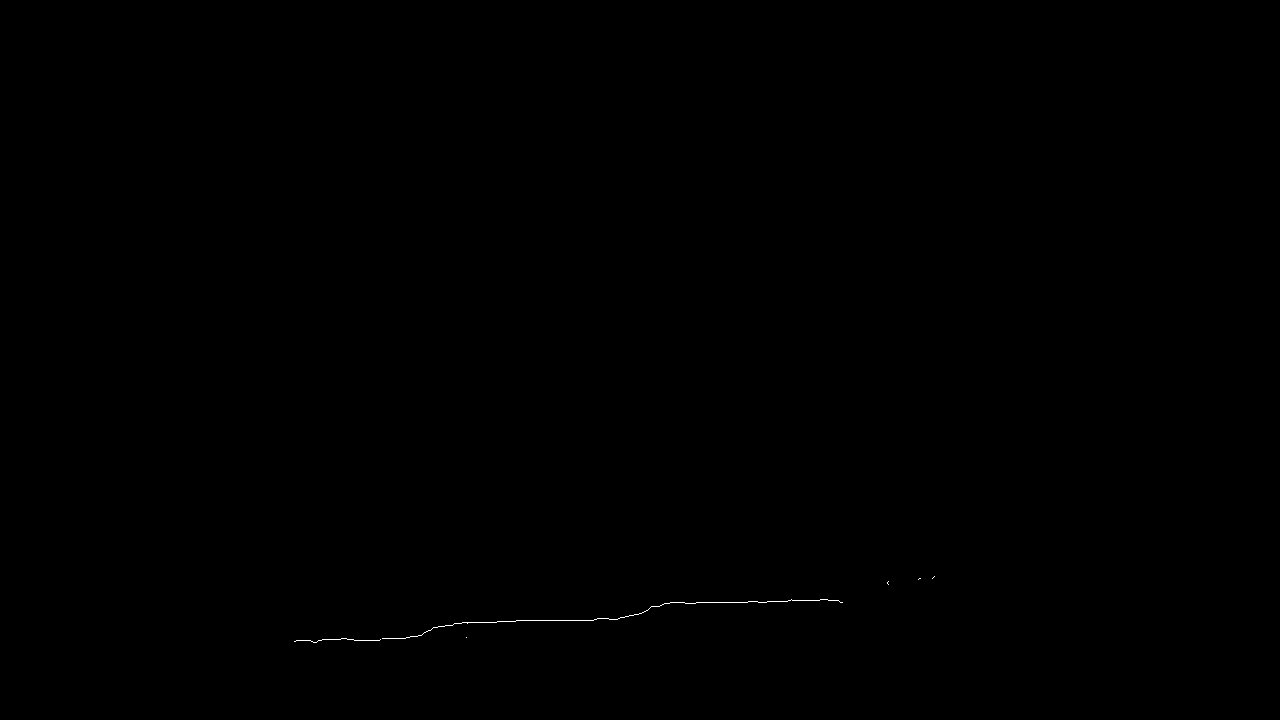

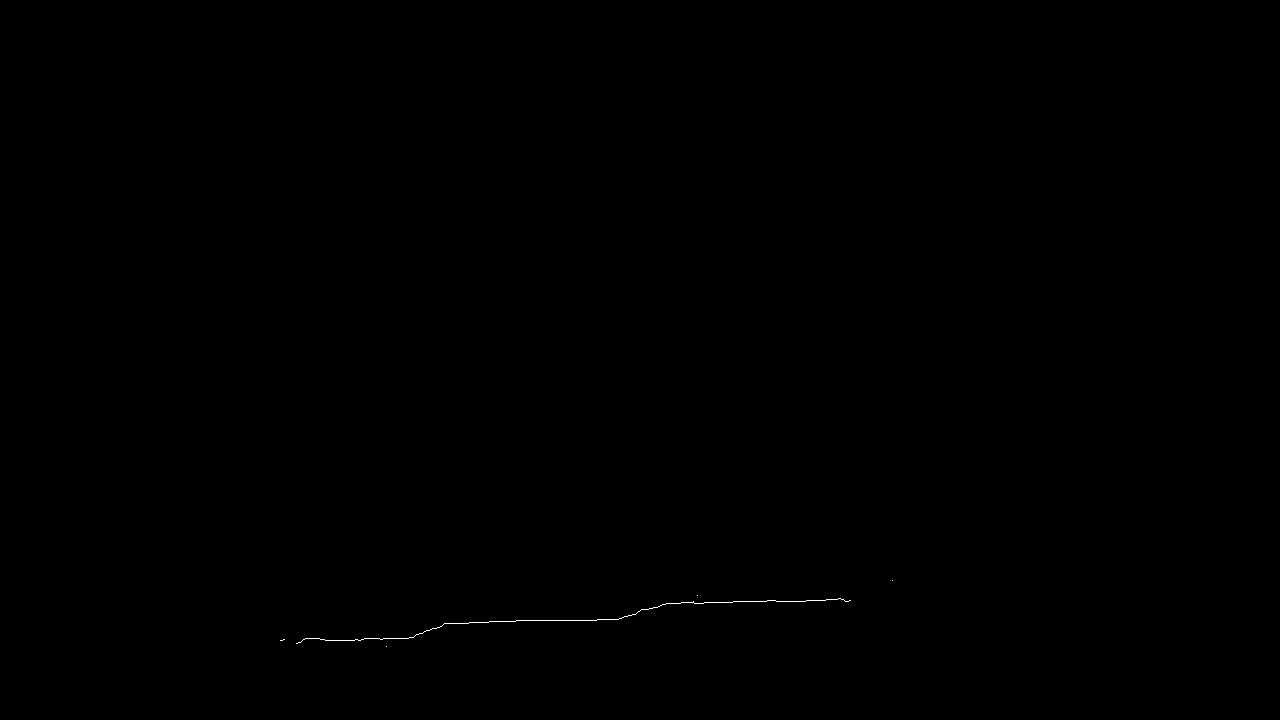

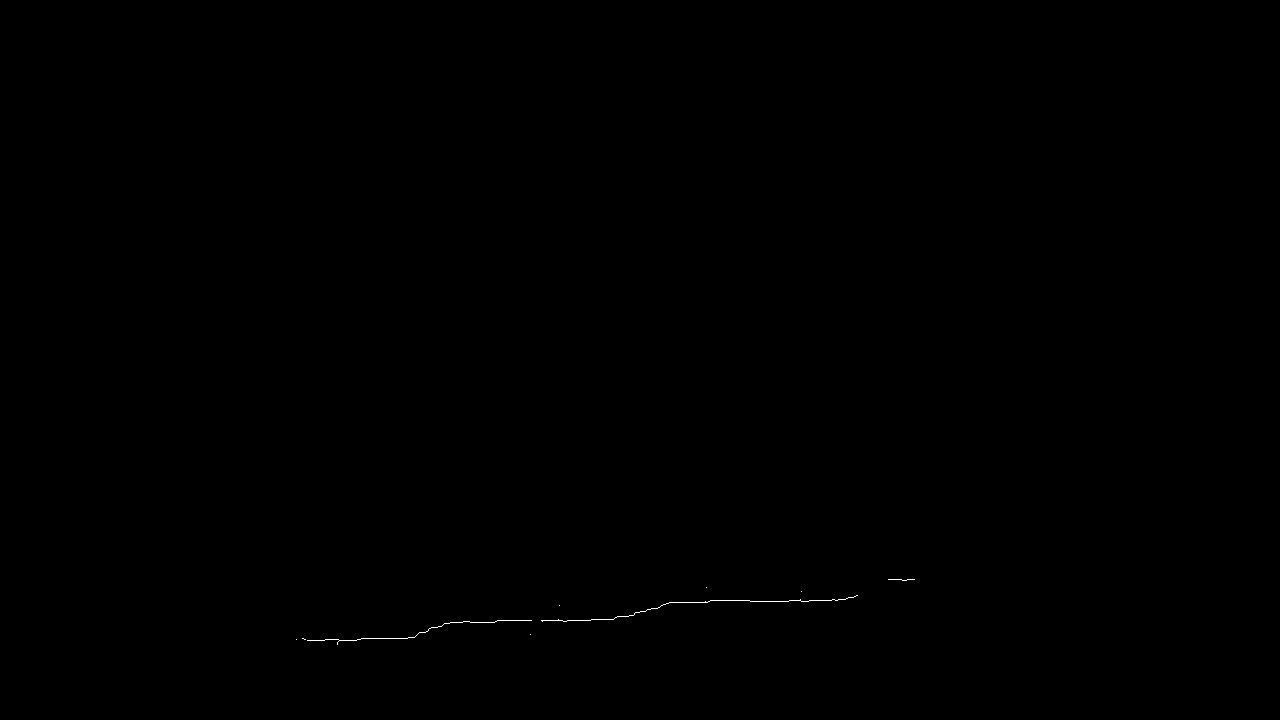

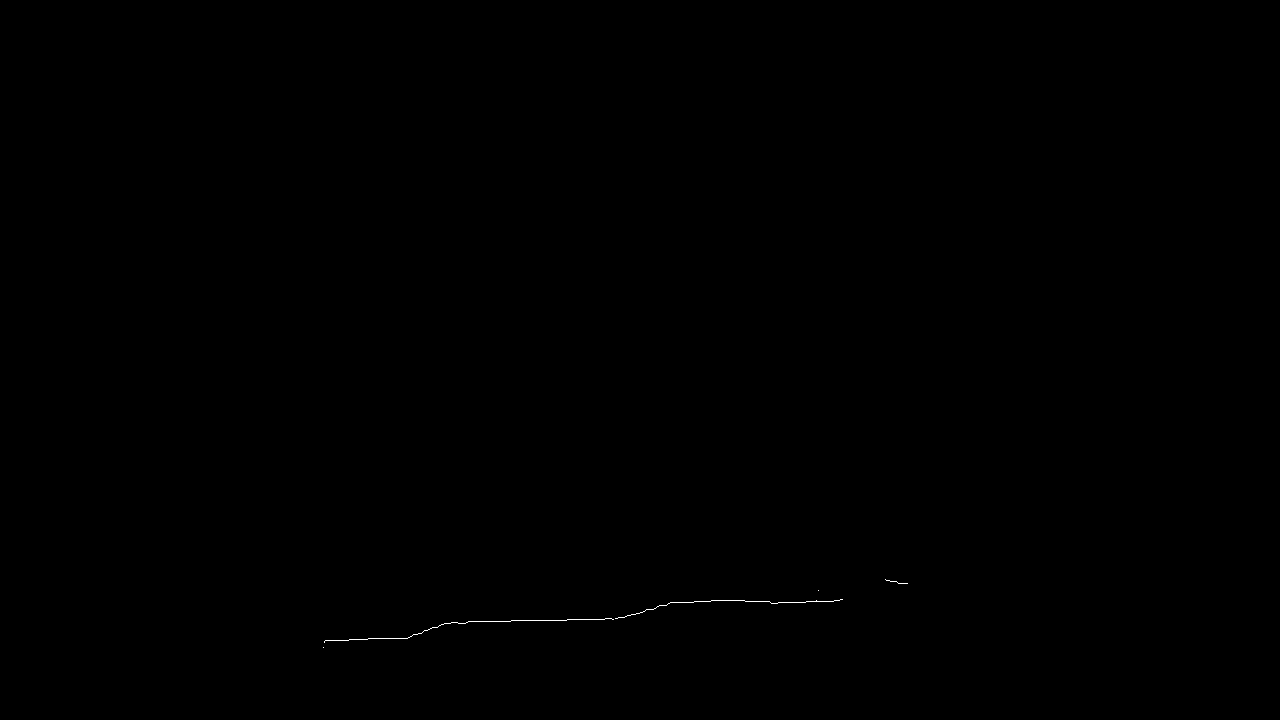

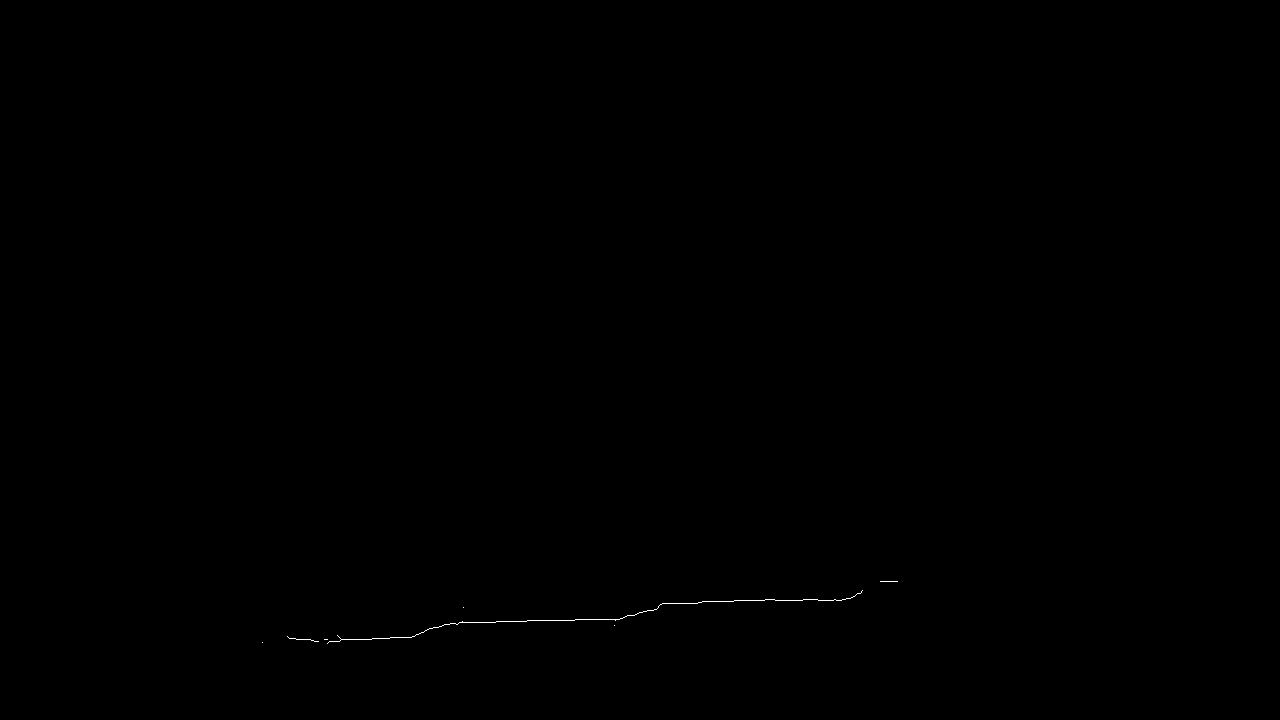

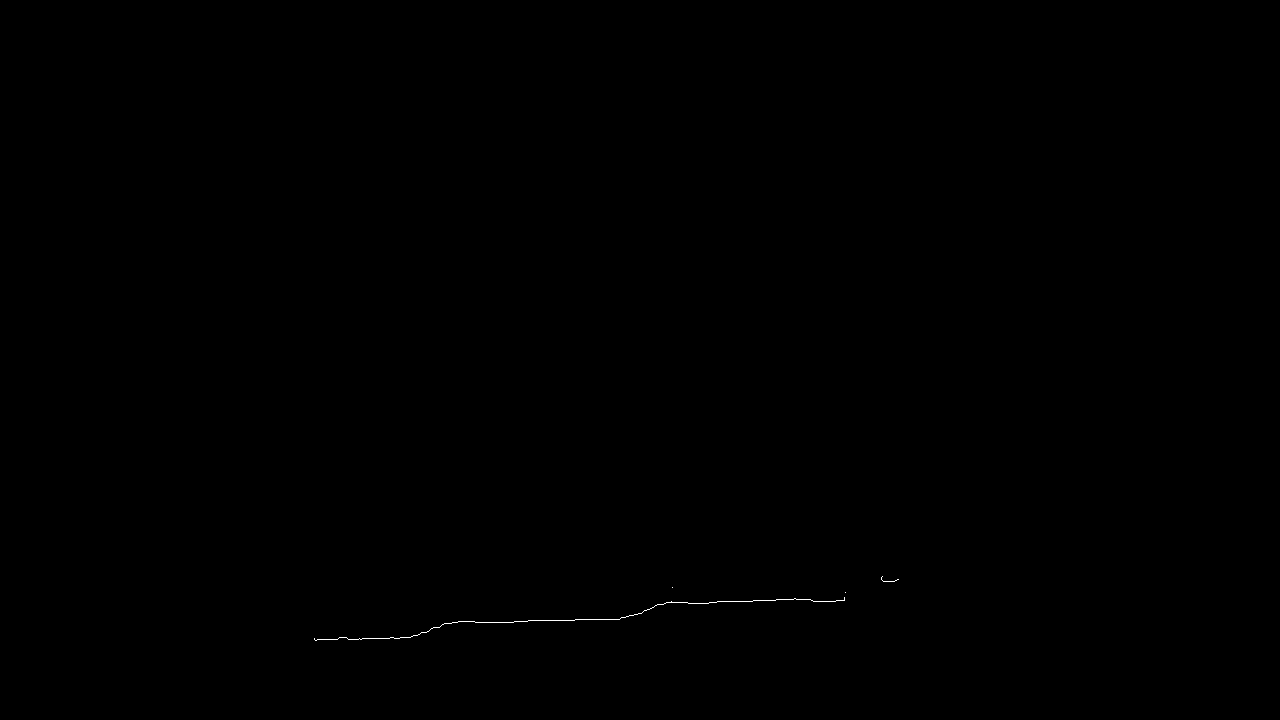

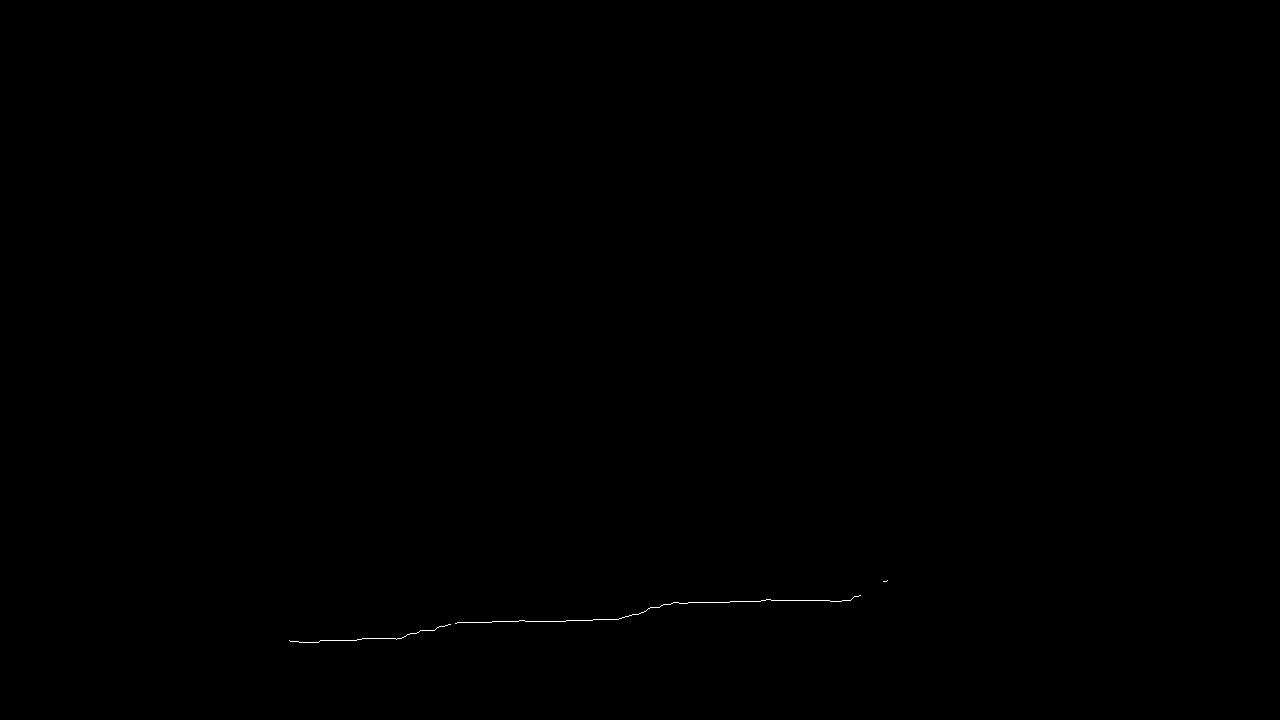

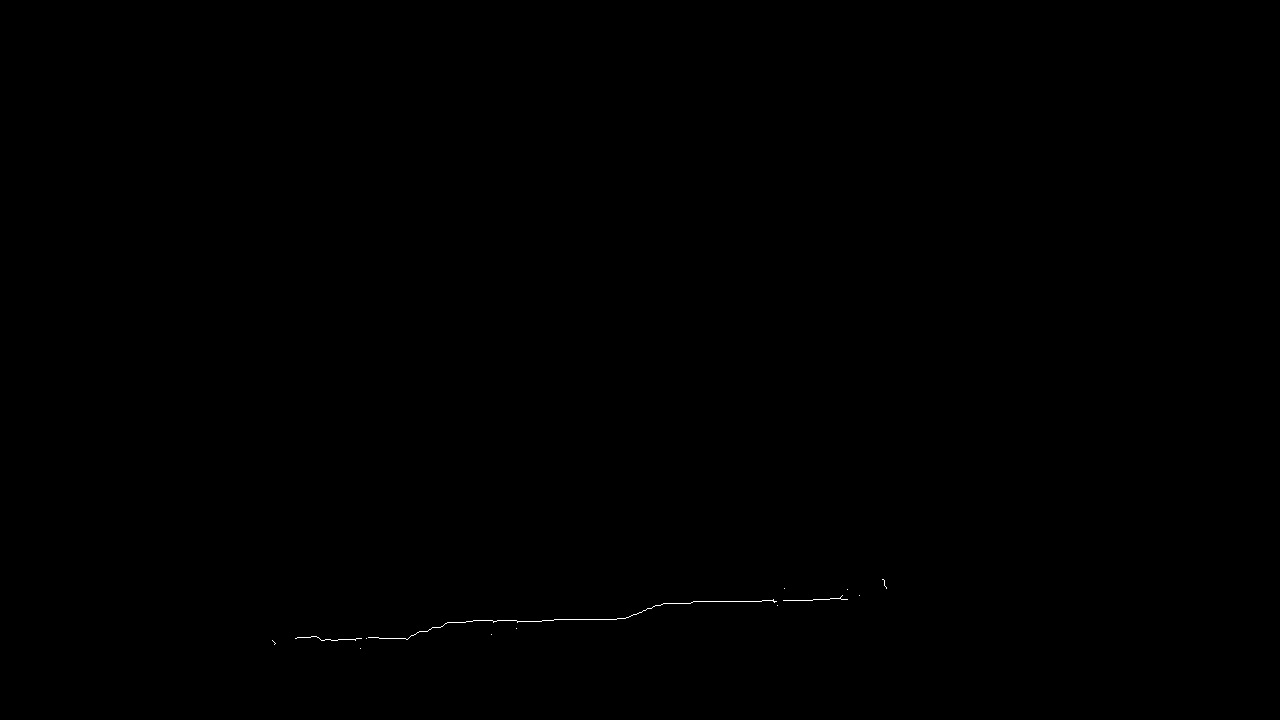

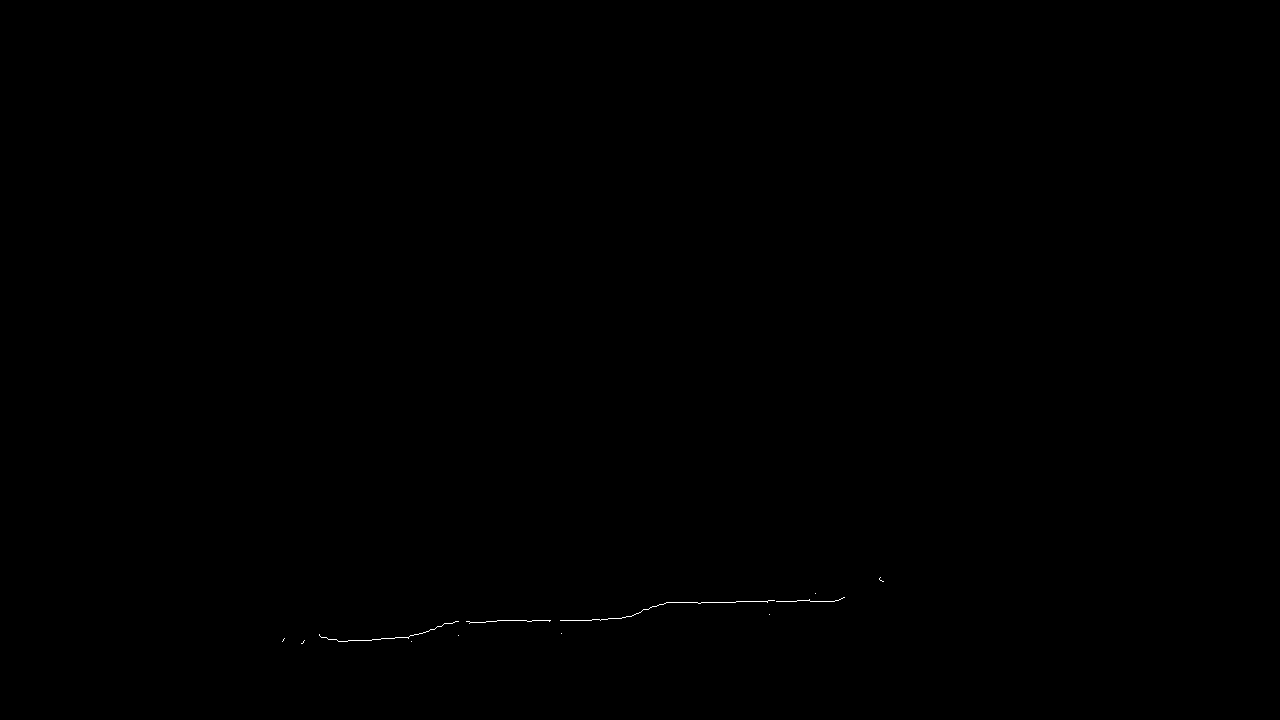

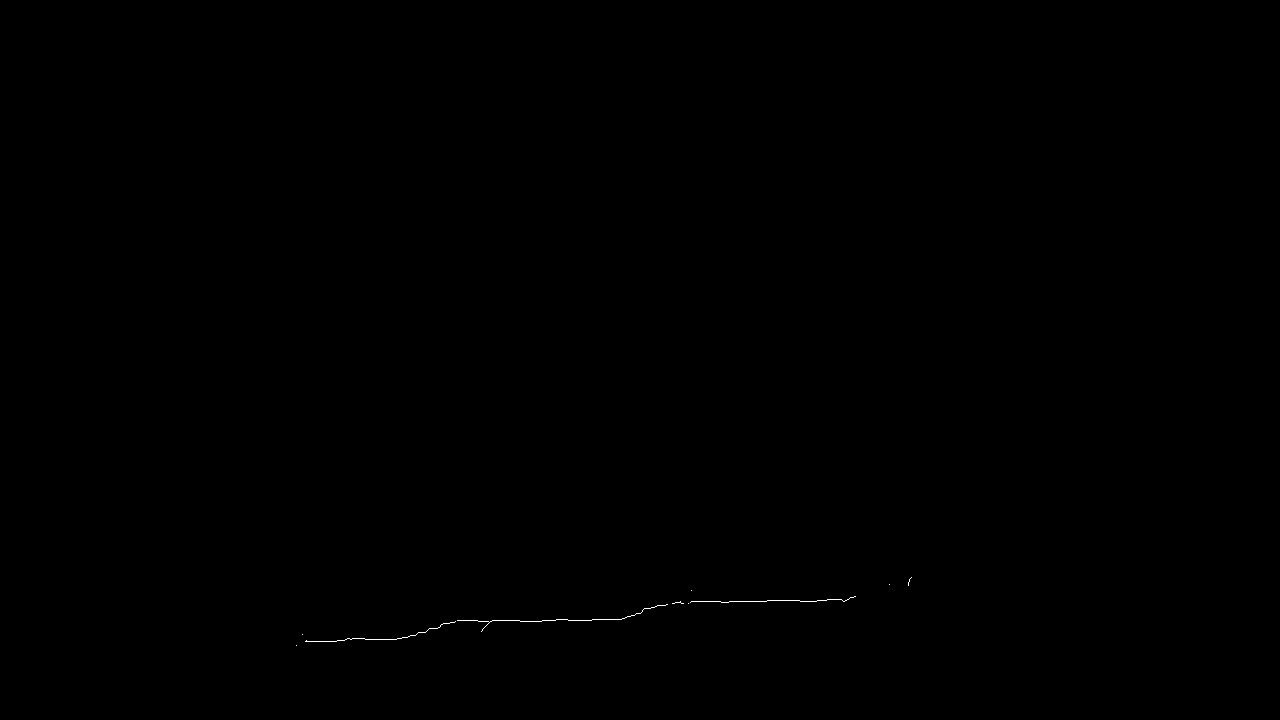

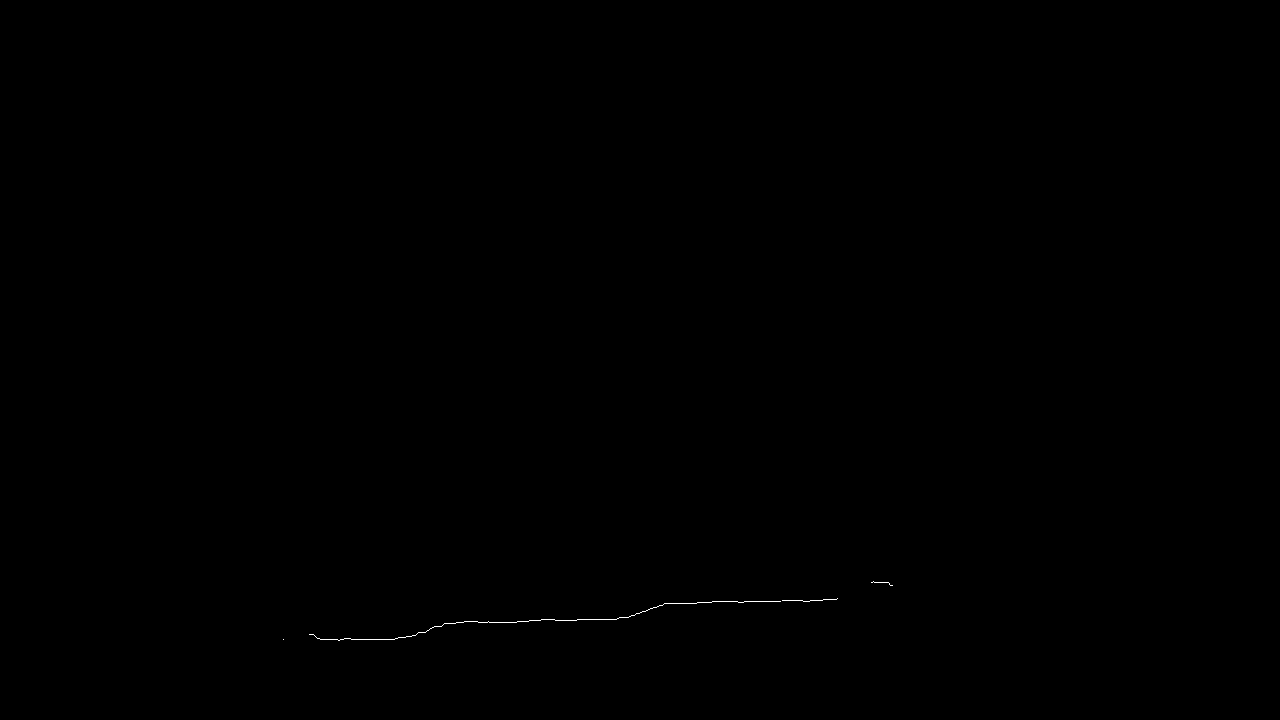

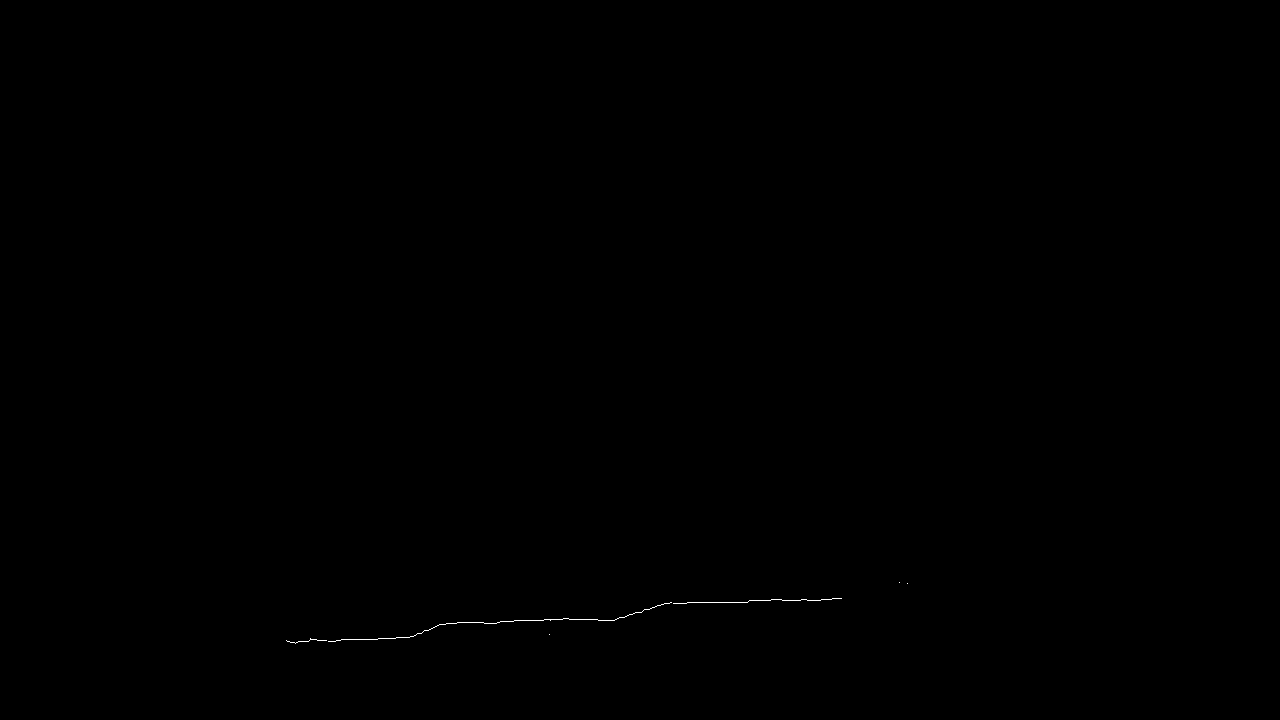

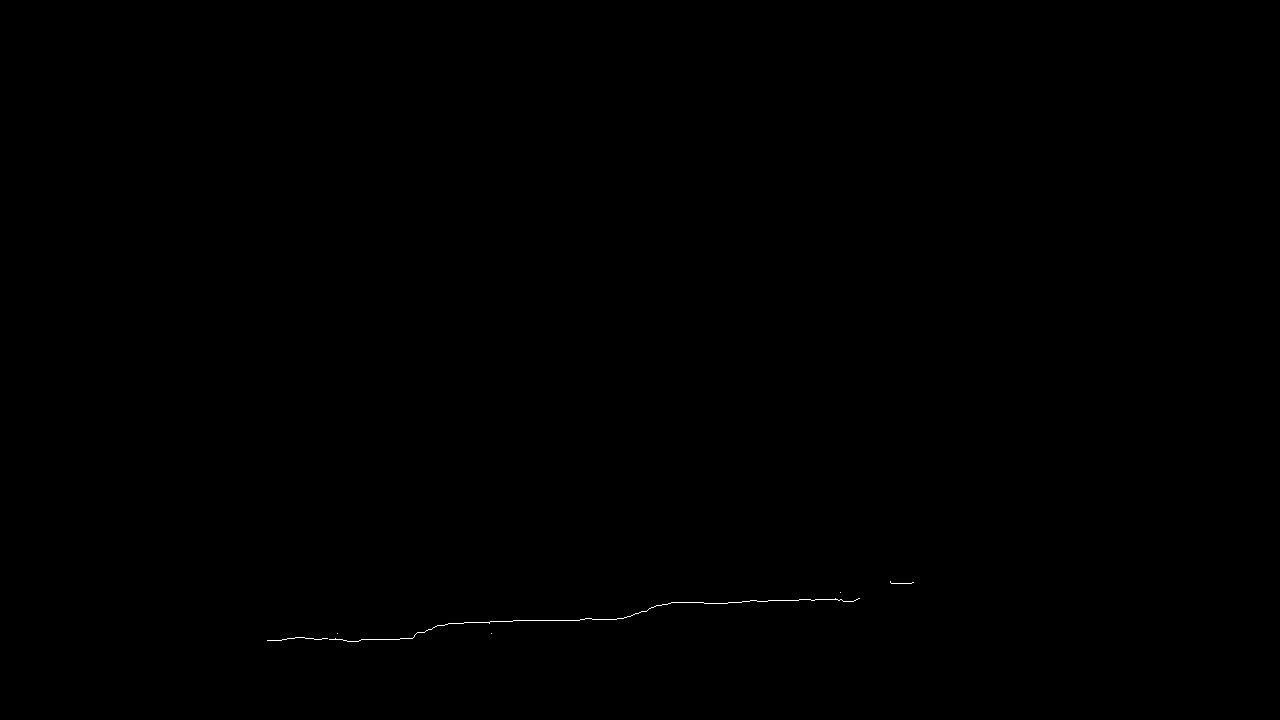

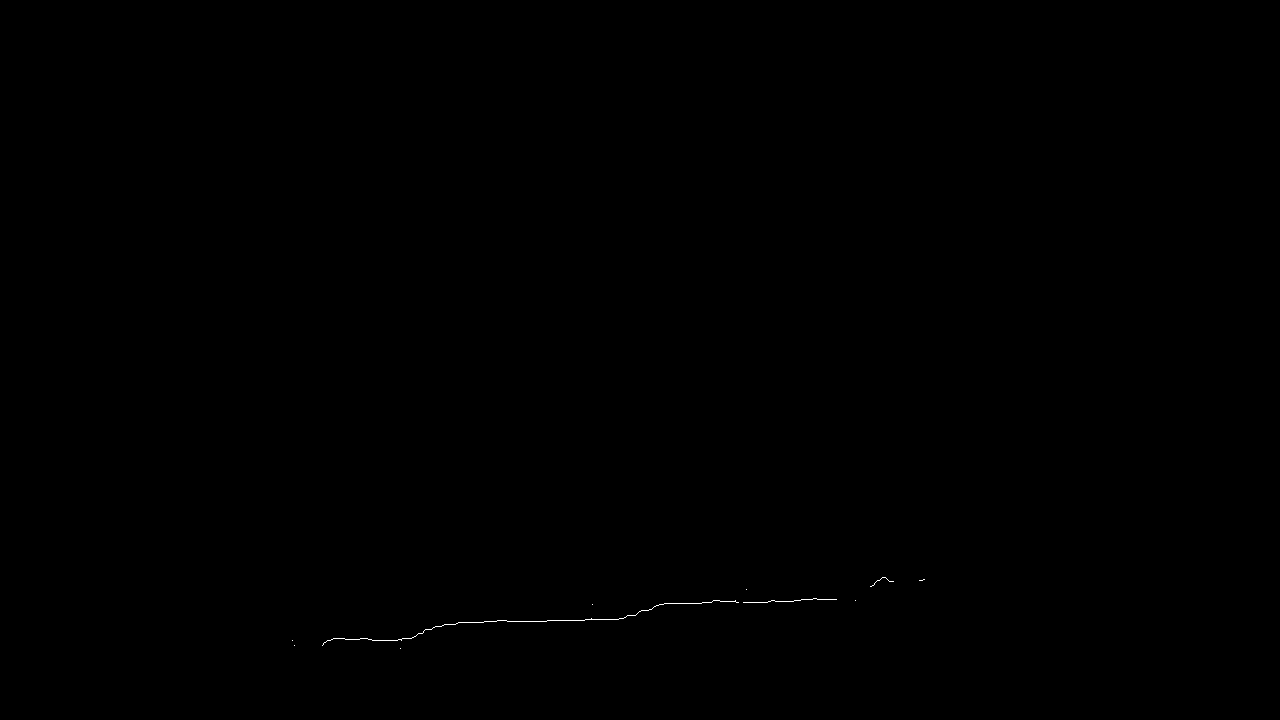

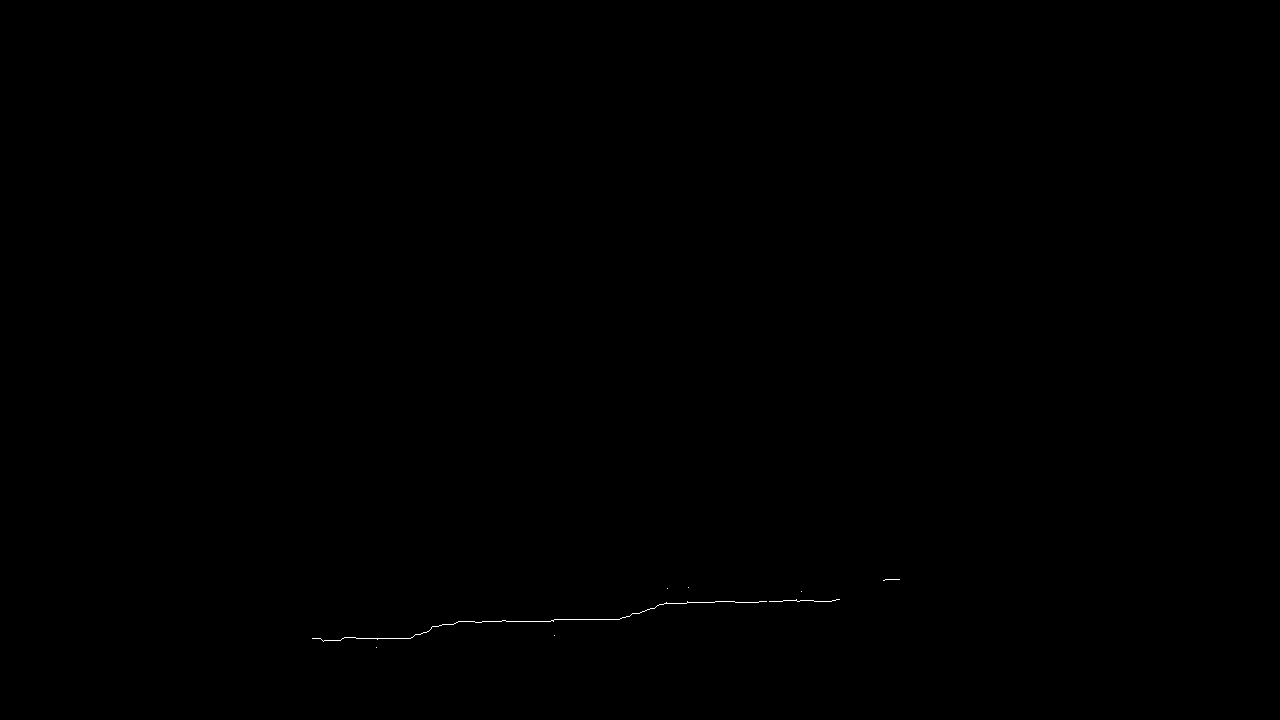

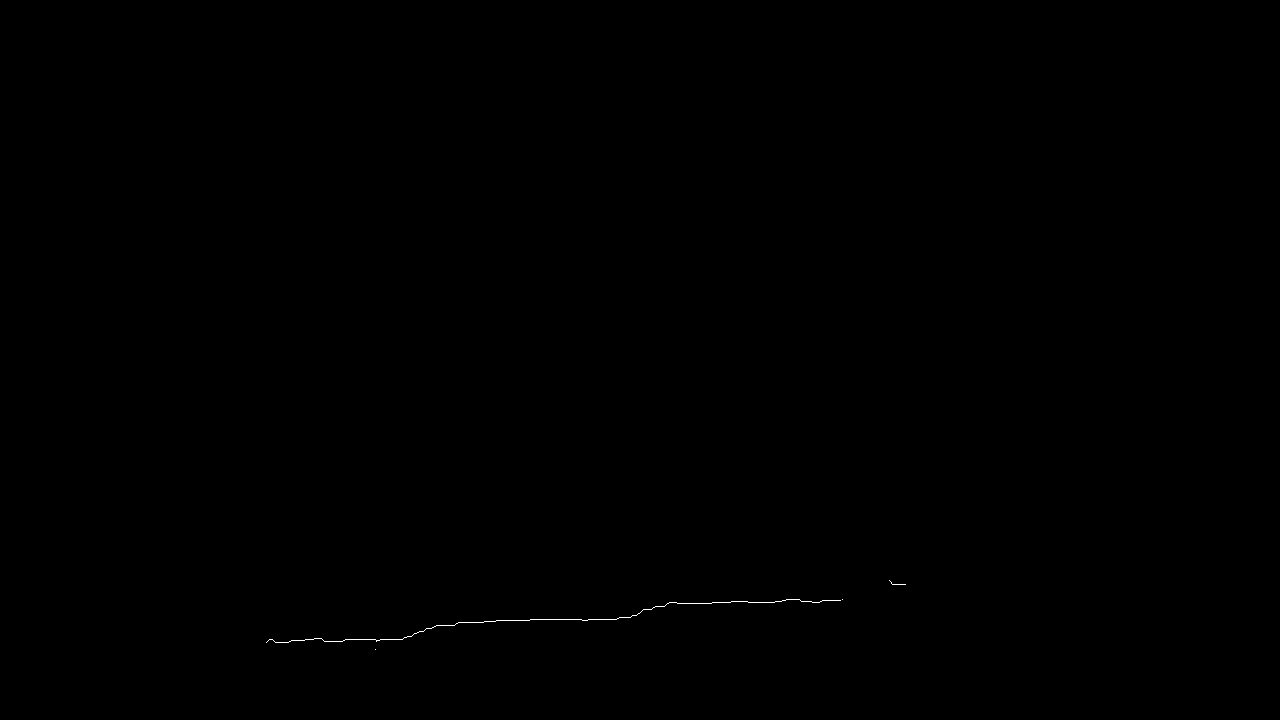

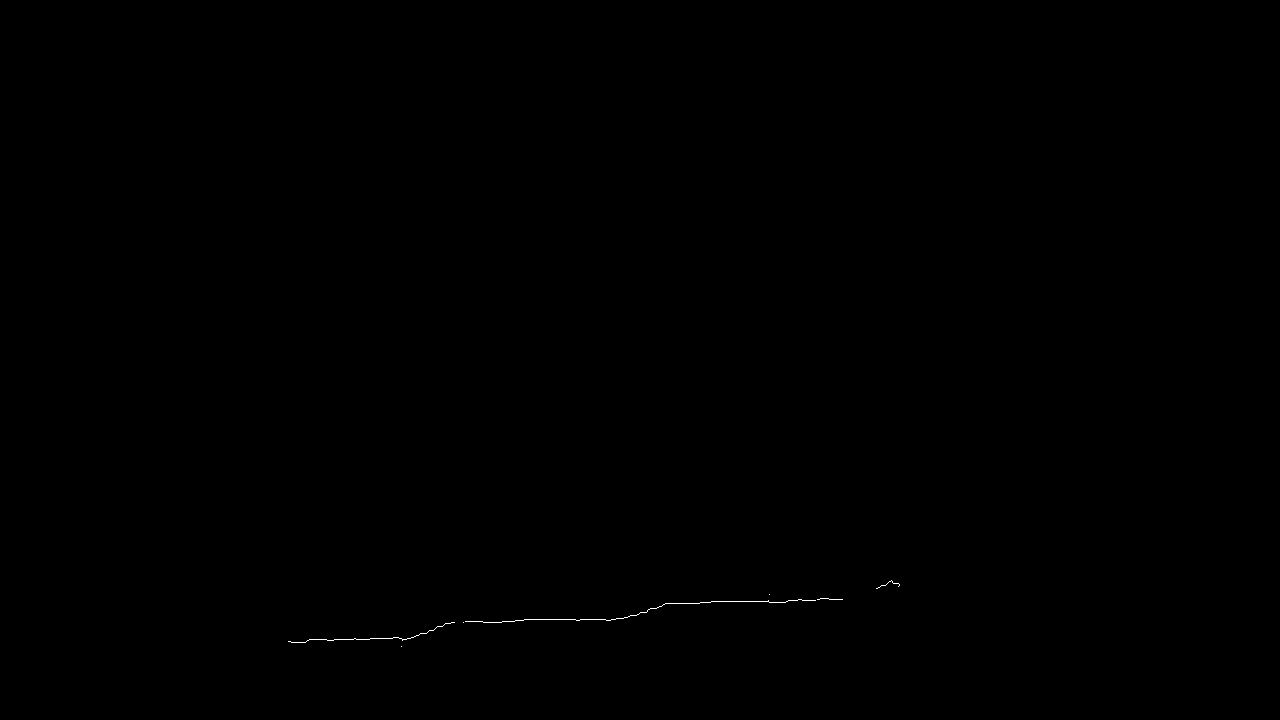

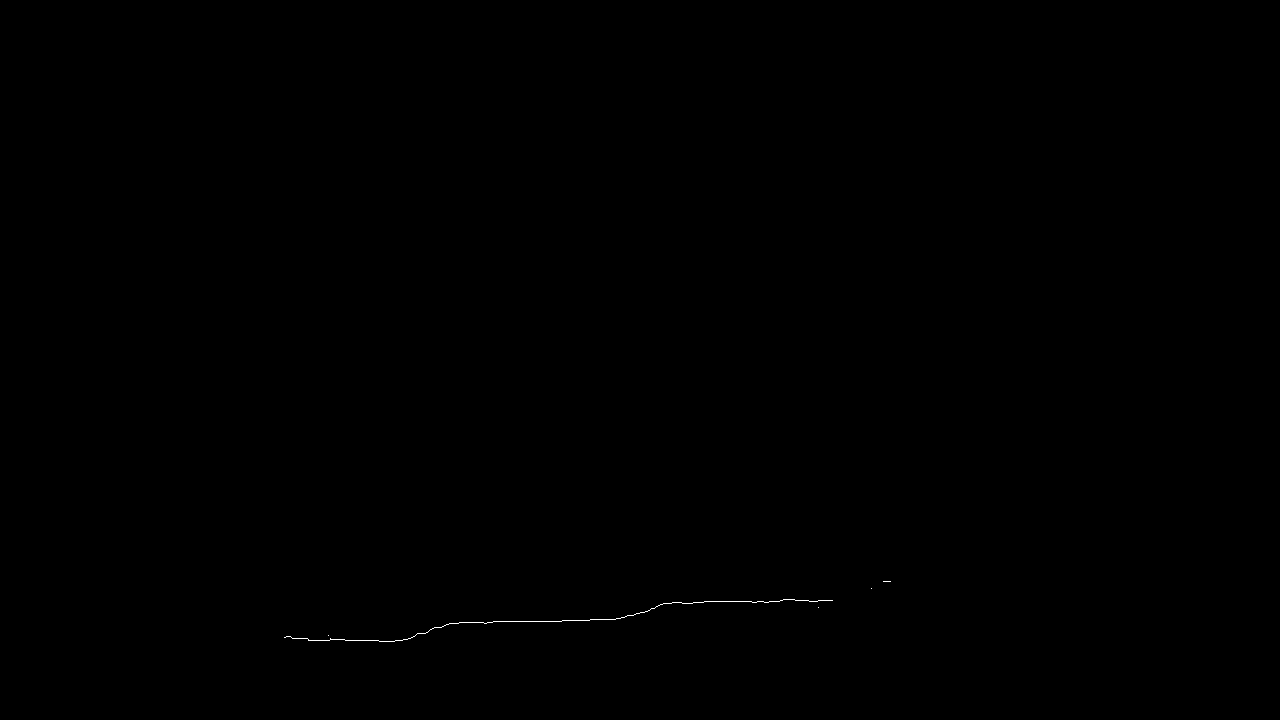

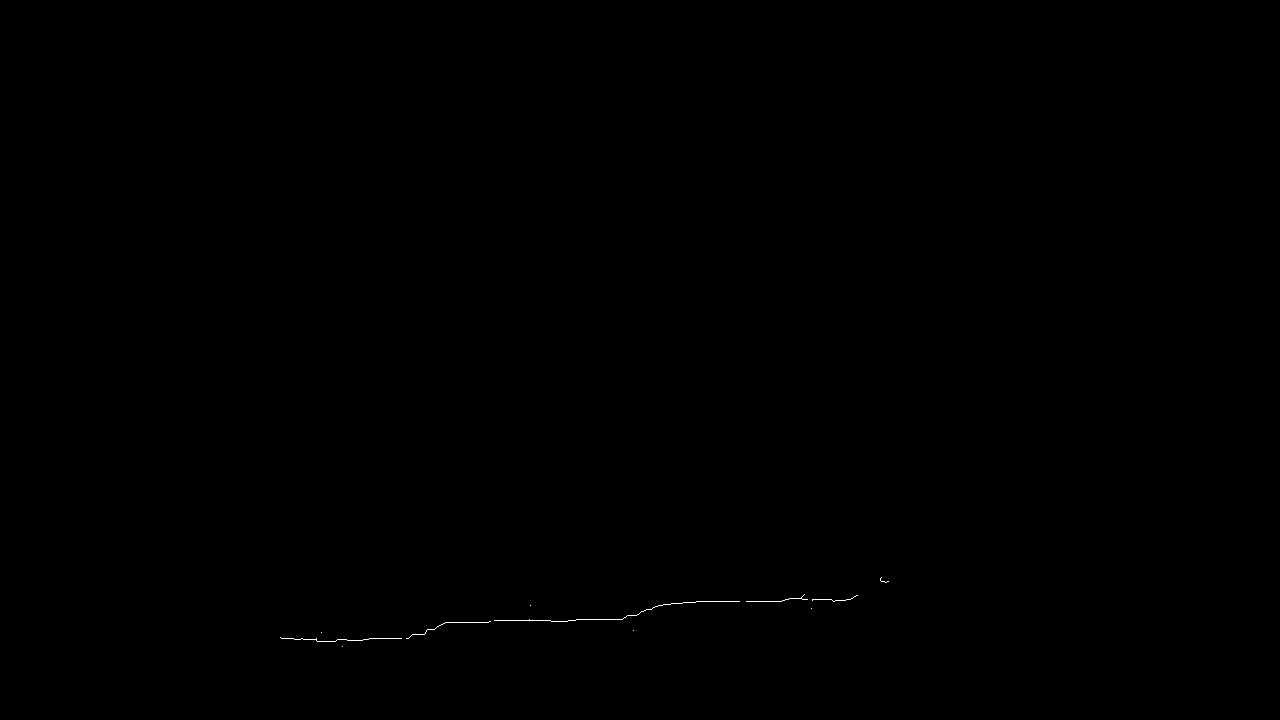

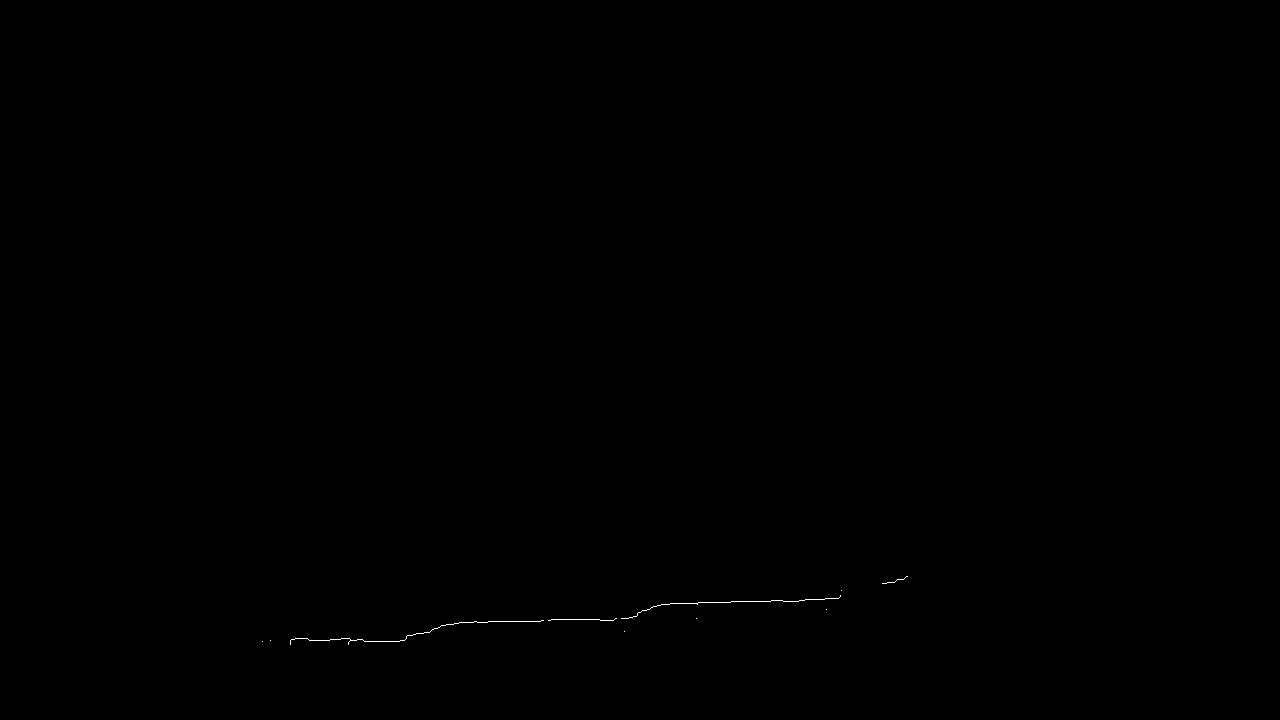

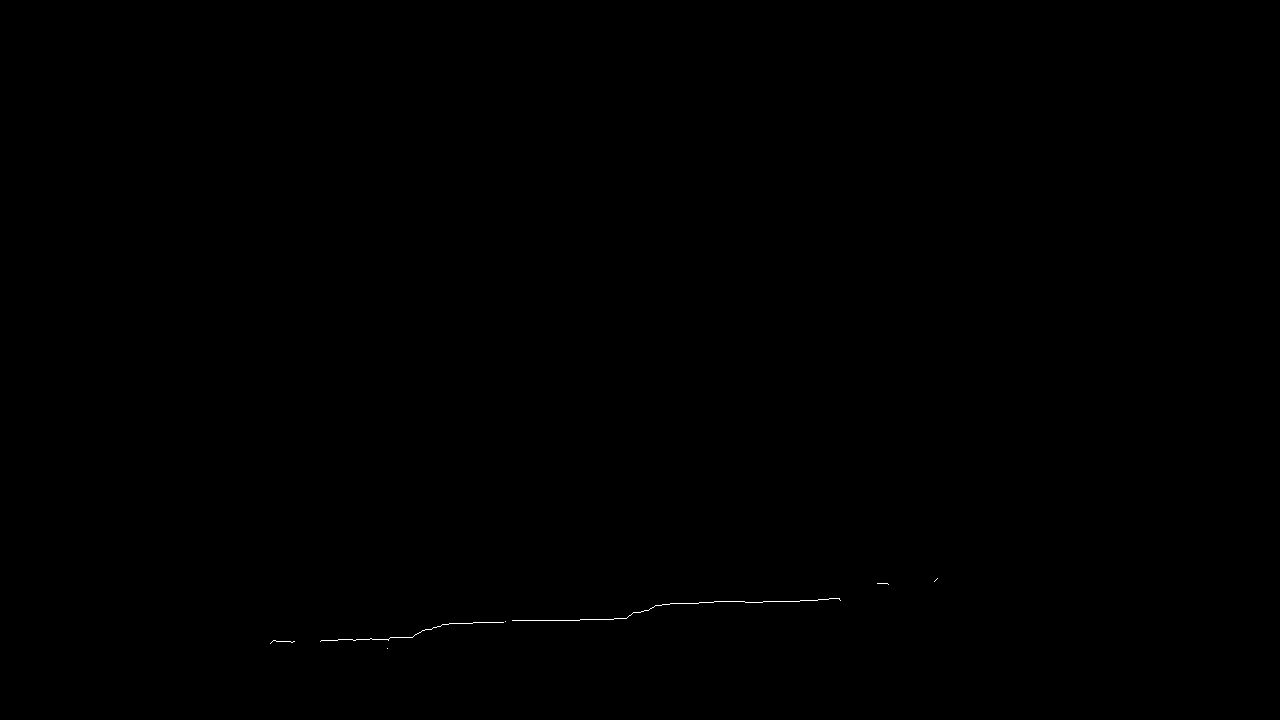

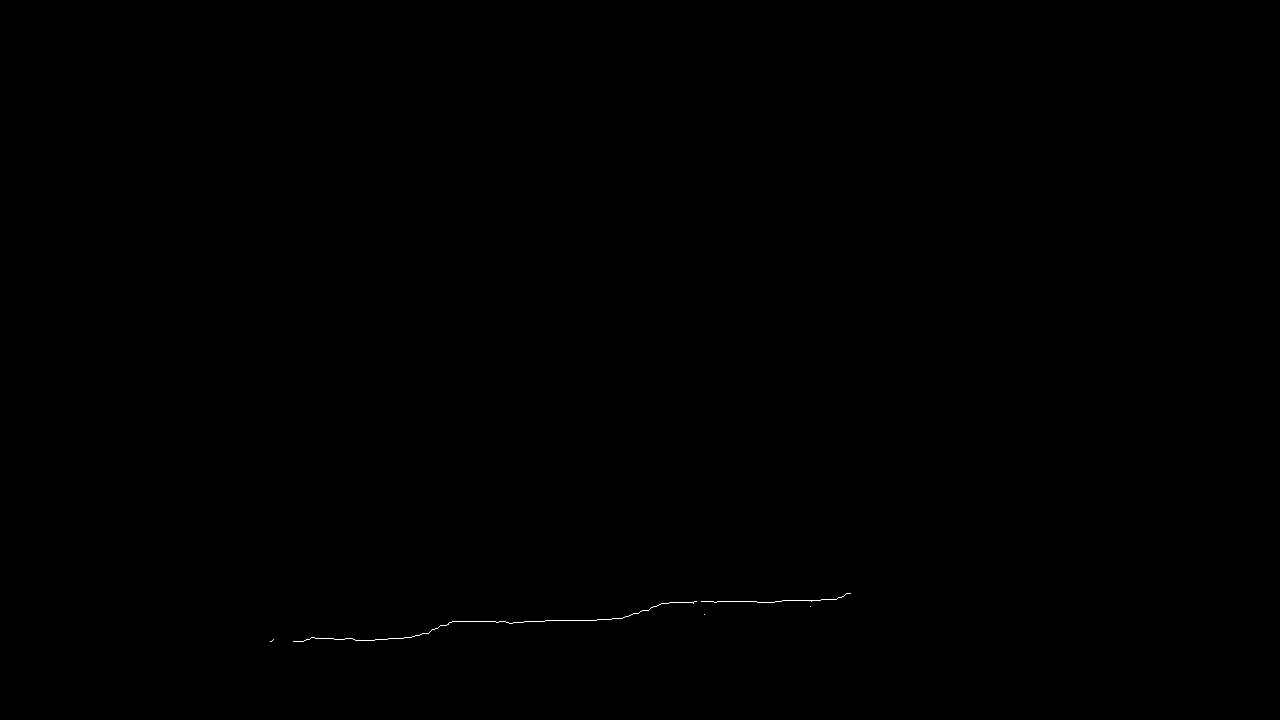

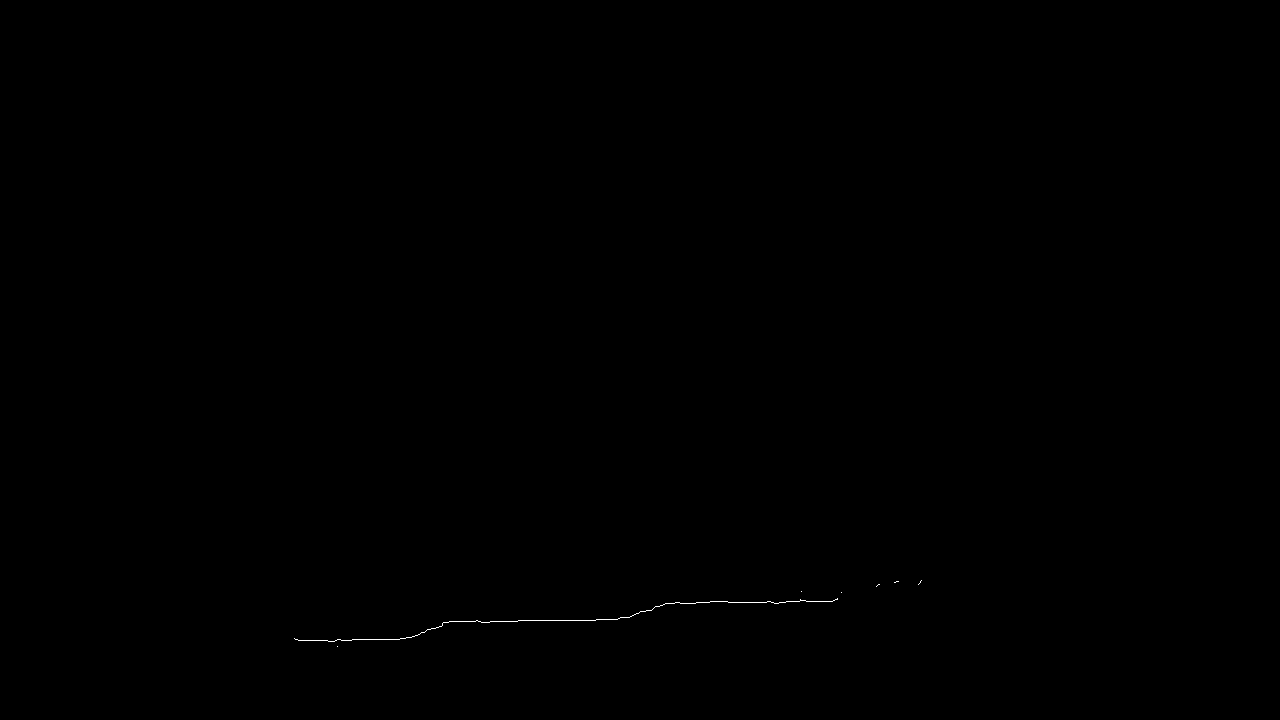

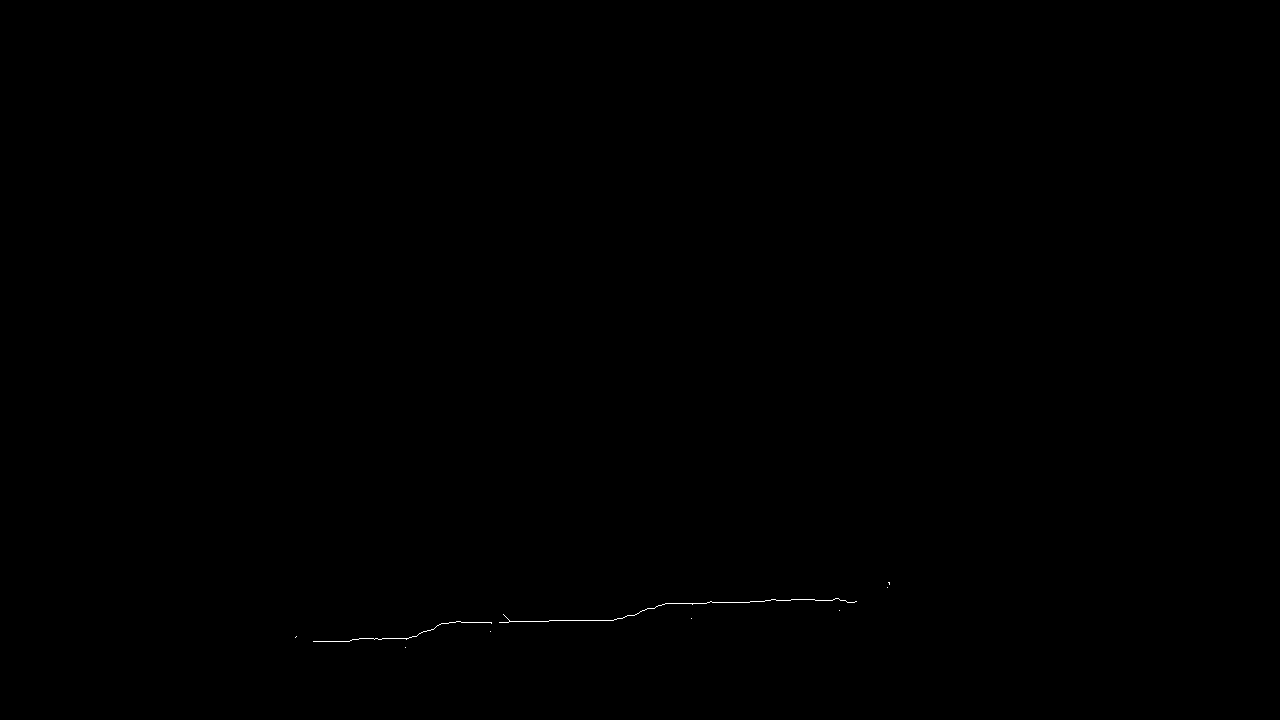

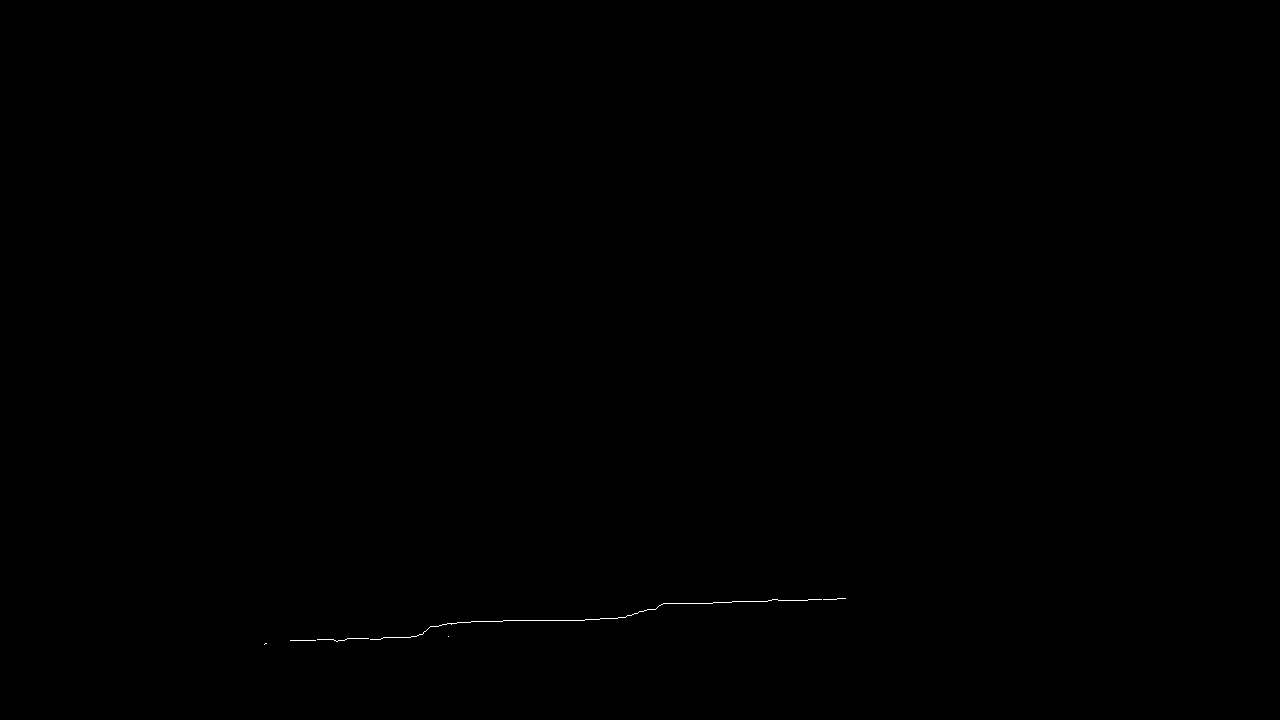

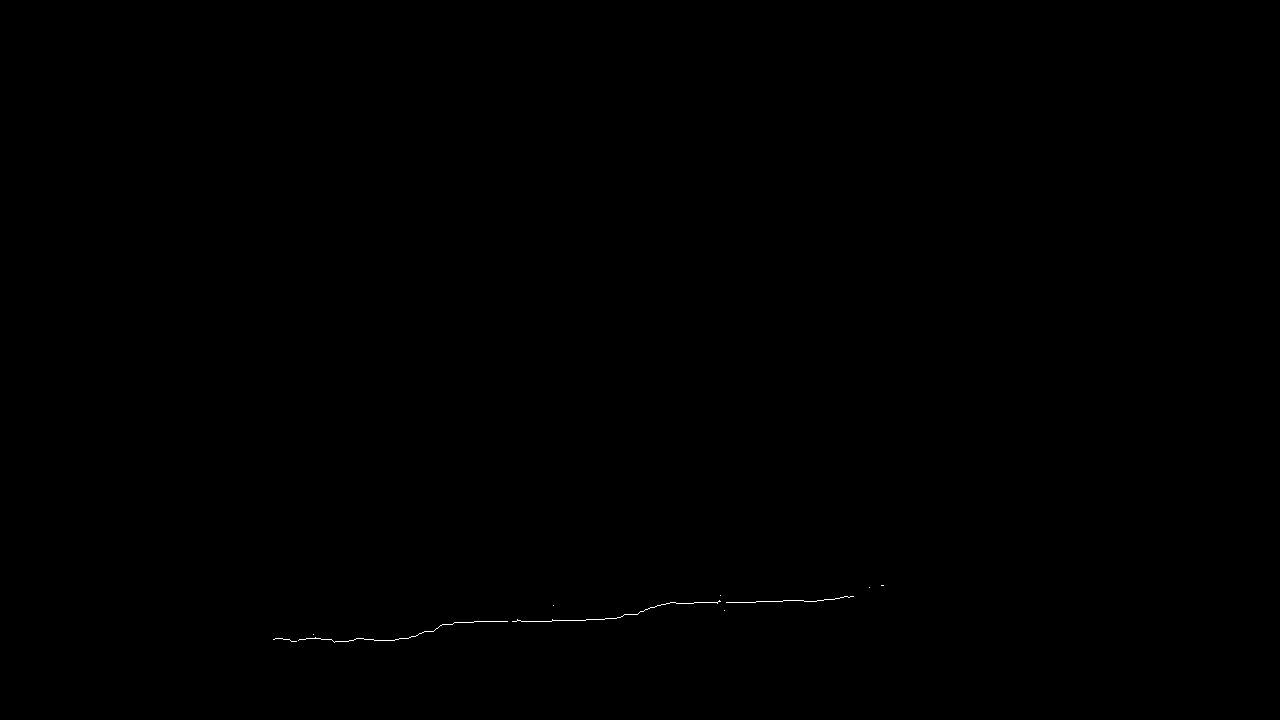

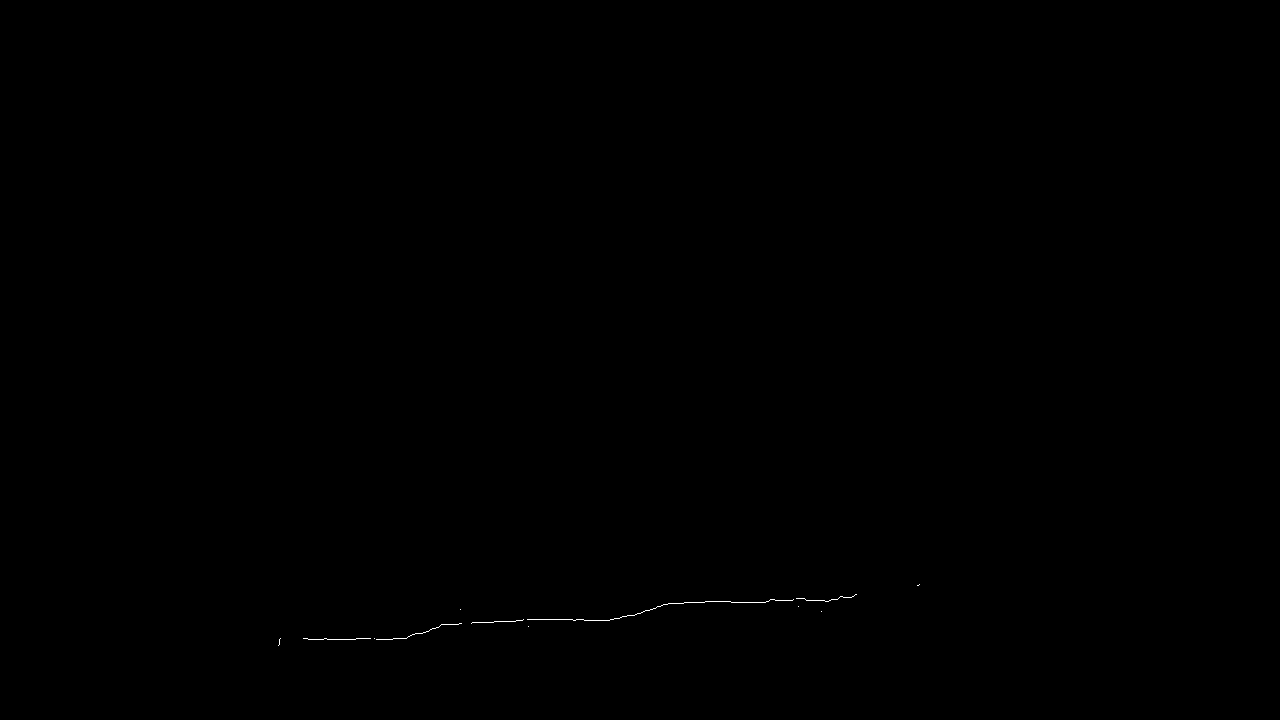

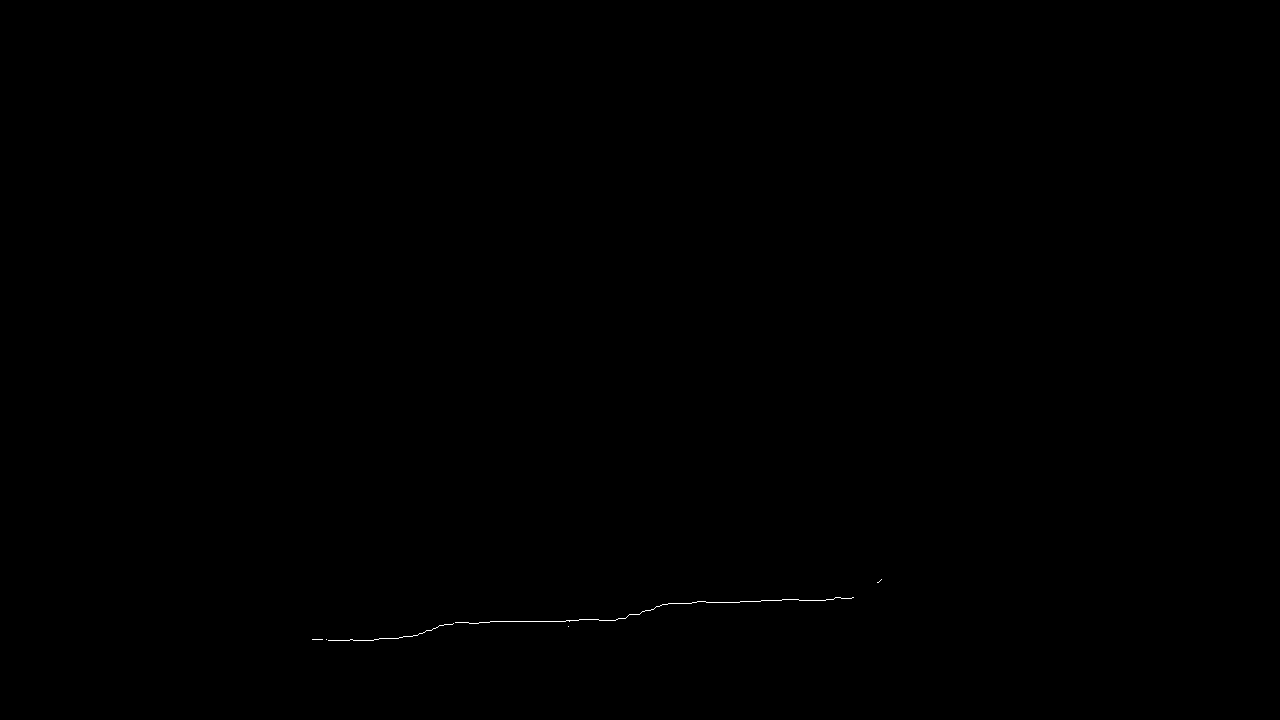

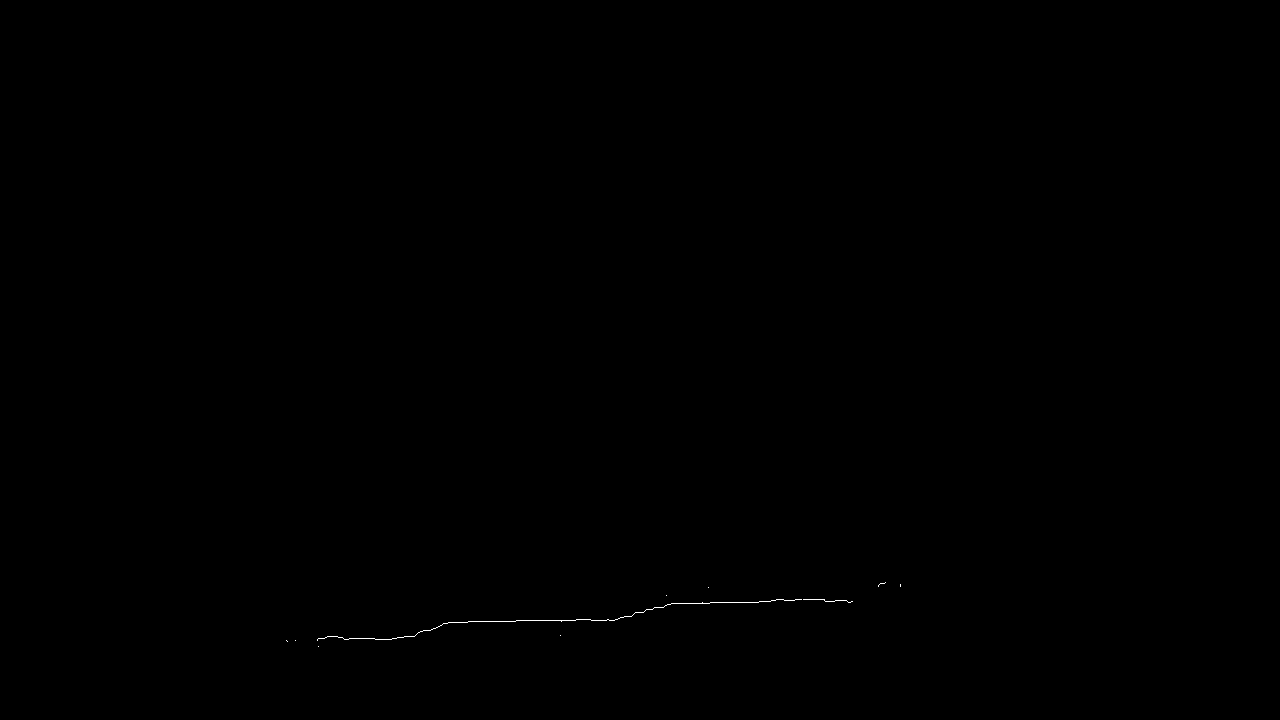

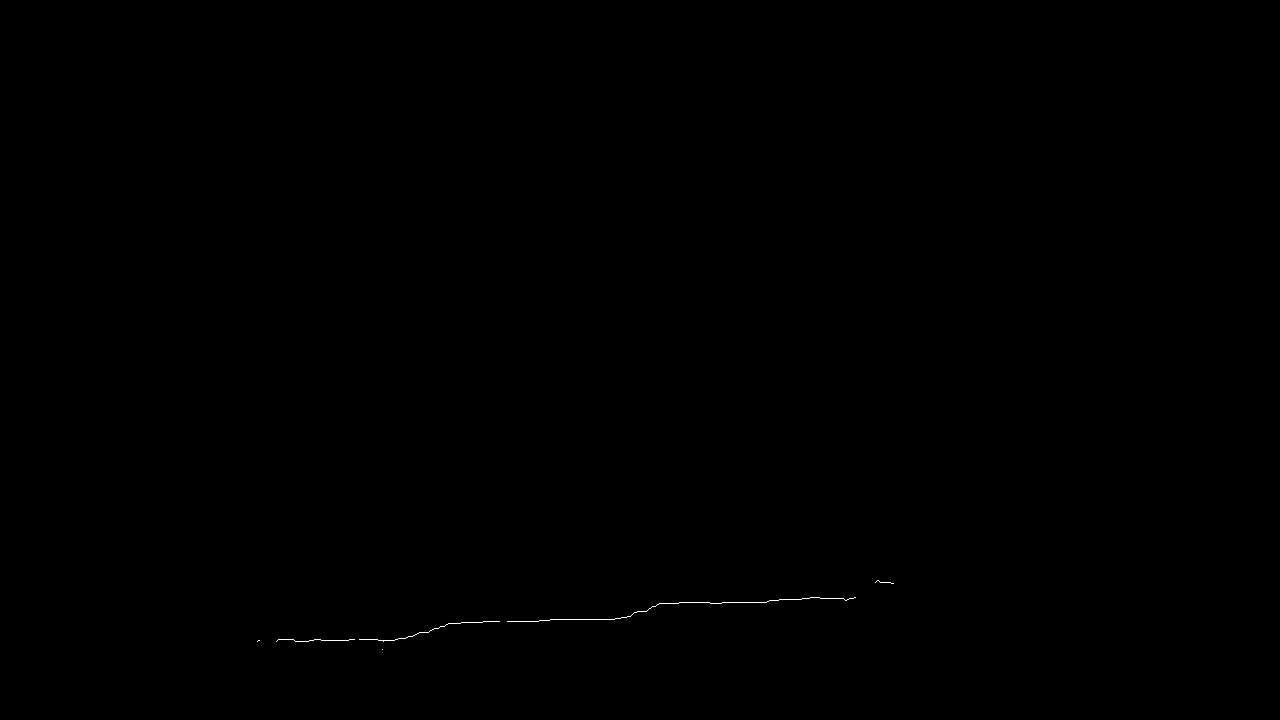

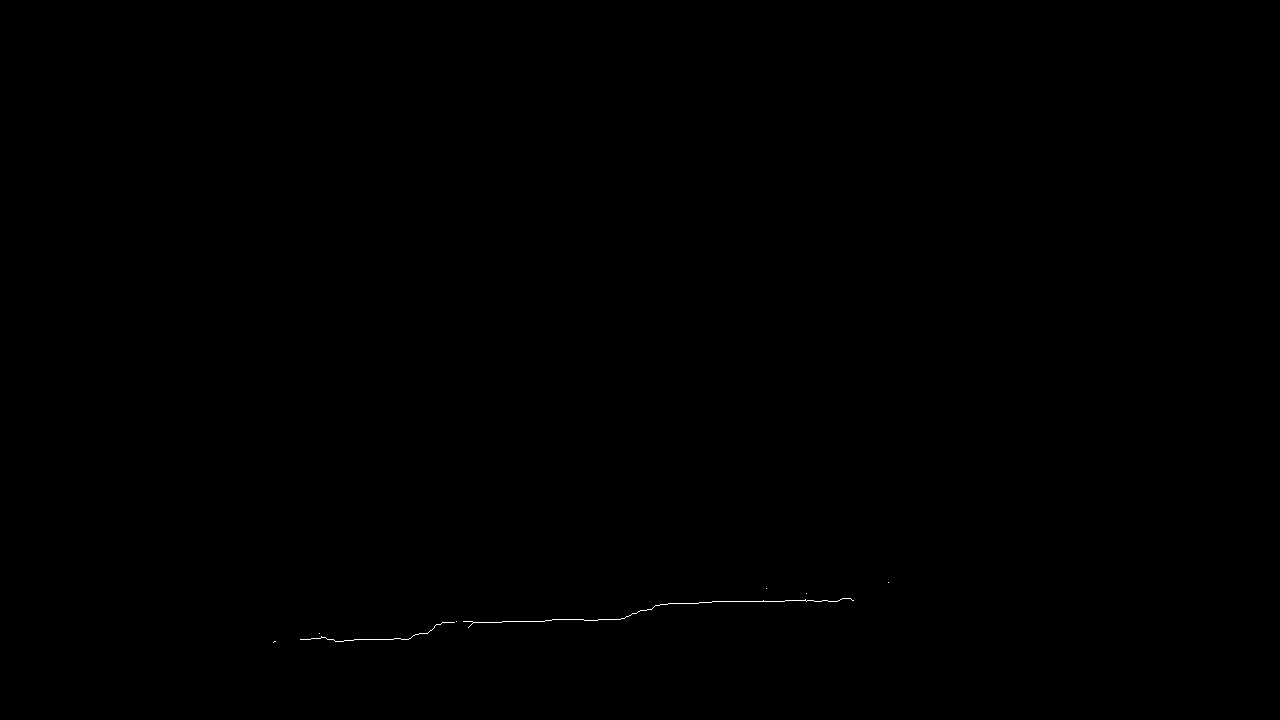

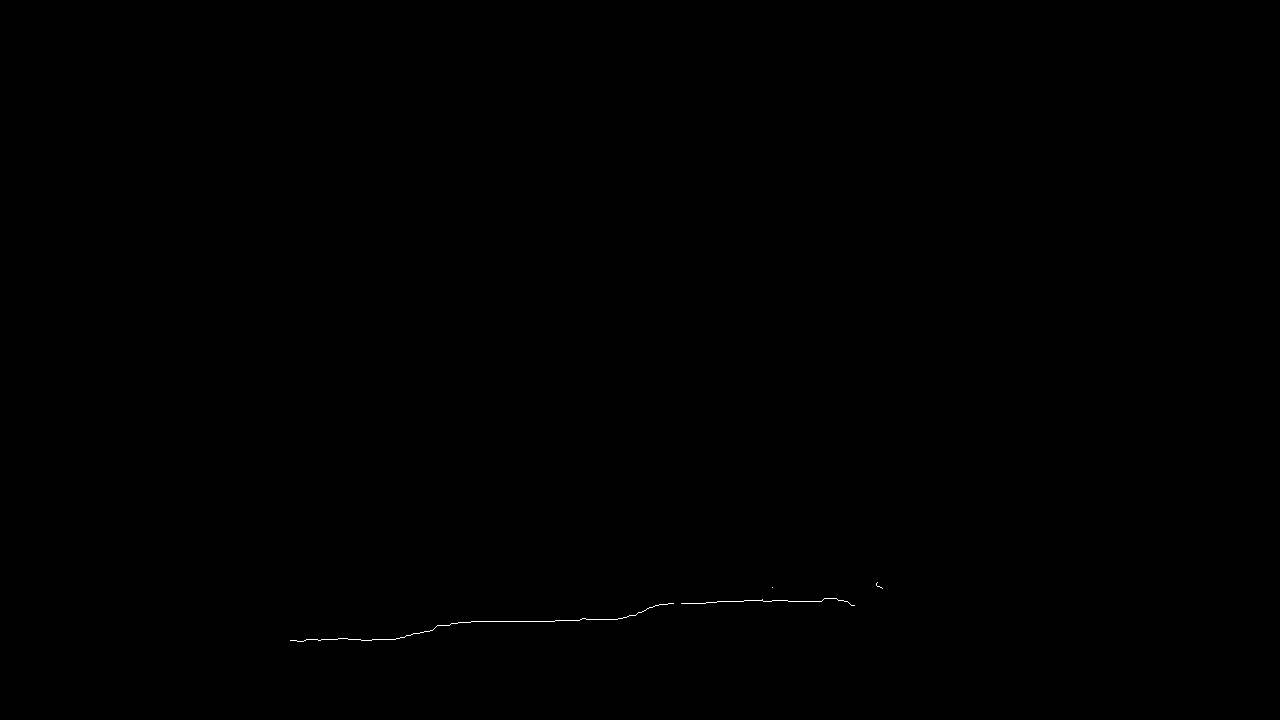

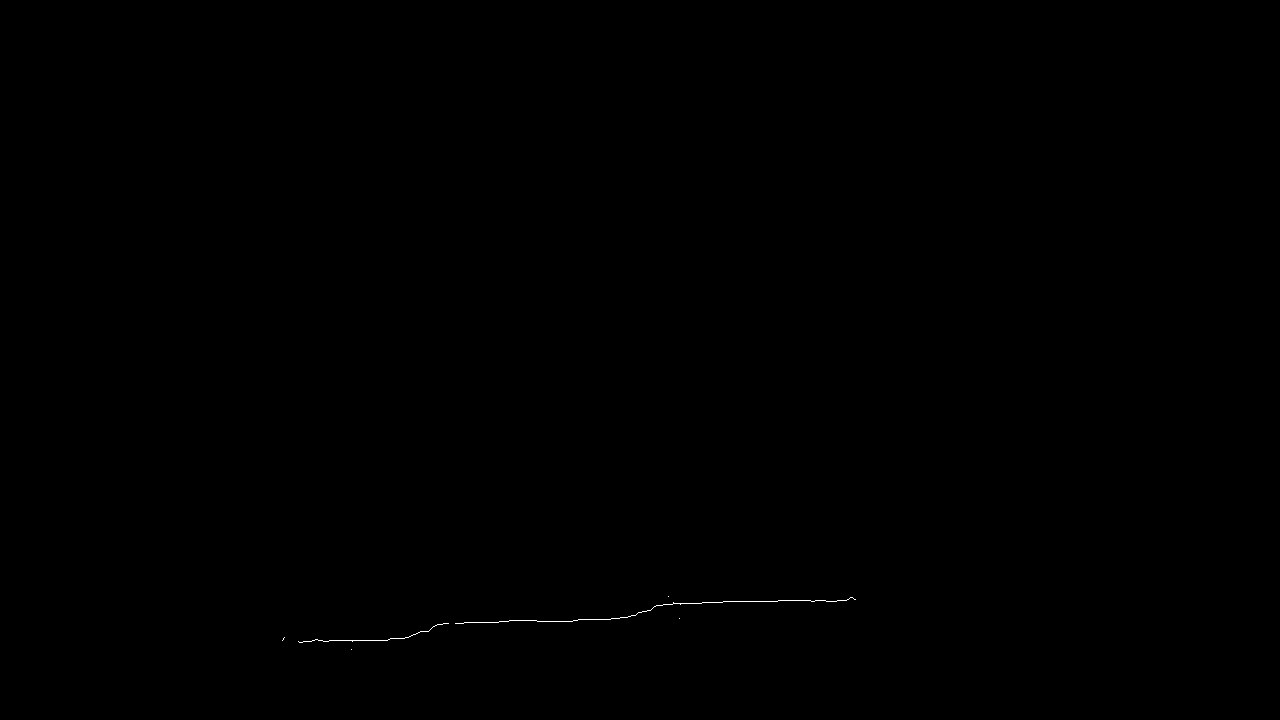

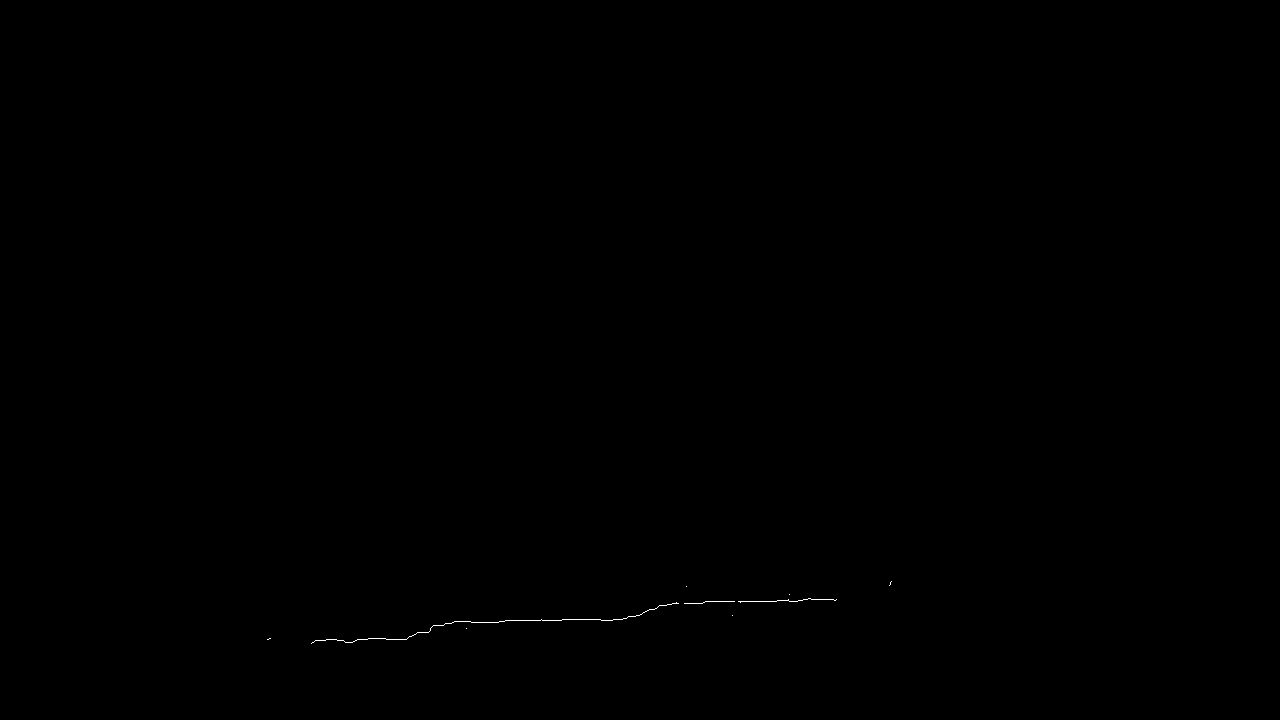

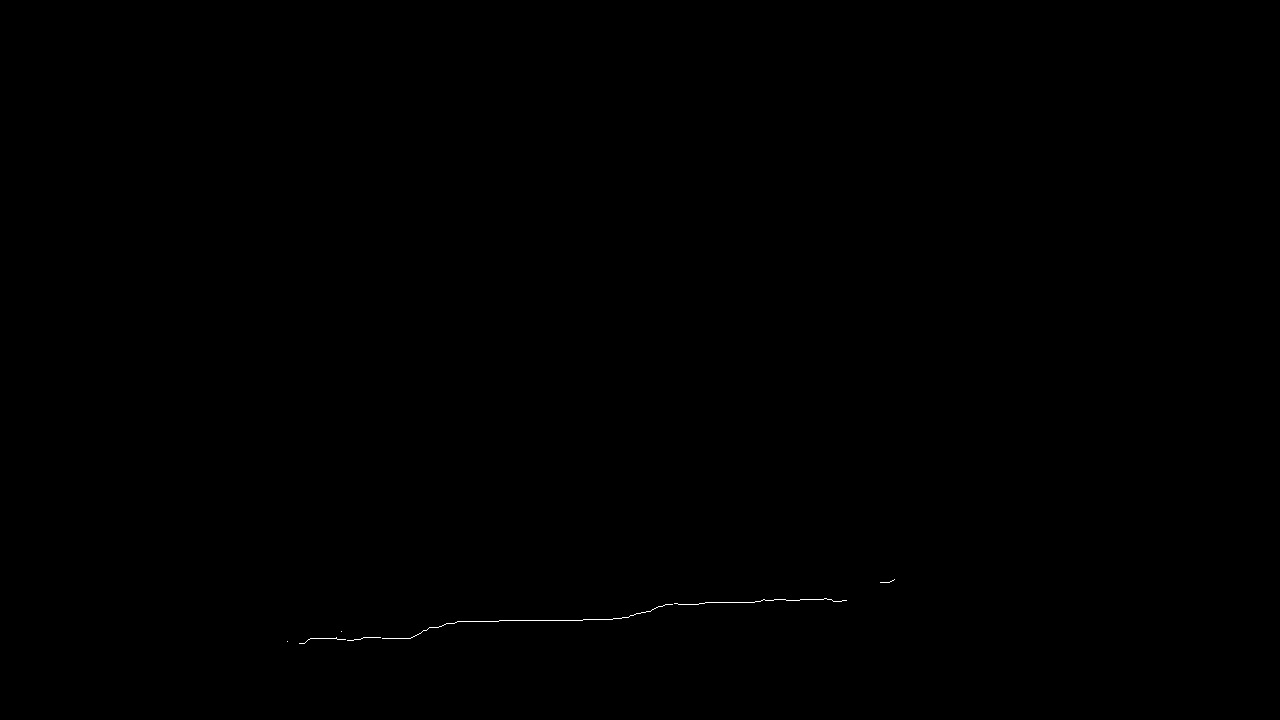

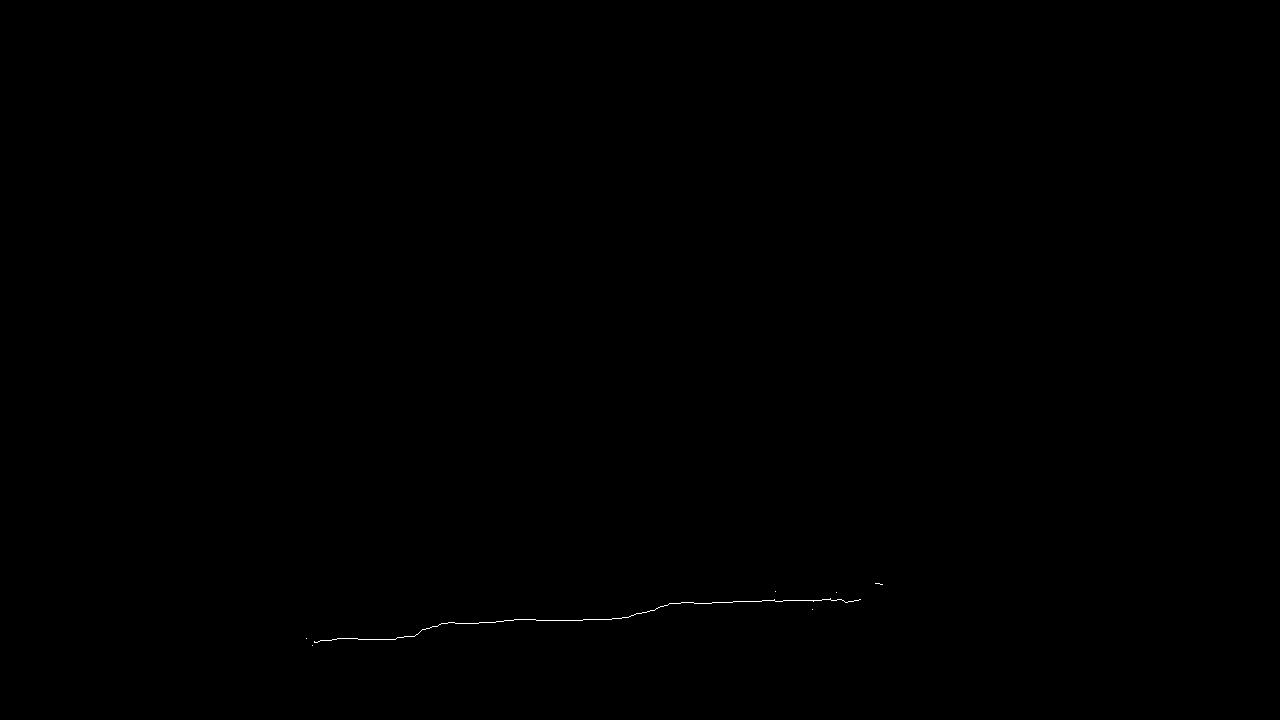

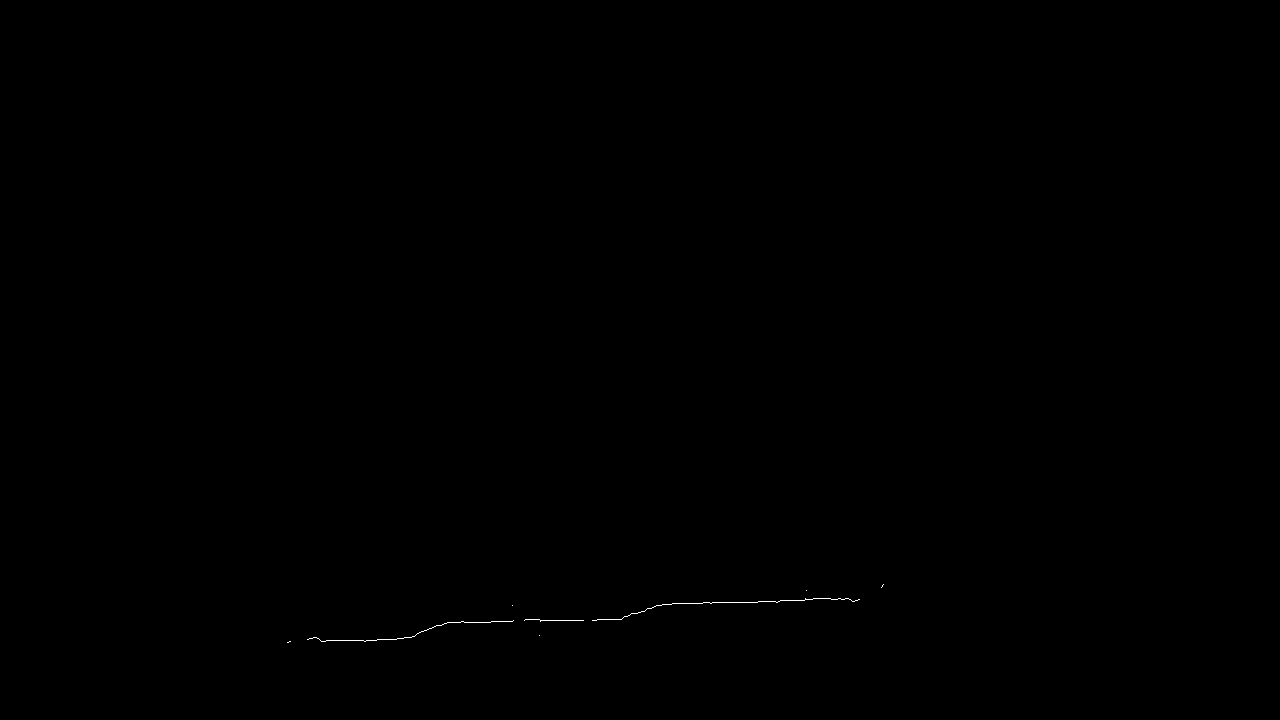

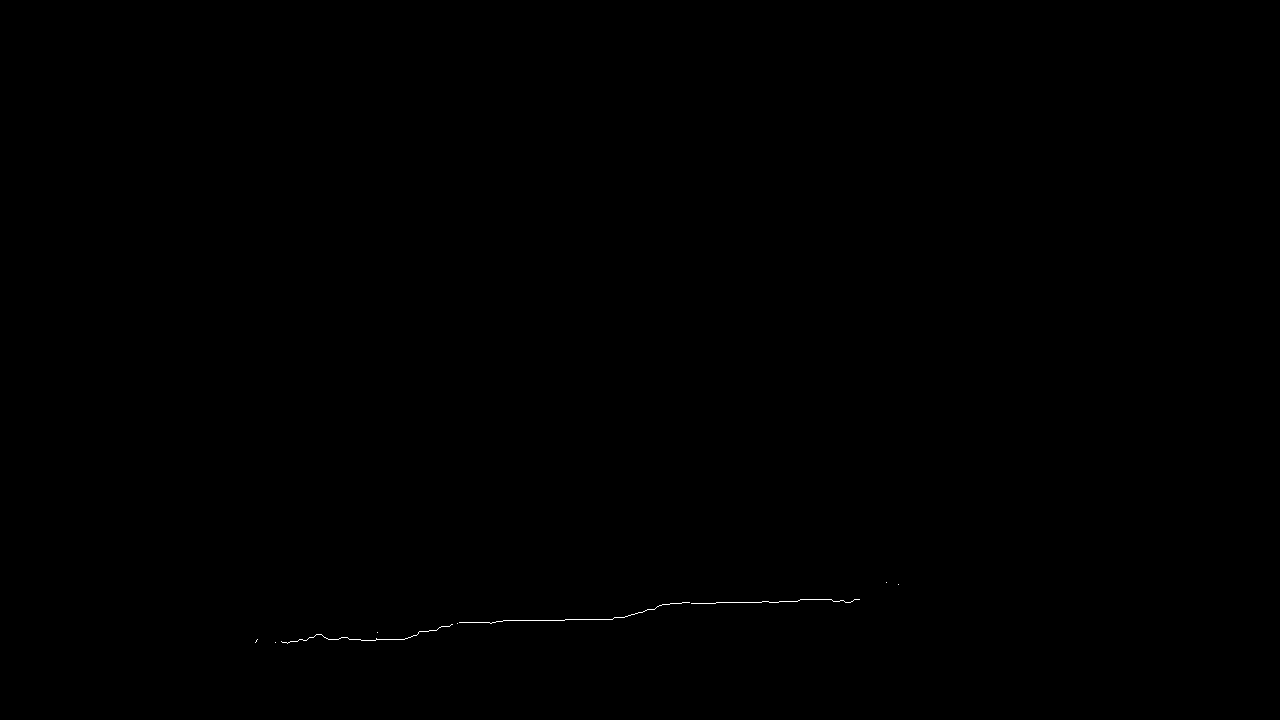

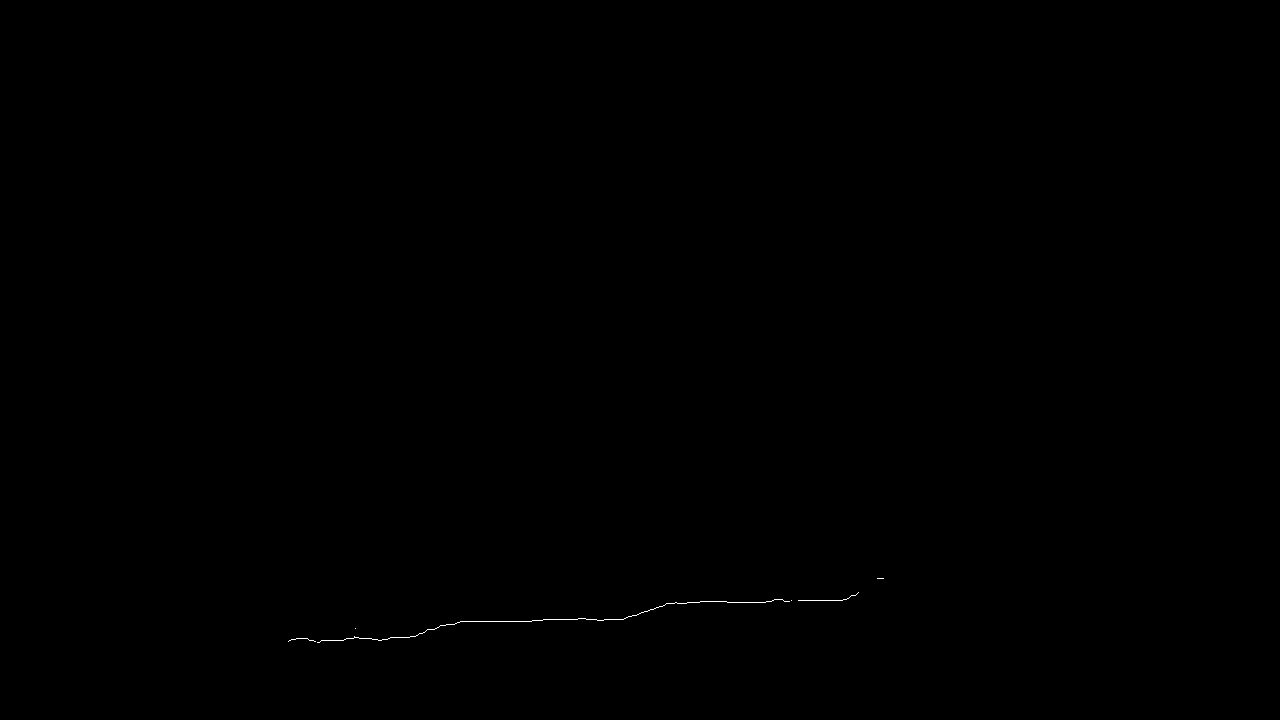

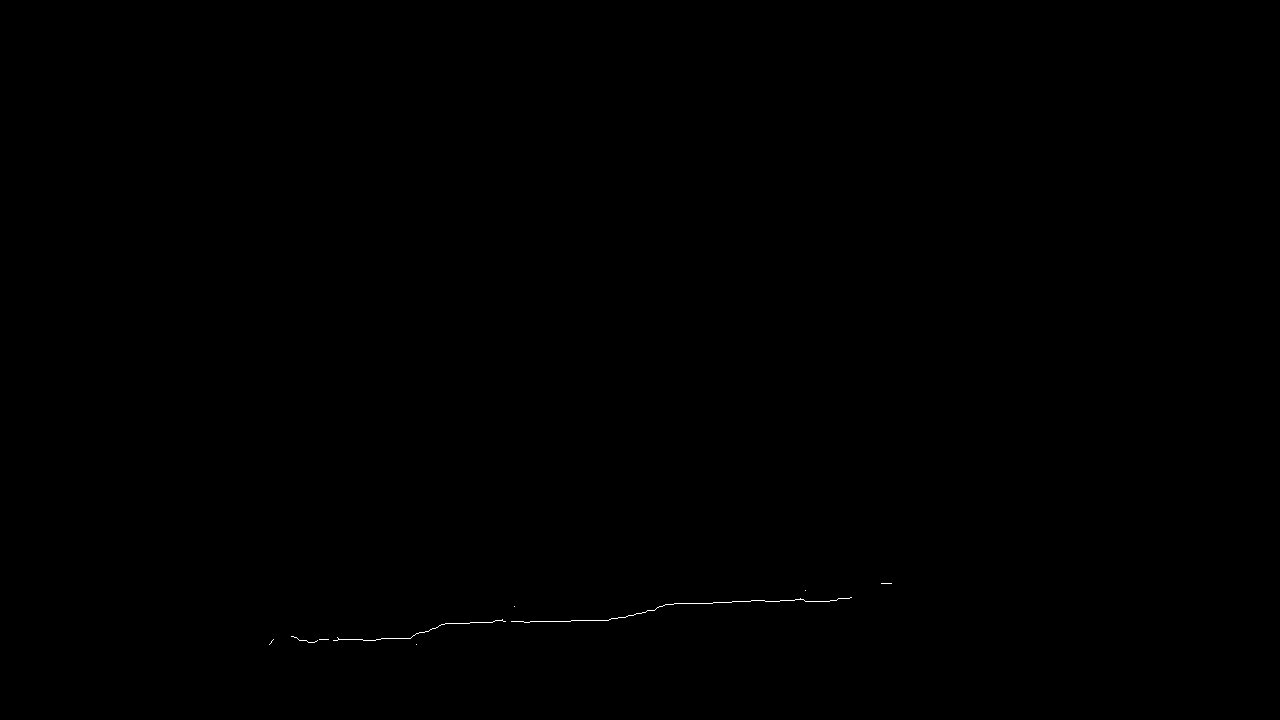

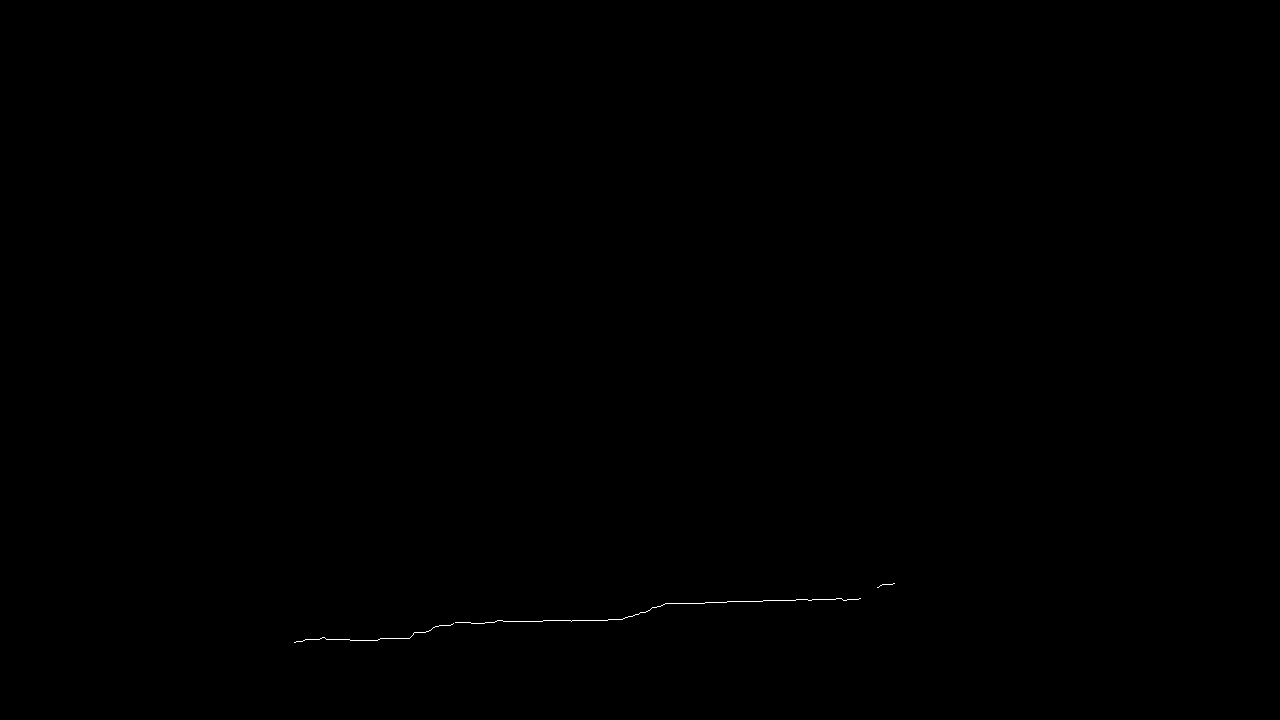

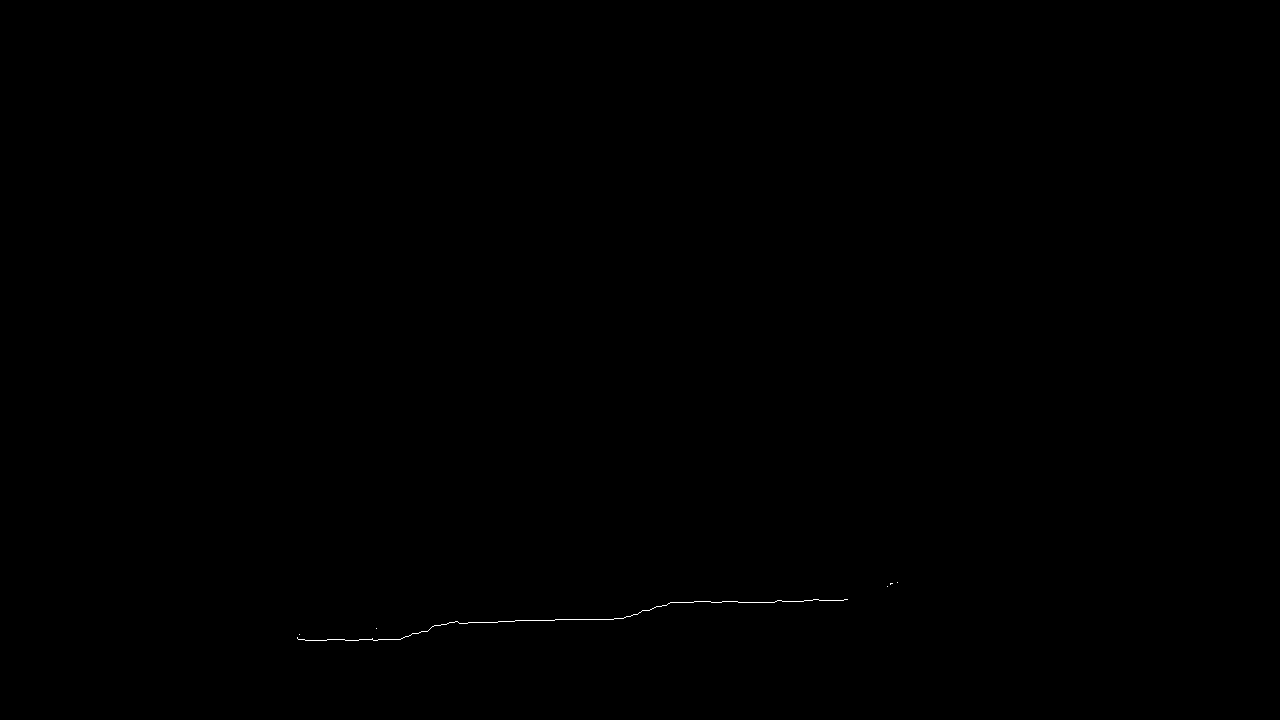

{0, 1, 2, -1}


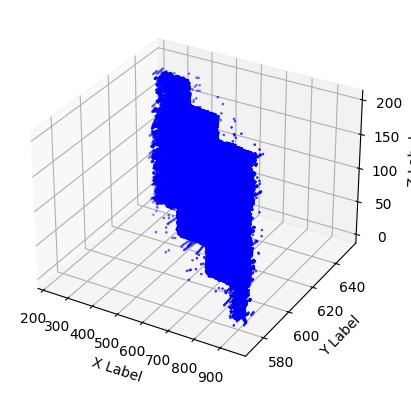

{0, 1, 2, -1}


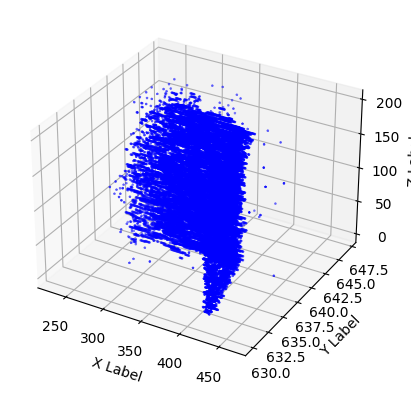

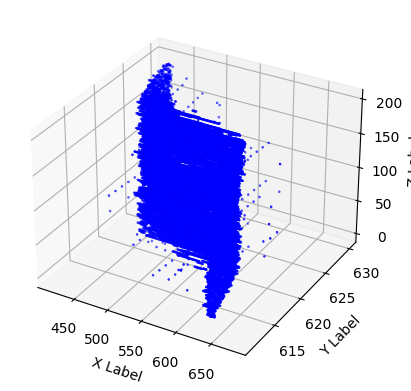

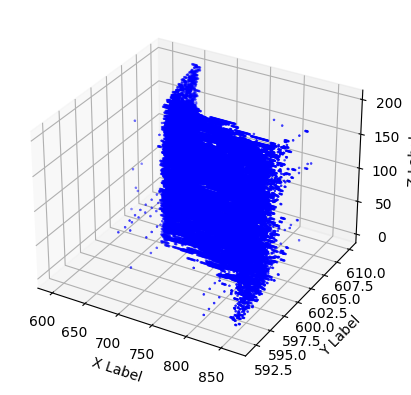

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 13 18:44:17 2021

@author: HP
"""

import cv2
from skimage.morphology import skeletonize
from skimage import data
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from pyntcloud import PyntCloud
from sklearn.cluster import DBSCAN
from scipy.spatial import distance_matrix
from skimage.measure import label , regionprops
import math
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

from convert_skeleton2 import branches, endpoints

def get(i):
    # Load image and perform necessary preprocessing steps
    img = cv2.imread('/content/drive/MyDrive/scanner/1234_mm/real%d.jpg' % i)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h, w = img.shape

    # Apply thresholding and morphology operations
    e = np.amax(img)
    ret, thresh1 = cv2.threshold(img, e * 0.15, 255, cv2.THRESH_BINARY)
    kernel = np.ones((7, 7), np.uint8)
    thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)

    return img, thresh1, h, w

def find(thresh1, i):
    # Perform skeletonization on the thresholded image
    data = thresh1 > 10
    skeleton = skeletonize(data)
    skeleton1 = skeleton.astype(np.uint8) * 255

    # Extract branches and endpoints from the skeleton
    branch = branches(skeleton)
    endpoint = endpoints(skeleton)
    (yb, xb) = np.where(branch == True)
    bp = np.vstack((xb, yb)).T
    (ye, xe) = np.where(endpoint == True)
    ep = np.vstack((xe, ye)).T

    # Further processing to remove unwanted branches
    branch_length = 20
    D0 = distance_matrix(ep, bp)
    if D0.shape[1] != 0:
        De = D0.min(axis=1)
        indb = np.argmin(D0, axis=1)
        inde = np.where(De < branch_length)[0]
        indb = indb[inde]
        m, n = skeleton.shape
        [X, Y] = np.meshgrid(range(n), range(m))

        for j in range(len(inde)):
            ie = inde[j]
            ib = indb[j]
            x1, y1, x2, y2 = xb[ib], yb[ib], xe[ie], ye[ie]
            x0 = (x1 + x2) / 2
            y0 = (y1 + y2) / 2
            D = distance_matrix(np.array([[x1, y1]]), np.array([[x2, y2]]))
            msk = ((X - x0) ** 2 + (Y - y0) ** 2) <= (D ** 2 / 4)
            rgn = msk & skeleton
            rgn = rgn.astype(np.uint8)

            L = label(rgn)
            ar = regionprops(L)
            rgn[L == 1] = 0

            skeleton = skeleton & ~msk

        skeleton2 = skeleton.astype(np.uint8) * 255
        cv2_imshow(skeleton2)
        cv2.waitKey(0)
    else:
        skeleton2 = skeleton1

    point = np.argwhere(skeleton2 == 255)
    point = np.rot90(point, 2)

    return point

def dbscan(cloud):
    X = StandardScaler().fit_transform(cloud.T)
    db = DBSCAN(eps=0.3, min_samples=1000).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    lab = np.reshape(labels, (labels.size, 1))
    e3 = np.concatenate((cloud.T, lab), axis=1)
    unique_labels = set(labels)
    print(unique_labels)
    em = np.empty
    L = [em, em, em, em, em, em, em, em, em, em, em, em, em]

    for i in range(len(unique_labels)):
        L[i] = np.delete(e3, np.where(e3[:, 3] != i), axis=0)

    j = 0
    while j < len(L):
        if np.any(L[j]) == np.empty or L[j].size < 1000:
            L.pop(j)
            continue
        j += 1

    return L

def job(k, fx, fy, x, y, point, height):
    intris = np.array([[fx, 0, w / 2 + 0.5], [0, fy, h / 2 + 0.5], [0, 0, 1]])
    intr = np.linalg.inv(intris)
    [t1] = np.dstack((x, y, np.ones(height)))
    t1 = t1.T
    t2 = np.dot(intr, t1)
    t = t2 / np.linalg.norm(t2)
    landa = (k[3] * k[4]) / (k[1] * t[0] + k[2] * t[1] + k[3] * t[2])
    xc = landa * t
    return xc

def tran(k, xc):
    rx = np.array([[1, 0, 0], [0, math.cos(k[5]), -math.sin(k[5])], [0, math.sin(k[5]), math.cos(k[5])]])
    ry = np.array([[math.cos(k[6]), 0, math.sin(k[6])], [0, 1, 0], [-math.sin(k[6]), 0, math.cos(k[6])]])
    rz = np.array([[math.cos(k[7]), -math.sin(k[7]), 0], [math.sin(k[7]), math.cos(k[7]), 0], [0, 0, 1]])
    clo = np.dot(np.dot(rz.T, np.dot(ry.T, rx.T)), xc)
    clo[0] = clo[0] - k[11] * i
    clo[1] = clo[1] - k[12] * i
    clo[2] = clo[2] - k[13] * i
    clo[0] = clo[0] + k[8]
    clo[1] = clo[1] + k[9]
    clo[2] = clo[2] + k[10]
    return clo

def display(cloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cloud[0], cloud[1], cloud[2], s=1, c='b', marker='*')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

nframe = 199
i0 = 1
cloud = np.empty

for i in range(nframe):
    i += i0
    img, thresh1, h, w = get(i)
    point = find(thresh1, i)
    cv2.waitKey(0)
    x = point.T[0]
    y = point.T[1]
    height = point.shape[0]
    k = [0.0000e+00, 5.7540e-17, 5.0000e-01, -8.6603e-01, -5.1962e+01, -2.2689e+00, -1.5708e+00, 3.4907e-01,
         4.5000e+01, 2.0500e+02, 5.0000e+00, -0.125, 0, 0]
    fx = 1074
    fy = 1074
    xc = job(k, fx, fy, x, y, point, height)
    clo = tran(k, xc)
    [clo] = np.dstack((x, y, i * np.ones(height)))
    clo = clo.T

    if i == i0:
        cloud = clo
        continue

    cloud = np.concatenate((cloud, clo), axis=1)
shapes=dbscan(abr)
display(cloud)
plt.show()

shapes = dbscan(abr)
for shape in shapes:
    display(shape.T)
    plt.show()